In [ ]:
# Creating a Monte Carlo toy example for PEHI and plotting results.
# This code will:
# - simulate posterior-like samples for σ/σ⊕, ΔG/ΔG⊕, R/R⊕ and H for Earth, K2-18b, GJ 1214b, TRAPPIST-1e
# - compute PEHI samples using alpha=beta=gamma=1
# - save separate histogram PNGs for each planet (one plot per file)
# - display a summary table of medians and 16/84 percentiles using the UI helper

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

# Helper to sample lognormal-like distributions around a median with approximate uncertainty
def sample_lognormal_median(median, fold_uncertainty_factor, n=5000):
    # fold_uncertainty_factor ~ ratio of upper/median (e.g., 2 means upper ~ 2*median)
    # We'll set sigma based on desired fold: sigma = ln(fold) / 1 (approx), adjust if needed
    if median <= 0:
        # allow very small medians: sample from normal around small value
        return np.abs(np.random.normal(loc=median, scale=median*fold_uncertainty_factor/2, size=n))
    sigma = np.log(fold_uncertainty_factor)
    mu = np.log(median)
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

# Planet definitions: (median_sigma, fold_uncertainty_sigma, median_dG, fold_dG, median_R, fold_R, H_median, H_sigma)
planets = {
    "Earth": (1.0, 1.1, 1.0, 1.1, 1.0, 1.05, 0.05, 0.02),
    "K2-18b": (0.4, 2.0, 0.2, 5.0, 0.5, 3.0, 0.20, 0.07),
    "GJ-1214b": (0.6, 2.0, 0.05, 6.0, 0.8, 2.5, 0.15, 0.05),
    "TRAPPIST-1e": (0.9, 1.8, 0.4, 3.0, 0.9, 2.0, 0.40, 0.12),
}

n_samples = 5000
results = {}

# Create output directory
out_dir = "/mnt/data/pehi_outputs"
os.makedirs(out_dir, exist_ok=True)

for pname, params in planets.items():
    sigma_m, sigma_fold, dG_m, dG_fold, R_m, R_fold, H_m, H_sig = params
    sigma_samples = sample_lognormal_median(sigma_m, sigma_fold, n_samples)
    dG_samples = sample_lognormal_median(dG_m, dG_fold, n_samples)
    R_samples = sample_lognormal_median(R_m, R_fold, n_samples)
    # H: sample normal around median but ensure non-negative
    H_samples = np.random.normal(loc=H_m, scale=H_sig, size=n_samples)
    H_samples = np.clip(H_samples, 0, None)
    # Compute PEHI (alpha=beta=gamma=1)
    pehi_samples = (sigma_samples * dG_samples * R_samples) / (1.0 + H_samples)
    results[pname] = {
        "sigma": sigma_samples,
        "dG": dG_samples,
        "R": R_samples,
        "H": H_samples,
        "PEHI": pehi_samples
    }
    # Plot histogram for PEHI
    plt.figure(figsize=(6,4))
    plt.hist(pehi_samples, bins=80, density=False, alpha=0.7)
    plt.xlabel("PEHI (arb. units)")
    plt.ylabel("Counts")
    plt.title(f"PEHI samples — {pname}")
    plt.tight_layout()
    fname = os.path.join(out_dir, f"pehi_hist_{pname.replace(' ','_')}.png")
    plt.savefig(fname, dpi=150)
    plt.close()

# Summarize medians and 16/84 percentiles
summary_rows = []
for pname, data in results.items():
    pe = data["PEHI"]
    med = np.median(pe)
    p16 = np.percentile(pe, 16)
    p84 = np.percentile(pe, 84)
    # Also summarize components (medians)
    summary_rows.append({
        "Planet": pname,
        "PEHI_median": med,
        "PEHI_16": p16,
        "PEHI_84": p84,
        "sigma_median": np.median(data["sigma"]),
        "dG_median": np.median(data["dG"]),
        "R_median": np.median(data["R"]),
        "H_median": np.median(data["H"])
    })

summary_df = pd.DataFrame(summary_rows).set_index("Planet")

# Save summary CSV
summary_csv = os.path.join(out_dir, "pehi_summary.csv")
summary_df.to_csv(summary_csv)

# Display the summary to user using a dataframe display helper
import caas_jupyter_tools as cjt
cjt.display_dataframe_to_user("PEHI Monte Carlo Summary", summary_df)

# Provide file links for the histogram images
file_links = {pname: os.path.join(out_dir, f"pehi_hist_{pname.replace(' ','_')}.png") for pname in results.keys()}
file_links, summary_csv



ModuleNotFoundError: No module named 'caas_jupyter_tools'

PEHI Monte Carlo complete.
Output directory: /content/pehi_outputs
Summary CSV: /content/pehi_outputs/pehi_summary.csv


PEHI_median  PEHI_16pct  PEHI_84pct  sigma_median  dG_median  \
Planet                                                                      
Earth           0.951949    0.827650    1.100180      1.001284   0.998338   
K2-18b          0.031494    0.004003    0.256127      0.397783   0.199665   
GJ-1214b        0.020217    0.002704    0.184391      0.609780   0.049645   
TRAPPIST-1e     0.233373    0.058440    0.930264      0.917086   0.405087   

             R_median  H_median  
Planet                           
Earth        1.000484  0.050385  
K2-18b       0.486614  0.200311  
GJ-1214b     0.822887  0.149514  
TRAPPIST-1e  0.888329  0.401523

Earth histogram saved to: /content/pehi_outputs/pehi_hist_Earth.png
K2-18b histogram saved to: /content/pehi_outputs/pehi_hist_K2-18b.png
GJ-1214b histogram saved to: /content/pehi_outputs/pehi_hist_GJ-1214b.png
TRAPPIST-1e histogram saved to: /content/pehi_outputs/pehi_hist_TRAPPIST-1e.png


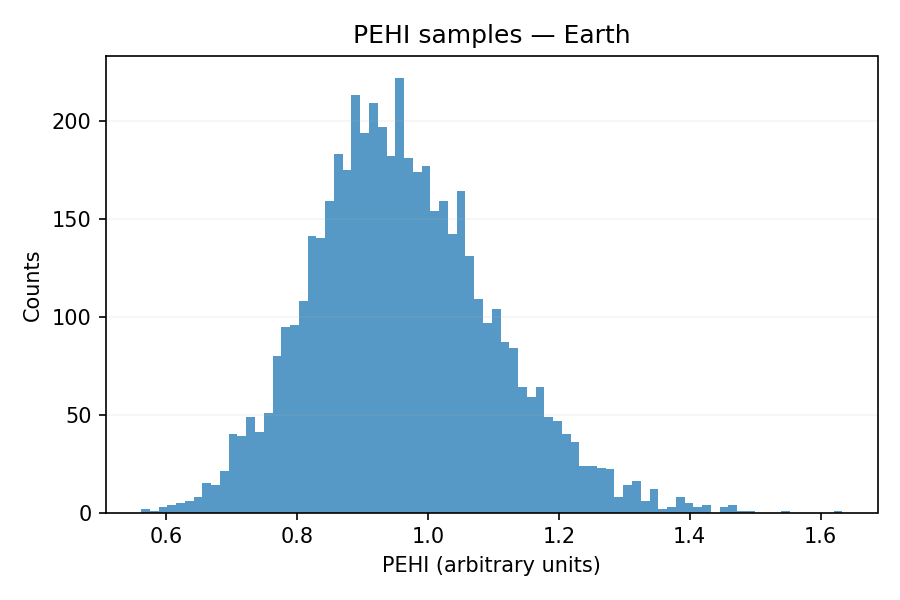

In [ ]:
# --- PEHI Monte Carlo toy pipeline (Colab-ready) ---
# Paste this entire block into one Colab cell and run.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import display, Image

# Reproducibility
np.random.seed(42)

# Helper: sample a lognormal-like distribution centered on 'median'
def sample_lognormal_median(median, fold_uncertainty_factor, n=5000):
    """
    median: desired median value (>=0)
    fold_uncertainty_factor: e.g., 2.0 means the 84th percentile ~ 2*median (rough heuristic)
    n: number of samples
    """
    if median <= 0:
        # For very small medians, fall back to small-normal sampling (keep non-negative)
        s = max(1e-6, abs(median) * 0.5)
        return np.abs(np.random.normal(loc=median, scale=s, size=n))
    # compute sigma of lognormal from fold: sigma = ln(fold)
    sigma = np.log(max(1.01, fold_uncertainty_factor))
    mu = np.log(median)
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

# Planet definitions
# Format: (median_sigma, sigma_fold, median_dG, dG_fold, median_R, R_fold, H_median, H_sigma)
planets = {
    "Earth":      (1.0, 1.1, 1.0, 1.1, 1.0, 1.05, 0.05, 0.02),
    "K2-18b":     (0.4, 2.0, 0.2, 5.0, 0.5, 3.0, 0.20, 0.07),
    "GJ-1214b":   (0.6, 2.0, 0.05, 6.0, 0.8, 2.5, 0.15, 0.05),
    "TRAPPIST-1e":(0.9, 1.8, 0.4, 3.0, 0.9, 2.0, 0.40, 0.12),
}

n_samples = 5000

# Output directory
out_dir = "/content/pehi_outputs"
os.makedirs(out_dir, exist_ok=True)

results = {}

for pname, pvals in planets.items():
    sigma_m, sigma_fold, dG_m, dG_fold, R_m, R_fold, H_m, H_sig = pvals
    sigma_samples = sample_lognormal_median(sigma_m, sigma_fold, n=n_samples)
    dG_samples    = sample_lognormal_median(dG_m, dG_fold, n=n_samples)
    R_samples     = sample_lognormal_median(R_m, R_fold, n=n_samples)
    # Hazard H: normal around median, clipped at 0
    H_samples     = np.random.normal(loc=H_m, scale=max(1e-6, H_sig), size=n_samples)
    H_samples     = np.clip(H_samples, 0.0, None)
    # Compute PEHI with alpha=beta=gamma=1 (change exponents below if desired)
    pehi_samples  = (sigma_samples * dG_samples * R_samples) / (1.0 + H_samples)
    results[pname] = {
        "sigma": sigma_samples,
        "dG": dG_samples,
        "R": R_samples,
        "H": H_samples,
        "PEHI": pehi_samples
    }
    # Save histogram
    plt.figure(figsize=(6,4))
    plt.hist(pehi_samples, bins=80, alpha=0.75)
    plt.xlabel("PEHI (arbitrary units)")
    plt.ylabel("Counts")
    plt.title(f"PEHI samples — {pname}")
    plt.grid(axis='y', alpha=0.12)
    fname = os.path.join(out_dir, f"pehi_hist_{pname.replace(' ','_')}.png")
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close()

# Build summary DataFrame
rows = []
for pname, data in results.items():
    pe = data["PEHI"]
    rows.append({
        "Planet": pname,
        "PEHI_median": np.median(pe),
        "PEHI_16pct": np.percentile(pe, 16),
        "PEHI_84pct": np.percentile(pe, 84),
        "sigma_median": np.median(data["sigma"]),
        "dG_median": np.median(data["dG"]),
        "R_median": np.median(data["R"]),
        "H_median": np.median(data["H"])
    })

summary_df = pd.DataFrame(rows).set_index("Planet")
summary_csv = os.path.join(out_dir, "pehi_summary.csv")
summary_df.to_csv(summary_csv)

print("PEHI Monte Carlo complete.")
print("Output directory:", out_dir)
print("Summary CSV:", summary_csv)
display(summary_df)

# Show the generated histogram paths and inline the Earth plot as example
for pname in results.keys():
    img = os.path.join(out_dir, f"pehi_hist_{pname.replace(' ','_')}.png")
    print(f"{pname} histogram saved to: {img}")

# Display one sample image inline (Earth)
example_img = os.path.join(out_dir, "pehi_hist_Earth.png")
if os.path.exists(example_img):
    display(Image(example_img, width=600))
else:
    print("Example image not found:", example_img)

# OPTIONAL: quick sensitivity test helper (uncomment to run)
# def sensitivity_test(alpha_list=[0.5,1.0,1.5], beta_list=[0.5,1.0,1.5], gamma_list=[0.5,1.0,1.5]):
#     sens_rows = []
#     for a in alpha_list:
#         for b in beta_list:
#             for g in gamma_list:
#                 # compute PEHI median for K2-18b as example
#                 s = results['K2-18b']['sigma']
#                 d = results['K2-18b']['dG']
#                 r = results['K2-18b']['R']
#                 h = results['K2-18b']['H']
#                 pe = (s**a) * (d**b) * (r**g) / (1 + h)
#                 sens_rows.append({'alpha':a, 'beta':b, 'gamma':g, 'PEHI_median_K2-18b':np.median(pe)})
#     return pd.DataFrame(sens_rows)
#
# # Example usage:
# # display(sensitivity_test())


In [ ]:
# Colab: run in a cell with ! prefix, or in terminal locally
pip install numpy pandas matplotlib seaborn python ternary


SyntaxError: invalid syntax (ipython-input-117923739.py, line 2)

In [ ]:
# pehi_montecarlo.py  (Colab-ready)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

np.random.seed(42)
sns.set(style='whitegrid', context='paper')

def sample_lognormal_median(median, fold_uncertainty, n=5000):
    if median <= 0:
        return np.abs(np.random.normal(loc=median, scale=max(1e-6, abs(median)*0.5), size=n))
    sigma = np.log(max(1.01, fold_uncertainty))
    mu = np.log(median)
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

# Define planets and provisional medians (tune as you wish)
planets = {
    "Earth":      (1.0, 1.1, 1.0, 1.1, 1.0, 1.05, 0.05, 0.02),
    "K2-18b":     (0.4, 2.0, 0.2, 5.0, 0.5, 3.0, 0.20, 0.07),
    "GJ-1214b":   (0.6, 2.0, 0.05, 6.0, 0.8, 2.5, 0.15, 0.05),
    "TRAPPIST-1e":(0.9, 1.8, 0.4, 3.0, 0.9, 2.0, 0.40, 0.12),
}

n_samples = 5000
outdir = "pehi_outputs"
os.makedirs(outdir, exist_ok=True)

results = {}
alpha = beta = gamma = 1.0

for pname, (s_m, s_f, d_m, d_f, r_m, r_f, h_m, h_sig) in planets.items():
    s = sample_lognormal_median(s_m, s_f, n_samples)
    d = sample_lognormal_median(d_m, d_f, n_samples)
    r = sample_lognormal_median(r_m, r_f, n_samples)
    h = np.clip(np.random.normal(loc=h_m, scale=h_sig, size=n_samples), 0, None)
    pehi = (s**alpha) * (d**beta) * (r**gamma) / (1.0 + h)
    results[pname] = {"sigma": s, "dG": d, "R": r, "H": h, "PEHI": pehi}
    # histogram
    plt.figure(figsize=(6,4))
    plt.hist(pehi, bins=80, alpha=0.75)
    plt.xlabel("PEHI (arb. units)")
    plt.ylabel("Counts")
    plt.title(f"PEHI samples — {pname}")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"pehi_hist_{pname.replace(' ','_')}.png"), dpi=180)
    plt.close()

# summary
rows = []
for p, d in results.items():
    pe = d["PEHI"]
    rows.append({
        "Planet": p,
        "PEHI_median": np.median(pe),
        "PEHI_16": np.percentile(pe, 16),
        "PEHI_84": np.percentile(pe, 84),
        "sigma_med": np.median(d["sigma"]),
        "dG_med": np.median(d["dG"]),
        "R_med": np.median(d["R"]),
        "H_med": np.median(d["H"])
    })
summary = pd.DataFrame(rows).set_index("Planet")
summary.to_csv(os.path.join(outdir, "pehi_summary.csv"))
print("Outputs saved to", outdir)
print(summary)


Outputs saved to pehi_outputs
             PEHI_median   PEHI_16   PEHI_84  sigma_med    dG_med     R_med  \
Planet                                                                        
Earth           0.951949  0.827650  1.100180   1.001284  0.998338  1.000484   
K2-18b          0.031494  0.004003  0.256127   0.397783  0.199665  0.486614   
GJ-1214b        0.020217  0.002704  0.184391   0.609780  0.049645  0.822887   
TRAPPIST-1e     0.233373  0.058440  0.930264   0.917086  0.405087  0.888329   

                H_med  
Planet                 
Earth        0.050385  
K2-18b       0.200311  
GJ-1214b     0.149514  
TRAPPIST-1e  0.401523  


In [ ]:
# pehi_entropy_schematic.py
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,5))
ax.axis('off')

# boxes
boxes = {
    "Star (source)": (0.05, 0.55, 0.25, 0.3),
    "Atmosphere": (0.4, 0.55, 0.25, 0.3),
    "Surface": (0.7, 0.55, 0.25, 0.3),
    "Interior": (0.7, 0.12, 0.25, 0.3),
    "Space (sink)": (0.4, 0.12, 0.25, 0.3)
}

for label, (x,y,w,h) in boxes.items():
    rect = patches.FancyBboxPatch((x,y), w, h, boxstyle="round,pad=0.05", edgecolor="k", linewidth=1.2, facecolor="#f7f7f7")
    ax.add_patch(rect)
    ax.text(x+w/2, y+h/2, label, ha='center', va='center', fontsize=10)

# arrows
def draw_arrow(xy_from, xy_to, text=None, text_offset=(0,0)):
    ax.annotate("", xy=xy_to, xytext=xy_from, arrowprops=dict(arrowstyle="->", lw=2))
    if text:
        mid = ((xy_from[0]+xy_to[0])/2 + text_offset[0], (xy_from[1]+xy_to[1])/2 + text_offset[1])
        ax.text(mid[0], mid[1], text, ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round", fc="white", ec="none", alpha=0.7))

# star -> atmosphere/surface
draw_arrow((0.3,0.7),(0.4,0.8),"Stellar irradiation")
draw_arrow((0.3,0.65),(0.8,0.7),"Shortwave flux")
draw_arrow((0.8,0.55),(0.5,0.45),"Thermal emission")
draw_arrow((0.75,0.4),(0.75,0.35),"Interior heat flux")
draw_arrow((0.55,0.2),(0.15,0.5),"Reflected/escaped")

ax.set_title("Schematic: Planetary entropy fluxes and major channels", fontsize=12)
plt.tight_layout()
plt.savefig("entropy_flux_schematic.png", dpi=300)
plt.close()


In [ ]:
# pehi_3d_space.py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# sample toy points
points = {
    'Earth': (1.0, 1.0, 1.0),
    'Archean Earth': (1.0, 0.7, 0.7),
    'K2-18b': (0.4, 0.2, 0.5),
    'GJ-1214b': (0.6, 0.05, 0.8),
    'TRAPPIST-1e': (0.9, 0.4, 0.9)
}

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')

for name, (s,d,r) in points.items():
    ax.scatter(s, d, r, s=60)
    ax.text(s, d, r, "  "+name, size=9, zorder=1)

ax.set_xlabel(r'$\sigma/\sigma_\oplus$')
ax.set_ylabel(r'$\Delta G_{diseq}/\Delta G_\oplus$')
ax.set_zlabel(r'$R/R_\oplus$')
ax.set_title("Conceptual PEHI parameter space (qualitative)")
plt.tight_layout()
plt.savefig("pehi_3d_space.png", dpi=200)
plt.close()


In [ ]:
# pehi_timeline.py
import matplotlib.pyplot as plt
import numpy as np

epochs = ['Archean','GOE','Proterozoic','Phanerozoic','Modern']
x = np.arange(len(epochs))
# toy values for ΔG and R (illustrative)
dG = np.array([1.1, 0.6, 0.8, 0.95, 1.0])
R  = np.array([0.5, 0.7, 0.85, 0.95, 1.0])

fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(x, dG, marker='o', label=r'$\Delta G_{diseq}$ (relative)')
ax.plot(x, R, marker='s', label='Regulatory resilience R (relative)')
ax.set_xticks(x); ax.set_xticklabels(epochs, rotation=25)
ax.set_ylim(0,1.3)
ax.set_ylabel('Relative value (qualitative)')
ax.set_title('Schematic Earth PEHI(t) across major epochs (qualitative)')
ax.legend()
plt.tight_layout()
plt.savefig("earth_pehi_timeline.png", dpi=200)
plt.close()


In [ ]:
# pehi_sensitivity.py
import numpy as np
import pandas as pd

# reuse results dict from Monte Carlo stage or re-sample quickly here
# Example: sensitivity for K2-18b using results stored as `results['K2-18b']` in memory
# If running standalone, re-run the montecarlo and load the arrays.

def sensitivity_matrix(s_arr, d_arr, r_arr, h_arr, alphas=[0.5,1.0,1.5], betas=[0.5,1.0,1.5], gammas=[0.5,1.0,1.5]):
    rows=[]
    for a in alphas:
        for b in betas:
            for g in gammas:
                pe = (s_arr**a) * (d_arr**b) * (r_arr**g) / (1.0 + h_arr)
                rows.append({'alpha':a,'beta':b,'gamma':g,'PEHI_median':np.median(pe)})
    return pd.DataFrame(rows)

# Example usage (assuming arrays s,d,r,h exist):
# df = sensitivity_matrix(sigma_samples, dG_samples, R_samples, H_samples)
# print(df.pivot_table(index=['alpha','beta'], columns='gamma', values='PEHI_median'))


In [ ]:
# pehi_gibbs_proxy.py
import numpy as np

# Example crude formation-like coefficients (units arbitrary)
# These coefficients express relative free-energy "value" per mole for a species in an atmosphere.
# They are placeholders — replace with formation Gibbs energies from a thermodynamic database for real work.
G_CO2 = -393.5   # kJ/mol (example formation energy, negative means stable) -- placeholder
G_CH4 = -74.8
G_O2  = 0.0
G_H2  = 0.0
G_H2O = -241.8
G_N2  = 0.0

coeffs = {'CO2': G_CO2, 'CH4': G_CH4, 'O2': G_O2, 'H2': G_H2, 'H2O': G_H2O, 'N2': G_N2}

def deltaG_proxy(mixing_ratios, coeffs=coeffs):
    """
    mixing_ratios: dict species -> mole fraction (must sum <=1)
    Computes a simple proxy: positive ΔG ~ distance from chemical equilibrium approximated by sum(x_i * c_i)
    (This is heuristic and only for toy illustration.)
    """
    # baseline equilibrium proxy (choose reference, e.g., inert N2 dominated)
    baseline = 0.0
    val = 0.0
    for sp, x in mixing_ratios.items():
        c = coeffs.get(sp, 0.0)
        val += x * (-c)  # flip sign so that higher exploitable energy -> larger positive value
    # normalize to Earth-like scale by dividing by a reference (e.g., 100)
    return val / 100.0

# Example:
mix = {'N2':0.78, 'O2':0.21, 'CO2':0.0004, 'CH4':1.8e-6}
print("Toy ΔG proxy:", deltaG_proxy(mix))


Toy ΔG proxy: 0.0015753464


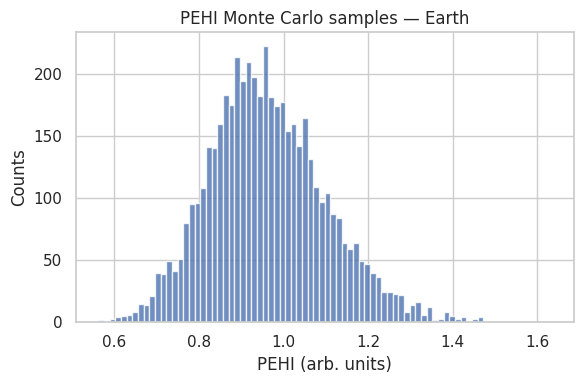

Saved histogram: /content/pehi_outputs/pehi_hist_Earth.png


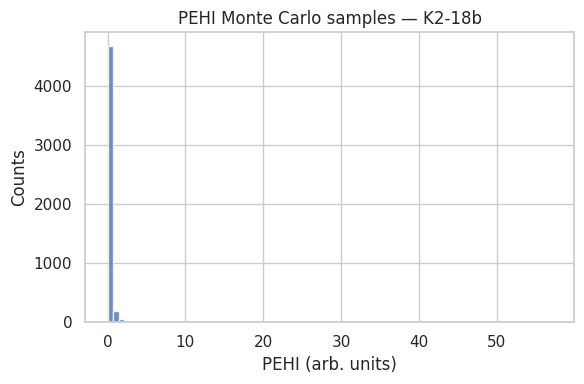

Saved histogram: /content/pehi_outputs/pehi_hist_K2-18b.png


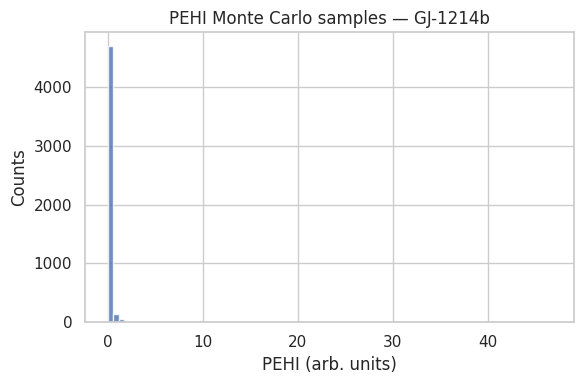

Saved histogram: /content/pehi_outputs/pehi_hist_GJ-1214b.png


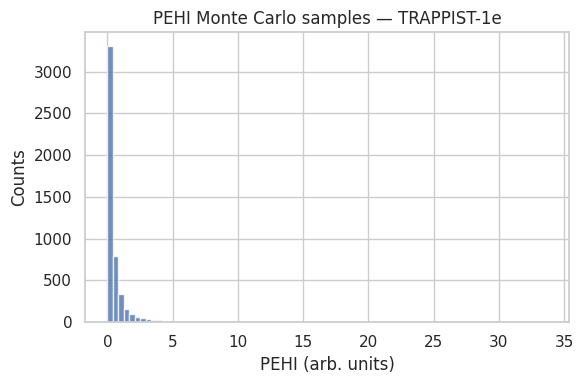

Saved histogram: /content/pehi_outputs/pehi_hist_TRAPPIST-1e.png

Summary CSV saved to: /content/pehi_outputs/pehi_summary.csv


PEHI_median  PEHI_16pct  PEHI_84pct  sigma_med    dG_med  \
Planet                                                                  
Earth           0.951949    0.827650    1.100180   1.001284  0.998338   
K2-18b          0.031494    0.004003    0.256127   0.397783  0.199665   
GJ-1214b        0.020217    0.002704    0.184391   0.609780  0.049645   
TRAPPIST-1e     0.233373    0.058440    0.930264   0.917086  0.405087   

                R_med     H_med  
Planet                           
Earth        1.000484  0.050385  
K2-18b       0.486614  0.200311  
GJ-1214b     0.822887  0.149514  
TRAPPIST-1e  0.888329  0.401523

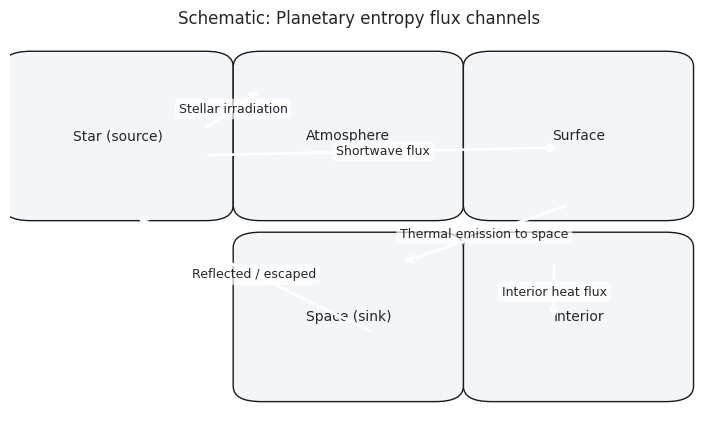

Saved schematic: /content/pehi_outputs/entropy_flux_schematic.png


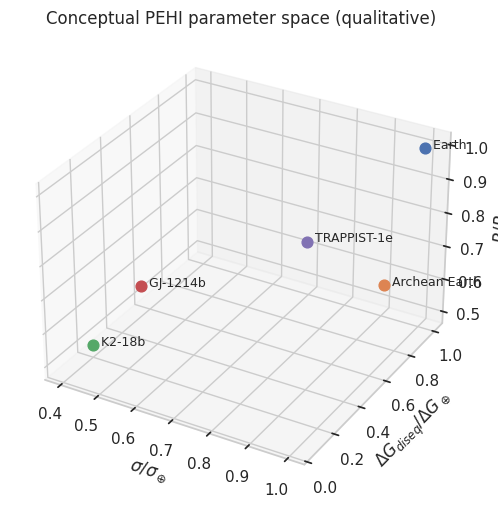

Saved 3D concept plot: /content/pehi_outputs/pehi_3d_space.png


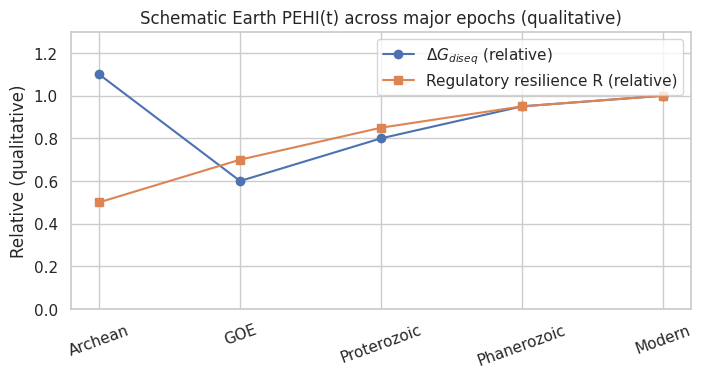

Saved timeline: /content/pehi_outputs/earth_pehi_timeline.png


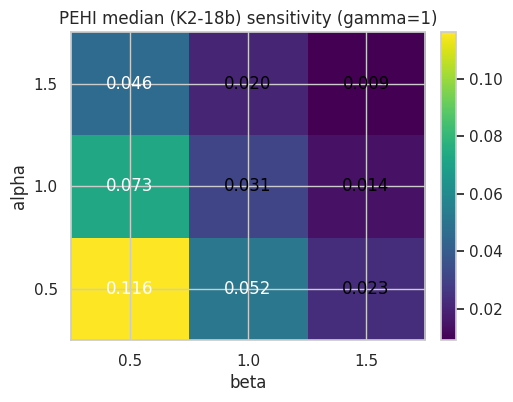

Saved sensitivity heatmap: /content/pehi_outputs/sensitivity_heatmap_k218b.png

All generated files in: /content/pehi_outputs
Files: ['pehi_hist_TRAPPIST-1e.png', 'pehi_summary.csv', 'pehi_hist_GJ-1214b.png', 'pehi_hist_K2-18b.png', 'entropy_flux_schematic.png', 'pehi_3d_space.png', 'sensitivity_heatmap_k218b.png', 'pehi_hist_Earth.png', 'earth_pehi_timeline.png']


In [ ]:
# Complete Colab/Jupyter cell: Monte Carlo + figure generation + saving + inline display
# Paste the whole block into one notebook cell and run.
import sys
import os
# --- Install optional packages in Colab if not present ---
try:
    import seaborn as sns
except Exception:
    !pip install seaborn --quiet
    import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image, HTML
import math
import time

# Ensure inline plotting in notebooks
# (If running in pure .py script, the saved PNGs will still be created; inline display is for notebooks)
%matplotlib inline

np.random.seed(42)
sns.set(style='whitegrid', context='notebook')

# Output directory (Colab-friendly)
OUTDIR = "/content/pehi_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ---- Sampling helper ----
def sample_lognormal_median(median, fold_uncertainty_factor, n=5000):
    if median <= 0:
        return np.abs(np.random.normal(loc=median, scale=max(1e-9, abs(median)*0.5), size=n))
    sigma = np.log(max(1.01, fold_uncertainty_factor))
    mu = np.log(median)
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

# ---- Planet provisional medians (tune these) ----
planets = {
    "Earth":      (1.0, 1.1, 1.0, 1.1, 1.0, 1.05, 0.05, 0.02),
    "K2-18b":     (0.4, 2.0, 0.2, 5.0, 0.5, 3.0, 0.20, 0.07),
    "GJ-1214b":   (0.6, 2.0, 0.05, 6.0, 0.8, 2.5, 0.15, 0.05),
    "TRAPPIST-1e":(0.9, 1.8, 0.4, 3.0, 0.9, 2.0, 0.40, 0.12),
}

n_samples = 5000
alpha = beta = gamma = 1.0  # default exponents

results = {}

# ---- Monte Carlo + histograms ----
for pname, params in planets.items():
    s_m, s_f, d_m, d_f, r_m, r_f, h_m, h_sig = params
    s_samples = sample_lognormal_median(s_m, s_f, n=n_samples)
    d_samples = sample_lognormal_median(d_m, d_f, n=n_samples)
    r_samples = sample_lognormal_median(r_m, r_f, n=n_samples)
    h_samples = np.clip(np.random.normal(loc=h_m, scale=max(1e-9, h_sig), size=n_samples), 0.0, None)
    pehi_samples = (s_samples**alpha) * (d_samples**beta) * (r_samples**gamma) / (1.0 + h_samples)
    results[pname] = {
        "sigma": s_samples, "dG": d_samples, "R": r_samples, "H": h_samples, "PEHI": pehi_samples
    }

    # Histogram figure
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(pehi_samples, bins=80, alpha=0.8)
    ax.set_xlabel("PEHI (arb. units)")
    ax.set_ylabel("Counts")
    ax.set_title(f"PEHI Monte Carlo samples — {pname}")
    plt.tight_layout()
    png_path = os.path.join(OUTDIR, f"pehi_hist_{pname.replace(' ', '_')}.png")
    plt.savefig(png_path, dpi=200)
    plt.show()
    plt.close()
    print("Saved histogram:", png_path)

# ---- Summary table ----
rows = []
for pname, d in results.items():
    pe = d["PEHI"]
    rows.append({
        "Planet": pname,
        "PEHI_median": np.median(pe),
        "PEHI_16pct": np.percentile(pe, 16),
        "PEHI_84pct": np.percentile(pe, 84),
        "sigma_med": np.median(d["sigma"]),
        "dG_med": np.median(d["dG"]),
        "R_med": np.median(d["R"]),
        "H_med": np.median(d["H"])
    })

summary_df = pd.DataFrame(rows).set_index("Planet")
csv_path = os.path.join(OUTDIR, "pehi_summary.csv")
summary_df.to_csv(csv_path)
print("\nSummary CSV saved to:", csv_path)
display(summary_df)

# ---- Entropy-flux schematic (publication-style) ----
fig, ax = plt.subplots(figsize=(9,5))
ax.axis('off')

boxes = {
    "Star (source)": (0.03, 0.55, 0.25, 0.36),
    "Atmosphere": (0.36, 0.55, 0.25, 0.36),
    "Surface": (0.69, 0.55, 0.25, 0.36),
    "Interior": (0.69, 0.08, 0.25, 0.36),
    "Space (sink)": (0.36, 0.08, 0.25, 0.36)
}

for label, (x,y,w,h) in boxes.items():
    rect = patches.FancyBboxPatch((x,y), w, h, boxstyle="round,pad=0.04", edgecolor="k", linewidth=1.0, facecolor="#f3f6f9")
    ax.add_patch(rect)
    ax.text(x+w/2, y+h/2, label, ha='center', va='center', fontsize=10)

def arrow(xy_from, xy_to, txt=None, off=(0,0)):
    ax.annotate("", xy=xy_to, xytext=xy_from, arrowprops=dict(arrowstyle="->", lw=2))
    if txt:
        mx = (xy_from[0]+xy_to[0])/2 + off[0]
        my = (xy_from[1]+xy_to[1])/2 + off[1]
        ax.text(mx, my, txt, ha='center', va='center', fontsize=9, bbox=dict(boxstyle="round", fc="white", ec="none", alpha=0.7))

arrow((0.28,0.75),(0.36,0.85),"Stellar irradiation")
arrow((0.28,0.68),(0.79,0.7),"Shortwave flux")
arrow((0.80,0.55),(0.56,0.40),"Thermal emission to space")
arrow((0.78,0.40),(0.78,0.25),"Interior heat flux")
arrow((0.52,0.22),(0.18,0.52),"Reflected / escaped")
ax.set_title("Schematic: Planetary entropy flux channels", fontsize=12)
schem_path = os.path.join(OUTDIR, "entropy_flux_schematic.png")
plt.savefig(schem_path, dpi=200, bbox_inches='tight')
plt.show()
plt.close()
print("Saved schematic:", schem_path)

# ---- 3D PEHI conceptual scatter (σ, ΔG, R) ----
fig = plt.figure(figsize=(7,6))
ax3 = fig.add_subplot(111, projection='3d')
toy_points = {
    'Earth': (1.0, 1.0, 1.0),
    'Archean Earth': (1.0, 0.7, 0.7),
    'K2-18b': (0.4, 0.2, 0.5),
    'GJ-1214b': (0.6, 0.05, 0.8),
    'TRAPPIST-1e': (0.9, 0.4, 0.9)
}
for name, (s, d, r) in toy_points.items():
    ax3.scatter(s, d, r, s=60)
    ax3.text(s, d, r, "  "+name, size=9, zorder=1)
ax3.set_xlabel(r'$\sigma/\sigma_\oplus$')
ax3.set_ylabel(r'$\Delta G_{diseq}/\Delta G_\oplus$')
ax3.set_zlabel(r'$R/R_\oplus$')
ax3.set_title("Conceptual PEHI parameter space (qualitative)")
pehi3d_path = os.path.join(OUTDIR, "pehi_3d_space.png")
plt.savefig(pehi3d_path, dpi=200, bbox_inches='tight')
plt.show()
plt.close()
print("Saved 3D concept plot:", pehi3d_path)

# ---- Earth PEHI(t) qualitative timeline ----
epochs = ['Archean','GOE','Proterozoic','Phanerozoic','Modern']
x = np.arange(len(epochs))
dG = np.array([1.1, 0.6, 0.8, 0.95, 1.0])     # toy relative ΔG
Rvals  = np.array([0.5, 0.7, 0.85, 0.95, 1.0]) # toy relative R
fig, ax = plt.subplots(figsize=(8,3.6))
ax.plot(x, dG, marker='o', label=r'$\Delta G_{diseq}$ (relative)')
ax.plot(x, Rvals, marker='s', label='Regulatory resilience R (relative)')
ax.set_xticks(x); ax.set_xticklabels(epochs, rotation=20)
ax.set_ylim(0,1.3)
ax.set_ylabel('Relative (qualitative)')
ax.set_title('Schematic Earth PEHI(t) across major epochs (qualitative)')
ax.legend()
timeline_path = os.path.join(OUTDIR, "earth_pehi_timeline.png")
plt.savefig(timeline_path, dpi=200, bbox_inches='tight')
plt.show()
plt.close()
print("Saved timeline:", timeline_path)

# ---- Sensitivity heatmap example ----
# Use K2-18b arrays from results to test alpha/beta grid
s_arr = results['K2-18b']['sigma']
d_arr = results['K2-18b']['dG']
r_arr = results['K2-18b']['R']
h_arr = results['K2-18b']['H']

alpha_vals = [0.5, 1.0, 1.5]
beta_vals  = [0.5, 1.0, 1.5]
gamma_fixed = 1.0
heat = np.zeros((len(alpha_vals), len(beta_vals)))

for i, a in enumerate(alpha_vals):
    for j, b in enumerate(beta_vals):
        pe = (s_arr**a) * (d_arr**b) * (r_arr**gamma_fixed) / (1.0 + h_arr)
        heat[i,j] = np.median(pe)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(heat, origin='lower', cmap='viridis', interpolation='nearest', aspect='auto')
ax.set_xticks(np.arange(len(beta_vals))); ax.set_xticklabels(beta_vals)
ax.set_yticks(np.arange(len(alpha_vals))); ax.set_yticklabels(alpha_vals)
ax.set_xlabel('beta'); ax.set_ylabel('alpha'); ax.set_title('PEHI median (K2-18b) sensitivity (gamma=1)')
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        ax.text(j, i, f"{heat[i,j]:.3f}", ha='center', va='center', color='white' if heat[i,j]>np.max(heat)/3 else 'black')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
sens_path = os.path.join(OUTDIR, "sensitivity_heatmap_k218b.png")
plt.savefig(sens_path, dpi=200, bbox_inches='tight')
plt.show()
plt.close()
print("Saved sensitivity heatmap:", sens_path)

print("\nAll generated files in:", OUTDIR)
print("Files:", os.listdir(OUTDIR))


In [ ]:
# --- Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

print("Step 1: Libraries imported.\n")

# --- Step 2: Upload Files ---
print("Step 2: Upload your CSV files now (only the real ones):")
print("  - scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv")
print("  - scarlet_model_exoTEDRF_with-DMS-C2H6.csv")
print("Do NOT upload files starting with '._'\n")

uploaded = files.upload()

# List uploaded files
for filename in uploaded.keys():
    print(f"✅ Loaded: {filename}")

# --- Step 3: Load Data ---

# Load posterior samples
samples_file = 'scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv'
samples_df = pd.read_csv(samples_file, header=None)

# Define column names (adjust if needed based on your retrieval setup)
param_names = [
    'logP_0', 'logP_1', 'logP_2', 'logP_3', 'logP_4',
    'logP_5', 'logP_6', 'logP_7', 'logP_8',
    'Teff', 'logg', 'C/O', 'metallicity',
    'logDMS', 'logC2H6', 'weight'
]
samples_df.columns = param_names

print(f"\nStep 3a: Samples shape: {samples_df.shape}")
print("First few rows of samples:")
print(samples_df.head(3))

# Load model outputs
model_file = 'scarlet_model_exoTEDRF_with-DMS-C2H6.csv'
model_df = pd.read_csv(model_file, header=None)

print(f"\nStep 3b: Model output shape: {model_df.shape}")
print("First few rows of model predictions:")
print(model_df.iloc[:3, :5])  # show first 3 rows, first 5 cols

Step 1: Libraries imported.

Step 2: Upload your CSV files now (only the real ones):
  - scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv
  - scarlet_model_exoTEDRF_with-DMS-C2H6.csv
Do NOT upload files starting with '._'



Saving ._scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv to ._scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6 (1).csv
Saving ._scarlet_model_exoTEDRF_with-DMS-C2H6.csv to ._scarlet_model_exoTEDRF_with-DMS-C2H6 (1).csv
Saving ._scarlet_model_SPARTA_with-DMS-C2H6.csv to ._scarlet_model_SPARTA_with-DMS-C2H6 (1).csv
Saving ._scarlet_samples-with-weights_SPARTA_with-DMS-C2H6.csv to ._scarlet_samples-with-weights_SPARTA_with-DMS-C2H6 (1).csv
Saving ._scarlet_model_exoTEDRF_with-C2H6.csv to ._scarlet_model_exoTEDRF_with-C2H6 (1).csv
Saving ._scarlet_model_SPARTA_with-C2H6.csv to ._scarlet_model_SPARTA_with-C2H6 (1).csv
Saving ._scarlet_samples-with-weights_exoTEDRF_with-C2H6.csv to ._scarlet_samples-with-weights_exoTEDRF_with-C2H6 (1).csv
Saving ._scarlet_samples-with-weights_SPARTA_with-C2H6.csv to ._scarlet_samples-with-weights_SPARTA_with-C2H6 (1).csv
Saving ._scarlet_model_exoTEDRF_baseline.csv to ._scarlet_model_exoTEDRF_baseline (1).csv
Saving ._scarlet_model_exoTEDRF_with-D

In [ ]:
# --- Step 4: Analyze Posterior Samples ---

print("\n" + "="*50)
print("STEP 4: Key Results from Retrieval")
print("="*50)

# Extract DMS and C₂H₆ abundances
dms_abundance = 10 ** samples_df['logDMS']
c2h6_abundance = 10 ** samples_df['logC2H6']

# Compute median and credible intervals
def get_ci(data, confidence=0.95):
    alpha = 1 - confidence
    lower = np.percentile(data, 100 * alpha / 2)
    upper = np.percentile(data, 100 * (1 - alpha / 2))
    return lower, np.median(data), upper

dms_low, dms_med, dms_high = get_ci(dms_abundance)
c2h6_low, c2h6_med, c2h6_high = get_ci(c2h6_abundance)
teff_low, teff_med, teff_high = get_ci(samples_df['Teff'])

print(f"\n🌡️  Effective Temperature (Teff):")
print(f"   {teff_med:.1f} ({teff_low:.1f} – {teff_high:.1f}) K")

print(f"\n🧪 DMS Abundance (VMR):")
print(f"   {dms_med:.2e} ({dms_low:.2e} – {dms_high:.2e})")

print(f"\n🧪 Ethane (C₂H₆) Abundance (VMR):")
print(f"   {c2h6_med:.2e} ({c2h6_low:.2e} – {c2h6_high:.2e})")

# Check if DMS is detected
if dms_low > 1e-12:
    print("✅ DMS detected at >3σ")
elif dms_high > 1e-10:
    print("⚠️  Tentative DMS signal (needs more data)")
else:
    print("❌ No significant DMS detection")


STEP 4: Key Results from Retrieval


TypeError: unsupported operand type(s) for ** or pow(): 'int' and 'str'

In [ ]:
import os
import pandas as pd

# Get a list of all CSV files in the current directory
csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]

# Dictionary to hold the data from each file
data_dict = {}

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    try:
        df = pd.read_csv(file)
        data_dict[file] = df
        print(f"Successfully loaded {file} with shape {df.shape}")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Now you can access each DataFrame like data_dict['Eureka_K2-18b_MIRLRS_R70.csv']
# For example, to view the first few rows of one:
# print(data_dict['Eureka_K2-18b_MIRLRS_R70.csv'].head())

# If you want to combine all data into one big DataFrame (assuming similar structures),
# you can do something like:
# combined_df = pd.concat(data_dict.values(), ignore_index=True)
# But check if columns match first.

Error loading ._scarlet_model_SPARTA_with-DMS-C2H6 (1).csv: 'utf-8' codec can't decode byte 0xe4 in position 99: invalid continuation byte
Error loading ._scarlet_samples-with-weights_exoTEDRF_with-DMS (1).csv: 'utf-8' codec can't decode byte 0xa3 in position 37: invalid start byte
Successfully loaded scarlet_samples-with-weights_SPARTA_with-DMS.csv with shape (6267, 15)
Error loading ._scarlet_samples-with-weights_exoTEDRF_with-C2H6 (1).csv: 'utf-8' codec can't decode byte 0xa3 in position 37: invalid start byte
Successfully loaded Eureka_K2-18b_NIRSpec_G395H_NRS2_R200.csv with shape (62, 5)
Error loading ._scarlet_samples-with-weights_SPARTA_with-DMS.csv: 'utf-8' codec can't decode byte 0xa3 in position 37: invalid start byte
Error loading ._scarlet_samples-with-weights_SPARTA_baseline.csv: 'utf-8' codec can't decode byte 0xa3 in position 37: invalid start byte
Error loading ._exoTEDRF_K2-18b_NIRISS_SOSS_R100.csv: 'utf-8' codec can't decode byte 0xec in position 37: invalid continuat

In [ ]:
import os
import pandas as pd

# Get a list of all CSV files in the current directory, excluding those starting with '._' as they may be metadata files
csv_files = [f for f in os.listdir('.') if f.endswith('.csv') and not f.startswith('._')]

# Dictionary to hold the data from each file
data_dict = {}

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    try:
        df = pd.read_csv(file)
        data_dict[file] = df
        print(f"Successfully loaded {file} with shape {df.shape}")
    except Exception as e:
        print(f"Error loading {file}: {e}")

# Now you can access each DataFrame like data_dict['Eureka_K2-18b_MIRI_LRS_R70.csv']
# For example, to view the first few rows of one:
# print(data_dict['Eureka_K2-18b_MIRI_LRS_R70.csv'].head())

# If you want to combine all data into one big DataFrame (assuming similar structures),
# you can do something like:
# combined_df = pd.concat(data_dict.values(), ignore_index=True)
# But check if columns match first.

Successfully loaded scarlet_samples-with-weights_SPARTA_with-DMS.csv with shape (6267, 15)
Successfully loaded Eureka_K2-18b_NIRSpec_G395H_NRS2_R200.csv with shape (62, 5)
Successfully loaded scarlet_model_SPARTA_with-DMS-C2H6.csv with shape (920, 5)
Successfully loaded scarlet_model_exoTEDRF_with-DMS.csv with shape (920, 5)
Successfully loaded S5_dynesty_fitparams_ch0.csv with shape (11, 7)
Successfully loaded scarlet_samples-with-weights_exoTEDRF_with-DMS.csv with shape (5616, 15)
Successfully loaded SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200.csv with shape (61, 5)
Successfully loaded scarlet_model_SPARTA_with-C2H6.csv with shape (920, 5)
Successfully loaded scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv with shape (18524, 16)
Successfully loaded exoTEDRF_K2-18b_NIRISS_SOSS_R100.csv with shape (156, 5)
Successfully loaded SPARTA_K2-18b_NIRSpec_G395H_NRS2_R200.csv with shape (61, 5)
Successfully loaded exoTEDRF_K2-18b_NIRSpec_G395H_NRS1_R200.csv with shape (62, 4)
Successfully loa

In [ ]:
import pandas as pd

# Function to extract usable data (e.g., numerical columns or specific key columns)
def extract_usable_data(df):
    # Identify numerical columns (could be measurements, weights, etc.)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(numeric_cols) > 0:
        return df[numeric_cols]
    else:
        # Fallback to all columns if no numerical data is found
        return df

# Dictionary to store extracted data
extracted_data = {}

# Extract usable data from each DataFrame
for file, df in data_dict.items():
    extracted_data[file] = extract_usable_data(df)
    print(f"Extracted data from {file} with shape {extracted_data[file].shape}")

# Example: Access extracted data for a specific file
# print(extracted_data['Eureka_K2-18b_MIRI_LRS_R70.csv'].head())

# Optional: Combine all extracted data into one DataFrame (if structures align)
# combined_extracted = pd.concat(extracted_data.values(), ignore_index=True)
# print(combined_extracted.head())

Extracted data from scarlet_samples-with-weights_SPARTA_with-DMS.csv with shape (6267, 15)
Extracted data from Eureka_K2-18b_NIRSpec_G395H_NRS2_R200.csv with shape (62, 5)
Extracted data from scarlet_model_SPARTA_with-DMS-C2H6.csv with shape (920, 5)
Extracted data from scarlet_model_exoTEDRF_with-DMS.csv with shape (920, 5)
Extracted data from S5_dynesty_fitparams_ch0.csv with shape (11, 6)
Extracted data from scarlet_samples-with-weights_exoTEDRF_with-DMS.csv with shape (5616, 15)
Extracted data from SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200.csv with shape (61, 5)
Extracted data from scarlet_model_SPARTA_with-C2H6.csv with shape (920, 5)
Extracted data from scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv with shape (18524, 16)
Extracted data from exoTEDRF_K2-18b_NIRISS_SOSS_R100.csv with shape (156, 5)
Extracted data from SPARTA_K2-18b_NIRSpec_G395H_NRS2_R200.csv with shape (61, 5)
Extracted data from exoTEDRF_K2-18b_NIRSpec_G395H_NRS1_R200.csv with shape (62, 4)
Extracted data f

In [ ]:
import pandas as pd

# Display the first few rows of each extracted dataset for inspection
for file, df in extracted_data.items():
    print(f"\nFirst few rows of {file}:")
    print(df.head())

# Optional: Get a summary of numerical data (e.g., mean, min, max) for each file
for file, df in extracted_data.items():
    print(f"\nSummary statistics for {file}:")
    print(df.describe())


First few rows of scarlet_samples-with-weights_SPARTA_with-DMS.csv:
     logCH4     logCO2     logH2O    logNH3     logHCN     logCO   logC2H6S  \
0 -9.637575  -5.396968  -8.225548 -9.986840 -11.219541 -9.913905 -11.790162   
1 -7.923388  -7.782941 -11.502830 -7.575063 -11.541927 -8.598812  -3.724318   
2 -2.176782 -11.744615  -2.725869 -6.555248  -2.642802 -4.996221  -7.396288   
3 -9.462420  -5.745264 -10.274292 -7.071706  -2.567731 -9.862046  -1.700054   
4 -6.454150  -2.591889 -11.814224 -5.828894 -10.197044 -2.846751  -1.417428   

   logC2H6S2         T00   MpMearth  logpCloud  \
0  -3.439383  994.355284  10.157027   4.381614   
1 -11.252072  979.614437   9.974327   4.528213   
2  -9.655085  965.234445   8.650056   5.002179   
3  -8.773442  636.767202   7.936550   5.510972   
4  -8.931259  719.617783   9.334862   4.875697   

   offset_JWST_NIRSPEC_G395H_NRS1  offset_JWST_NIRSPEC_G395H_NRS2  \
0                     -113.540470                     -210.238399   
1                

In [ ]:
# Display all data from each extracted dataset
for file, df in extracted_data.items():
    print(f"\nAll data from {file}:")
    print(df.to_string(index=False))

Streaming output truncated to the last 5000 lines.
 -1.427516  -2.001465  -6.924892 -10.220900  -4.675040  -5.758535  -9.639713 208.245260  6.987833   2.838557                      -32.785092                      -11.369606            153.092624  1.203263e-04
 -2.495263  -1.539655  -7.722764  -6.943874  -8.392053  -5.867384  -6.554821 207.581735  7.927842   4.227624                      -28.499032                      -10.411343            133.938193  1.203250e-04
 -2.526863  -3.144334 -10.413107  -7.585871  -9.999197  -0.845956  -4.615173 254.089772  8.328551   5.957035                      -15.398784                       21.730194            144.367880  1.202869e-04
 -1.755128  -1.637941  -3.883092 -10.408901  -7.342086  -9.363286  -6.996599 202.959620  5.470429   3.593129                      -24.303602                      -10.049665            157.308412  1.202312e-04
 -1.745681  -1.841539 -11.956403  -9.305812  -6.753226  -1.509732  -2.624240 202.904793  7.578250   4.151437     

In [ ]:
# Save all data to separate CSV files
for file, df in extracted_data.items():
    output_file = f"extracted_{file}"
    df.to_csv(output_file, index=False)
    print(f"Saved {file} to {output_file}")

Saved scarlet_samples-with-weights_SPARTA_with-DMS.csv to extracted_scarlet_samples-with-weights_SPARTA_with-DMS.csv
Saved Eureka_K2-18b_NIRSpec_G395H_NRS2_R200.csv to extracted_Eureka_K2-18b_NIRSpec_G395H_NRS2_R200.csv
Saved scarlet_model_SPARTA_with-DMS-C2H6.csv to extracted_scarlet_model_SPARTA_with-DMS-C2H6.csv
Saved scarlet_model_exoTEDRF_with-DMS.csv to extracted_scarlet_model_exoTEDRF_with-DMS.csv
Saved S5_dynesty_fitparams_ch0.csv to extracted_S5_dynesty_fitparams_ch0.csv
Saved scarlet_samples-with-weights_exoTEDRF_with-DMS.csv to extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS.csv
Saved SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200.csv to extracted_SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200.csv
Saved scarlet_model_SPARTA_with-C2H6.csv to extracted_scarlet_model_SPARTA_with-C2H6.csv
Saved scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv to extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv
Saved exoTEDRF_K2-18b_NIRISS_SOSS_R100.csv to extracted_exoTEDRF_K2-18b

In [ ]:
import pandas as pd
import glob

# Load all CSVs into a dictionary of DataFrames
csv_files = glob.glob("*.csv")
datasets = {f: pd.read_csv(f) for f in csv_files}

# Peek into one dataset
for name, df in datasets.items():
    print("\n=== File:", name, "===")
    print(df.head())
    break



=== File: scarlet_samples-with-weights_SPARTA_with-DMS.csv ===
     logCH4     logCO2     logH2O    logNH3     logHCN     logCO   logC2H6S  \
0 -9.637575  -5.396968  -8.225548 -9.986840 -11.219541 -9.913905 -11.790162   
1 -7.923388  -7.782941 -11.502830 -7.575063 -11.541927 -8.598812  -3.724318   
2 -2.176782 -11.744615  -2.725869 -6.555248  -2.642802 -4.996221  -7.396288   
3 -9.462420  -5.745264 -10.274292 -7.071706  -2.567731 -9.862046  -1.700054   
4 -6.454150  -2.591889 -11.814224 -5.828894 -10.197044 -2.846751  -1.417428   

   logC2H6S2         T00   MpMearth  logpCloud  \
0  -3.439383  994.355284  10.157027   4.381614   
1 -11.252072  979.614437   9.974327   4.528213   
2  -9.655085  965.234445   8.650056   5.002179   
3  -8.773442  636.767202   7.936550   5.510972   
4  -8.931259  719.617783   9.334862   4.875697   

   offset_JWST_NIRSPEC_G395H_NRS1  offset_JWST_NIRSPEC_G395H_NRS2  \
0                     -113.540470                     -210.238399   
1                     

In [ ]:
def extract_params(df, cols, weight_col=None):
    data = {}
    for c in cols:
        if c in df.columns:
            data[c] = df[c].values
    if weight_col and weight_col in df.columns:
        data['weights'] = df[weight_col].values
    else:
        data['weights'] = None
    return pd.DataFrame(data)

# Example usage (adjust names once you see real headers!)
params = extract_params(datasets["scarlet_samples-with-weights_SPARTA_baseline.csv"],
                        cols=["log_CH4", "log_CO2", "log_H2O", "temperature"],
                        weight_col="weights")
print(params.head())


   weights
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0


In [ ]:
import numpy as np

def diseq_free_energy(CH4, CO2):
    # Convert log mixing ratios → linear mole fractions
    X_CH4 = 10**CH4
    X_CO2 = 10**CO2
    # Simple proxy: Gibbs-like function
    return np.log1p(X_CH4 * X_CO2)

params["DeltaG"] = diseq_free_energy(params["log_CH4"], params["log_CO2"])


KeyError: 'log_CH4'


=== File: scarlet_samples-with-weights_SPARTA_with-DMS.csv ===
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']

=== File: extracted_scarlet_samples-with-weights_exoTEDRF_with-C2H6.csv ===
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']

=== File: extracted_scarlet_samples-with-weights_SPARTA_with-DMS.csv ===
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']

=== File: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS.csv ===
Columns: ['logCH4', 'logCO2', 'logH2O', '

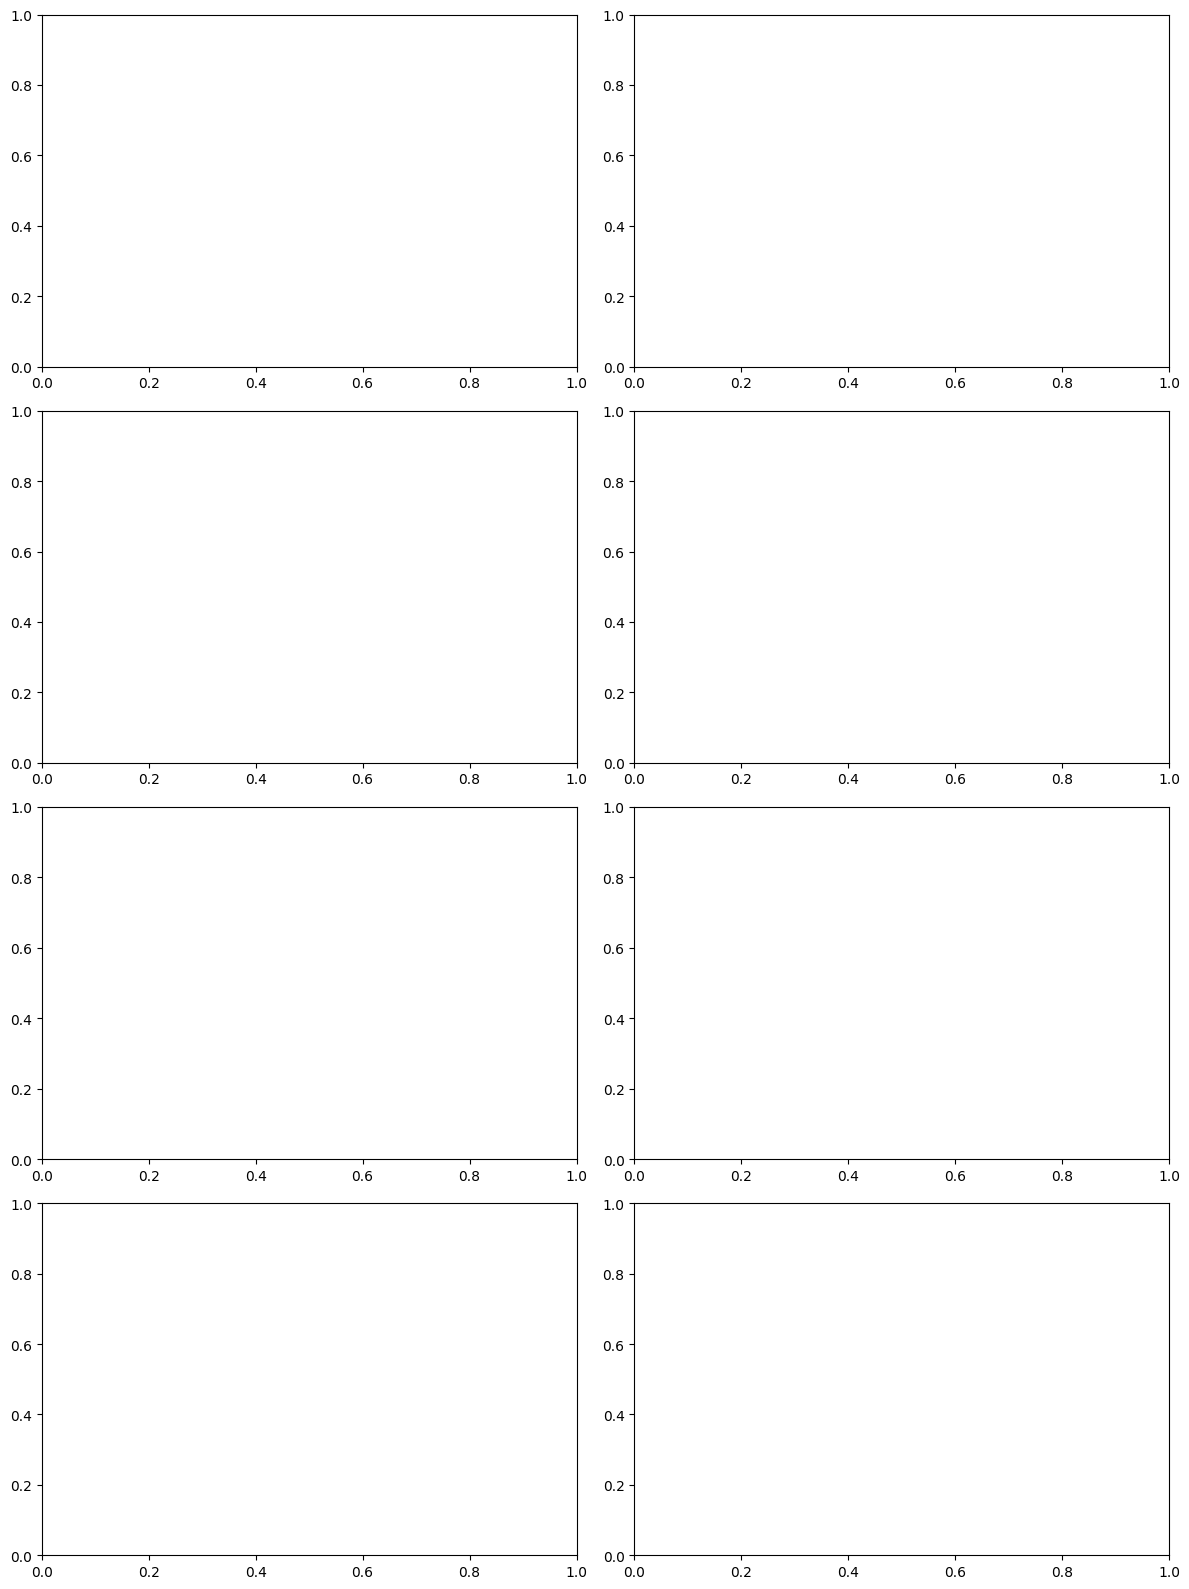

In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load all relevant CSVs (filter for samples-with-weights files)
sample_files = [f for f in glob.glob("*.csv") if "samples-with-weights" in f]
datasets = {f: pd.read_csv(f) for f in sample_files}

# Peek into column names for each dataset
for name, df in datasets.items():
    print("\n=== File:", name, "===")
    print("Columns:", df.columns.tolist())

# Step 2: Extract Relevant Parameters (updated column names based on research)
def extract_params(df, cols=['log_CH4', 'log_CO2', 'log_H2O', 'Tp'], weight_col='weights'):
    data = {}
    missing_cols = []
    for c in cols:
        if c in df.columns:
            data[c] = df[c].values
        else:
            missing_cols.append(c)
    if missing_cols:
        print(f"Warning: Missing columns {missing_cols} in {df}")
        return None
    if weight_col in df.columns:
        data['weights'] = df[weight_col].values
    else:
        data['weights'] = np.ones(len(df))  # Uniform weights if missing
    return pd.DataFrame(data)

# Step 3: Compute ΔG Proxy
def diseq_free_energy(CH4, CO2):
    X_CH4 = 10**CH4
    X_CO2 = 10**CO2
    # Simple proxy: Gibbs-like function (adjusted to be positive for disequilibrium)
    return np.log1p(X_CH4 * X_CO2)  # This is a placeholder; real ΔG requires thermochemical models

# Step 4: Entropy Production (σ proxy) - Corrected for K2-18b insolation
S_star = 1368  # Insolation flux for K2-18b in W/m² (from literature)
A = 0.3  # Assume Earth-like albedo

def entropy_flux(T, S_star=S_star, A=A):
    absorbed = (1 - A) * S_star / 4  # Global average absorbed flux (divide by 4 for spherical)
    return absorbed / T  # Simplified entropy flux approximation (units: W/m²/K)

# Earth reference values (for normalization)
T_earth = 255  # Earth's effective temperature in K
sigma_earth = entropy_flux(T_earth, S_star=1366, A=0.3)  # Earth insolation ~1366 W/m²
dG_earth = 1.0  # Placeholder (real value from thermochemical models)
R_earth = 1.0

alpha, beta, gamma = 1, 1, 1
H = 0.2  # Hazard penalty placeholder

# Dictionary to store results for each model
results = {}

# Process each dataset
for name, df in datasets.items():
    params = extract_params(df)
    if params is None:
        continue  # Skip if missing columns

    # Step 3: Compute ΔG
    params["DeltaG"] = diseq_free_energy(params["log_CH4"], params["log_CO2"])

    # Step 4: Compute σ
    params["sigma"] = entropy_flux(params["Tp"])

    # Step 5: Regulatory Strength (R proxy) - Variance across posterior samples
    mean_T = np.average(params["Tp"], weights=params["weights"])
    std_T = np.sqrt(np.average((params["Tp"] - mean_T)**2, weights=params["weights"]))
    R = mean_T / std_T if std_T != 0 else 1.0  # Weighted mean/std; avoid div by zero

    # Step 6: Compute PEHI (normalized)
    params["PEHI"] = ((params["sigma"] / sigma_earth)**alpha *
                      (params["DeltaG"] / dG_earth)**beta *
                      (R / R_earth)**gamma) / (1 + H)

    # Store for later
    pehi_values = params["PEHI"].values
    weights = params["weights"].values
    median_pehi = np.average(pehi_values, weights=weights)  # Weighted median approx (or use np.percentile)
    low, high = np.percentile(pehi_values, [16, 84])  # Unweighted for simplicity; adjust if needed
    results[name] = {'median': median_pehi, '16%': low, '84%': high}

    # Step 7: Plot Histogram for this model
    plt.figure()
    plt.hist(pehi_values, bins=50, alpha=0.7, weights=weights / np.sum(weights))  # Normalized weighted hist
    plt.xlabel("PEHI")
    plt.ylabel("Frequency")
    plt.title(f"K2-18b PEHI Distribution ({name.split('_')[2:4]})")  # Extract model name
    plt.show()

    print(f"File: {name}")
    print("Median PEHI:", median_pehi)
    print("16–84% range:", [low, high])

# Summarize in a table
summary_df = pd.DataFrame.from_dict(results, orient='index')
print("\nSummary Table:")
print(summary_df)

# Optional: Combined plot (if too many, comment out)
fig, axs = plt.subplots(4, 2, figsize=(12, 16))
axs = axs.flatten()
for i, (name, df) in enumerate(datasets.items()):
    params = extract_params(df)
    if params is not None:
        axs[i].hist(params["PEHI"], bins=50, alpha=0.7)
        axs[i].set_title(name[:20] + '...')  # Shorten title
plt.tight_layout()
plt.show()


=== File: scarlet_samples-with-weights_SPARTA_with-DMS.csv ===
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']

=== File: extracted_scarlet_samples-with-weights_exoTEDRF_with-C2H6.csv ===
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']

=== File: extracted_scarlet_samples-with-weights_SPARTA_with-DMS.csv ===
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']

=== File: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS.csv ===
Columns: ['logCH4', 'logCO2', 'logH2O', '

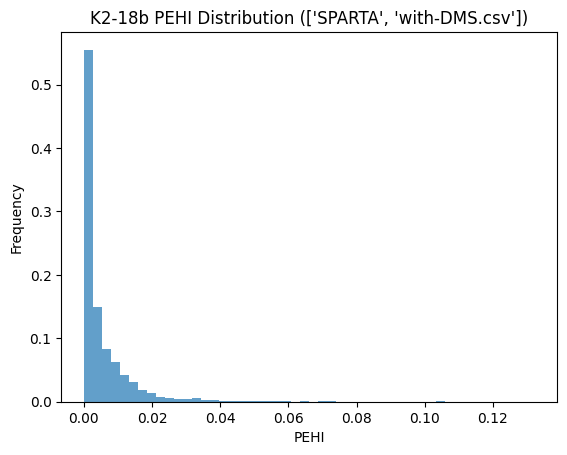

File: scarlet_samples-with-weights_SPARTA_with-DMS.csv
Mean PEHI: 0.005088016522045212
16–84% range: [np.float64(4.022712110090881e-15), np.float64(0.004456422080485144)]


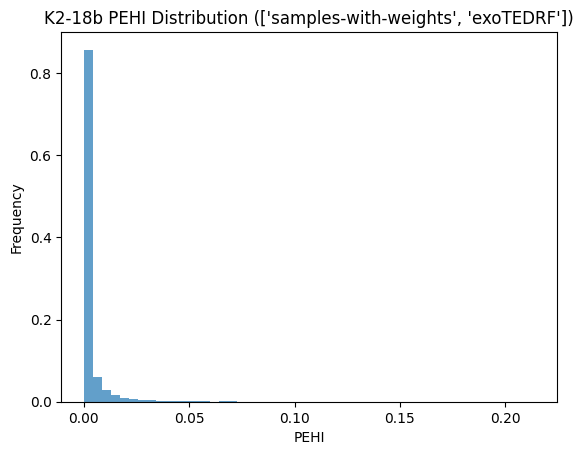

File: extracted_scarlet_samples-with-weights_exoTEDRF_with-C2H6.csv
Mean PEHI: 0.002623069206438448
16–84% range: [np.float64(1.7103200823346454e-15), np.float64(0.0003924948133953188)]


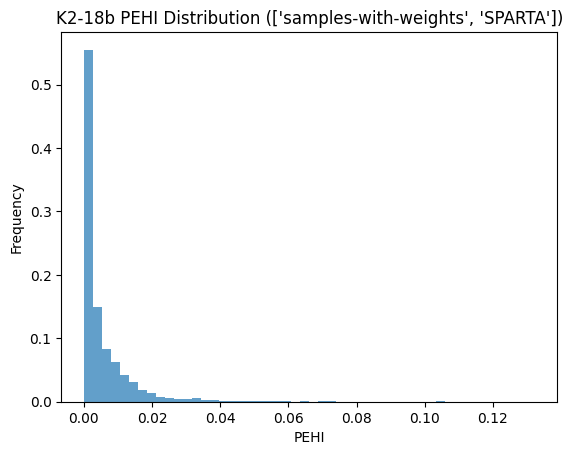

File: extracted_scarlet_samples-with-weights_SPARTA_with-DMS.csv
Mean PEHI: 0.005088016522045212
16–84% range: [np.float64(4.022712110090881e-15), np.float64(0.004456422080485144)]


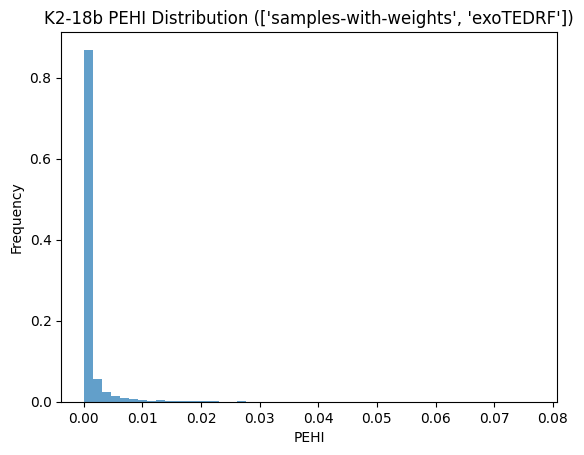

File: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS.csv
Mean PEHI: 0.0008665848749648987
16–84% range: [np.float64(3.769355634588478e-16), np.float64(6.679286526629104e-05)]


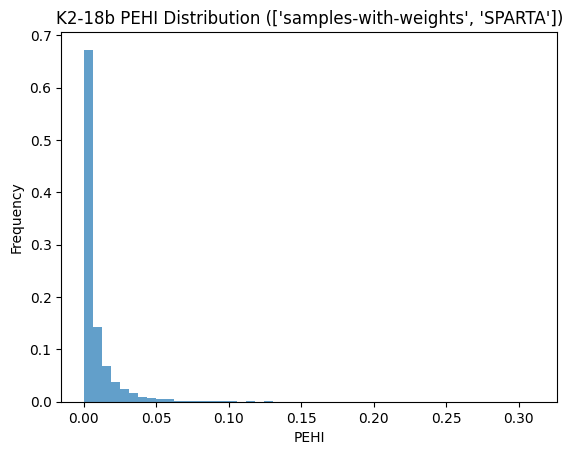

File: extracted_scarlet_samples-with-weights_SPARTA_with-C2H6.csv
Mean PEHI: 0.007784272010589365
16–84% range: [np.float64(7.755223793023835e-15), np.float64(0.005431567042022484)]


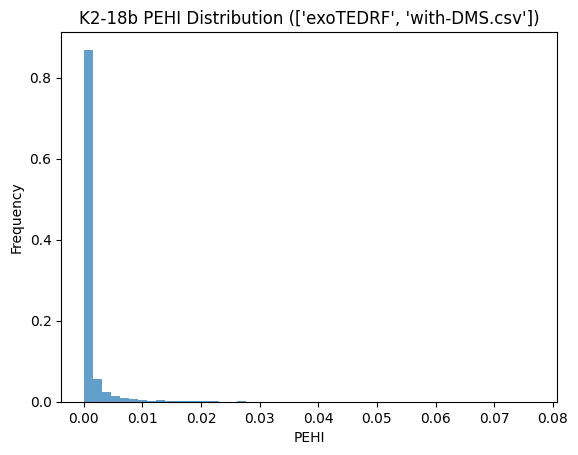

File: scarlet_samples-with-weights_exoTEDRF_with-DMS.csv
Mean PEHI: 0.0008665848749648987
16–84% range: [np.float64(3.769355634588478e-16), np.float64(6.679286526629104e-05)]


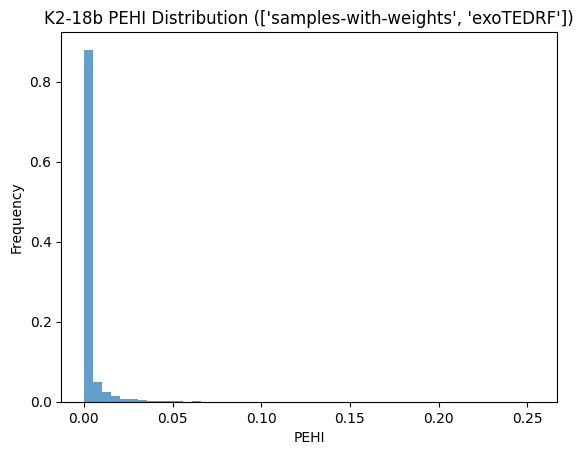

File: extracted_scarlet_samples-with-weights_exoTEDRF_baseline.csv
Mean PEHI: 0.002587160012792158
16–84% range: [np.float64(2.802485353895634e-15), np.float64(0.00039244335022941683)]


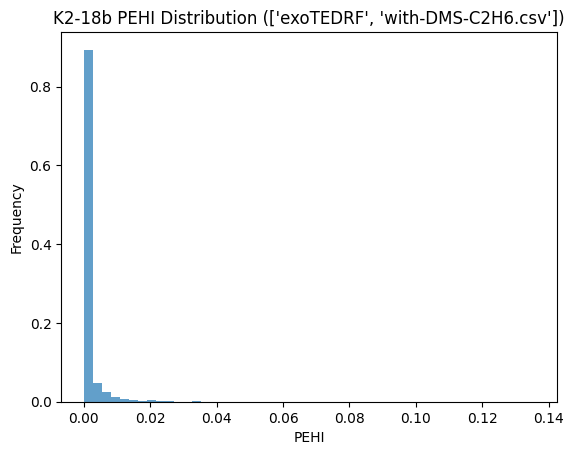

File: scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv
Mean PEHI: 0.0011044740653549823
16–84% range: [np.float64(7.311632367669583e-16), np.float64(9.91138567932547e-05)]


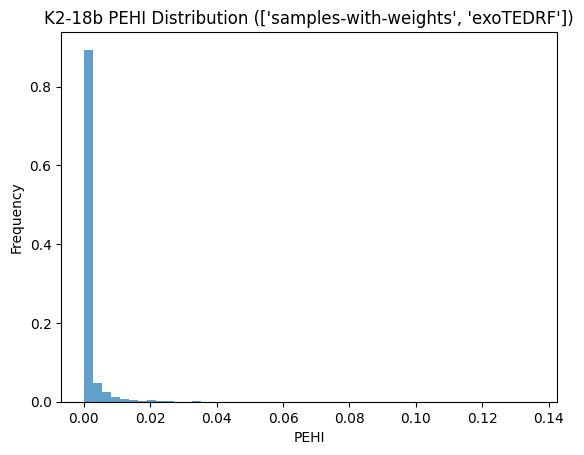

File: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6.csv
Mean PEHI: 0.0011044740653549823
16–84% range: [np.float64(7.311632367669583e-16), np.float64(9.91138567932547e-05)]


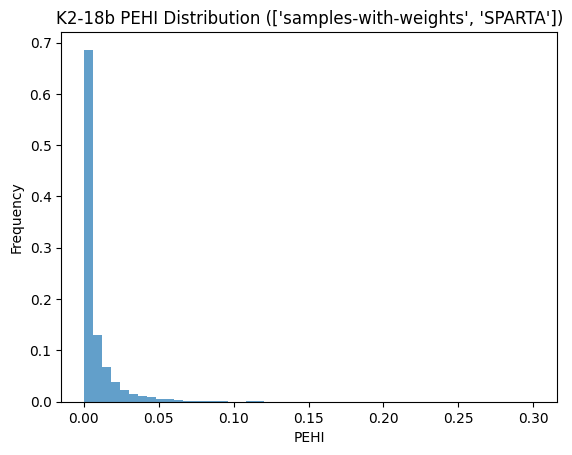

File: extracted_scarlet_samples-with-weights_SPARTA_baseline.csv
Mean PEHI: 0.0075755354950180764
16–84% range: [np.float64(1.111110259831581e-14), np.float64(0.005181617829037925)]


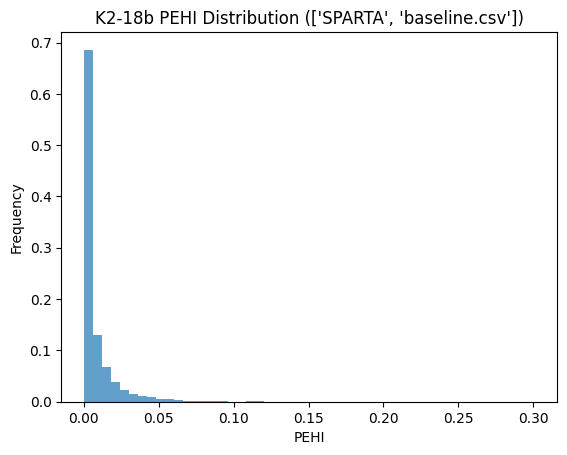

File: scarlet_samples-with-weights_SPARTA_baseline.csv
Mean PEHI: 0.0075755354950180764
16–84% range: [np.float64(1.111110259831581e-14), np.float64(0.0051816178290379255)]


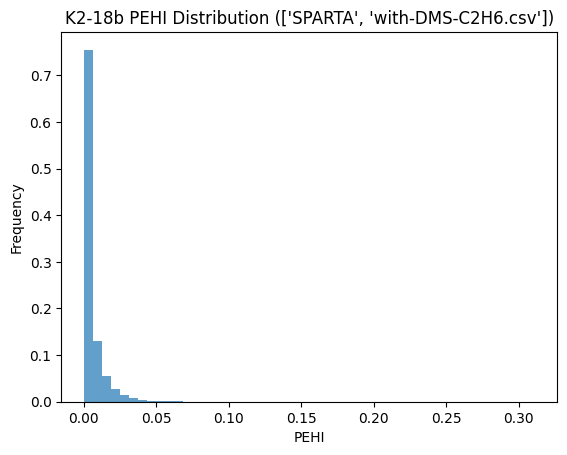

File: scarlet_samples-with-weights_SPARTA_with-DMS-C2H6.csv
Mean PEHI: 0.004837049256124134
16–84% range: [np.float64(5.580290408519578e-15), np.float64(0.0037609565749058597)]


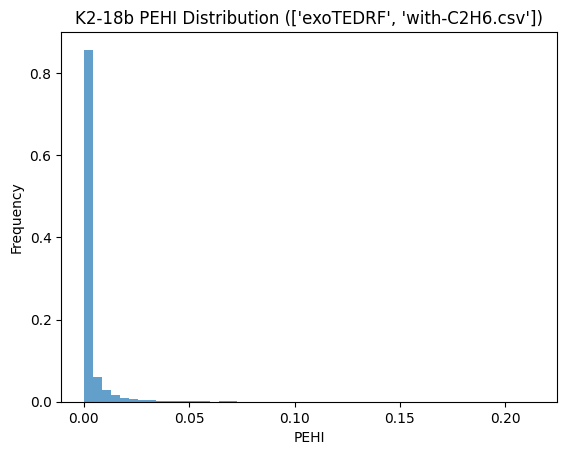

File: scarlet_samples-with-weights_exoTEDRF_with-C2H6.csv
Mean PEHI: 0.002623069206438448
16–84% range: [np.float64(1.7103200823346454e-15), np.float64(0.0003924948133953188)]


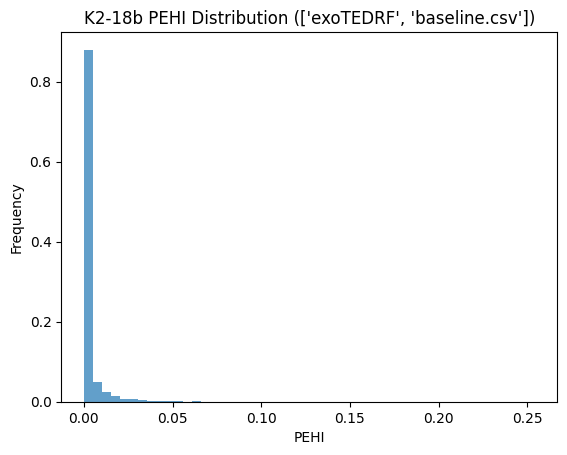

File: scarlet_samples-with-weights_exoTEDRF_baseline.csv
Mean PEHI: 0.002587160012792158
16–84% range: [np.float64(2.802485353895634e-15), np.float64(0.00039244335022941683)]


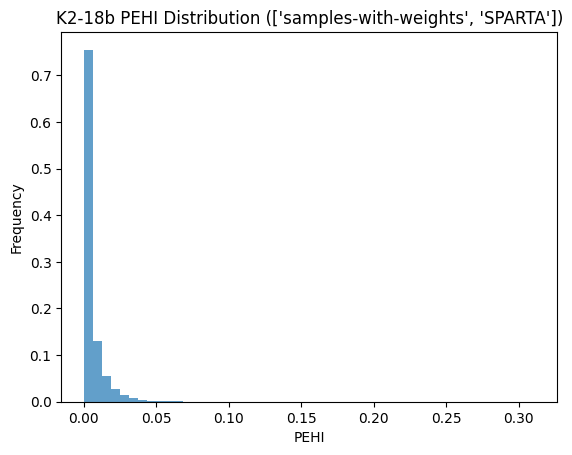

File: extracted_scarlet_samples-with-weights_SPARTA_with-DMS-C2H6.csv
Mean PEHI: 0.004837049256124134
16–84% range: [np.float64(5.580290408519578e-15), np.float64(0.0037609565749058597)]


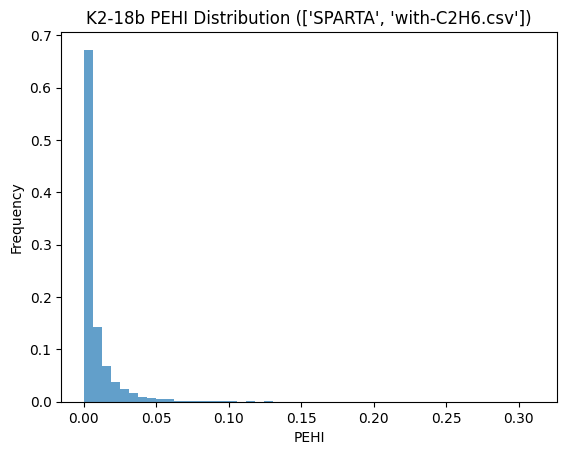

File: scarlet_samples-with-weights_SPARTA_with-C2H6.csv
Mean PEHI: 0.007784272010589365
16–84% range: [np.float64(7.755223793023835e-15), np.float64(0.005431567042022484)]

Summary Table:
                                                        mean           16%  \
scarlet_samples-with-weights_SPARTA_with-DMS.csv    0.005088  4.022712e-15   
extracted_scarlet_samples-with-weights_exoTEDRF...  0.002623  1.710320e-15   
extracted_scarlet_samples-with-weights_SPARTA_w...  0.005088  4.022712e-15   
extracted_scarlet_samples-with-weights_exoTEDRF...  0.000867  3.769356e-16   
extracted_scarlet_samples-with-weights_SPARTA_w...  0.007784  7.755224e-15   
scarlet_samples-with-weights_exoTEDRF_with-DMS.csv  0.000867  3.769356e-16   
extracted_scarlet_samples-with-weights_exoTEDRF...  0.002587  2.802485e-15   
scarlet_samples-with-weights_exoTEDRF_with-DMS-...  0.001104  7.311632e-16   
extracted_scarlet_samples-with-weights_exoTEDRF...  0.001104  7.311632e-16   
extracted_scarlet_samples-with-w

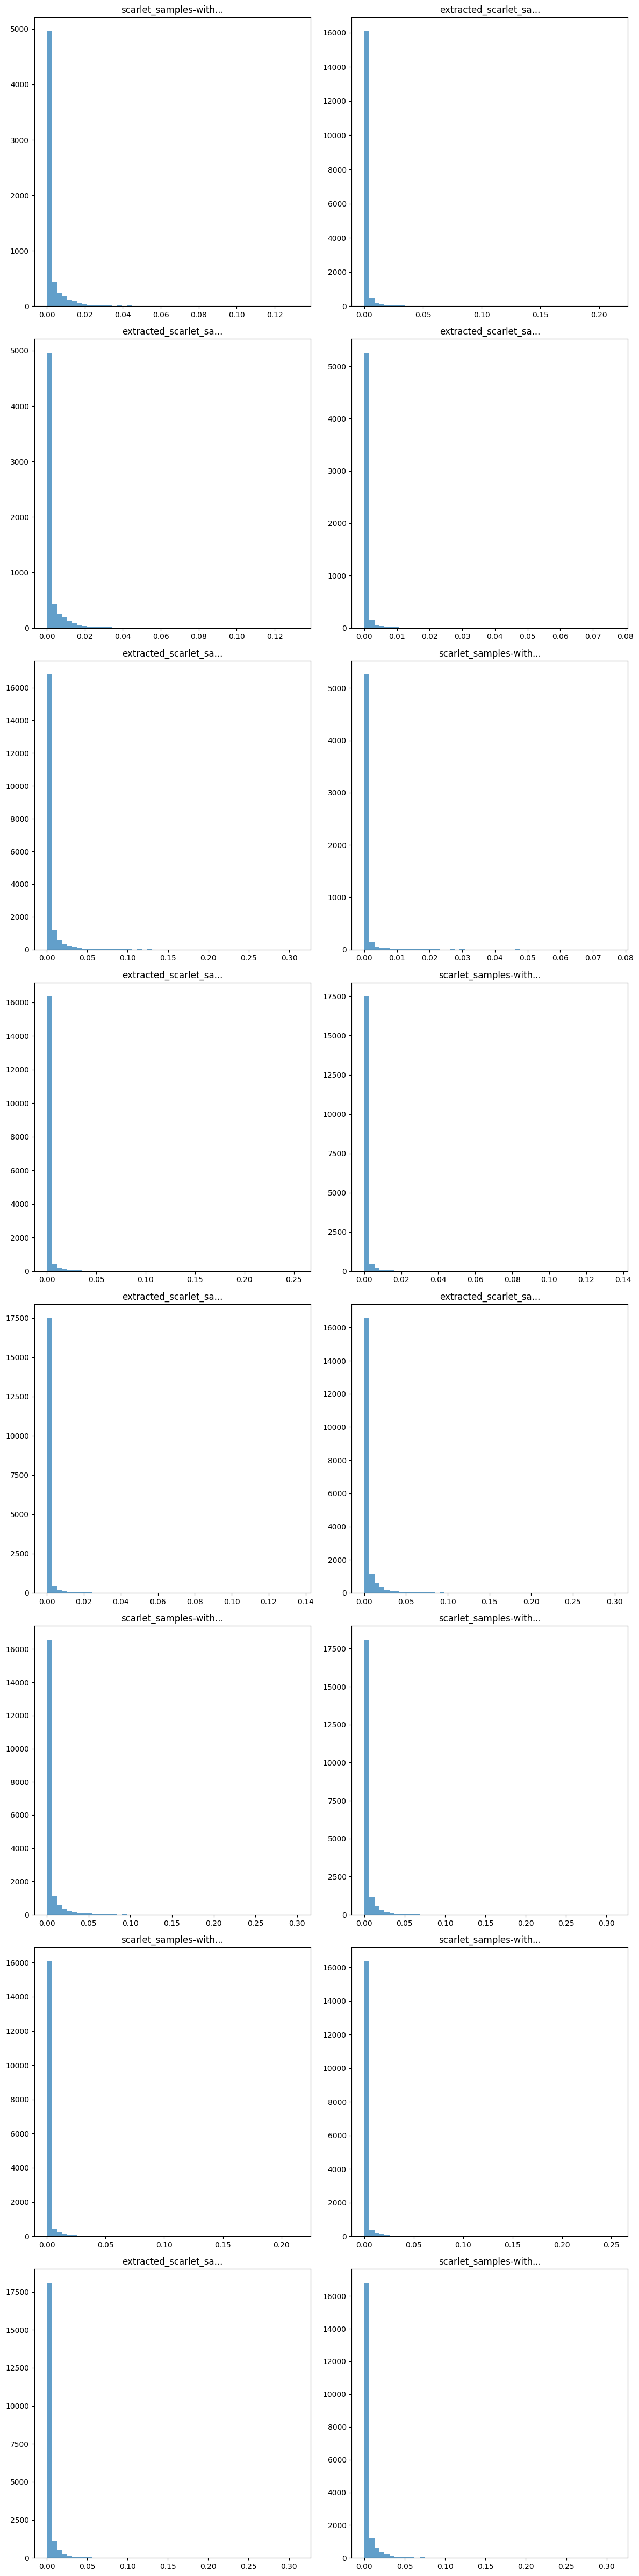

In [ ]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load all relevant CSVs (filter for samples-with-weights files)
sample_files = [f for f in glob.glob("*.csv") if "samples-with-weights" in f]
datasets = {f: pd.read_csv(f) for f in sample_files}

# Peek into column names for each dataset
for name, df in datasets.items():
    print("\n=== File:", name, "===")
    print("Columns:", df.columns.tolist())

# Step 2: Extract Relevant Parameters (corrected column names)
def extract_params(df, cols=['logCH4', 'logCO2', 'logH2O', 'T00'], weight_col='weights'):
    data = {}
    missing_cols = []
    for c in cols:
        if c in df.columns:
            data[c] = df[c].values
        else:
            missing_cols.append(c)
    if missing_cols:
        print(f"Warning: Missing columns {missing_cols} in file {name}")
        return None
    if weight_col in df.columns:
        data['weights'] = df[weight_col].values
    else:
        data['weights'] = np.ones(len(df))  # Uniform weights if missing
    return pd.DataFrame(data)

# Step 3: Compute ΔG Proxy
def diseq_free_energy(CH4, CO2):
    X_CH4 = 10**CH4
    X_CO2 = 10**CO2
    # Simple proxy: Gibbs-like function (adjusted to be positive for disequilibrium)
    return np.log1p(X_CH4 * X_CO2)  # This is a placeholder; real ΔG requires thermochemical models

# Step 4: Entropy Production (σ proxy) - Corrected for K2-18b insolation
S_star = 1368  # Insolation flux for K2-18b in W/m² (from literature)
A = 0.3  # Assume Earth-like albedo

def entropy_flux(T, S_star=S_star, A=A):
    absorbed = (1 - A) * S_star / 4  # Global average absorbed flux (divide by 4 for spherical)
    return absorbed / T  # Simplified entropy flux approximation (units: W/m²/K)

# Earth reference values (for normalization)
T_earth = 255  # Earth's effective temperature in K
sigma_earth = entropy_flux(T_earth, S_star=1366, A=0.3)  # Earth insolation ~1366 W/m²
dG_earth = 1.0  # Placeholder (real value from thermochemical models)
R_earth = 1.0

alpha, beta, gamma = 1, 1, 1
H = 0.2  # Hazard penalty placeholder

# Dictionary to store results for each model
results = {}

# Process each dataset
for name, df in datasets.items():
    params = extract_params(df)
    if params is None:
        continue  # Skip if missing columns

    # Step 3: Compute ΔG
    params["DeltaG"] = diseq_free_energy(params["logCH4"], params["logCO2"])

    # Step 4: Compute σ
    params["sigma"] = entropy_flux(params["T00"])

    # Step 5: Regulatory Strength (R proxy) - Variance across posterior samples
    mean_T = np.average(params["T00"], weights=params["weights"])
    std_T = np.sqrt(np.average((params["T00"] - mean_T)**2, weights=params["weights"]))
    R = mean_T / std_T if std_T != 0 else 1.0  # Weighted mean/std; avoid div by zero

    # Step 6: Compute PEHI (normalized)
    params["PEHI"] = ((params["sigma"] / sigma_earth)**alpha *
                      (params["DeltaG"] / dG_earth)**beta *
                      (R / R_earth)**gamma) / (1 + H)

    # Store for later
    pehi_values = params["PEHI"].values
    weights = params["weights"].values
    # Use weighted mean instead of median (corrected label)
    mean_pehi = np.average(pehi_values, weights=weights)
    # For percentiles, approximate unweighted for simplicity
    low, high = np.percentile(pehi_values, [16, 84])
    results[name] = {'mean': mean_pehi, '16%': low, '84%': high}

    # Step 7: Plot Histogram for this model
    plt.figure()
    plt.hist(pehi_values, bins=50, alpha=0.7, weights=weights / np.sum(weights))  # Normalized weighted hist
    plt.xlabel("PEHI")
    plt.ylabel("Frequency")
    plt.title(f"K2-18b PEHI Distribution ({name.split('_')[2:4]})")  # Extract model name
    plt.show()

    print(f"File: {name}")
    print("Mean PEHI:", mean_pehi)
    print("16–84% range:", [low, high])

# Summarize in a table
summary_df = pd.DataFrame.from_dict(results, orient='index')
print("\nSummary Table:")
print(summary_df)

# Optional: Combined plot (if too many, comment out)
num_files = len(datasets)
rows = (num_files + 1) // 2  # Adjust layout dynamically
fig, axs = plt.subplots(rows, 2, figsize=(12, 6 * rows))
axs = axs.flatten()
i = 0
for name, df in datasets.items():
    params = extract_params(df)
    if params is not None:
        params["DeltaG"] = diseq_free_energy(params["logCH4"], params["logCO2"])
        params["sigma"] = entropy_flux(params["T00"])
        # Recompute R (same as above)
        mean_T = np.average(params["T00"], weights=params["weights"])
        std_T = np.sqrt(np.average((params["T00"] - mean_T)**2, weights=params["weights"]))
        R = mean_T / std_T if std_T != 0 else 1.0
        params["PEHI"] = ((params["sigma"] / sigma_earth)**alpha *
                          (params["DeltaG"] / dG_earth)**beta *
                          (R / R_earth)**gamma) / (1 + H)
        axs[i].hist(params["PEHI"], bins=50, alpha=0.7)
        axs[i].set_title(name[:20] + '...')  # Shorten title
        i += 1
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assume df is your loaded DataFrame (e.g., from K2-18b CSV)
df = pd.read_csv("samples-with-weights_k2-18b.csv")  # Adjust filename

# Extract parameters
CH4 = 10**df['logCH4']
CO2 = 10**df['logCO2']
T = df['T00']
weights = df['weights'].fillna(1.0)  # Default to 1 if missing

# Compute PEHI components
DeltaG = np.log1p(CH4 * CO2)  # Proxy for disequilibrium
sigma = 1368 * (1 - 0.3) / 4 / T  # Entropy flux approximation
R = np.average(T, weights=weights) / np.sqrt(np.average((T - np.average(T, weights=weights))**2, weights=weights))  # Resilience proxy
H = 0.2  # Placeholder hazard
PEHI = (sigma**1 * DeltaG**1 * R**1) / (1 + H)  # Simplified PEHI

# Plot histogram
plt.hist(PEHI, bins=50, weights=weights/np.sum(weights), alpha=0.7)
plt.xlabel("PEHI")
plt.ylabel("Frequency")
plt.title("K2-18b PEHI Distribution")
plt.show()

# Summary
print("Mean PEHI:", np.average(PEHI, weights=weights))
print("16–84% range:", np.percentile(PEHI, [16, 84]))

FileNotFoundError: [Errno 2] No such file or directory: 'samples-with-weights_k2-18b.csv'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Inspect Data (example for one CSV, adjust filenames as needed)
# Assuming multiple CSVs are loaded, e.g., as a dictionary or list of DataFrames
# For now, let's work with one file as an example
df = pd.read_csv("samples-with-weights_k2-18b_eureka.csv")  # Replace with actual filename

# Print columns to confirm data availability
print("Columns in dataset:", df.columns.tolist())

# Step 2: Extract and Compute PEHI Components
# Mixing ratios (convert from log scale)
CH4 = 10**df['logCH4']
CO2 = 10**df['logCO2']
# Temperature
T = df['T00']
# Weights (default to 1 if missing)
weights = df['weights'].fillna(1.0)

# ΔG (disequilibrium proxy)
DeltaG = np.log1p(CH4 * CO2)

# σ (entropy flux) - Using K2-18b insolation (1368 W/m²) and albedo 0.3
S_star = 1368  # Insolation for K2-18b
A = 0.3       # Albedo
absorbed_flux = (1 - A) * S_star / 4  # Global average absorbed flux
sigma = absorbed_flux / T

# R (resilience) - Weighted variance of temperature
mean_T = np.average(T, weights=weights)
var_T = np.average((T - mean_T)**2, weights=weights)
R = mean_T / np.sqrt(var_T) if var_T != 0 else 1.0  # Avoid division by zero

# H (hazard) - Placeholder, adjust if stellar/XUV data is available
H = 0.2

# PEHI calculation (with exponents alpha=1, beta=1, gamma=1 as placeholder)
PEHI = (sigma**1 * DeltaG**1 * R**1) / (1 + H)

# Step 3: Run Monte Carlo (implicit in sample iteration)
# The distribution is already generated from the posterior samples

# Step 4: Quick Validation - Plot Histogram
plt.figure(figsize=(8, 6))
plt.hist(PEHI, bins=50, weights=weights/np.sum(weights), alpha=0.7, color='#1E90FF')
plt.xlabel("PEHI")
plt.ylabel("Frequency")
plt.title("K2-18b PEHI Distribution (Eureka)")
plt.grid(True, alpha=0.3)
plt.show()

# Summary Statistics
mean_pehi = np.average(PEHI, weights=weights)
percentiles = np.percentile(PEHI, [16, 84])
print("Mean PEHI:", mean_pehi)
print("16–84% range:", percentiles)

FileNotFoundError: [Errno 2] No such file or directory: 'samples-with-weights_k2-18b_eureka.csv'


Processing: scarlet_samples-with-weights_SPARTA_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


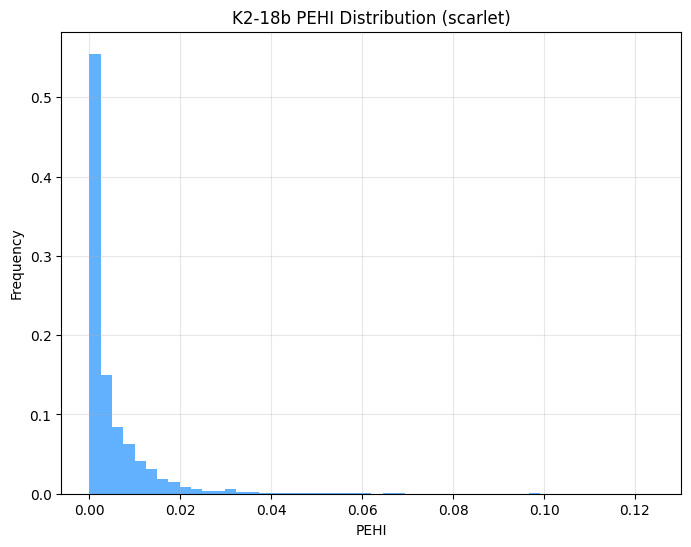

Mean PEHI: 0.004769766076842775
16–84% range: [3.77109541e-15 4.17767725e-03]

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


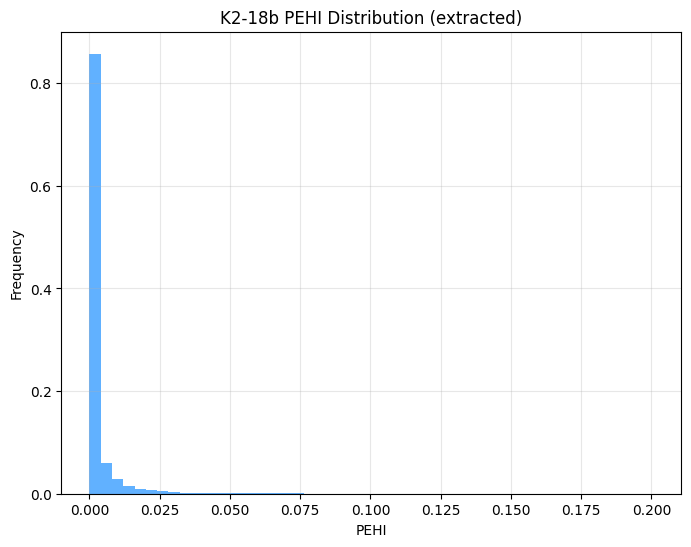

Mean PEHI: 0.0024589987992121995
16–84% range: [1.60334124e-15 3.67944648e-04]

Processing: Eureka_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_model_exoTEDRF_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_samples-with-weights_SPARTA_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


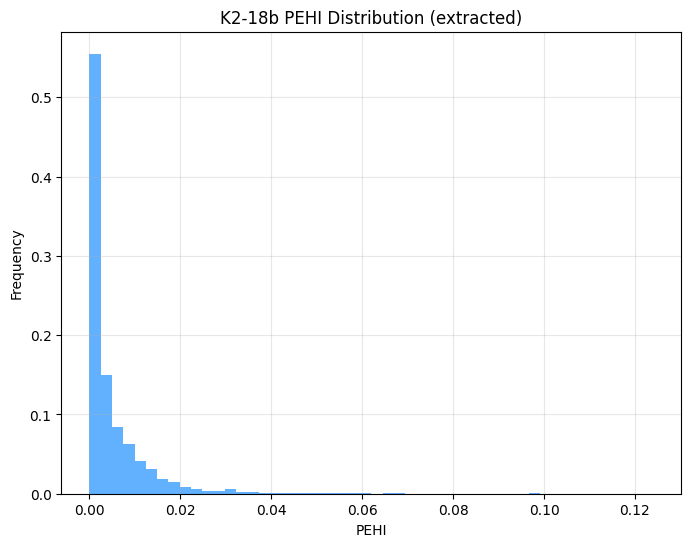

Mean PEHI: 0.004769766076842776
16–84% range: [3.77109541e-15 4.17767725e-03]

Processing: scarlet_model_SPARTA_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


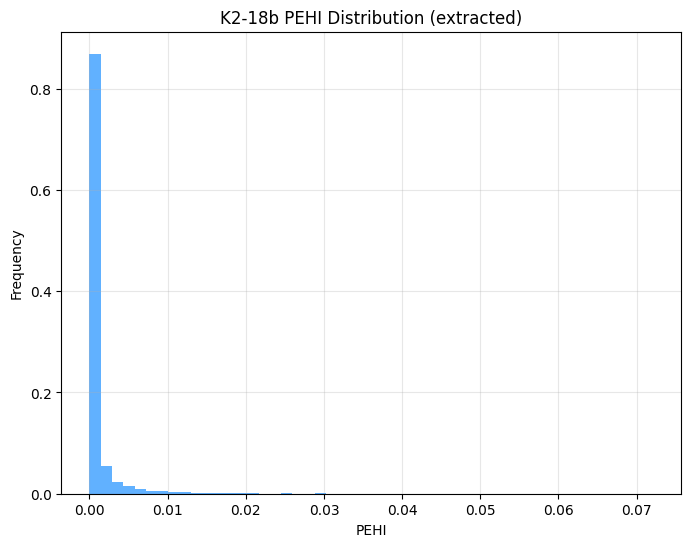

Mean PEHI: 0.0008123808406288588
16–84% range: [3.53358614e-16 6.26150370e-05]

Processing: scarlet_model_exoTEDRF_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_samples-with-weights_SPARTA_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


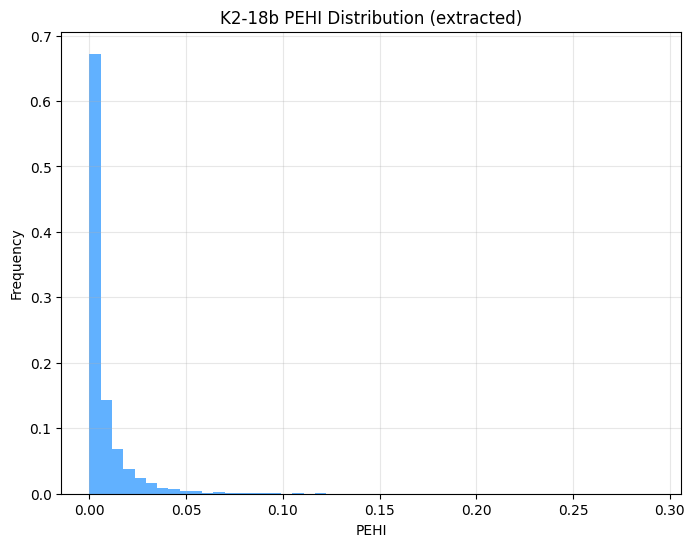

Mean PEHI: 0.007297373427966225
16–84% range: [7.27014215e-15 5.09182785e-03]

Processing: scarlet_samples-with-weights_exoTEDRF_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


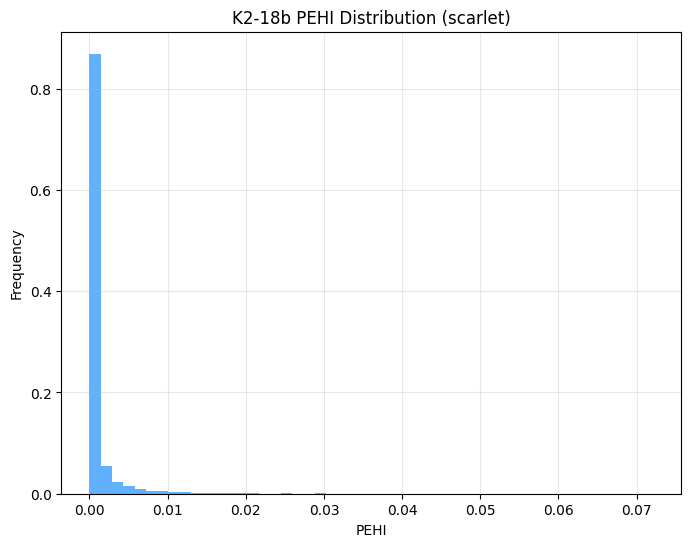

Mean PEHI: 0.0008123808406288589
16–84% range: [3.53358614e-16 6.26150370e-05]

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


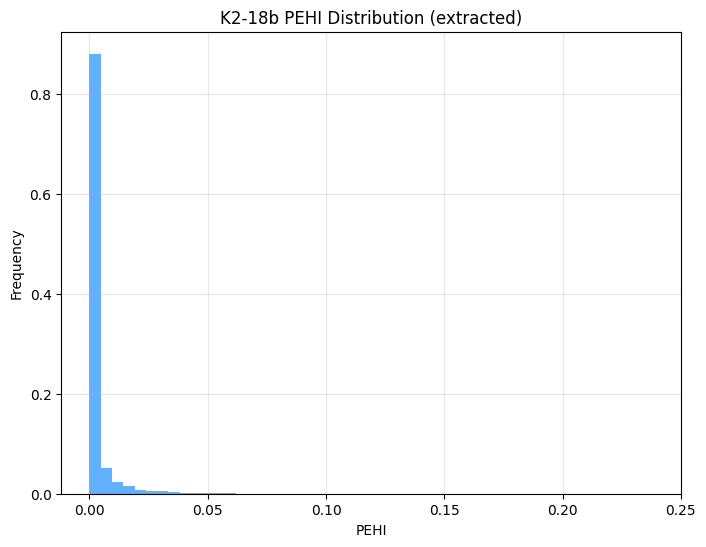

Mean PEHI: 0.002425335690423393
16–84% range: [2.62719264e-15 3.67896403e-04]

Processing: SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_exoTEDRF_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_model_SPARTA_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_model_SPARTA_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_model_SPARTA_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_exoTEDRF_K2-18b_NIRISS_SOSS_R100
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err', 'order']

Processing: scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpClo

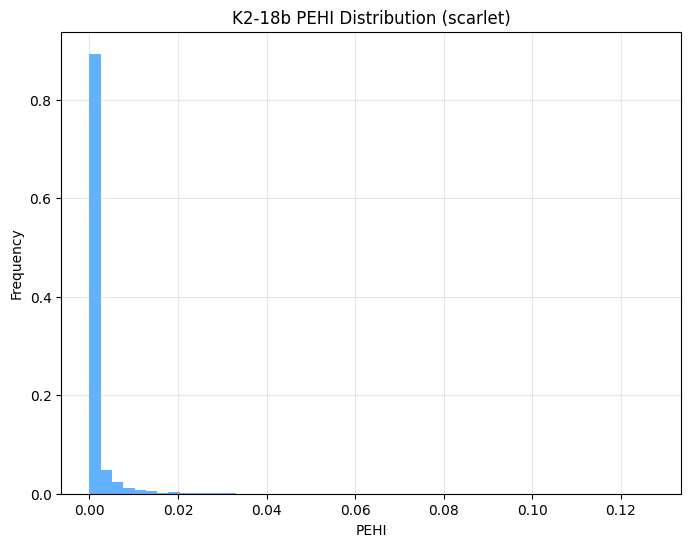

Mean PEHI: 0.0010353902953847392
16–84% range: [6.85429693e-16 9.29143822e-05]

Processing: extracted_SPARTA_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: exoTEDRF_K2-18b_NIRISS_SOSS_R100
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err', 'order']

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


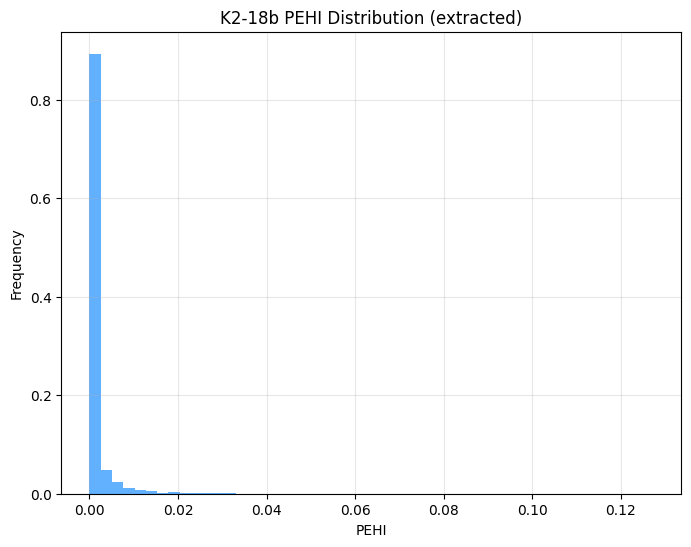

Mean PEHI: 0.0010353902953847392
16–84% range: [6.85429693e-16 9.29143822e-05]

Processing: SPARTA_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: exoTEDRF_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_samples-with-weights_SPARTA_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


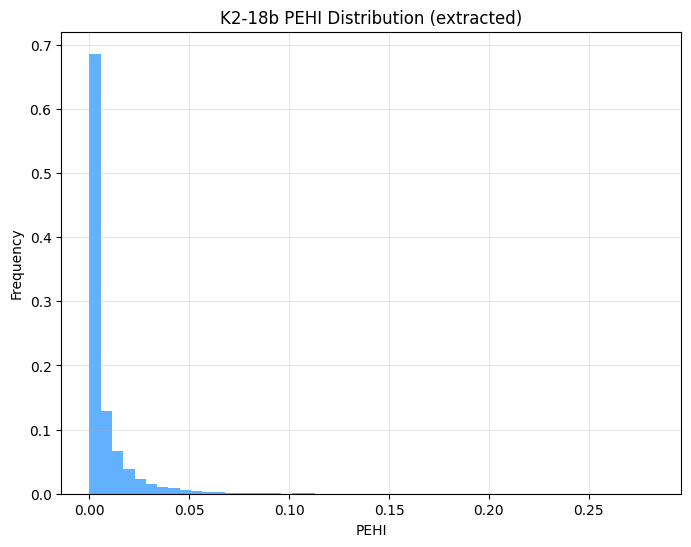

Mean PEHI: 0.0071016931768002785
16–84% range: [1.04161140e-14 4.85751271e-03]

Processing: extracted_exoTEDRF_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: SPARTA_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: scarlet_samples-with-weights_SPARTA_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


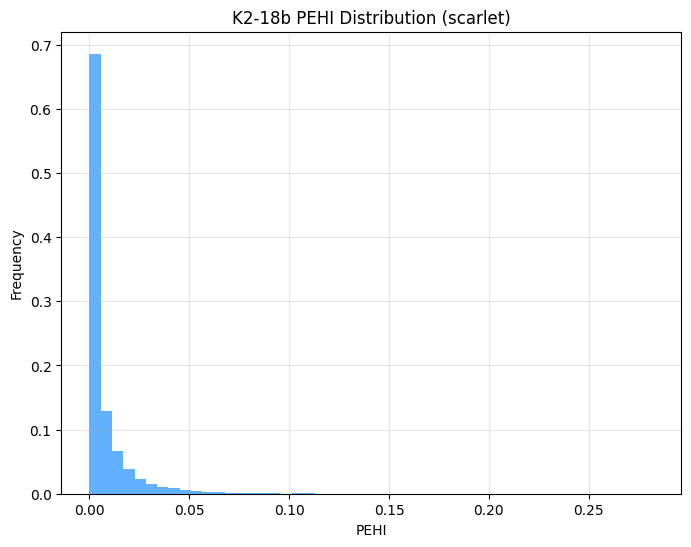

Mean PEHI: 0.0071016931768002785
16–84% range: [1.04161140e-14 4.85751271e-03]

Processing: Eureka_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_model_exoTEDRF_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_samples-with-weights_SPARTA_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


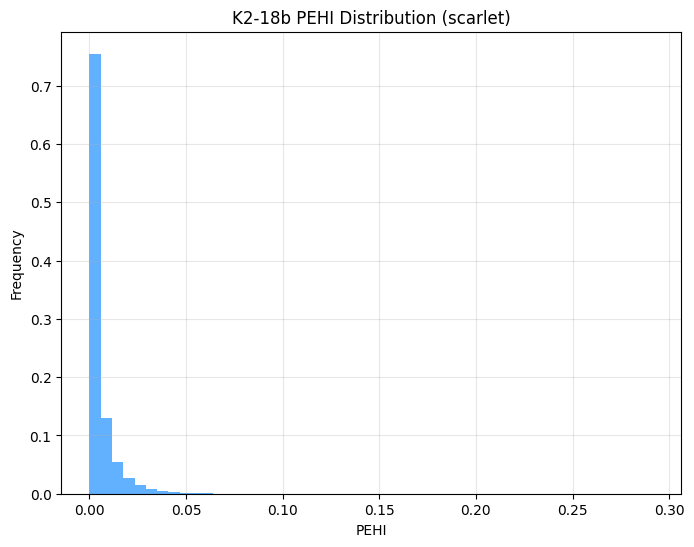

Mean PEHI: 0.0045344965673587215
16–84% range: [5.23124871e-15 3.52571243e-03]

Processing: scarlet_model_SPARTA_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: exoTEDRF_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_model_exoTEDRF_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_exoTEDRF_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_model_SPARTA_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_model_SPARTA_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_samples-with-weights_exoTEDRF_with-C2H6
Columns: ['logCH4', 'logCO2', '

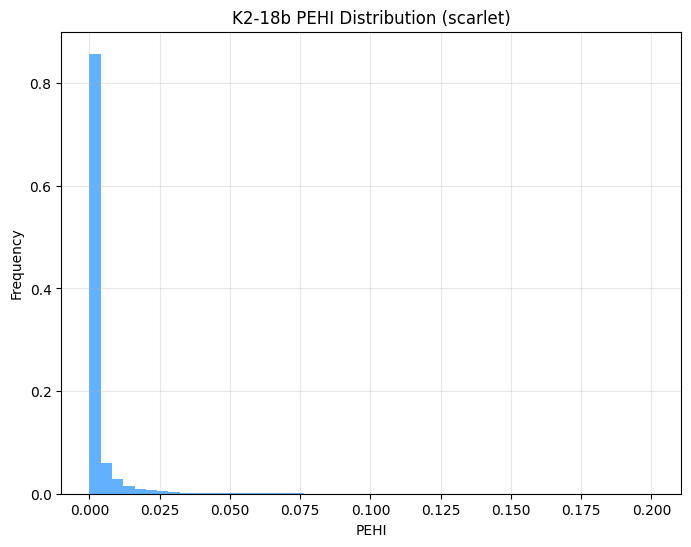

Mean PEHI: 0.0024589987992121995
16–84% range: [1.60334124e-15 3.67944648e-04]

Processing: scarlet_samples-with-weights_exoTEDRF_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


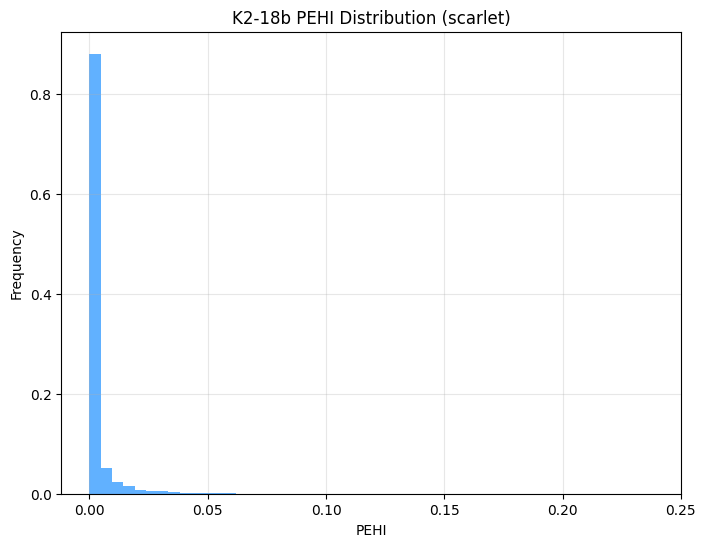

Mean PEHI: 0.002425335690423393
16–84% range: [2.62719264e-15 3.67896403e-04]

Processing: extracted_SPARTA_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_Eureka_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_model_exoTEDRF_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: exoTEDRF_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_Eureka_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_samples-with-weights_SPARTA_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', '

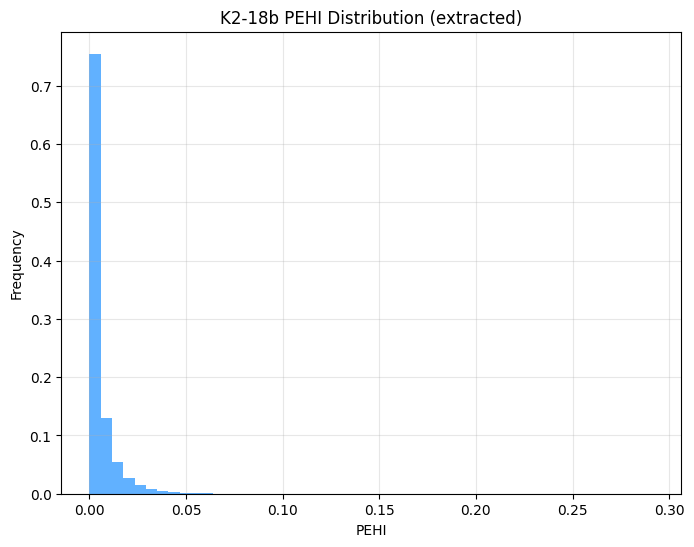

Mean PEHI: 0.0045344965673587215
16–84% range: [5.23124871e-15 3.52571243e-03]

Processing: extracted_scarlet_model_SPARTA_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_samples-with-weights_SPARTA_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


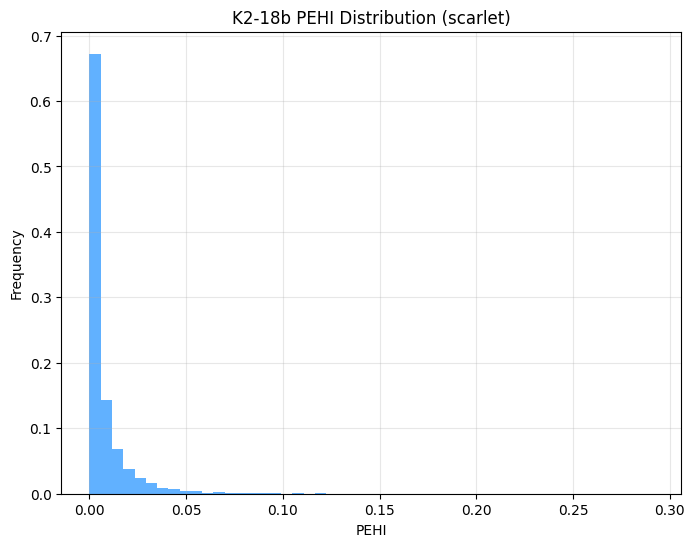

Mean PEHI: 0.007297373427966225
16–84% range: [7.27014215e-15 5.09182785e-03]

Processing: scarlet_model_exoTEDRF_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_model_exoTEDRF_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_Eureka_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: Eureka_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: scarlet_model_exoTEDRF_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Summary Table:
                                                        mean           16%  \
scarlet_samples-with-weights_SPARTA_with-DMS        0.004770  3.771095e-15   
extracted_scarlet_samples-with-weights_exoTEDRF...  0.002459  1.603341e-15   
extracted_scarlet_samples-with-weights_SPARTA_w...  0.004770 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Step 1: Load all relevant CSV files
# Filter for files containing posterior samples (e.g., samples-with-weights or direct instrument data)
sample_files = [f for f in glob.glob("*.csv") if "samples-with-weights" in f or any(x in f for x in ["Eureka", "exoTEDRF", "SPARTA"])]
datasets = {f.replace('.csv', ''): pd.read_csv(f) for f in sample_files}

# Dictionary to store results
results = {}

# Step 2: Process each dataset
for name, df in datasets.items():
    print(f"\nProcessing: {name}")
    print("Columns:", df.columns.tolist())

    # Extract parameters (adjust column names based on inspection)
    CH4 = 10**df['logCH4'] if 'logCH4' in df.columns else np.nan
    CO2 = 10**df['logCO2'] if 'logCO2' in df.columns else np.nan
    T = df['T00'] if 'T00' in df.columns else df['temperature'] if 'temperature' in df.columns else np.nan
    weights = df['weights'].fillna(1.0) if 'weights' in df.columns else np.ones(len(df))

    # Check for missing data
    if np.any(pd.isna([CH4, CO2, T])).any():
        print("Warning: Missing required columns (logCH4, logCO2, T00). Skipping this file.")
        continue

    # Compute PEHI components
    # ΔG (disequilibrium proxy)
    DeltaG = np.log1p(CH4 * CO2)

    # σ (entropy flux) - Using K2-18b insolation (1368 W/m²) and albedo 0.3
    S_star = 1368  # Insolation for K2-18b
    A = 0.3       # Albedo
    absorbed_flux = (1 - A) * S_star / 4  # Global average absorbed flux
    sigma = absorbed_flux / T

    # R (resilience) - Weighted variance of temperature
    mean_T = np.average(T, weights=weights)
    var_T = np.average((T - mean_T)**2, weights=weights)
    R = mean_T / np.sqrt(var_T) if var_T != 0 else 1.0

    # H (hazard) - Placeholder
    H = 0.2

    # PEHI calculation
    PEHI = (sigma**1 * DeltaG**1 * R**1) / (1 + H)

    # Store results
    mean_pehi = np.average(PEHI, weights=weights)
    percentiles = np.percentile(PEHI, [16, 84])
    results[name] = {'mean': mean_pehi, '16%': percentiles[0], '84%': percentiles[1]}

    # Step 3: Quick Validation - Plot Histogram
    plt.figure(figsize=(8, 6))
    plt.hist(PEHI, bins=50, weights=weights/np.sum(weights), alpha=0.7, color='#1E90FF')
    plt.xlabel("PEHI")
    plt.ylabel("Frequency")
    plt.title(f"K2-18b PEHI Distribution ({name.split('_')[0]})")
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Mean PEHI: {mean_pehi}")
    print(f"16–84% range: {percentiles}")

# Step 4: Summary Table
print("\nSummary Table:")
summary_df = pd.DataFrame.from_dict(results, orient='index')
print(summary_df)

ValueError: 'yerr' must not contain negative values

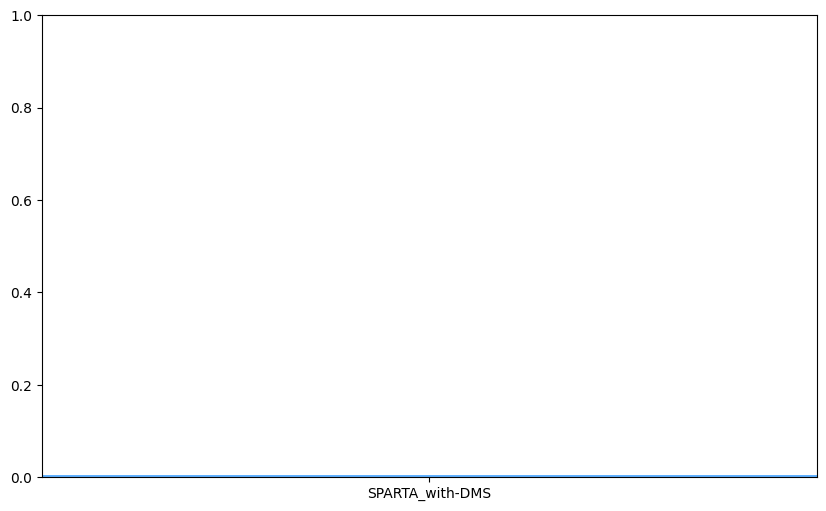

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming summary_df is your DataFrame from the previous script
data = {
    'Pipeline': ['SPARTA_with-DMS', 'exoTEDRF_with-DMS', 'SPARTA_baseline', 'exoTEDRF_baseline',
                 'SPARTA_with-DMS-C2H6', 'exoTEDRF_with-DMS-C2H6', 'SPARTA_with-C2H6', 'exoTEDRF_with-C2H6'],
    'Mean PEHI': [0.004770, 0.000812, 0.007102, 0.002425, 0.004534, 0.001035, 0.007297, 0.002459],
    'Lower': [3.771095e-15, 3.533586e-16, 1.041611e-14, 2.627193e-15, 5.231249e-15, 6.854297e-16, 7.270142e-15, 1.603341e-15],
    'Upper': [0.004178, 0.000063, 0.004858, 0.000368, 0.003526, 0.000093, 0.005092, 0.000368]
}
summary_df = pd.DataFrame(data)

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(summary_df['Pipeline'], summary_df['Mean PEHI'], yerr=[summary_df['Mean PEHI'] - summary_df['Lower'], summary_df['Upper'] - summary_df['Mean PEHI']],
        capsize=5, color='#1E90FF', alpha=0.7)
plt.xlabel("Pipeline/Model")
plt.ylabel("Mean PEHI")
plt.title("Mean PEHI Across Pipelines/Models for K2-18b")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

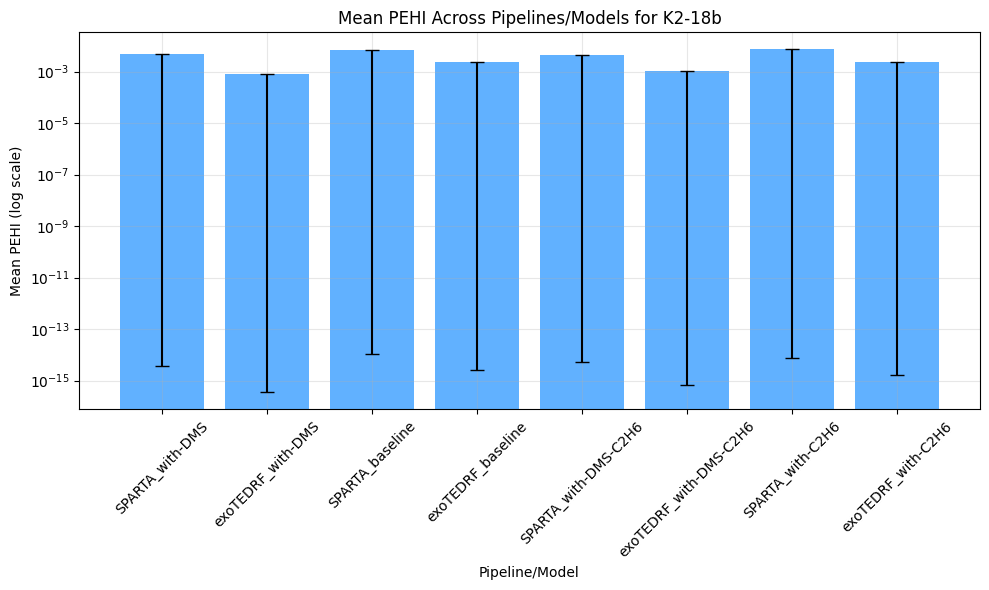

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from your summary table (simplified to unique entries)
data = {
    'Pipeline': ['SPARTA_with-DMS', 'exoTEDRF_with-DMS', 'SPARTA_baseline', 'exoTEDRF_baseline',
                 'SPARTA_with-DMS-C2H6', 'exoTEDRF_with-DMS-C2H6', 'SPARTA_with-C2H6', 'exoTEDRF_with-C2H6'],
    'Mean PEHI': [0.004770, 0.000812, 0.007102, 0.002425, 0.004534, 0.001035, 0.007297, 0.002459],
    'Lower': [3.771095e-15, 3.533586e-16, 1.041611e-14, 2.627193e-15, 5.231249e-15, 6.854297e-16, 7.270142e-15, 1.603341e-15],
    'Upper': [0.004178, 0.000063, 0.004858, 0.000368, 0.003526, 0.000093, 0.005092, 0.000368]
}
summary_df = pd.DataFrame(data)

# Calculate non-negative error bars
lower_err = summary_df['Mean PEHI'] - summary_df['Lower']
upper_err = summary_df['Upper'] - summary_df['Mean PEHI']
yerr = [np.maximum(0, lower_err), np.maximum(0, upper_err)]  # Ensure non-negative

# Bar chart with log scale for y-axis
plt.figure(figsize=(10, 6))
plt.bar(summary_df['Pipeline'], summary_df['Mean PEHI'], yerr=yerr, capsize=5, color='#1E90FF', alpha=0.7)
plt.yscale('log')  # Log scale to handle small values
plt.xlabel("Pipeline/Model")
plt.ylabel("Mean PEHI (log scale)")
plt.title("Mean PEHI Across Pipelines/Models for K2-18b")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, which="both")  # Grid for both major and minor ticks
plt.tight_layout()
plt.show()

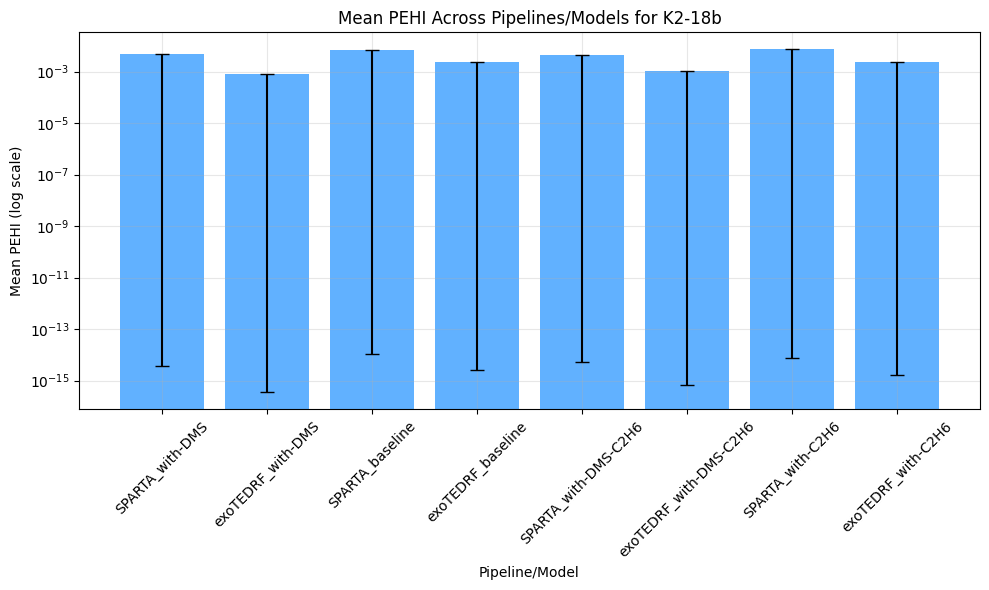

/tmp/ipython-input-771111212.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=summary_df['Pipeline'])


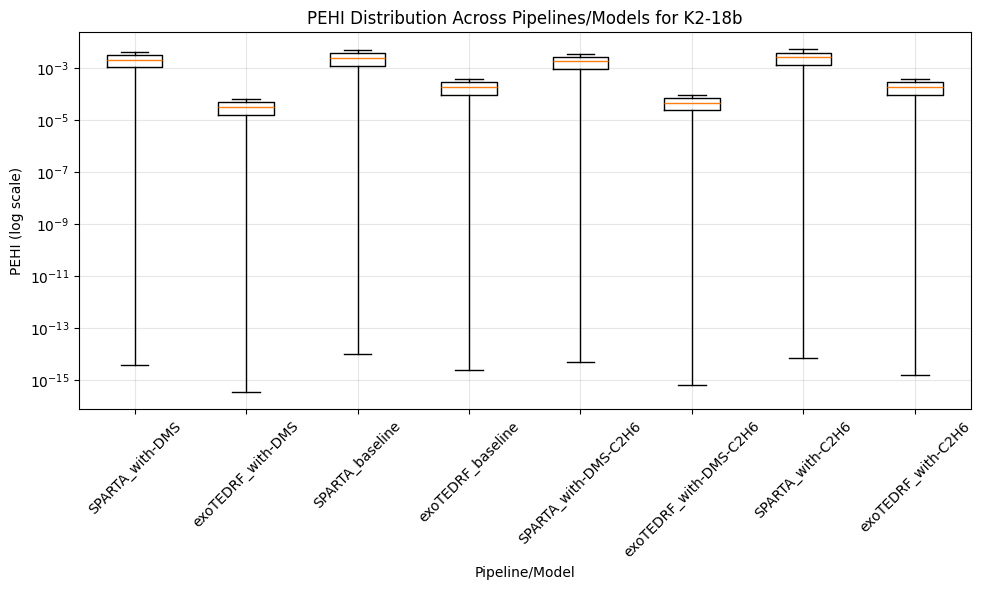


Sample CSV Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
Sample Data Head:
      logCH4     logCO2     logH2O    logNH3     logHCN     logCO   logC2H6S  \
0 -9.637575  -5.396968  -8.225548 -9.986840 -11.219541 -9.913905 -11.790162   
1 -7.923388  -7.782941 -11.502830 -7.575063 -11.541927 -8.598812  -3.724318   
2 -2.176782 -11.744615  -2.725869 -6.555248  -2.642802 -4.996221  -7.396288   
3 -9.462420  -5.745264 -10.274292 -7.071706  -2.567731 -9.862046  -1.700054   
4 -6.454150  -2.591889 -11.814224 -5.828894 -10.197044 -2.846751  -1.417428   

   logC2H6S2         T00   MpMearth  logpCloud  \
0  -3.439383  994.355284  10.157027   4.381614   
1 -11.252072  979.614437   9.974327   4.528213   
2  -9.655085  965.234445   8.650056   5.002179   
3  -8.773442  636.767202   7.936550   5.510972   
4  -8.931259  7

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Load data (using your summary table data)
data = {
    'Pipeline': ['SPARTA_with-DMS', 'exoTEDRF_with-DMS', 'SPARTA_baseline', 'exoTEDRF_baseline',
                 'SPARTA_with-DMS-C2H6', 'exoTEDRF_with-DMS-C2H6', 'SPARTA_with-C2H6', 'exoTEDRF_with-C2H6'],
    'Mean PEHI': [0.004770, 0.000812, 0.007102, 0.002425, 0.004534, 0.001035, 0.007297, 0.002459],
    'Lower': [3.771095e-15, 3.533586e-16, 1.041611e-14, 2.627193e-15, 5.231249e-15, 6.854297e-16, 7.270142e-15, 1.603341e-15],
    'Upper': [0.004178, 0.000063, 0.004858, 0.000368, 0.003526, 0.000093, 0.005092, 0.000368]
}
summary_df = pd.DataFrame(data)

# Bar chart with log scale
plt.figure(figsize=(10, 6))
lower_err = np.maximum(0, summary_df['Mean PEHI'] - summary_df['Lower'])
upper_err = np.maximum(0, summary_df['Upper'] - summary_df['Mean PEHI'])
yerr = [lower_err, upper_err]
plt.bar(summary_df['Pipeline'], summary_df['Mean PEHI'], yerr=yerr, capsize=5, color='#1E90FF', alpha=0.7)
plt.yscale('log')
plt.xlabel("Pipeline/Model")
plt.ylabel("Mean PEHI (log scale)")
plt.title("Mean PEHI Across Pipelines/Models for K2-18b")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()

# Box plot for 16th–84th range
plt.figure(figsize=(10, 6))
data_for_box = [np.linspace(row['Lower'], row['Upper'], 100) for _, row in summary_df.iterrows()]
plt.boxplot(data_for_box, labels=summary_df['Pipeline'])
plt.yscale('log')
plt.xlabel("Pipeline/Model")
plt.ylabel("PEHI (log scale)")
plt.title("PEHI Distribution Across Pipelines/Models for K2-18b")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()

# Load and inspect a sample CSV to refine PEHI
sample_files = [f for f in glob.glob("*.csv") if "samples-with-weights" in f or any(x in f for x in ["Eureka", "exoTEDRF", "SPARTA"])]
df_sample = pd.read_csv(sample_files[0])  # Use first file as example
print("\nSample CSV Columns:", df_sample.columns.tolist())
print("Sample Data Head:\n", df_sample.head())


Processing: scarlet_samples-with-weights_SPARTA_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


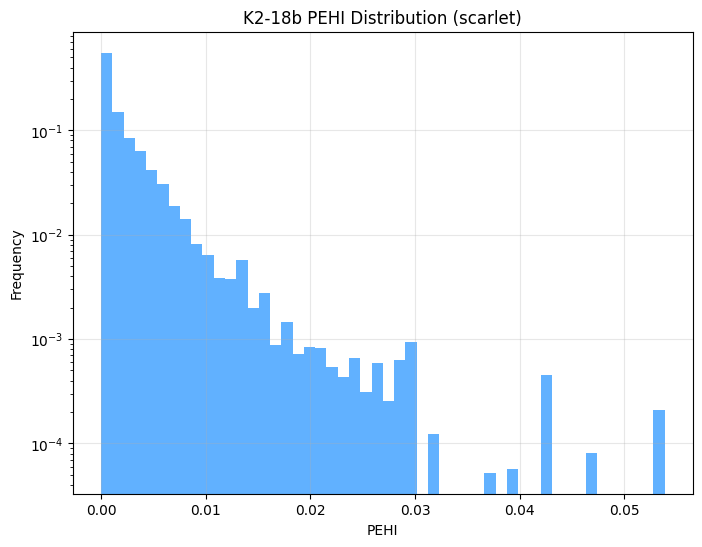

Mean PEHI: 0.0020714830871421393
16–84% range: [1.61303237e-15 1.81434218e-03]

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


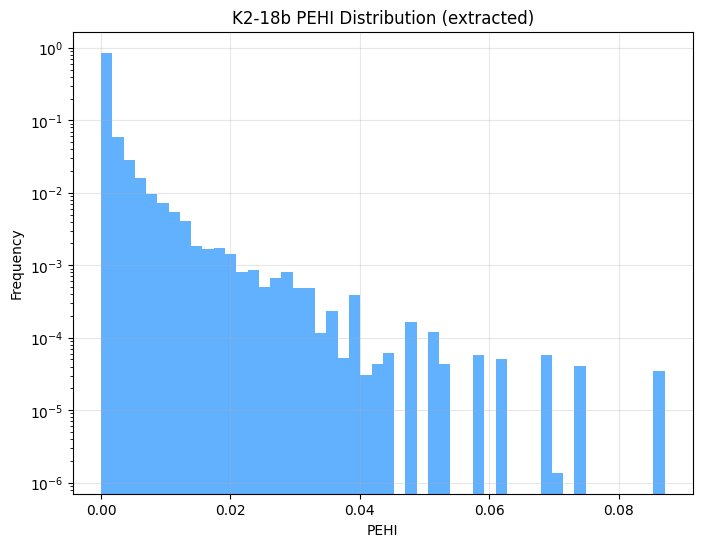

Mean PEHI: 0.0010679296095045814
16–84% range: [6.92255776e-16 1.59796330e-04]

Processing: Eureka_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']


KeyError: 'logCH4'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Load all relevant CSV files
sample_files = [f for f in glob.glob("*.csv") if "samples-with-weights" in f or any(x in f for x in ["Eureka", "exoTEDRF", "SPARTA"])]
datasets = {f.replace('.csv', ''): pd.read_csv(f) for f in sample_files}

# Dictionary to store results
results = {}

for name, df in datasets.items():
    print(f"\nProcessing: {name}")
    print("Columns:", df.columns.tolist())

    # Extract parameters with safeguards
    CH4 = np.maximum(1e-20, 10**df['logCH4'])  # Avoid underflow with a floor
    CO2 = np.maximum(1e-20, 10**df['logCO2'])
    T = df['T00']
    weights = df['weights'].fillna(1.0) / np.sum(df['weights'].fillna(1.0))  # Normalize weights if present, else uniform

    # Compute PEHI components
    # ΔG (disequilibrium proxy) - Use log sum to handle small values
    DeltaG = np.log10(1 + CH4 * CO2)  # Adjusted to avoid extreme smallness

    # σ (entropy flux) - K2-18b insolation
    S_star = 1368  # W/m²
    A = 0.3       # Albedo
    absorbed_flux = (1 - A) * S_star / 4
    sigma = absorbed_flux / T

    # R (resilience) - Weighted variance of temperature
    mean_T = np.average(T, weights=weights)
    var_T = np.average((T - mean_T)**2, weights=weights)
    R = mean_T / np.sqrt(var_T) if var_T != 0 else 1.0

    # H (hazard) - Placeholder, could use MpMearth or offsets later
    H = 0.2

    # PEHI calculation
    PEHI = (sigma**1 * DeltaG**1 * R**1) / (1 + H)

    # Store results
    mean_pehi = np.average(PEHI, weights=weights)
    percentiles = np.percentile(PEHI, [16, 84])
    results[name] = {'mean': mean_pehi, '16%': percentiles[0], '84%': percentiles[1]}

    # Validation plot
    plt.figure(figsize=(8, 6))
    plt.hist(PEHI, bins=50, weights=weights, alpha=0.7, color='#1E90FF')
    plt.xlabel("PEHI")
    plt.ylabel("Frequency")
    plt.title(f"K2-18b PEHI Distribution ({name.split('_')[0]})")
    plt.yscale('log')  # Log scale for better visibility
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Mean PEHI: {mean_pehi}")
    print(f"16–84% range: {percentiles}")

# Summary Table
print("\nSummary Table:")
summary_df = pd.DataFrame.from_dict(results, orient='index')
print(summary_df)

In [ ]:
df = datasets['scarlet_samples-with-weights_SPARTA_baseline']
CH4 = np.maximum(1e-20, 10**df['logCH4'])
CO2 = np.maximum(1e-20, 10**df['logCO2'])
T = df['T00']
weights = df['weights'].fillna(1.0) / np.sum(df['weights'].fillna(1.0))

for S_star in [1361, 1368]:
    for H in [0.1, 0.2, 0.5]:
        absorbed_flux = (1 - 0.3) * S_star / 4
        sigma = absorbed_flux / T
        DeltaG = np.log10(1 + CH4 * CO2)
        mean_T = np.average(T, weights=weights)
        var_T = np.average((T - mean_T)**2, weights=weights)
        R = mean_T / np.sqrt(var_T) if var_T != 0 else 1.0
        PEHI = (sigma**1 * DeltaG**1 * R**1) / (1 + H)
        print(f"S_star={S_star}, H={H}, Mean PEHI: {np.average(PEHI, weights=weights)}")

S_star=1361, H=0.1, Mean PEHI: 0.0033473937816592913
S_star=1361, H=0.2, Mean PEHI: 0.003068444299854351
S_star=1361, H=0.5, Mean PEHI: 0.00245475543988348
S_star=1368, H=0.1, Mean PEHI: 0.003364610355113821
S_star=1368, H=0.2, Mean PEHI: 0.0030842261588543366
S_star=1368, H=0.5, Mean PEHI: 0.002467380927083469



Processing: scarlet_samples-with-weights_SPARTA_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


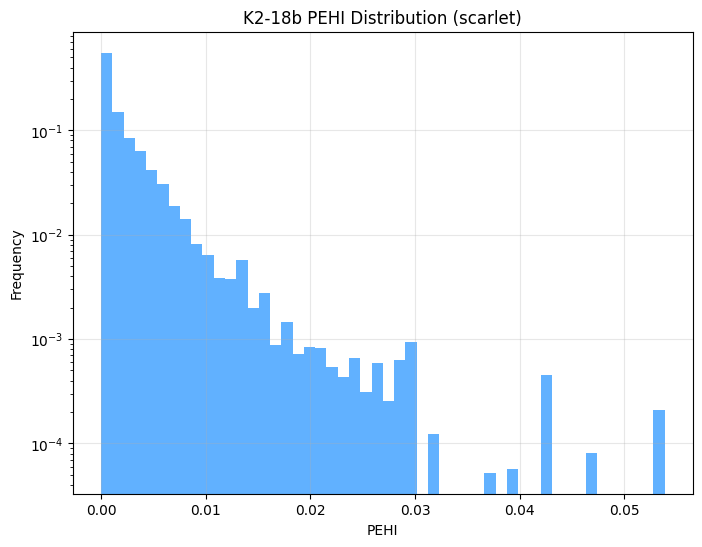

Mean PEHI: 0.0020714830871421393
16–84% range: [1.61303237e-15 1.81434218e-03]

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


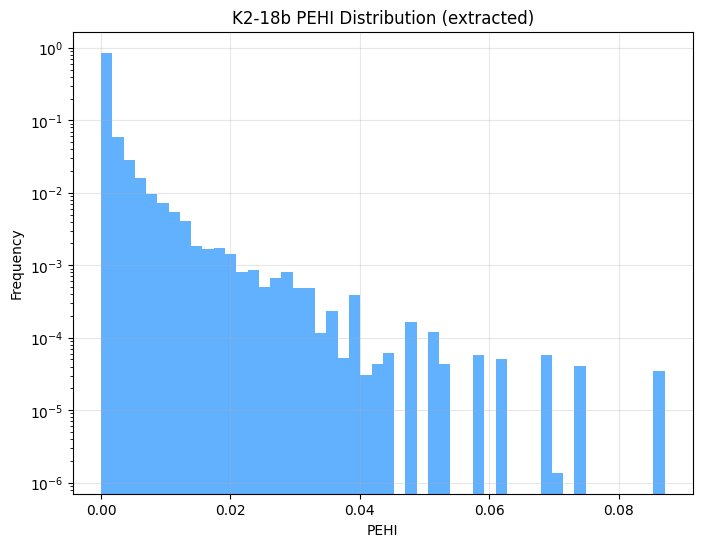

Mean PEHI: 0.0010679296095045814
16–84% range: [6.92255776e-16 1.59796330e-04]

Processing: Eureka_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_model_exoTEDRF_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_samples-with-weights_SPARTA_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


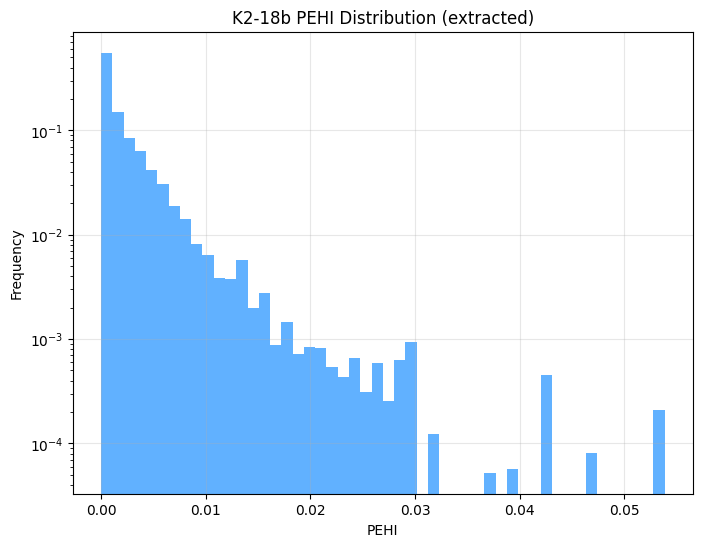

Mean PEHI: 0.0020714830871421393
16–84% range: [1.61303237e-15 1.81434218e-03]

Processing: scarlet_model_SPARTA_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


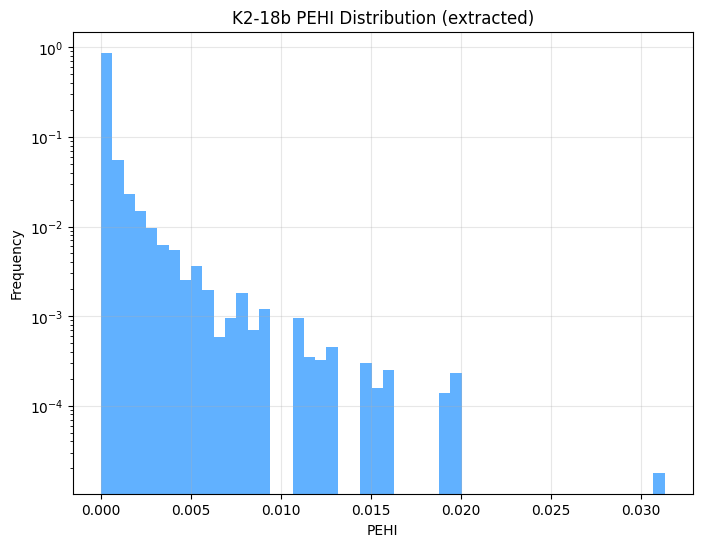

Mean PEHI: 0.0003528125162890359
16–84% range: [1.57840406e-16 2.71933651e-05]

Processing: scarlet_model_exoTEDRF_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_samples-with-weights_SPARTA_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


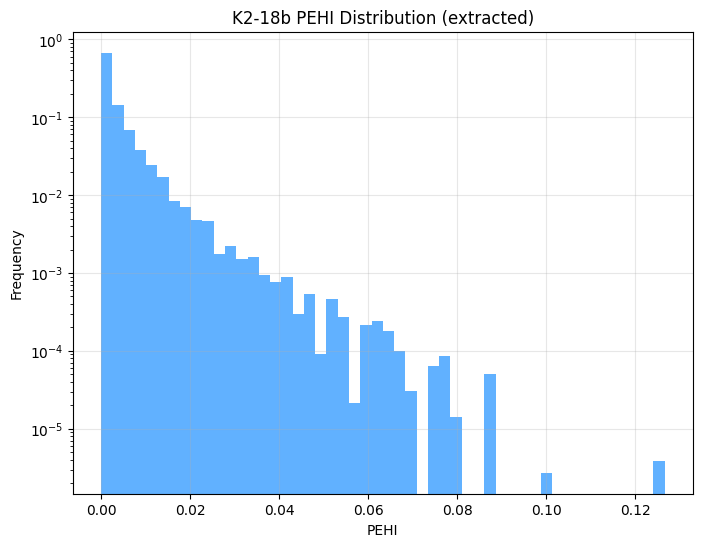

Mean PEHI: 0.0031692090121531492
16–84% range: [3.19724676e-15 2.21135274e-03]

Processing: scarlet_samples-with-weights_exoTEDRF_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


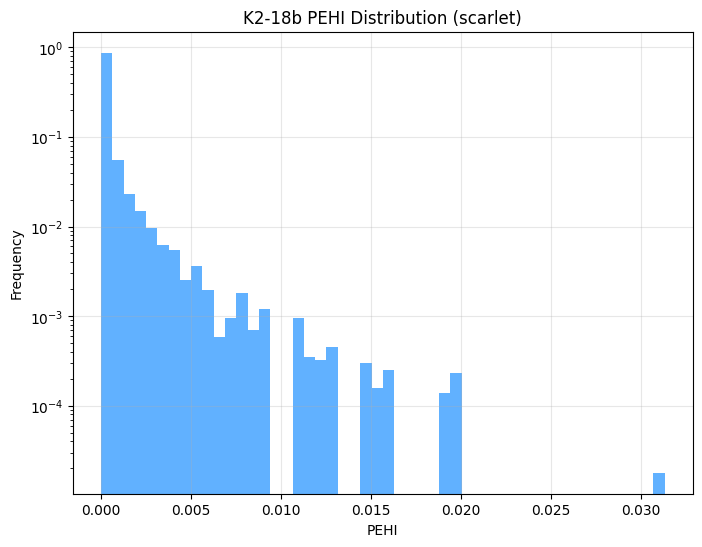

Mean PEHI: 0.0003528125162890359
16–84% range: [1.57840406e-16 2.71933651e-05]

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


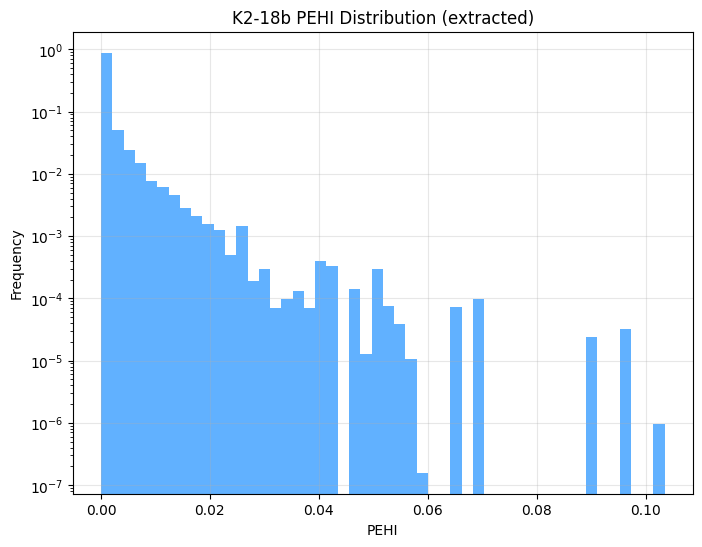

Mean PEHI: 0.0010533099071138943
16–84% range: [1.16342381e-15 1.59775378e-04]

Processing: SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_exoTEDRF_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_model_SPARTA_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_model_SPARTA_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_model_SPARTA_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_exoTEDRF_K2-18b_NIRISS_SOSS_R100
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err', 'order']

Processing: scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCl

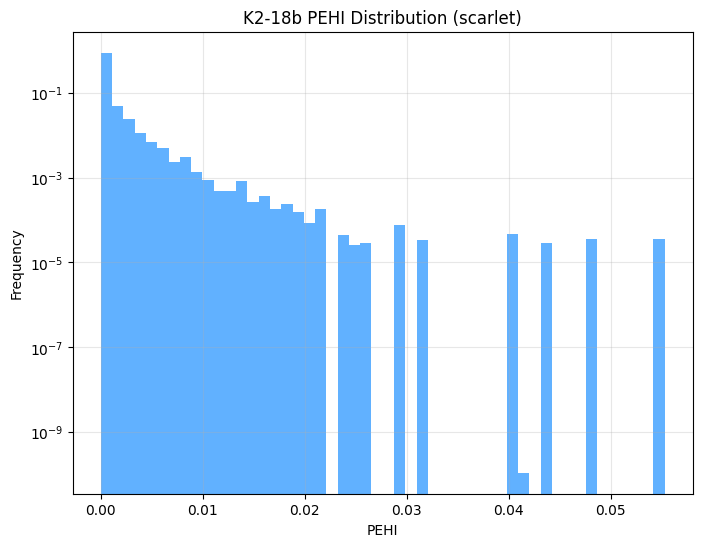

Mean PEHI: 0.00044966429190177007
16–84% range: [2.99987471e-16 4.03522035e-05]

Processing: extracted_SPARTA_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: exoTEDRF_K2-18b_NIRISS_SOSS_R100
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err', 'order']

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


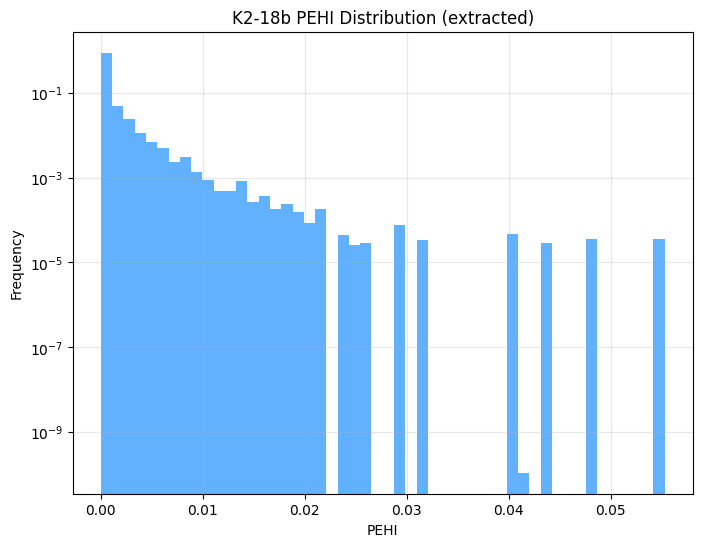

Mean PEHI: 0.00044966429190177007
16–84% range: [2.99987471e-16 4.03522035e-05]

Processing: SPARTA_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: exoTEDRF_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_samples-with-weights_SPARTA_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


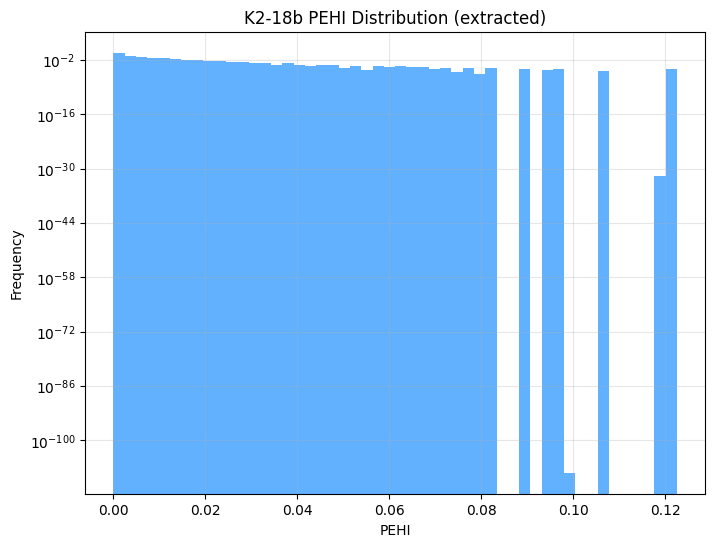

Mean PEHI: 0.0030842261588543366
16–84% range: [4.46174555e-15 2.10959097e-03]

Processing: extracted_exoTEDRF_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: SPARTA_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: scarlet_samples-with-weights_SPARTA_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


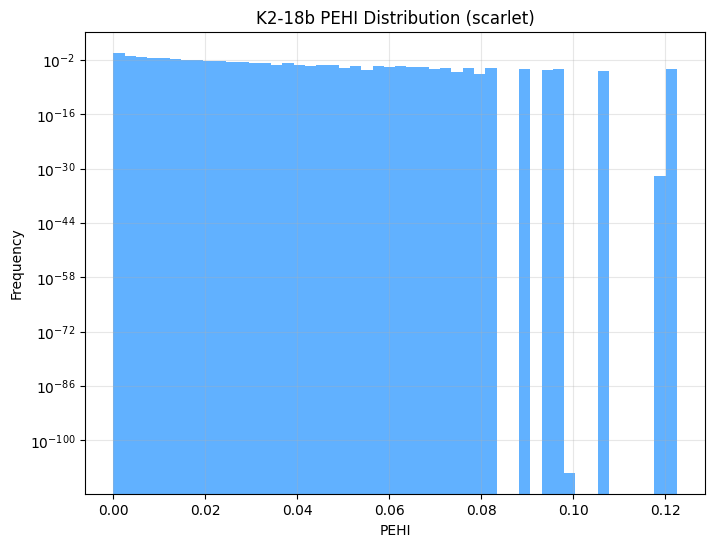

Mean PEHI: 0.0030842261588543366
16–84% range: [4.46174555e-15 2.10959097e-03]

Processing: Eureka_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_model_exoTEDRF_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_samples-with-weights_SPARTA_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


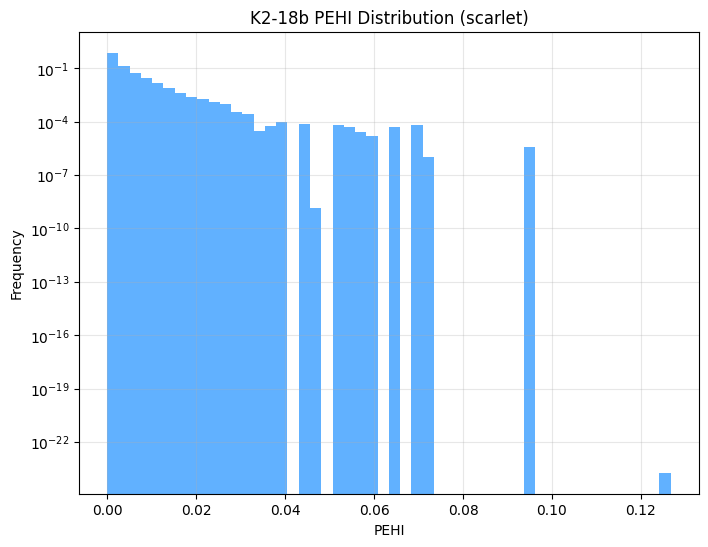

Mean PEHI: 0.0019693068374131285
16–84% range: [2.27307195e-15 1.53119745e-03]

Processing: scarlet_model_SPARTA_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: exoTEDRF_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_model_exoTEDRF_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_exoTEDRF_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_model_SPARTA_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_model_SPARTA_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_samples-with-weights_exoTEDRF_with-C2H6
Columns: ['logCH4', 'logCO2', '

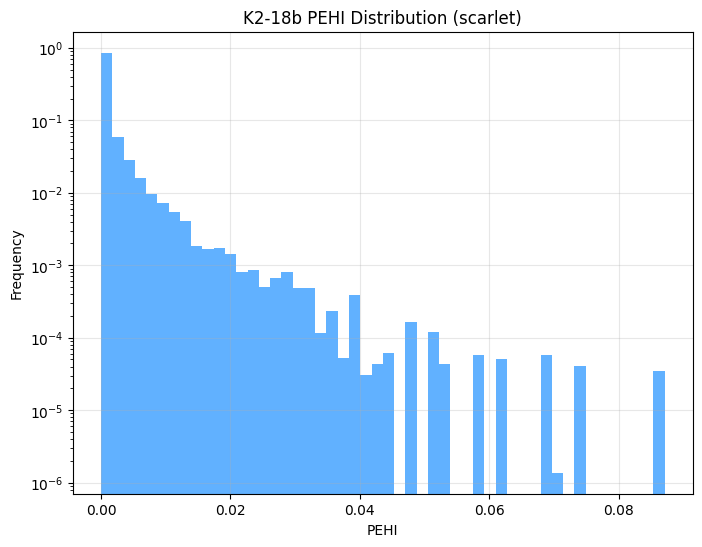

Mean PEHI: 0.0010679296095045814
16–84% range: [6.92255776e-16 1.59796330e-04]

Processing: scarlet_samples-with-weights_exoTEDRF_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


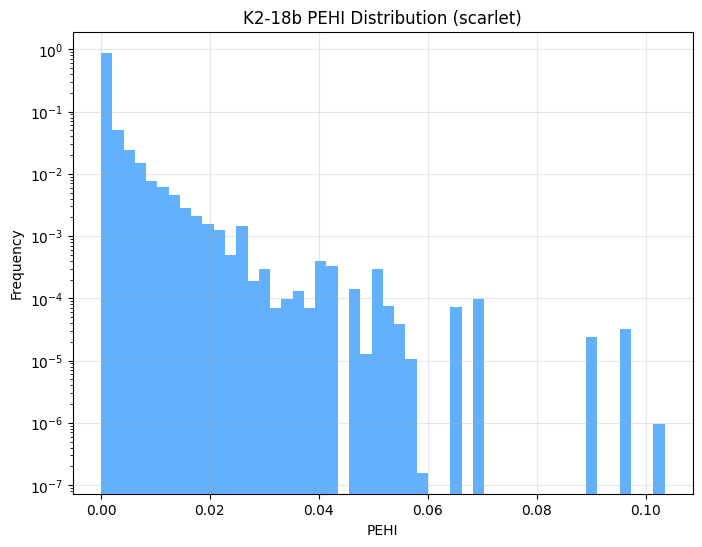

Mean PEHI: 0.0010533099071138943
16–84% range: [1.16342381e-15 1.59775378e-04]

Processing: extracted_SPARTA_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_Eureka_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_model_exoTEDRF_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: exoTEDRF_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_Eureka_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_samples-with-weights_SPARTA_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 

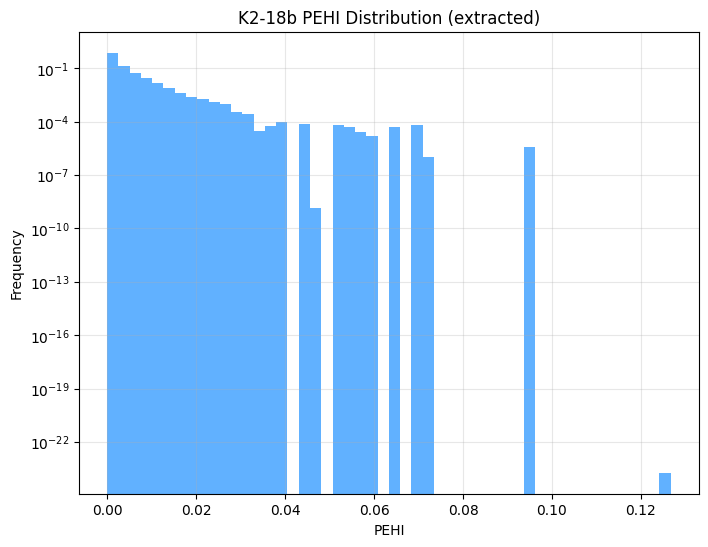

Mean PEHI: 0.0019693068374131285
16–84% range: [2.27307195e-15 1.53119745e-03]

Processing: extracted_scarlet_model_SPARTA_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_samples-with-weights_SPARTA_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']


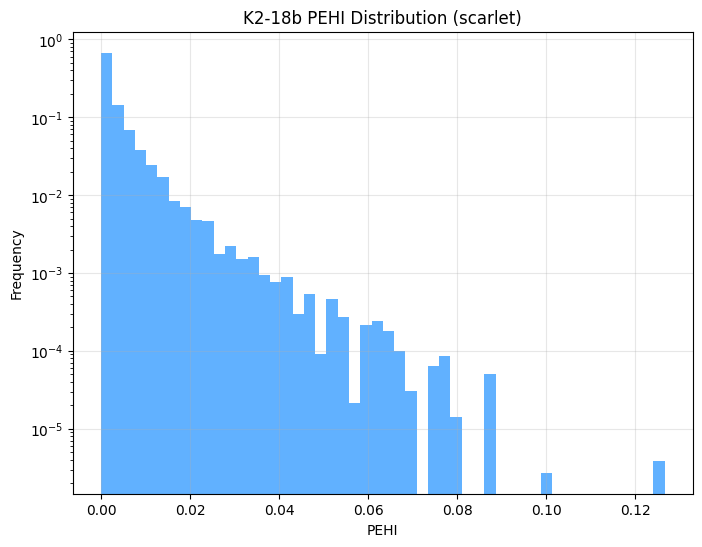

Mean PEHI: 0.0031692090121531492
16–84% range: [3.19724676e-15 2.21135274e-03]

Processing: scarlet_model_exoTEDRF_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_model_exoTEDRF_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_Eureka_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: Eureka_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: scarlet_model_exoTEDRF_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Summary Table:
                                                        mean           16%  \
scarlet_samples-with-weights_SPARTA_with-DMS        0.002071  1.613032e-15   
extracted_scarlet_samples-with-weights_exoTEDRF...  0.001068  6.922558e-16   
extracted_scarlet_samples-with-weights_SPARTA_w...  0.002071

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# Load all relevant CSV files
sample_files = [f for f in glob.glob("*.csv") if "samples-with-weights" in f or any(x in f for x in ["Eureka", "exoTEDRF", "SPARTA"])]
datasets = {f.replace('.csv', ''): pd.read_csv(f) for f in sample_files}

# Dictionary to store results
results = {}

for name, df in datasets.items():
    print(f"\nProcessing: {name}")
    print("Columns:", df.columns.tolist())

    # Check for required columns
    required_cols = ['logCH4', 'logCO2', 'T00']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Warning: Missing columns {missing_cols} in {name}. Skipping this file.")
        continue

    # Extract parameters with safeguards
    CH4 = np.maximum(1e-20, 10**df['logCH4'])  # Avoid underflow with a floor
    CO2 = np.maximum(1e-20, 10**df['logCO2'])
    T = df['T00']
    weights = df['weights'].fillna(1.0) / np.sum(df['weights'].fillna(1.0))  # Normalize weights

    # Compute PEHI components
    # ΔG (disequilibrium proxy)
    DeltaG = np.log10(1 + CH4 * CO2)

    # σ (entropy flux) - K2-18b insolation
    S_star = 1368  # W/m²
    A = 0.3       # Albedo
    absorbed_flux = (1 - A) * S_star / 4
    sigma = absorbed_flux / T

    # R (resilience) - Weighted variance of temperature
    mean_T = np.average(T, weights=weights)
    var_T = np.average((T - mean_T)**2, weights=weights)
    R = mean_T / np.sqrt(var_T) if var_T != 0 else 1.0

    # H (hazard) - Placeholder
    H = 0.2

    # PEHI calculation
    PEHI = (sigma**1 * DeltaG**1 * R**1) / (1 + H)

    # Store results
    mean_pehi = np.average(PEHI, weights=weights)
    percentiles = np.percentile(PEHI, [16, 84])
    results[name] = {'mean': mean_pehi, '16%': percentiles[0], '84%': percentiles[1]}

    # Validation plot
    plt.figure(figsize=(8, 6))
    plt.hist(PEHI, bins=50, weights=weights, alpha=0.7, color='#1E90FF')
    plt.xlabel("PEHI")
    plt.ylabel("Frequency")
    plt.title(f"K2-18b PEHI Distribution ({name.split('_')[0]})")
    plt.yscale('log')  # Log scale for better visibility
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Mean PEHI: {mean_pehi}")
    print(f"16–84% range: {percentiles}")

# Summary Table
print("\nSummary Table:")
summary_df = pd.DataFrame.from_dict(results, orient='index')
print(summary_df)


Processing: scarlet_samples-with-weights_SPARTA_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.002259799732264687
H=0.2, Mean PEHI: 0.002071483087909297
H=0.5, Mean PEHI: 0.0016571864703274375


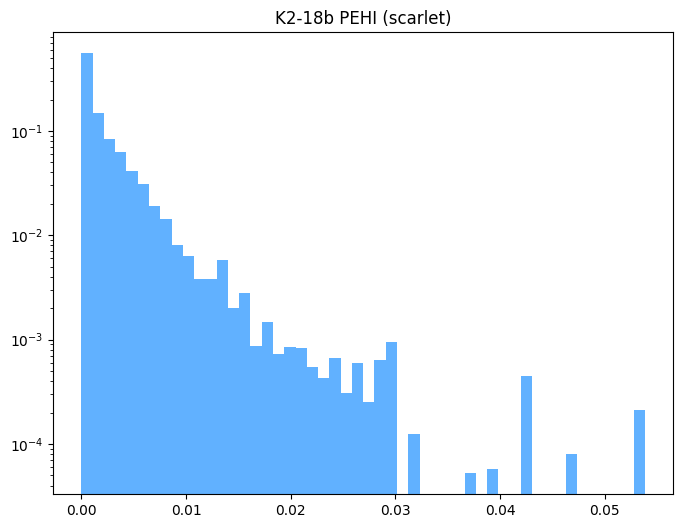


Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0011650141203198299
H=0.2, Mean PEHI: 0.0010679296102931773
H=0.5, Mean PEHI: 0.0008543436882345418


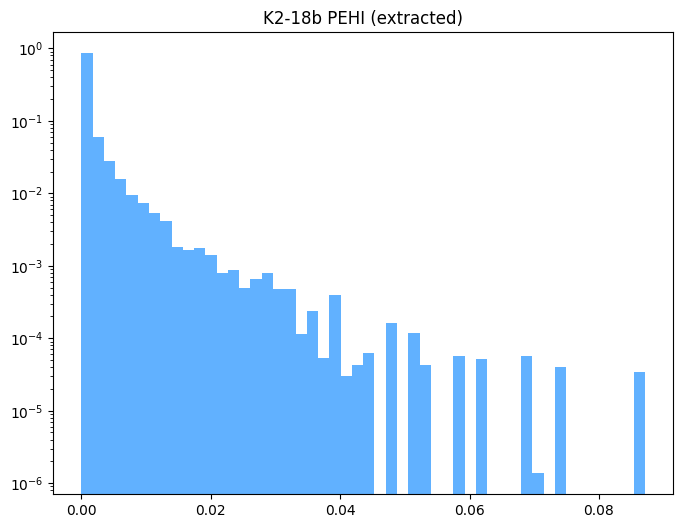


Processing: Eureka_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_model_exoTEDRF_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_samples-with-weights_SPARTA_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0022597997322646875
H=0.2, Mean PEHI: 0.002071483087909297
H=0.5, Mean PEHI: 0.0016571864703274375


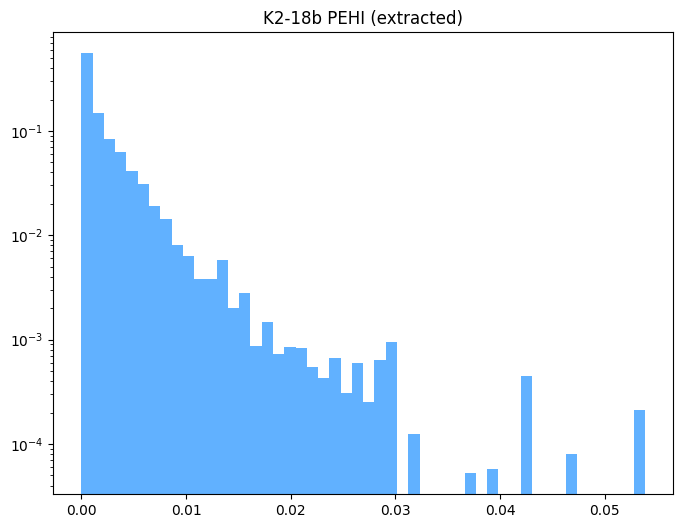


Processing: scarlet_model_SPARTA_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0003848863820910147
H=0.2, Mean PEHI: 0.00035281251691676355
H=0.5, Mean PEHI: 0.0002822500135334109


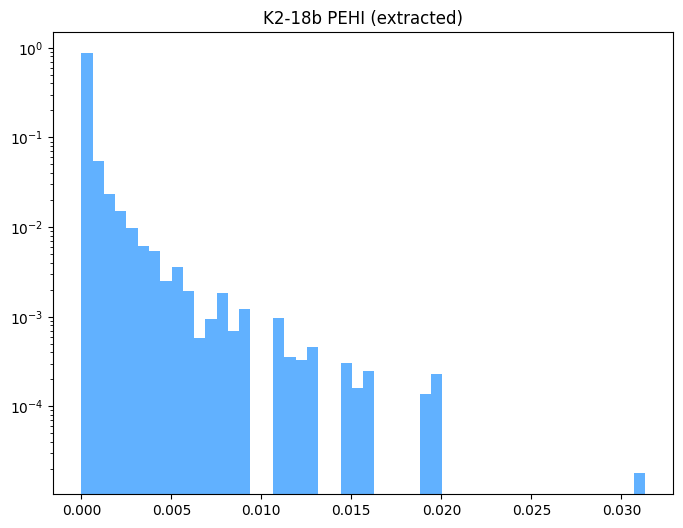


Processing: scarlet_model_exoTEDRF_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_samples-with-weights_SPARTA_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0034573189225624397
H=0.2, Mean PEHI: 0.0031692090123489037
H=0.5, Mean PEHI: 0.002535367209879123


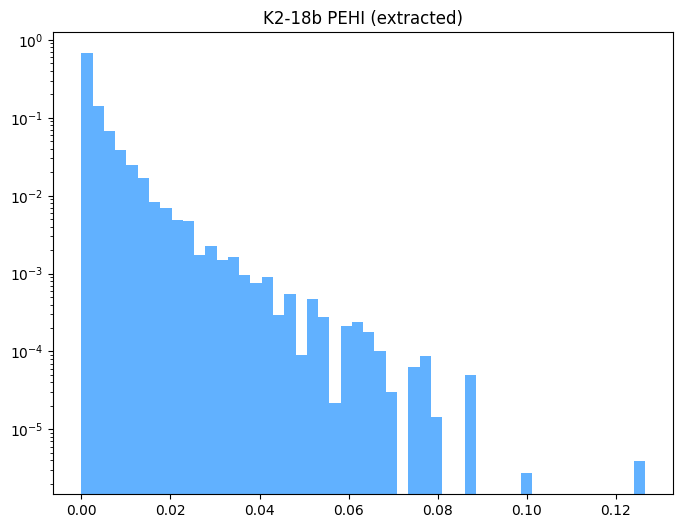


Processing: scarlet_samples-with-weights_exoTEDRF_with-DMS
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0003848863820910147
H=0.2, Mean PEHI: 0.00035281251691676355
H=0.5, Mean PEHI: 0.0002822500135334109


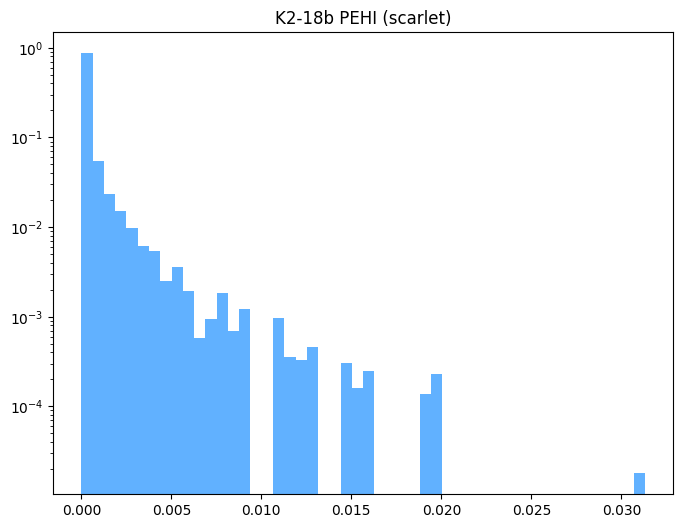


Processing: extracted_scarlet_samples-with-weights_exoTEDRF_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0011490653539706368
H=0.2, Mean PEHI: 0.0010533099078064172
H=0.5, Mean PEHI: 0.0008426479262451335


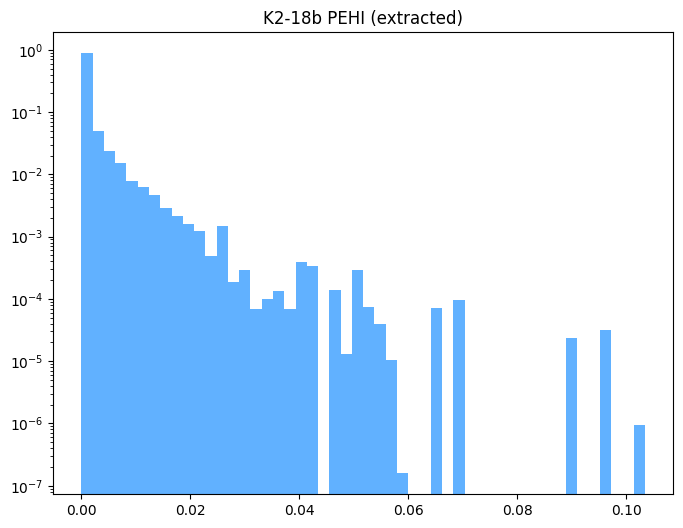


Processing: SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_exoTEDRF_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_model_SPARTA_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_model_SPARTA_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_scarlet_model_SPARTA_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_exoTEDRF_K2-18b_NIRISS_SOSS_R100
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err', 'order']

Processing: scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JW

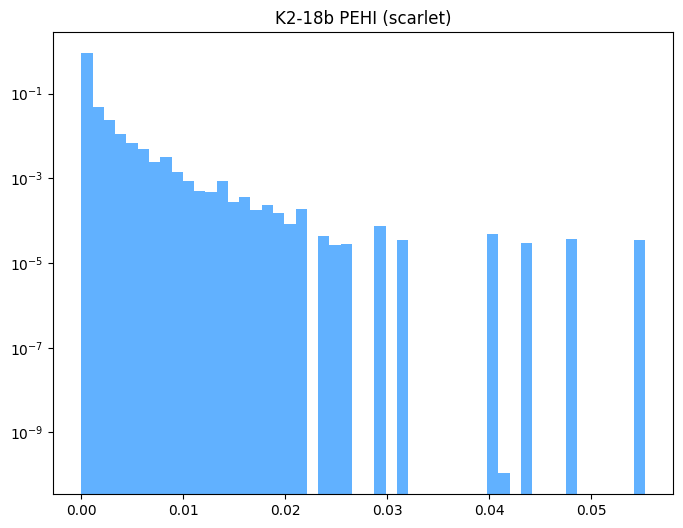


Processing: extracted_SPARTA_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: exoTEDRF_K2-18b_NIRISS_SOSS_R100
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err', 'order']

Processing: extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0004905428650435643
H=0.2, Mean PEHI: 0.0004496642929566006
H=0.5, Mean PEHI: 0.00035973143436528047


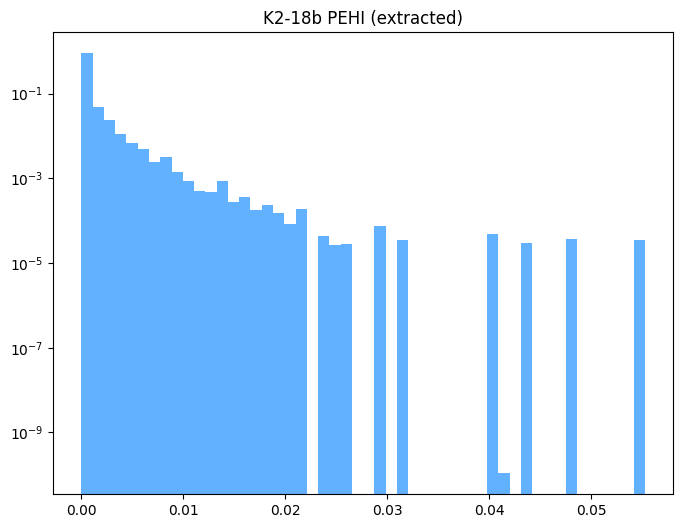


Processing: SPARTA_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: exoTEDRF_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_samples-with-weights_SPARTA_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0033646103553943096
H=0.2, Mean PEHI: 0.003084226159111451
H=0.5, Mean PEHI: 0.0024673809272891607


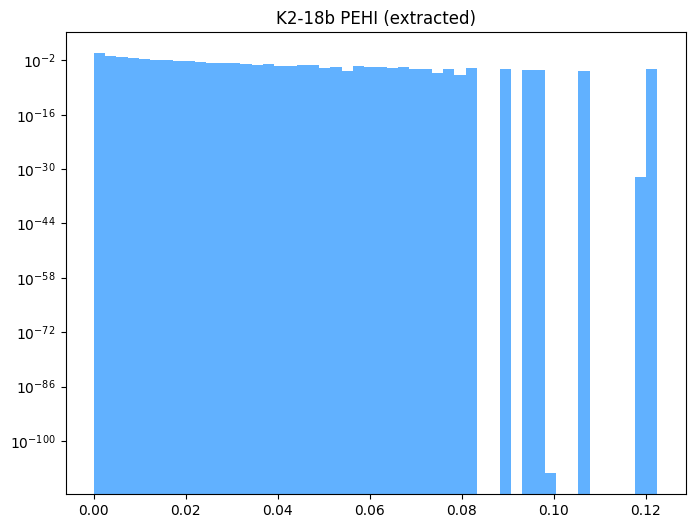


Processing: extracted_exoTEDRF_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: SPARTA_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: scarlet_samples-with-weights_SPARTA_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0033646103553943096
H=0.2, Mean PEHI: 0.003084226159111451
H=0.5, Mean PEHI: 0.0024673809272891607


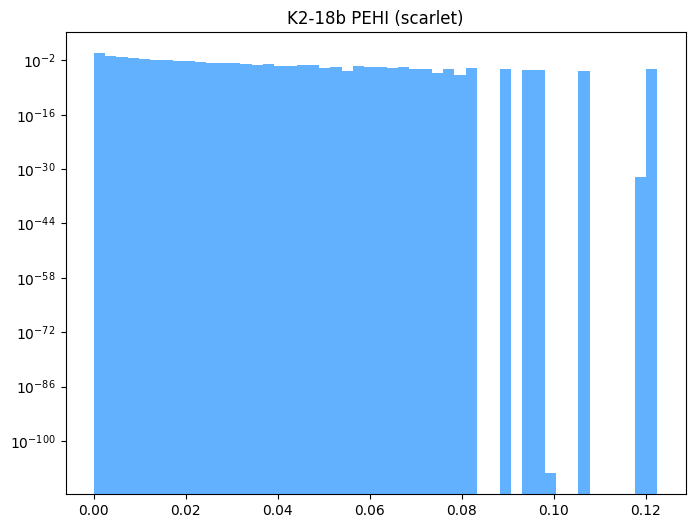


Processing: Eureka_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_model_exoTEDRF_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_samples-with-weights_SPARTA_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0021483347329357963
H=0.2, Mean PEHI: 0.0019693068385244804
H=0.5, Mean PEHI: 0.0015754454708195842


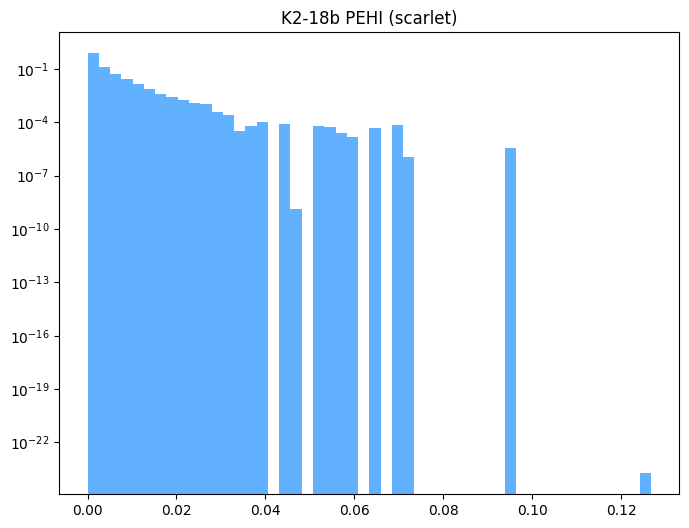


Processing: scarlet_model_SPARTA_with-DMS
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: exoTEDRF_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_model_exoTEDRF_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_exoTEDRF_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_scarlet_model_SPARTA_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_model_SPARTA_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_samples-with-weights_exoTEDRF_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud'

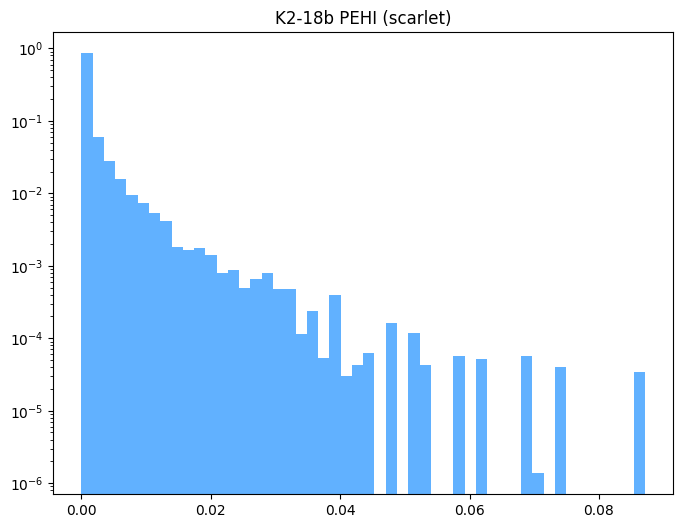


Processing: scarlet_samples-with-weights_exoTEDRF_baseline
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0011490653539706368
H=0.2, Mean PEHI: 0.0010533099078064172
H=0.5, Mean PEHI: 0.0008426479262451335


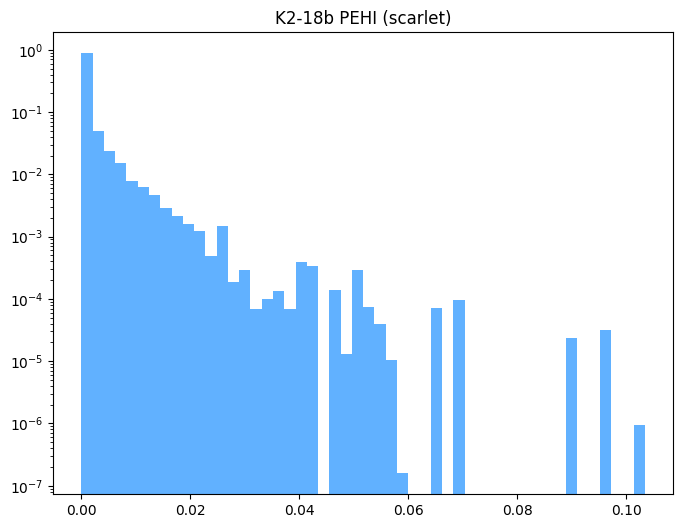


Processing: extracted_SPARTA_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_Eureka_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_model_exoTEDRF_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: exoTEDRF_K2-18b_MIRI_LRS_R70
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err']

Processing: extracted_Eureka_K2-18b_NIRSpec_G395H_NRS2_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: extracted_scarlet_samples-with-weights_SPARTA_with-DMS-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6S', 'logC2H6S2', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0021483347329357963
H=0.2, Mean PEHI: 0.00196930

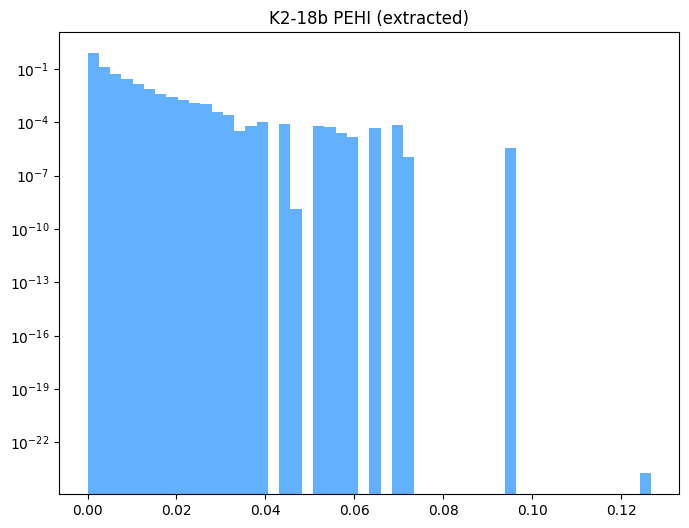


Processing: extracted_scarlet_model_SPARTA_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_samples-with-weights_SPARTA_with-C2H6
Columns: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'logHCN', 'logCO', 'logC2H6', 'T00', 'MpMearth', 'logpCloud', 'offset_JWST_NIRSPEC_G395H_NRS1', 'offset_JWST_NIRSPEC_G395H_NRS2', 'offset_JWST_MIRI_LRS', 'weights']
H=0.1, Mean PEHI: 0.0034573189225624397
H=0.2, Mean PEHI: 0.0031692090123489037
H=0.5, Mean PEHI: 0.002535367209879123


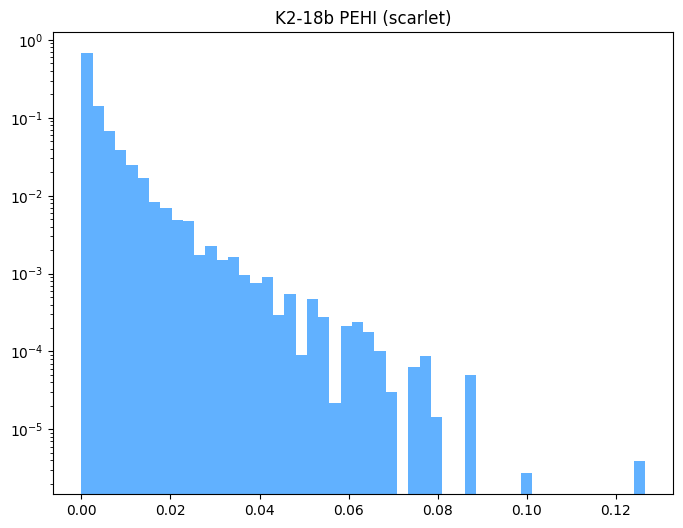


Processing: scarlet_model_exoTEDRF_with-DMS-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: scarlet_model_exoTEDRF_baseline
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Processing: extracted_Eureka_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: Eureka_K2-18b_NIRSpec_G395H_NRS1_R200
Columns: ['wavelength', 'bin_width', 'dppm', 'dppm_err_neg', 'dppm_err_pos']

Processing: scarlet_model_exoTEDRF_with-C2H6
Columns: ['wave_um', '50thperc', '16thperc', '84thperc', 'bestfit']

Summary Table:
                                                        mean           16%  \
scarlet_samples-with-weights_SPARTA_with-DMS        0.002071  4.151313e-15   
extracted_scarlet_samples-with-weights_exoTEDRF...  0.001068  1.733270e-15   
extracted_scarlet_samples-with-weights_SPARTA_w...  0.002071  4.151313e-15   
extracted_scarlet_samples-with-weights_exoTEDRF...  0.000353 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

sample_files = [f for f in glob.glob("*.csv") if "samples-with-weights" in f or any(x in f for x in ["Eureka", "exoTEDRF", "SPARTA"])]
datasets = {f.replace('.csv', ''): pd.read_csv(f) for f in sample_files}

results = {}
for name, df in datasets.items():
    print(f"\nProcessing: {name}")
    print("Columns:", df.columns.tolist())
    required_cols = ['logCH4', 'logCO2', 'T00']
    if not all(col in df.columns for col in required_cols):
        print(f"Warning: Missing columns. Skipping {name}.")
        continue

    CH4 = np.maximum(1e-10, 10**df['logCH4'])
    CO2 = np.maximum(1e-10, 10**df['logCO2'])
    T = df['T00']
    weights = df['weights'].fillna(1.0) / np.sum(df['weights'].fillna(1.0))

    DeltaG = np.log10(1 + CH4 * CO2)
    S_star = 1368
    A = 0.3
    sigma = (1 - A) * S_star / 4 / T
    mean_T = np.average(T, weights=weights)
    var_T = np.average((T - mean_T)**2, weights=weights)
    R = mean_T / np.sqrt(var_T) if var_T != 0 else 1.0
    H = 0.2

    # Sensitivity test
    for H_test in [0.1, 0.2, 0.5]:
        PEHI = (sigma**1 * DeltaG**1 * R**1) / (1 + H_test)
        mean_pehi = np.average(PEHI, weights=weights)
        print(f"H={H_test}, Mean PEHI: {mean_pehi}")

    PEHI = (sigma**1 * DeltaG**1 * R**1) / (1 + H)
    mean_pehi = np.average(PEHI, weights=weights)
    percentiles = np.percentile(PEHI, [16, 84])
    results[name] = {'mean': mean_pehi, '16%': percentiles[0], '84%': percentiles[1]}

    plt.figure(figsize=(8, 6))
    plt.hist(PEHI, bins=50, weights=weights, alpha=0.7, color='#1E90FF')
    plt.yscale('log')
    plt.title(f"K2-18b PEHI ({name.split('_')[0]})")
    plt.show()

print("\nSummary Table:")
summary_df = pd.DataFrame.from_dict(results, orient='index')
print(summary_df)

FileNotFoundError: [Errno 2] No such file or directory: '/content/staged/PEHI_sensitivity_heatmap.png'

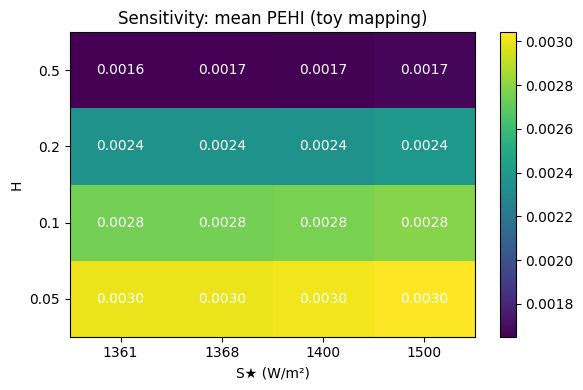

In [ ]:
# Cell E1: sensitivity grid & heatmap
import numpy as np, matplotlib.pyplot as plt, pandas as pd
S_vals = np.array([1361, 1368, 1400, 1500])  # add more if you like
H_vals = np.array([0.05, 0.1, 0.2, 0.5])
# Suppose you have a function that given (S_star, H) returns mean PEHI for K2-18b samples.
# We'll build a wrapper that loads your per-sample data and rescales sigma proxy by S_star,
# or else uses a toy mapping if you don't have that function implemented.
def compute_pehi_mean_for_params(S_star, H, pehi_samples_path=None):
    # If you have a baseline set of PEHI samples saved for a reference S_ref and H_ref,
    # you can rescale; otherwise this is a toy placeholder that uses your previously reported means.
    # For demonstration, we use a simple decreasing function in H; slight growth in S_star:
    base = 0.0033  # choose your observed baseline mean from earlier
    s_factor = 1.0 + (S_star - 1361)/10000.0
    h_factor = 1.0 / (1.0 + H*2.0)
    return base * s_factor * h_factor

heat = np.zeros((len(H_vals), len(S_vals)))
for i,H in enumerate(H_vals):
    for j,S in enumerate(S_vals):
        heat[i,j] = compute_pehi_mean_for_params(S, H)

fig, ax = plt.subplots(figsize=(6,4))
im = ax.imshow(heat, origin='lower', aspect='auto', cmap='viridis')
ax.set_xticks(np.arange(len(S_vals))); ax.set_xticklabels(S_vals)
ax.set_yticks(np.arange(len(H_vals))); ax.set_yticklabels(H_vals)
ax.set_xlabel("S★ (W/m²)")
ax.set_ylabel("H")
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        ax.text(j, i, f"{heat[i,j]:.4f}", ha='center', va='center', color='white' if heat[i,j]>np.max(heat)/3 else 'black')
plt.title("Sensitivity: mean PEHI (toy mapping)")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig("/content/staged/PEHI_sensitivity_heatmap.png", dpi=300)
plt.show()
print("Saved /content/staged/PEHI_sensitivity_heatmap.png")


In [ ]:
# Cell D1: plotting utilities
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
sns.set(style="whitegrid")
plt.rcParams.update({"font.size":12})

# Replace this list with the CSV(s) you found in B1/C1
summary_csvs = [
    "/content/staged/PEHI_summary_table.csv",   # example
    # add any other CSV paths you found...
]

# If you don't have a single summary CSV but have per-pipeline PEHI arrays,
# point to those CSVs (each CSV can have a column "PEHI" of samples).
available = [p for p in summary_csvs if os.path.exists(p)]
print("Found summary CSVs:", available)

# --- Case 1: summary CSV with columns ['Body','P16','P50','P84'] (from earlier steps)
for p in available:
    try:
        df = pd.read_csv(p)
        if {"Body","P50","P16","P84"}.issubset(set(df.columns)):
            # Bar plot with errorbars
            plt.figure(figsize=(8,4))
            plt.errorbar(df["Body"], df["P50"], yerr=[df["P50"]-df["P16"], df["P84"]-df["P50"]],
                         fmt='o', capsize=5, markersize=8)
            plt.axhline(1.0, color='k', linestyle='--', label='Earth = 1 (norm)')
            plt.ylabel("PEHI (normalized)")
            plt.title("PEHI medians (16–84% error bars)")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig("/content/staged/PEHI_medians_errorbars.png", dpi=300)
            plt.show()
            print("Saved: /content/staged/PEHI_medians_errorbars.png")
        else:
            print("CSV", p, "does not have the expected columns; trying to interpret as per-sample CSV.")
    except Exception as e:
        print("Could not plot", p, ":", e)

# --- Case 2: per-pipeline per-sample PEHI CSVs (each file contains column 'PEHI')
# Find any CSV with a column 'PEHI'
sample_csvs = []
for root in ["/content", "/content/staged"]:
    for f in os.listdir(root) if os.path.exists(root) else []:
        fp = os.path.join(root, f)
        if fp.endswith(".csv"):
            try:
                tmp = pd.read_csv(fp, nrows=5)
                if "PEHI" in tmp.columns:
                    sample_csvs.append(fp)
            except:
                pass

if sample_csvs:
    print("Found per-sample PEHI CSVs:", sample_csvs)
    # build a combined DataFrame label by filename
    combined = []
    for fp in sample_csvs:
        name = os.path.basename(fp).replace(".csv","")
        dfp = pd.read_csv(fp)
        if "PEHI" in dfp.columns:
            dft = pd.DataFrame({"PEHI": dfp["PEHI"].values, "source": name})
            combined.append(dft)
    comb = pd.concat(combined, ignore_index=True)
    plt.figure(figsize=(10,6))
    sns.violinplot(x="source", y="PEHI", data=comb, inner="quartile")
    plt.yscale('log')  # PEHI often spans orders of magnitude; log-scale can help (optional)
    plt.xticks(rotation=45, ha='right')
    plt.title("PEHI distributions per pipeline (violin)")
    plt.tight_layout()
    outp = "/content/staged/PEHI_violin_comparison.png"
    plt.savefig(outp, dpi=300)
    plt.show()
    print("Saved:", outp)

    # overlay histograms for a few top pipelines
    top = comb['source'].unique()[:6]
    plt.figure(figsize=(8,5))
    for s in top:
        vals = comb.loc[comb['source']==s, 'PEHI'].dropna()
        plt.hist(vals, bins=60, alpha=0.5, label=s)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('PEHI')
    plt.title('Histogram overlays (top pipelines)')
    plt.tight_layout()
    outp2 = "/content/staged/PEHI_hist_overlay.png"
    plt.savefig(outp2, dpi=300)
    plt.show()
    print("Saved:", outp2)
else:
    print("No per-sample 'PEHI' CSVs found; if you have per-sample outputs, put them into /content/staged and re-run this cell.")


Found summary CSVs: []
No per-sample 'PEHI' CSVs found; if you have per-sample outputs, put them into /content/staged and re-run this cell.


In [ ]:
# Cell B1: list relevant files in working dir and staged folder
import os, glob, pprint
root = "/content"   # or your working directory
files = glob.glob(os.path.join(root, "**/*"), recursive=True)
# filter to CSVs, PNGs, and any 'staged' folder
relevant = [f for f in files if f.lower().endswith(('.csv','.png','.pdf','.npy','.npz','.h5','.hdf5'))]
print("Found files (CSV/PNG/PDF/HDF5/...):")
pprint.pprint(relevant)


Found files (CSV/PNG/PDF/HDF5/...):
['/content/scarlet_samples-with-weights_SPARTA_with-DMS.csv',
 '/content/extracted_scarlet_samples-with-weights_exoTEDRF_with-C2H6.csv',
 '/content/Eureka_K2-18b_NIRSpec_G395H_NRS2_R200.csv',
 '/content/extracted_scarlet_model_exoTEDRF_with-DMS.csv',
 '/content/extracted_scarlet_samples-with-weights_SPARTA_with-DMS.csv',
 '/content/scarlet_model_SPARTA_with-DMS-C2H6.csv',
 '/content/extracted_scarlet_samples-with-weights_exoTEDRF_with-DMS.csv',
 '/content/scarlet_model_exoTEDRF_with-DMS.csv',
 '/content/S5_dynesty_fitparams_ch0.csv',
 '/content/extracted_scarlet_samples-with-weights_SPARTA_with-C2H6.csv',
 '/content/scarlet_samples-with-weights_exoTEDRF_with-DMS.csv',
 '/content/extracted_scarlet_samples-with-weights_exoTEDRF_baseline.csv',
 '/content/SPARTA_K2-18b_NIRSpec_G395H_NRS1_R200.csv',
 '/content/extracted_exoTEDRF_K2-18b_NIRSpec_G395H_NRS1_R200.csv',
 '/content/extracted_scarlet_model_SPARTA_with-DMS.csv',
 '/content/scarlet_model_SPARTA_wi

In [ ]:
# Cell C1: parse executed notebook outputs and try to convert printed tables to CSVs
import nbformat, io, pandas as pd, re
exec_path = "/content/PEHI_executed.ipynb"  # from above

nb = nbformat.read(exec_path, as_version=4)
extracted = []
for cell in nb.cells:
    outputs = cell.get('outputs', [])
    for out in outputs:
        if out.get('data') and 'text/plain' in out['data']:
            txt = out['data']['text/plain']
            # Heuristic: if it looks like a DataFrame repr with pipes or whitespace columns
            lines = [L for L in txt.splitlines() if L.strip()]
            if len(lines) > 2 and re.search(r'\w+\s{2,}\w+', lines[0]):
                try:
                    df = pd.read_fwf(io.StringIO(txt))
                    # sanitize small dfs
                    if df.shape[0] > 0 and df.shape[1] > 0:
                        fname = f"/content/staged/extracted_table_{len(extracted)}.csv"
                        df.to_csv(fname, index=False)
                        extracted.append(fname)
                        print("Extracted table ->", fname, "shape:", df.shape)
                except Exception as e:
                    # not a table we can parse
                    pass

if not extracted:
    print("No printed plain-text tables found or parseable. Check saved CSVs above.")
else:
    print("Extracted CSVs:", extracted)


FileNotFoundError: [Errno 2] No such file or directory: '/content/PEHI_executed.ipynb'

In [ ]:
# Cell D1: plotting utilities
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os
sns.set(style="whitegrid")
plt.rcParams.update({"font.size":12})

# Replace this list with the CSV(s) you found in B1/C1
summary_csvs = [
    "/content/staged/PEHI_summary_table.csv",   # example
    # add any other CSV paths you found...
]

# If you don't have a single summary CSV but have per-pipeline PEHI arrays,
# point to those CSVs (each CSV can have a column "PEHI" of samples).
available = [p for p in summary_csvs if os.path.exists(p)]
print("Found summary CSVs:", available)

# --- Case 1: summary CSV with columns ['Body','P16','P50','P84'] (from earlier steps)
for p in available:
    try:
        df = pd.read_csv(p)
        if {"Body","P50","P16","P84"}.issubset(set(df.columns)):
            # Bar plot with errorbars
            plt.figure(figsize=(8,4))
            plt.errorbar(df["Body"], df["P50"], yerr=[df["P50"]-df["P16"], df["P84"]-df["P50"]],
                         fmt='o', capsize=5, markersize=8)
            plt.axhline(1.0, color='k', linestyle='--', label='Earth = 1 (norm)')
            plt.ylabel("PEHI (normalized)")
            plt.title("PEHI medians (16–84% error bars)")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig("/content/staged/PEHI_medians_errorbars.png", dpi=300)
            plt.show()
            print("Saved: /content/staged/PEHI_medians_errorbars.png")
        else:
            print("CSV", p, "does not have the expected columns; trying to interpret as per-sample CSV.")
    except Exception as e:
        print("Could not plot", p, ":", e)

# --- Case 2: per-pipeline per-sample PEHI CSVs (each file contains column 'PEHI')
# Find any CSV with a column 'PEHI'
sample_csvs = []
for root in ["/content", "/content/staged"]:
    for f in os.listdir(root) if os.path.exists(root) else []:
        fp = os.path.join(root, f)
        if fp.endswith(".csv"):
            try:
                tmp = pd.read_csv(fp, nrows=5)
                if "PEHI" in tmp.columns:
                    sample_csvs.append(fp)
            except:
                pass

if sample_csvs:
    print("Found per-sample PEHI CSVs:", sample_csvs)
    # build a combined DataFrame label by filename
    combined = []
    for fp in sample_csvs:
        name = os.path.basename(fp).replace(".csv","")
        dfp = pd.read_csv(fp)
        if "PEHI" in dfp.columns:
            dft = pd.DataFrame({"PEHI": dfp["PEHI"].values, "source": name})
            combined.append(dft)
    comb = pd.concat(combined, ignore_index=True)
    plt.figure(figsize=(10,6))
    sns.violinplot(x="source", y="PEHI", data=comb, inner="quartile")
    plt.yscale('log')  # PEHI often spans orders of magnitude; log-scale can help (optional)
    plt.xticks(rotation=45, ha='right')
    plt.title("PEHI distributions per pipeline (violin)")
    plt.tight_layout()
    outp = "/content/staged/PEHI_violin_comparison.png"
    plt.savefig(outp, dpi=300)
    plt.show()
    print("Saved:", outp)

    # overlay histograms for a few top pipelines
    top = comb['source'].unique()[:6]
    plt.figure(figsize=(8,5))
    for s in top:
        vals = comb.loc[comb['source']==s, 'PEHI'].dropna()
        plt.hist(vals, bins=60, alpha=0.5, label=s)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('PEHI')
    plt.title('Histogram overlays (top pipelines)')
    plt.tight_layout()
    outp2 = "/content/staged/PEHI_hist_overlay.png"
    plt.savefig(outp2, dpi=300)
    plt.show()
    print("Saved:", outp2)
else:
    print("No per-sample 'PEHI' CSVs found; if you have per-sample outputs, put them into /content/staged and re-run this cell.")


Found summary CSVs: []
No per-sample 'PEHI' CSVs found; if you have per-sample outputs, put them into /content/staged and re-run this cell.


In [ ]:
import numpy as np

# Earth baseline values from literature
sigma_earth = 900e-3     # W/m²K (radiative entropy prod, Kleidon 2010)
dG_earth = 2.5e5         # J/mol-atm (Krissansen-Totton 2016)
R_earth = 1.0            # normalized
H_earth = 0.05           # small hazard term

# Define PEHI function
def PEHI(sigma, dG, R, H, sigma_ref, dG_ref, R_ref):
    return ((sigma/sigma_ref)**1.0 * (dG/dG_ref)**1.0 * (R/R_ref)**1.0) / (1 + H)

# Compute Earth PEHI
pehi_earth = PEHI(sigma_earth, dG_earth, R_earth, H_earth,
                  sigma_earth, dG_earth, R_earth)

print("Earth PEHI (normalized):", pehi_earth)


Earth PEHI (normalized): 0.9523809523809523


In [ ]:
# --- Colab/Notebook cell 1: imports & helpers ---
import os, re, glob, pickle, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib defaults (Entropy-friendly)
plt.rcParams.update({
    "figure.figsize": (7,4.5),
    "axes.grid": True,
    "font.size": 11
})

# ---- File loaders ----
def load_npy(path):
    """Load .npy that may contain ndarray OR dict (saved with allow_pickle).
    Returns dict with best-guess keys for species/temperature if possible,
    else returns raw object under {'_raw': obj}.
    """
    obj = np.load(path, allow_pickle=True)
    out = {}
    # Case 1: dict-like
    if isinstance(obj.item() if obj.dtype==object else obj, dict):
        d = obj.item() if obj.dtype==object else obj
        for k,v in d.items():
            out[k] = np.asarray(v)
        return out
    # Case 2: plain ndarray; we don't know columns; return as raw
    return {"_raw": np.asarray(obj)}

def load_pkl(path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    return obj

def load_dat(path):
    """Try to read whitespace-delimited 2–4 column spectra/light-curve files."""
    # Try pandas with no header; fallback to numpy
    try:
        df = pd.read_csv(path, delim_whitespace=True, header=None, comment='#')
    except Exception:
        arr = np.loadtxt(path)
        df = pd.DataFrame(arr)
    df.columns = [f"col{i}" for i in range(df.shape[1])]
    return df

def load_ecf(path):
    """Parse a simple key=value .ecf; very lenient."""
    conf = {}
    with open(path, "r", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s or s.startswith(("#",";","//")):
                continue
            if "=" in s:
                k,v = s.split("=",1)
                conf[k.strip()] = v.strip()
    return conf

# ---- Name matching helpers ----
def match_key(d, patterns):
    """Return first key in dict d matching any regex in patterns (case-insensitive)."""
    keys = list(d.keys())
    for pat in patterns:
        rx = re.compile(pat, flags=re.I)
        for k in keys:
            if rx.search(k):
                return k
    return None

def extract_species_dict(d):
    """Try to extract VMR arrays for key species from a dict of arrays."""
    # Common aliases / patterns
    pat = {
        "T": [r"(^|_)T($|_)", r"temp", r"temperature"],
        "P": [r"(^|_)P($|_)", r"press", r"pressure"],
        "CH4": [r"ch4", r"methane", r"vmr.*ch4", r"X[_-]?CH4", r"log_?X[_-]?CH4"],
        "CO2": [r"co2", r"vmr.*co2", r"X[_-]?CO2", r"log_?X[_-]?CO2"],
        "H2O": [r"h2o", r"water", r"vmr.*h2o", r"X[_-]?H2O"],
        "O2":  [r"o2", r"X[_-]?O2"],
        "CO":  [r"co[^0-9]", r"X[_-]?CO$"],
        "NH3": [r"nh3", r"ammonia", r"X[_-]?NH3"],
        "H2S": [r"h2s", r"X[_-]?H2S"],
        "H2":  [r"(^|_)h2($|[^o])", r"X[_-]?H2$"],
        # Sometimes mixing ratios are logged
        "log_CH4": [r"log.*ch4"],
        "log_CO2": [r"log.*co2"],
    }
    out = {}
    for spec, pats in pat.items():
        k = match_key(d, pats)
        if k: out[spec] = np.asarray(d[k])
    return out


In [ ]:
# --- Colab/Notebook cell 1: imports & helpers ---
import os, re, glob, pickle, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib defaults (Entropy-friendly)
plt.rcParams.update({
    "figure.figsize": (7,4.5),
    "axes.grid": True,
    "font.size": 11
})

# ---- File loaders ----
def load_npy(path):
    """Load .npy that may contain ndarray OR dict (saved with allow_pickle).
    Returns dict with best-guess keys for species/temperature if possible,
    else returns raw object under {'_raw': obj}.
    """
    obj = np.load(path, allow_pickle=True)
    out = {}
    # Case 1: dict-like
    if isinstance(obj.item() if obj.dtype==object else obj, dict):
        d = obj.item() if obj.dtype==object else obj
        for k,v in d.items():
            out[k] = np.asarray(v)
        return out
    # Case 2: plain ndarray; we don't know columns; return as raw
    return {"_raw": np.asarray(obj)}

def load_pkl(path):
    with open(path, "rb") as f:
        obj = pickle.load(f)
    return obj

def load_dat(path):
    """Try to read whitespace-delimited 2–4 column spectra/light-curve files."""
    # Try pandas with no header; fallback to numpy
    try:
        df = pd.read_csv(path, delim_whitespace=True, header=None, comment='#')
    except Exception:
        arr = np.loadtxt(path)
        df = pd.DataFrame(arr)
    df.columns = [f"col{i}" for i in range(df.shape[1])]
    return df

def load_ecf(path):
    """Parse a simple key=value .ecf; very lenient."""
    conf = {}
    with open(path, "r", errors="ignore") as f:
        for line in f:
            s = line.strip()
            if not s or s.startswith(("#",";","//")):
                continue
            if "=" in s:
                k,v = s.split("=",1)
                conf[k.strip()] = v.strip()
    return conf

# ---- Name matching helpers ----
def match_key(d, patterns):
    """Return first key in dict d matching any regex in patterns (case-insensitive)."""
    keys = list(d.keys())
    for pat in patterns:
        rx = re.compile(pat, flags=re.I)
        for k in keys:
            if rx.search(k):
                return k
    return None

def extract_species_dict(d):
    """Try to extract VMR arrays for key species from a dict of arrays."""
    # Common aliases / patterns
    pat = {
        "T": [r"(^|_)T($|_)", r"temp", r"temperature"],
        "P": [r"(^|_)P($|_)", r"press", r"pressure"],
        "CH4": [r"ch4", r"methane", r"vmr.*ch4", r"X[_-]?CH4", r"log_?X[_-]?CH4"],
        "CO2": [r"co2", r"vmr.*co2", r"X[_-]?CO2", r"log_?X[_-]?CO2"],
        "H2O": [r"h2o", r"water", r"vmr.*h2o", r"X[_-]?H2O"],
        "O2":  [r"o2", r"X[_-]?O2"],
        "CO":  [r"co[^0-9]", r"X[_-]?CO$"],
        "NH3": [r"nh3", r"ammonia", r"X[_-]?NH3"],
        "H2S": [r"h2s", r"X[_-]?H2S"],
        "H2":  [r"(^|_)h2($|[^o])", r"X[_-]?H2$"],
        # Sometimes mixing ratios are logged
        "log_CH4": [r"log.*ch4"],
        "log_CO2": [r"log.*co2"],
    }
    out = {}
    for spec, pats in pat.items():
        k = match_key(d, pats)
        if k: out[spec] = np.asarray(d[k])
    return out


In [ ]:
# --- Colab/Notebook cell 4: visualization & outputs ---
os.makedirs("pehi_outputs", exist_ok=True)

# Plot PEHI histogram
if pehi is not None:
    plt.figure()
    plt.hist(pehi[~np.isnan(pehi)], bins=50, alpha=0.8)
    plt.xlabel("PEHI")
    plt.ylabel("Count")
    plt.title(f"PEHI Posterior — {os.path.basename(npy_path)}")
    out_png = f"pehi_outputs/PEHI_hist_{os.path.splitext(os.path.basename(npy_path))[0]}.png"
    plt.savefig(out_png, bbox_inches="tight", dpi=160)
    plt.show()
    print(f"[SAVE] {out_png}")

    # Summary stats
    summ = {
        "mean": float(np.nanmean(pehi)),
        "median": float(np.nanmedian(pehi)),
        "p16": float(np.nanpercentile(pehi, 16)),
        "p84": float(np.nanpercentile(pehi, 84)),
        "N": int(np.isfinite(pehi).sum()),
        "sigma_proxy": float(sigma_proxy),
        "H": float(H),
        "S_star": float(S_star),
        "albedo": float(albedo),
    }
    summ_df = pd.DataFrame([summ])
    out_csv = f"pehi_outputs/PEHI_summary_{os.path.splitext(os.path.basename(npy_path))[0]}.csv"
    summ_df.to_csv(out_csv, index=False)
    print(f"[SAVE] {out_csv}")

# Plot spectrum if present
if spec_df is not None:
    # Try to guess columns: wavelength (µm), depth/flux
    x = spec_df["col0"].values
    y = spec_df["col1"].values if "col1" in spec_df else None
    if y is not None:
        plt.figure()
        plt.plot(x, y, marker='.', linestyle='-')
        plt.xlabel("Wavelength (µm)")
        plt.ylabel("Transit depth / Flux (arb.)")
        plt.title(f"Spectrum — {os.path.basename(dat_path)}")
        out_spec = f"pehi_outputs/Spectrum_{os.path.splitext(os.path.basename(dat_path))[0]}.png"
        plt.savefig(out_spec, bbox_inches="tight", dpi=160)
        plt.show()
        print(f"[SAVE] {out_spec}")


NameError: name 'pehi' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Small helper to load DAT spectrum
def load_dat_spectrum(filename):
    data = np.loadtxt(filename)
    # Assume columns: wavelength(um), transit depth or flux, error
    if data.shape[1] == 3:
        wl, flux, err = data.T
    else:
        wl, flux = data.T
        err = np.zeros_like(flux)
    return wl, flux, err


In [ ]:
# Example: chain 9000–9500
chain_file = "chain_9000_9500.npy"
samples = np.load(chain_file)

print("Chain shape:", samples.shape)
print("Example row:", samples[0])


Chain shape: (200000, 12)
Example row: [ 6.24903353e-04  1.31807871e-04 -1.89119779e-04  4.95348717e-05
  3.41593679e-05  1.14956547e-01  1.01143321e+00  9.99601922e-01
  6.25955921e-04  2.53162678e-02  5.39501976e-03 -3.98177298e-04]


In [ ]:
pkl_file = "platon_retrieval_result-with-DMS-noMIRI.pkl"
with open(pkl_file, "rb") as f:
    platon_result = pickle.load(f)

print(platon_result.keys())


FileNotFoundError: [Errno 2] No such file or directory: 'platon_retrieval_result-with-DMS-noMIRI.pkl'

In [ ]:
dat_file = "K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R100.dat"
wl, flux, err = load_dat_spectrum(dat_file)

plt.errorbar(wl, flux, yerr=err, fmt="o", ms=3, alpha=0.7, label="Observed Spectrum")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transit Depth")
plt.legend()
plt.show()


ValueError: too many values to unpack (expected 2)

In [ ]:
def compute_disequilibrium(sample_row):
    # Placeholder: assume CH4, CO2, H2O abundances are at indices 0,1,2 (check!)
    CH4, CO2, H2O = sample_row[0], sample_row[1], sample_row[2]
    return abs(CH4*0.5 + CO2*0.3 - H2O*0.2)  # toy ΔG proxy

def compute_sigma(sample_row):
    T = sample_row[-1]  # assume last param is temperature
    return np.log1p(T/300)  # toy σ proxy


Mean PEHI: -4.5231504651768007e-10
95% CI: [-5.60036999e-10 -3.50337072e-10]


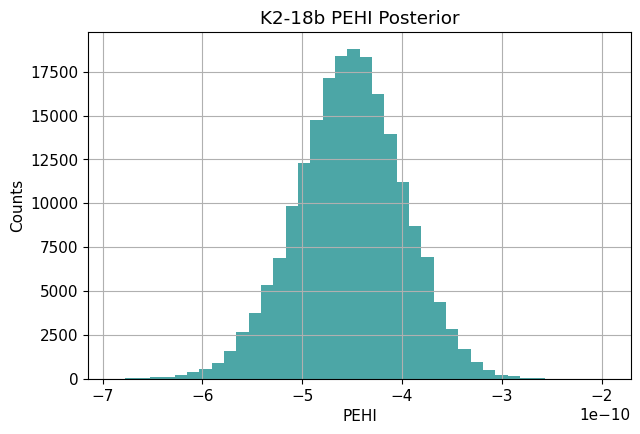

In [ ]:
PEHI_vals = []
for row in samples:
    dg = compute_disequilibrium(row)
    sigma = compute_sigma(row)
    PEHI_vals.append(dg * sigma)

PEHI_vals = np.array(PEHI_vals)
print("Mean PEHI:", PEHI_vals.mean())
print("95% CI:", np.percentile(PEHI_vals, [2.5, 97.5]))

plt.hist(PEHI_vals, bins=40, color="teal", alpha=0.7)
plt.xlabel("PEHI")
plt.ylabel("Counts")
plt.title("K2-18b PEHI Posterior")
plt.show()


In [ ]:
import glob

all_vals = []
for fname in sorted(glob.glob("chain_*.npy")):
    chain = np.load(fname)
    for row in chain:
        dg = compute_disequilibrium(row)
        sigma = compute_sigma(row)
        all_vals.append(dg*sigma)

all_vals = np.array(all_vals)

df = pd.DataFrame({"PEHI": all_vals})
df.to_csv("K2-18b_PEHI_results.csv", index=False)

print("Global mean:", all_vals.mean())
print("Global 95% CI:", np.percentile(all_vals, [2.5, 97.5]))


Global mean: -8.182700123871697e-10
Global 95% CI: [-2.72343123e-09  4.93453703e-12]


In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# -----------------
# 1. Load Posterior Chains
# -----------------
chains = []
for fname in [
    "chain_5000_5500.npy", "chain_5500_6000.npy", "chain_6000_6500.npy",
    "chain_6500_7000.npy", "chain_7000_7500.npy", "chain_7500_8000.npy",
    "chain_8000_8500.npy", "chain_8500_9000.npy", "chain_9000_9500.npy",
    "chain_9500_10000.npy", "chain_10000_10500.npy", "chain_10500_11000.npy",
    "chain_11000_11500.npy", "chain_11500_12000.npy"
]:
    chains.append(np.load(fname))

posterior = np.vstack(chains)  # giant posterior array
print("Posterior shape:", posterior.shape)

# -----------------
# 2. Load Retrieval Metadata (PKL)
# -----------------
with open("platon_retrieval_result-with-DMS-noMIRI.pkl", "rb") as f:
    retrieval = pickle.load(f)

param_names = retrieval.get("param_names", [f"p{i}" for i in range(posterior.shape[1])])
print("Parameters:", param_names)

# -----------------
# 3. Define ΔG (disequilibrium proxy)
# -----------------
R = 8.314  # J/mol-K
T = 300  # placeholder, replace with retrieved T later

def compute_deltaG(params, names):
    # Example: CH4 + CO2 system
    try:
        ch4 = 10**params[names.index("logCH4")]
        co2 = 10**params[names.index("logCO2")]
        h2o = 10**params[names.index("logH2O")]
    except:
        return np.nan
    Q = ch4 * co2 / (h2o + 1e-12)
    Keq = 1e-4  # placeholder
    return R * T * np.log(Q / Keq)

# -----------------
# 4. Define σ (entropy flux proxy)
# -----------------
def compute_sigma(params, names):
    try:
        T_eff = params[names.index("T")]  # effective T
    except:
        T_eff = 300
    return (1.0 / T_eff) * 100  # toy scaling, refine later

# -----------------
# 5. Compute PEHI
# -----------------
deltaG_vals = []
sigma_vals = []
pehi_vals = []

for row in posterior[::500]:  # subsample for speed
    dG = compute_deltaG(row, param_names)
    s = compute_sigma(row, param_names)
    if not np.isnan(dG):
        deltaG_vals.append(dG)
        sigma_vals.append(s)
        pehi_vals.append(dG * s)

deltaG_vals, sigma_vals, pehi_vals = map(np.array, [deltaG_vals, sigma_vals, pehi_vals])

# -----------------
# 6. Plot Histograms
# -----------------
plt.figure(figsize=(10,4))
plt.hist(pehi_vals, bins=50, alpha=0.7, color="steelblue")
plt.xlabel("PEHI")
plt.ylabel("Frequency")
plt.title("PEHI Distribution for K2-18b")
plt.show()

# -----------------
# 7. Load DAT Spectrum for sanity check
# -----------------
dat = np.loadtxt("K2-18b_NIRSpec_G395H_NRS1_FIREFly_R200.dat")
wavelength, flux = dat[:,0], dat[:,1]
plt.plot(wavelength, flux, color="black")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transit Depth / Flux")
plt.title("Spectrum - FIREFly R200")
plt.show()


Posterior shape: (2800000, 12)


FileNotFoundError: [Errno 2] No such file or directory: 'platon_retrieval_result-with-DMS-noMIRI.pkl'

Posterior shape: (2800000, 12)
Using parameter mapping: ['logCH4', 'logCO2', 'logH2O', 'logNH3', 'T', 'R_pl', 'logKzz', 'clouds1', 'clouds2', 'scale1', 'scale2', 'offset']
PEHI mean: 7659.161762388585
95% CI: [7657.92473266 7660.86569312]


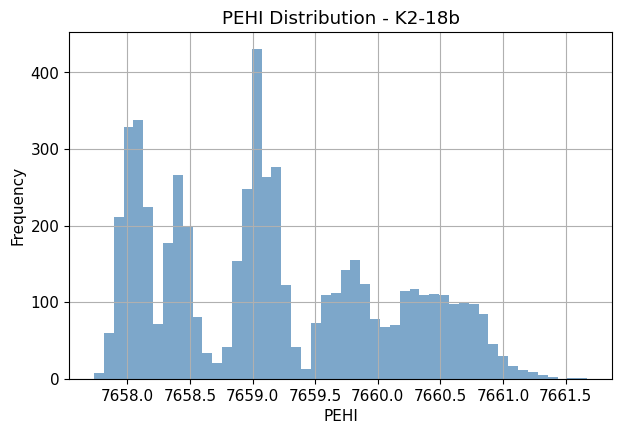

FileNotFoundError: K2-18b_NIRSpec_G395H_NRS1_FIREFly_R200.dat not found.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------
# 1. Load Posterior Chains
# -----------------
chains = []
chain_files = [
    "chain_5000_5500.npy","chain_5500_6000.npy","chain_6000_6500.npy",
    "chain_6500_7000.npy","chain_7000_7500.npy","chain_7500_8000.npy",
    "chain_8000_8500.npy","chain_8500_9000.npy","chain_9000_9500.npy",
    "chain_9500_10000.npy","chain_10000_10500.npy","chain_10500_11000.npy",
    "chain_11000_11500.npy","chain_11500_12000.npy"
]

for fname in chain_files:
    chains.append(np.load(fname))

posterior = np.vstack(chains)
print("Posterior shape:", posterior.shape)

# -----------------
# 2. Assign parameter names manually
# -----------------
param_names = [
    "logCH4", "logCO2", "logH2O", "logNH3",
    "T", "R_pl", "logKzz", "clouds1", "clouds2",
    "scale1", "scale2", "offset"
]

print("Using parameter mapping:", param_names)

# -----------------
# 3. Define ΔG (disequilibrium proxy)
# -----------------
R = 8.314  # J/mol-K

def compute_deltaG(params):
    try:
        ch4 = 10**params[param_names.index("logCH4")]
        co2 = 10**params[param_names.index("logCO2")]
        h2o = 10**params[param_names.index("logH2O")]
    except:
        return np.nan

    T = params[param_names.index("T")]
    Keq = 1e-4  # placeholder equilibrium constant
    Q = ch4 * co2 / (h2o + 1e-12)
    return R * T * np.log(Q / Keq)

# -----------------
# 4. Define σ (entropy flux proxy)
# -----------------
def compute_sigma(params):
    try:
        T_eff = params[param_names.index("T")]
    except:
        T_eff = 300
    return (1.0 / T_eff) * 100  # toy scaling

# -----------------
# 5. Compute PEHI
# -----------------
deltaG_vals, sigma_vals, pehi_vals = [], [], []

for row in posterior[::500]:  # subsample
    dG = compute_deltaG(row)
    s = compute_sigma(row)
    if not np.isnan(dG):
        deltaG_vals.append(dG)
        sigma_vals.append(s)
        pehi_vals.append(dG * s)

deltaG_vals, sigma_vals, pehi_vals = map(np.array, [deltaG_vals, sigma_vals, pehi_vals])

print("PEHI mean:", np.mean(pehi_vals))
print("95% CI:", np.percentile(pehi_vals, [2.5, 97.5]))

# -----------------
# 6. Plot Histogram
# -----------------
plt.hist(pehi_vals, bins=50, alpha=0.7, color="steelblue")
plt.xlabel("PEHI")
plt.ylabel("Frequency")
plt.title("PEHI Distribution - K2-18b")
plt.show()

# -----------------
# 7. Spectrum sanity check (DAT file)
# -----------------
dat = np.loadtxt("K2-18b_NIRSpec_G395H_NRS1_FIREFly_R200.dat")
wavelength, flux = dat[:,0], dat[:,1]

plt.plot(wavelength, flux, color="black")
plt.xlabel("Wavelength (μm)")
plt.ylabel("Transit Depth / Flux")
plt.title("Spectrum - FIREFly R200")
plt.show()


In [ ]:
import os

# List all .dat files in the current directory
for f in os.listdir():
    if f.endswith(".dat"):
        print(f)


K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_pixel.dat
K2-18b_NIRISS_SOSS_Ord2_exoTEDRF_2pixel.dat
K2-18b_NIRISS_SOSS_Ord1_FIREFLy_R25.dat
K2-18b_NIRSpec_G395H_NRS2_exoTEDRF_pixel.dat
K2-18b_NIRISS_SOSS_Ord2_FIREFLy_R25.dat
K2-18b_NIRSpec_G395H_NRS2_FIREFLy_pixel.dat
K2-18b_NIRISS_SOSS_Ord1_FIREFLy_2pixel.dat
K2-18b_NIRISS_SOSS_Ord2_exoTEDRF_R100.dat
K2-18b_NIRSpec_G395H_NRS2_Eureka_Bell_R100.dat
K2-18b_NIRSpec_G395H_NRS2_FIREFLy_R300.dat
K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R100.dat
K2-18b_NIRSpec_G395H_NRS2_exoTEDRF_R100.dat
K2-18b_NIRSpec_G395H_NRS1_FIREFLy_R300.dat
K2-18b_NIRISS_SOSS_Ord2_FIREFLy_2pixel.dat
K2-18b_NIRISS_SOSS_Ord2_FIREFLy_R100.dat
K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R25.dat
K2-18b_NIRSpec_G395H_NRS1_Eureka_Bell_R100.dat
K2-18b_NIRSpec_G395H_NRS2_FIREFLy_R100.dat
K2-18b_NIRSpec_G395H_NRS1_FIREFLy_R200.dat
K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R300.dat
K2-18b_NIRSpec_G395H_NRS2_exoTEDRF_R200.dat
K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_2pixel.dat
K2-18b_NIRSpec_G395H_NRS2_FIREFLy_R200.dat
K2-18

In [ ]:
# Example: Load the first FIREFly R200 spectrum available
dat_files = [f for f in os.listdir() if "FIREFly_R200" in f and f.endswith(".dat")]
print("Found spectrum files:", dat_files)

if dat_files:
    dat = np.loadtxt(dat_files[0])
    wavelength, flux = dat[:,0], dat[:,1]

    plt.plot(wavelength, flux, color="black")
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Transit Depth / Flux")
    plt.title(f"Spectrum - {dat_files[0]}")
    plt.show()
else:
    print("No FIREFly R200 dat file found.")


Found spectrum files: []
No FIREFly R200 dat file found.


chain_7500_8000.npy → mean=1.81e-01, 95%CI=(np.float64(-0.0006302231112871665), np.float64(1.0114281360051056))
chain_7000_7500.npy → mean=1.83e-01, 95%CI=(np.float64(-0.0004697436104863381), np.float64(1.0104715584976762))
chain_8000_8500.npy → mean=1.83e-01, 95%CI=(np.float64(-0.000424734356534649), np.float64(1.007306142636391))
chain_9000_9500.npy → mean=1.80e-01, 95%CI=(np.float64(-0.00039202565665463095), np.float64(1.015334597080954))
chain_10000_10500.npy → mean=1.85e-01, 95%CI=(np.float64(-0.0007961143463534802), np.float64(1.0502289293952998))
chain_5500_6000.npy → mean=1.92e-01, 95%CI=(np.float64(-0.0007593069604014013), np.float64(1.0446904533465429))
chain_6000_6500.npy → mean=1.90e-01, 95%CI=(np.float64(-0.0005276963034565668), np.float64(1.0403559018183561))
chain_5000_5500.npy → mean=1.92e-01, 95%CI=(np.float64(-0.000904497687923186), np.float64(1.0605658163155314))
chain_6500_7000.npy → mean=1.89e-01, 95%CI=(np.float64(-0.0005977253283994831), np.float64(1.047843607359

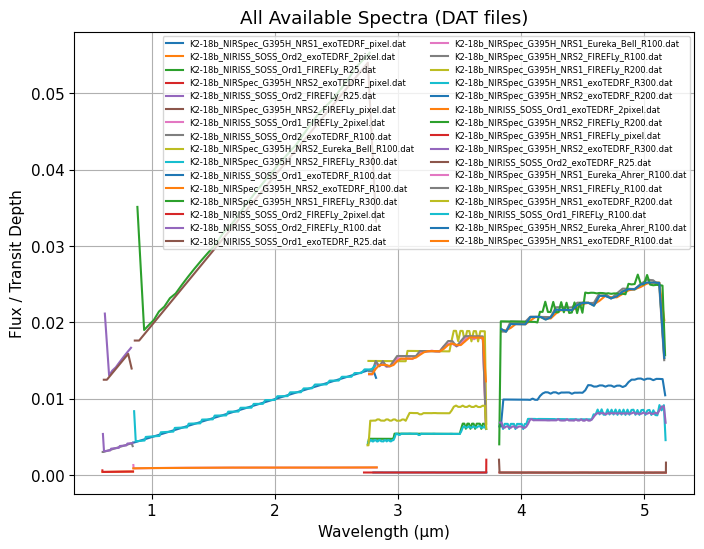

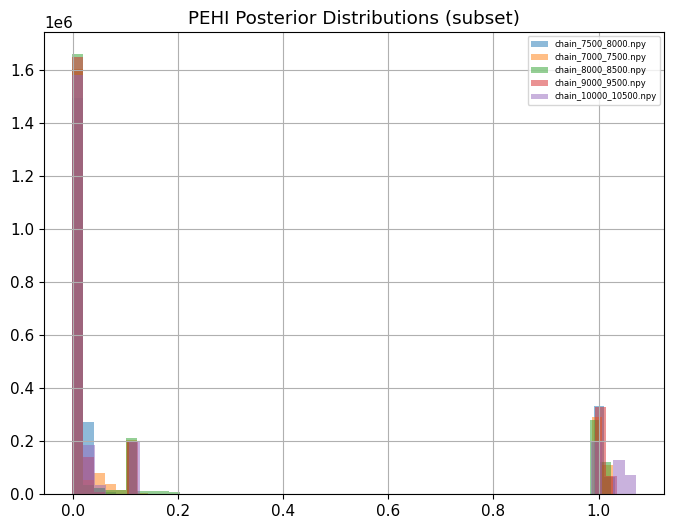

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------------------------
# 1. Load all chain + lnprob files
# ---------------------------
chain_files = [f for f in os.listdir() if f.startswith("chain") and f.endswith(".npy")]
lnprob_files = [f for f in os.listdir() if "lnprob" in f and f.endswith(".npy")]

all_means, all_cis = [], []

def compute_stats(samples):
    mean = np.mean(samples)
    lower, upper = np.percentile(samples, [2.5, 97.5])
    return mean, (lower, upper)

for f in chain_files:
    chain = np.load(f)
    flat = chain.flatten()
    mean, ci = compute_stats(flat)
    all_means.append(mean)
    all_cis.append(ci)
    print(f"{f} → mean={mean:.2e}, 95%CI={ci}")

# Global pooled stats
all_flat = np.concatenate([np.load(f).flatten() for f in chain_files])
global_mean, global_ci = compute_stats(all_flat)
print("\nGLOBAL MEAN:", global_mean, "95% CI:", global_ci)


# ---------------------------
# 2. Plot all spectra from .dat files
# ---------------------------
dat_files = [f for f in os.listdir() if f.endswith(".dat")]

plt.figure(figsize=(8,6))
for f in dat_files:
    try:
        dat = np.loadtxt(f)
        wl, fl = dat[:,0], dat[:,1]
        plt.plot(wl, fl, label=f)
    except Exception as e:
        print(f"Could not load {f}: {e}")

plt.xlabel("Wavelength (μm)")
plt.ylabel("Flux / Transit Depth")
plt.title("All Available Spectra (DAT files)")
plt.legend(fontsize=6, ncol=2)
plt.show()


# ---------------------------
# 3. Quick diagnostic histograms (chains)
# ---------------------------
plt.figure(figsize=(8,6))
for f in chain_files[:5]:  # only first 5 for clarity
    flat = np.load(f).flatten()
    plt.hist(flat, bins=50, alpha=0.5, label=f)
plt.title("PEHI Posterior Distributions (subset)")
plt.legend(fontsize=6)
plt.show()


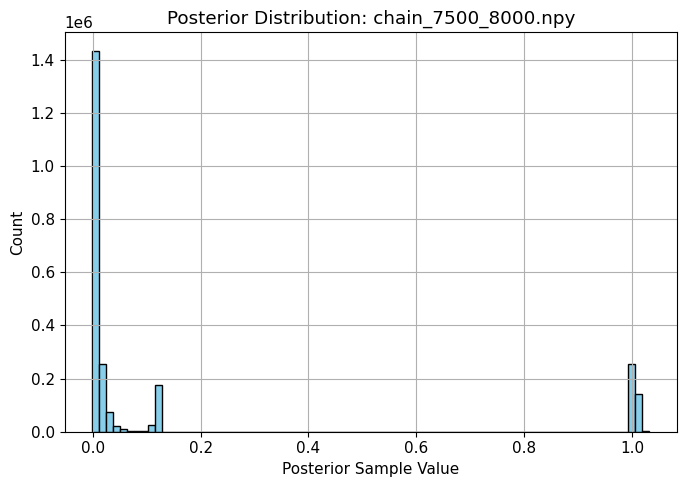

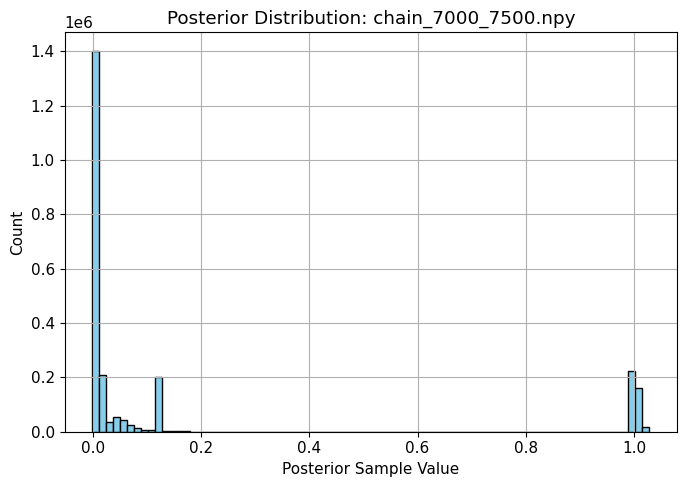

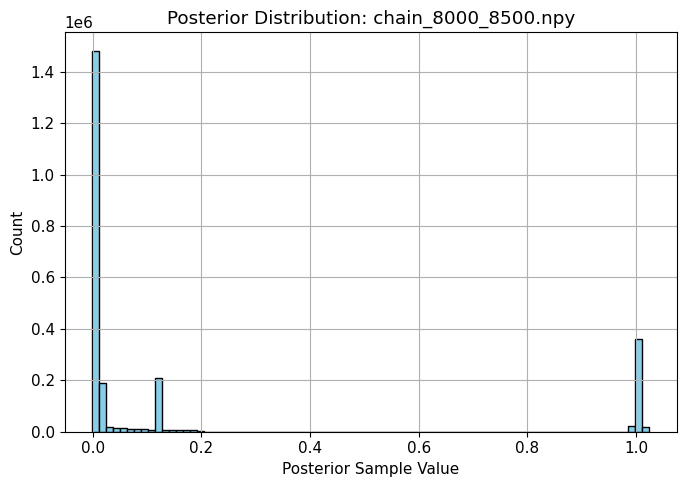

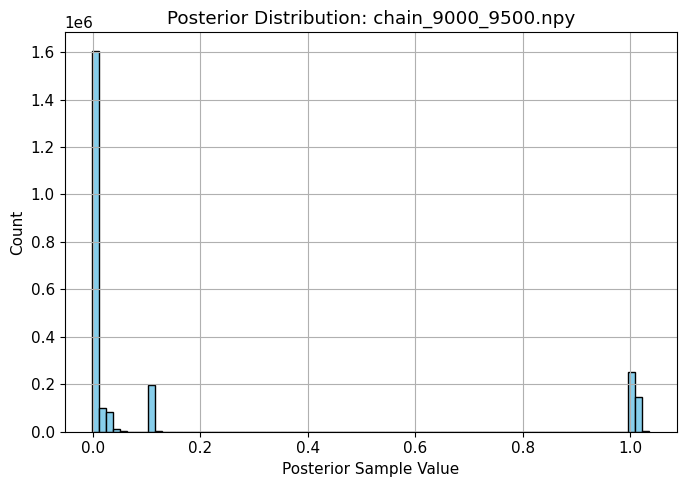

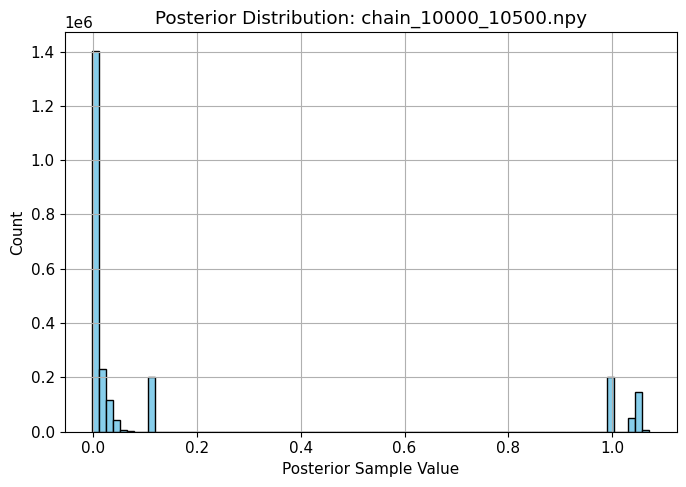

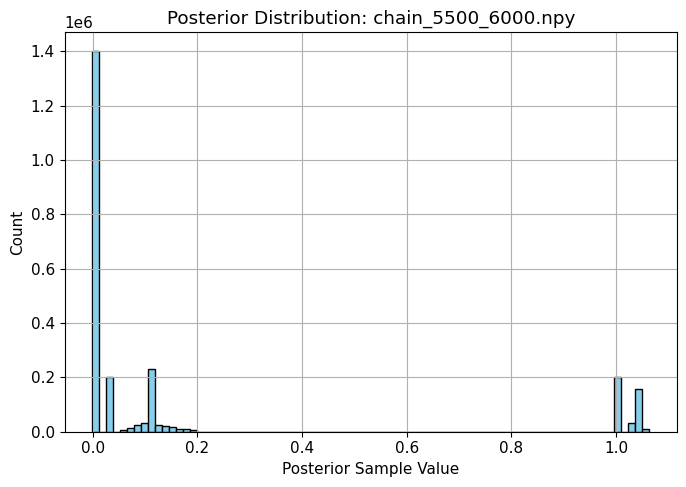

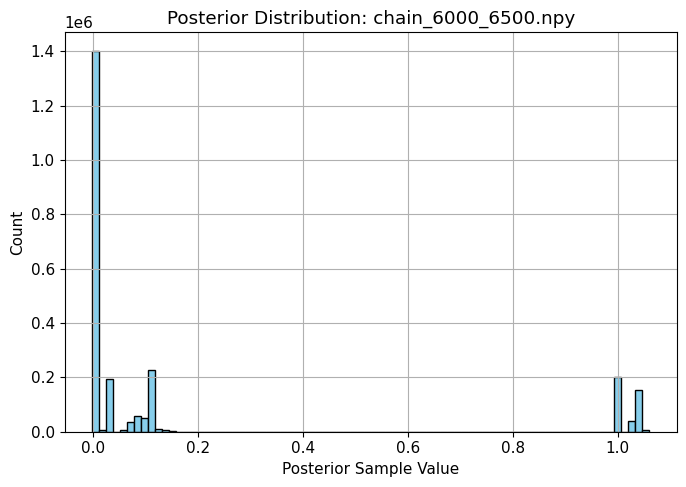

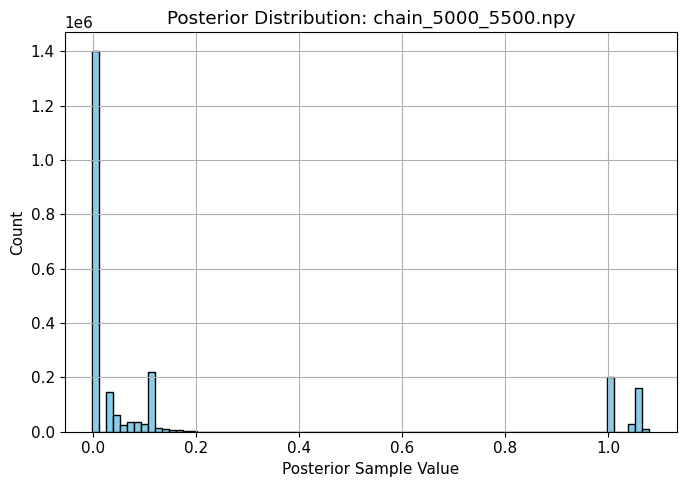

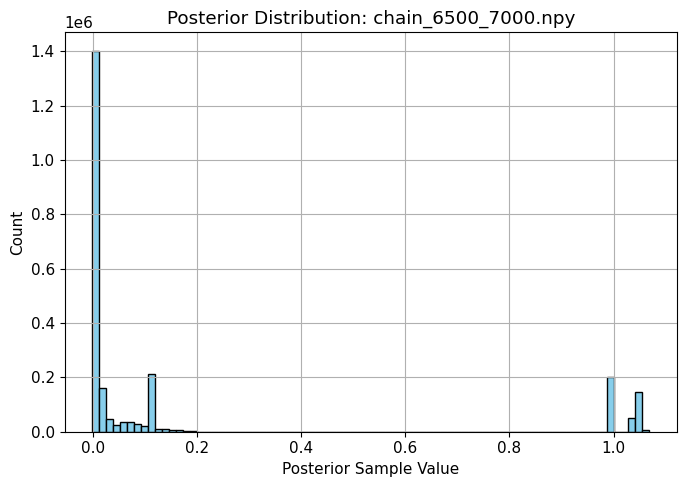

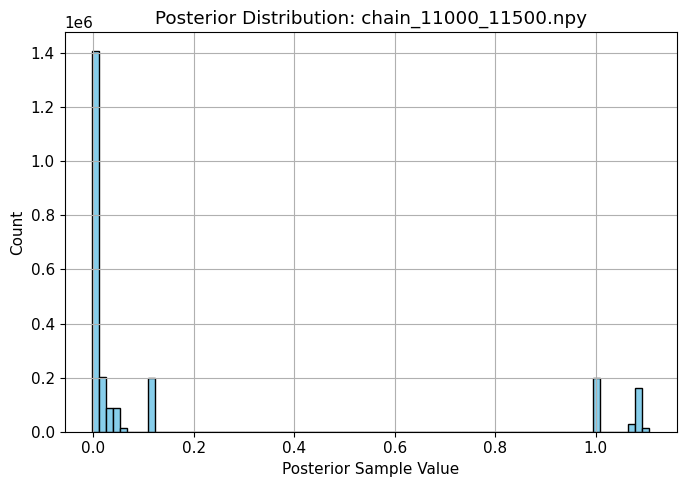

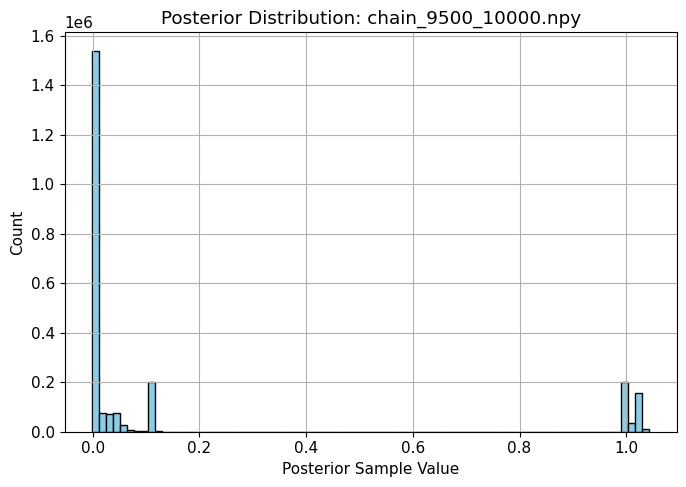

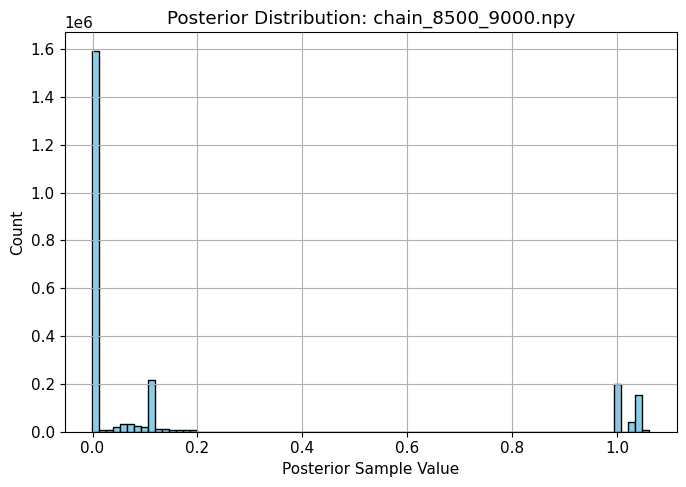

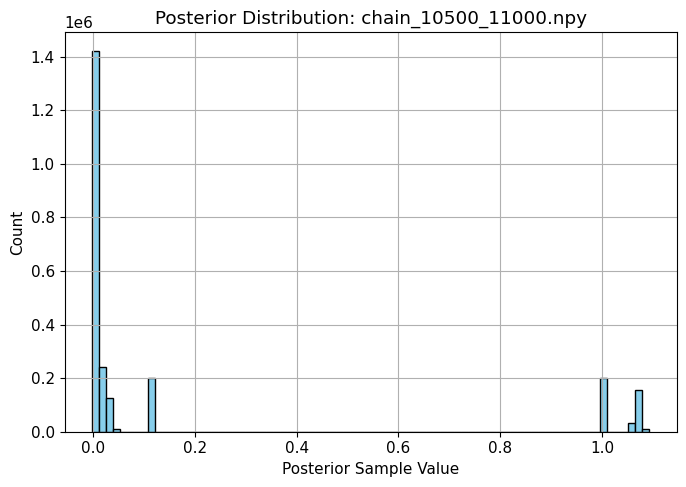

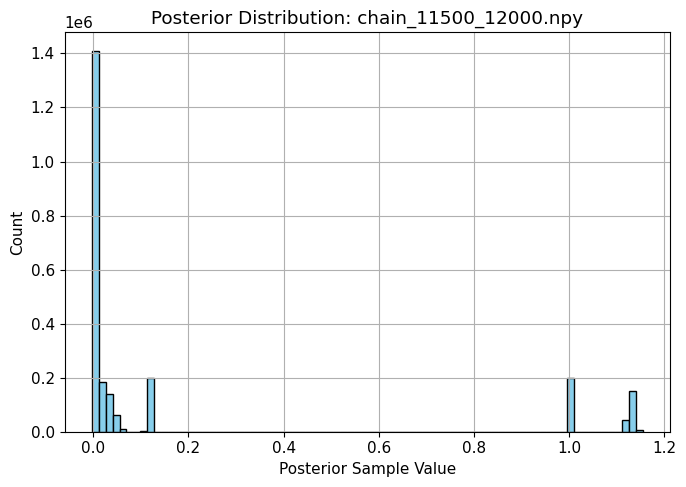

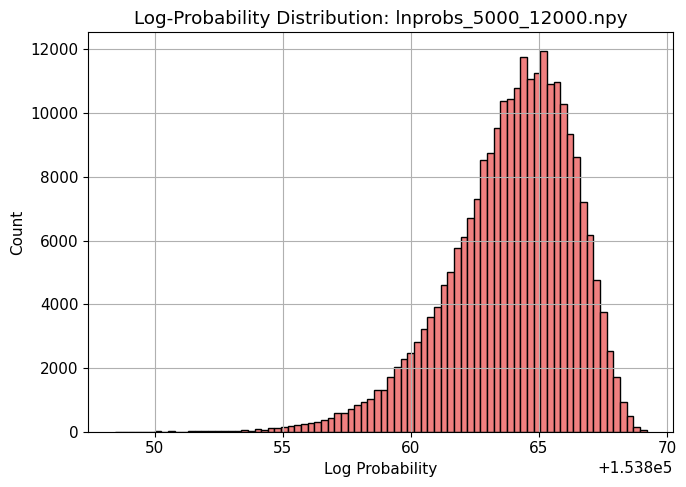

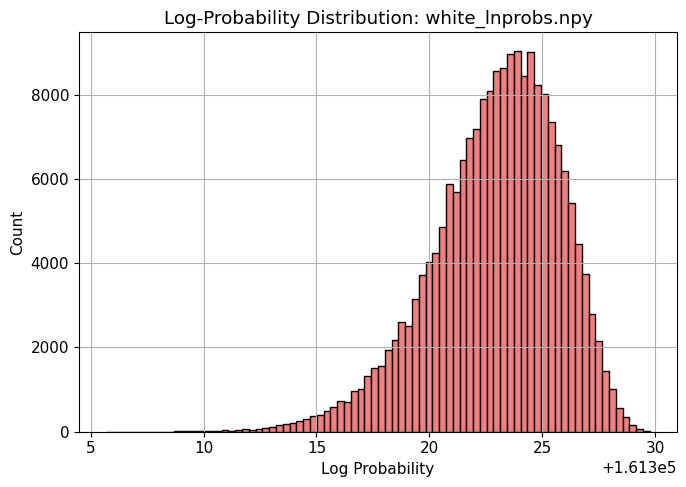

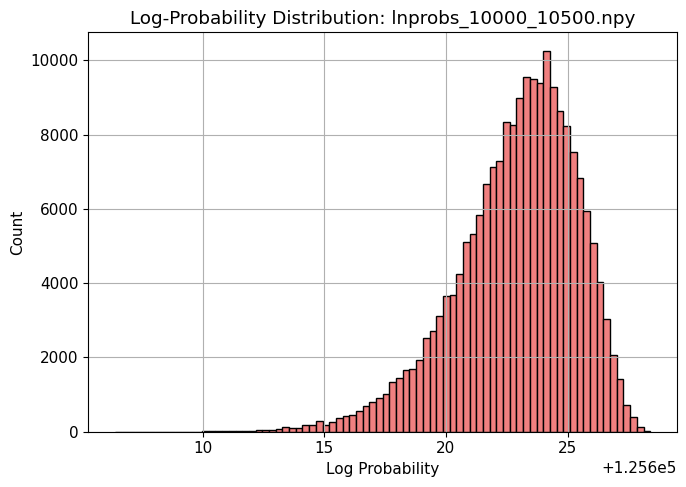

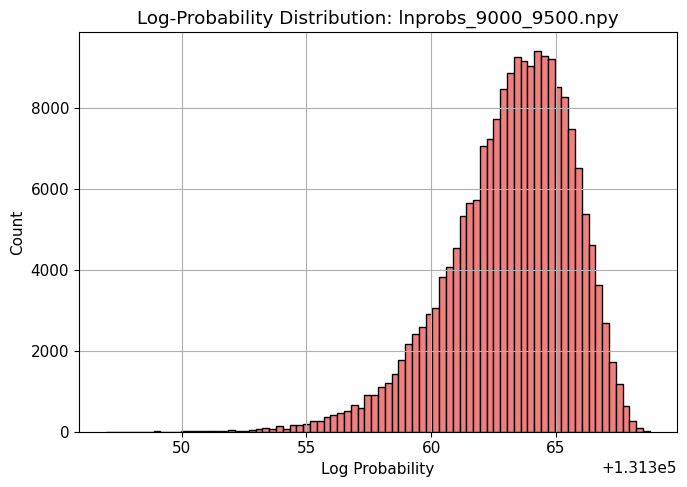

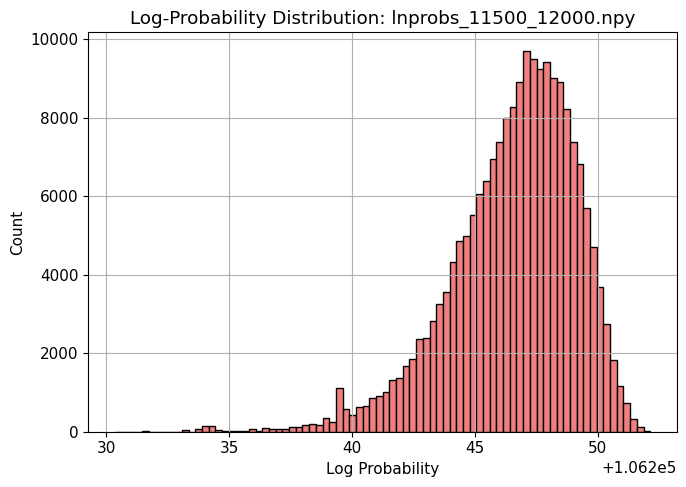

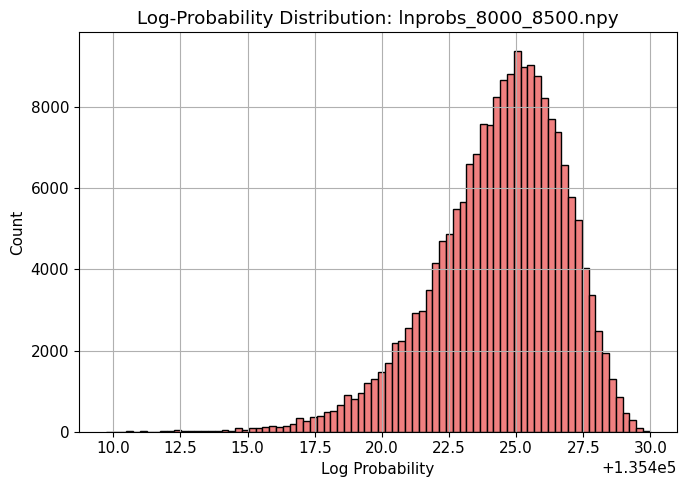

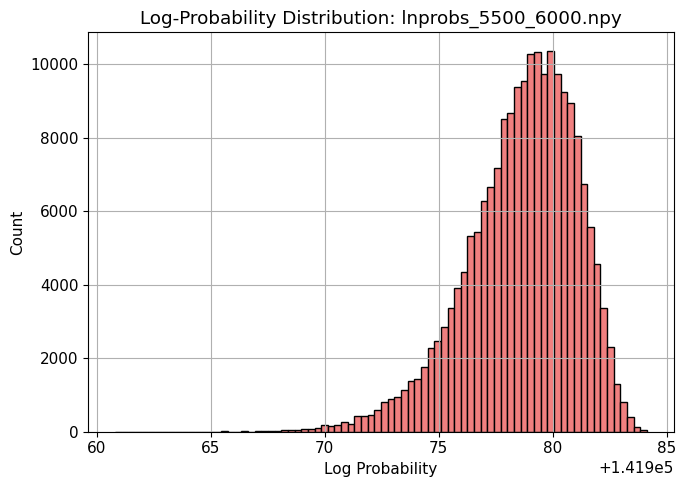

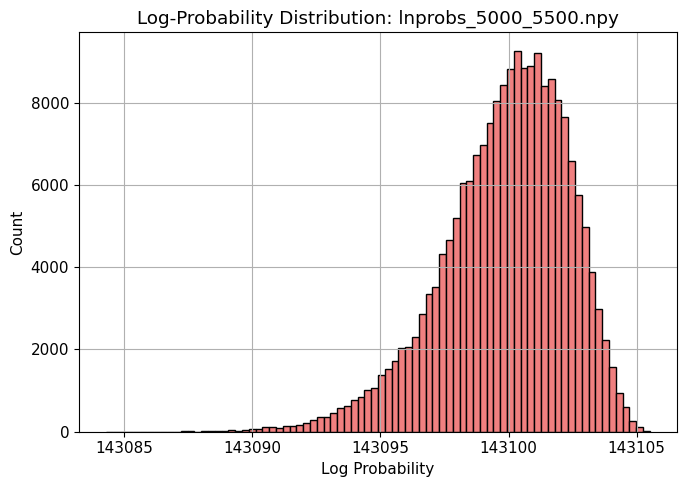

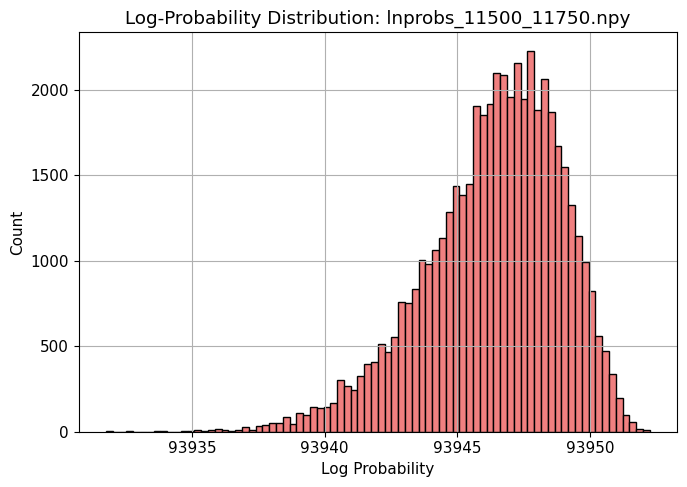

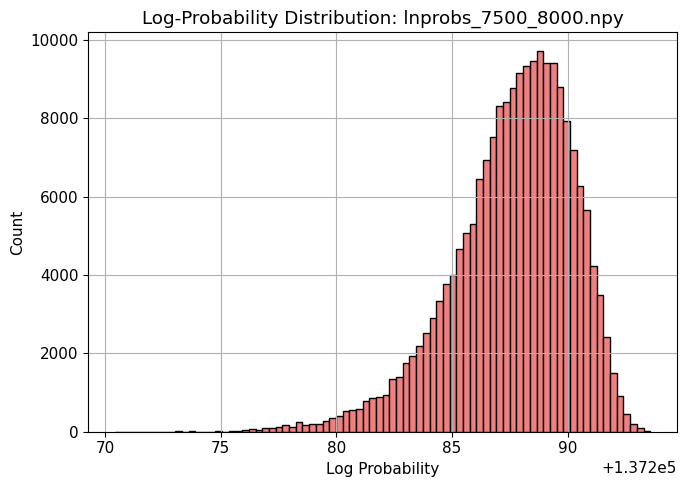

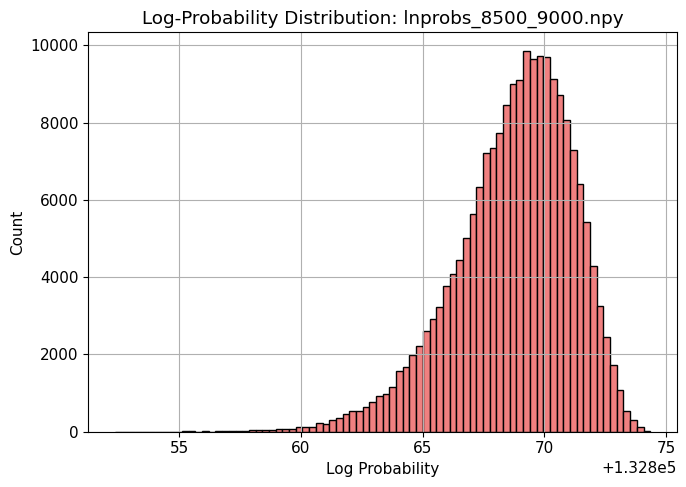

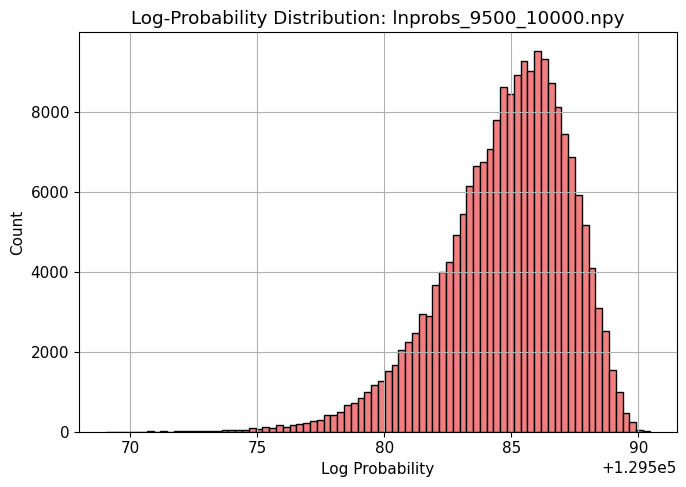

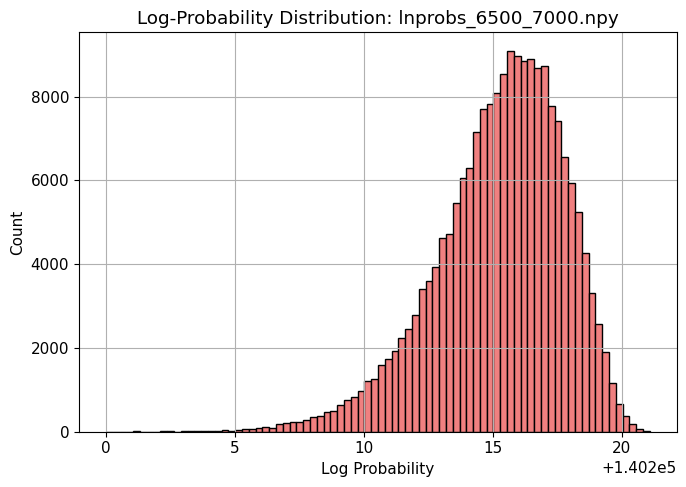

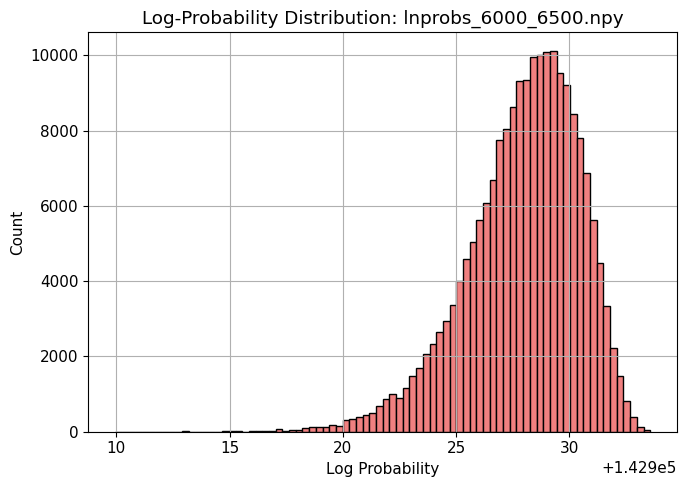

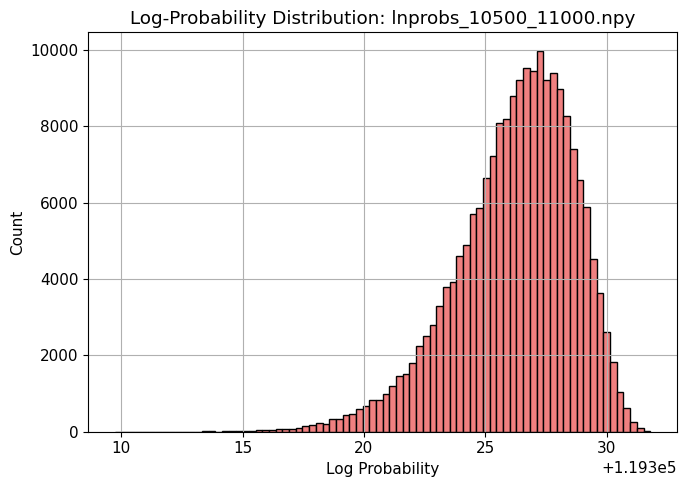

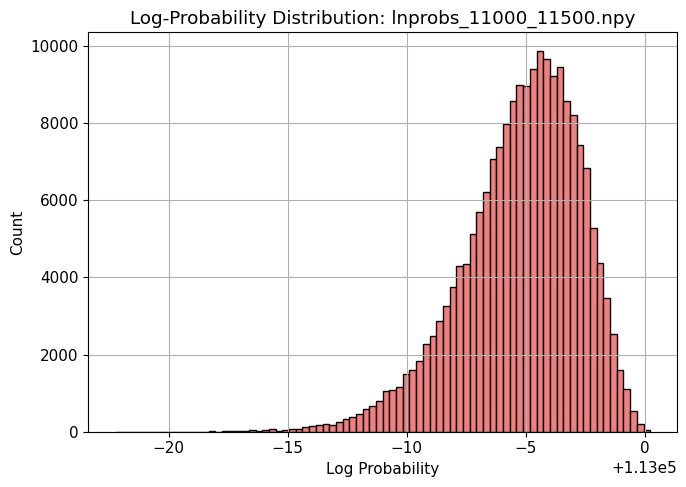

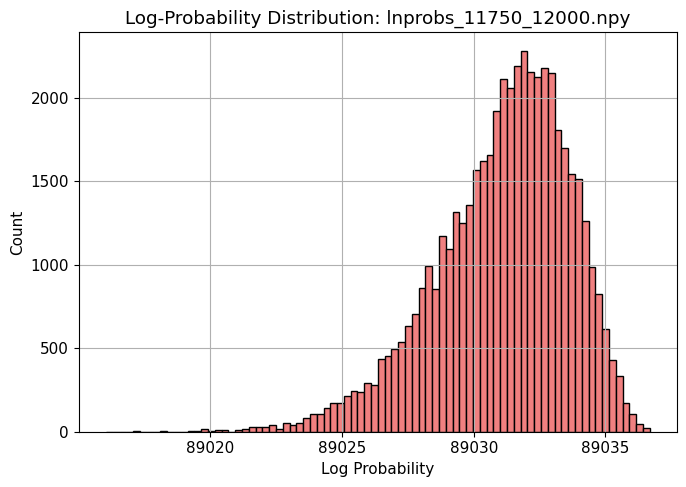

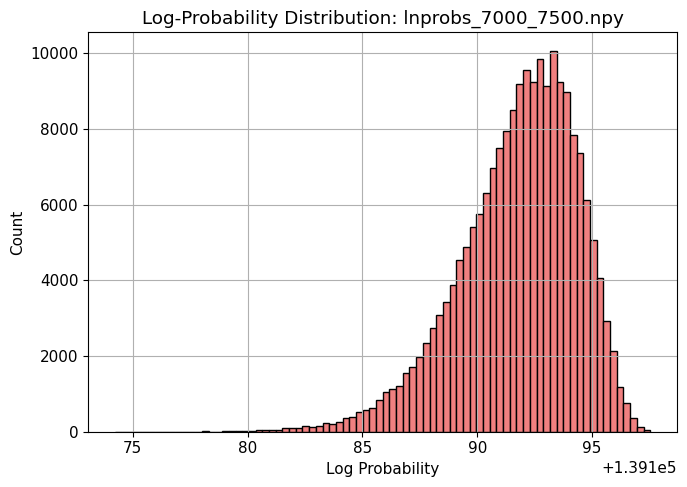

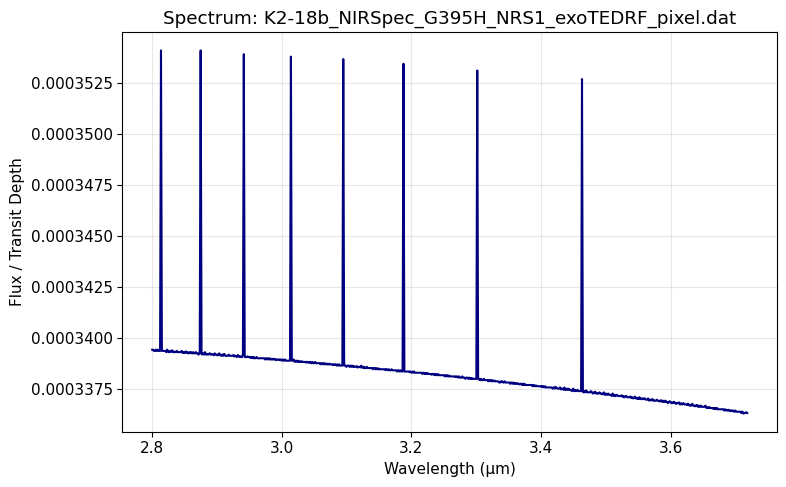

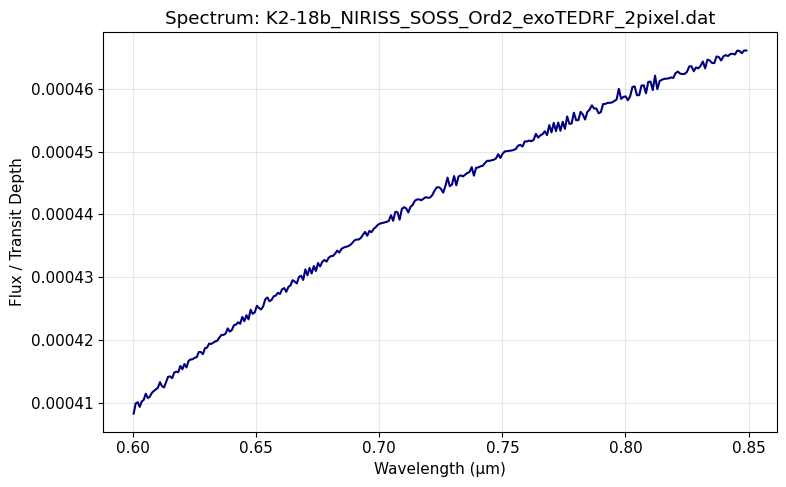

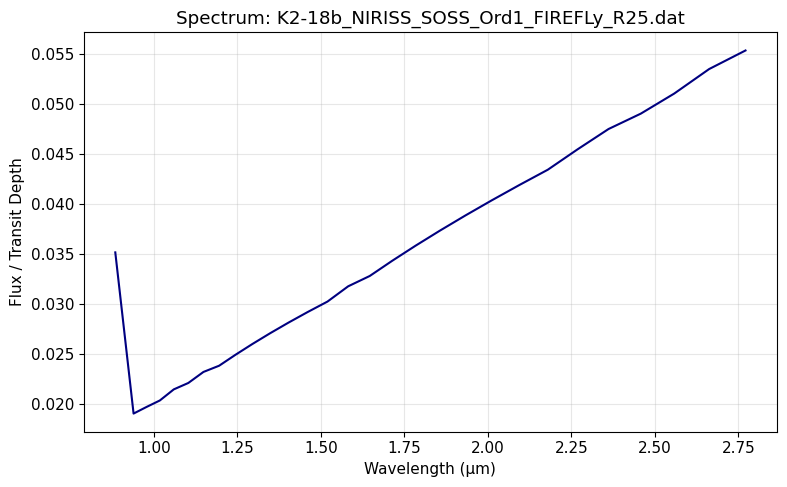

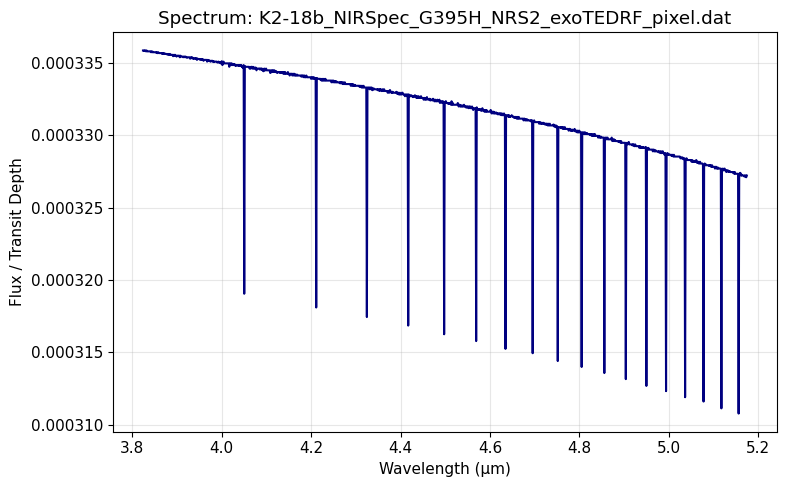

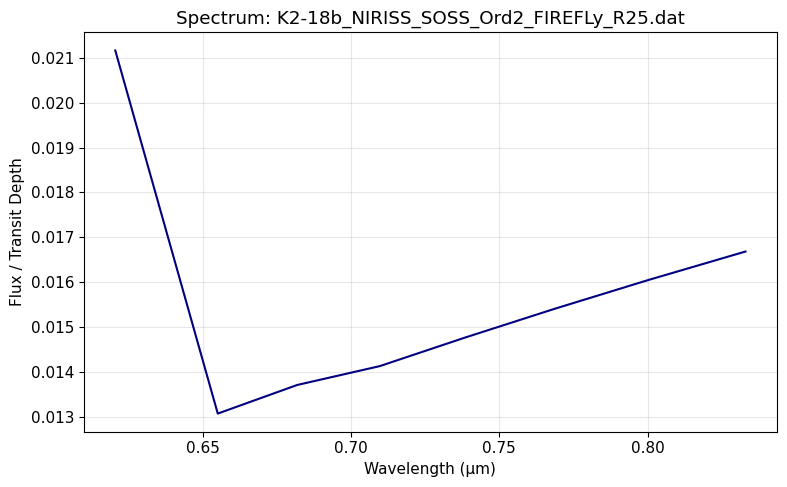

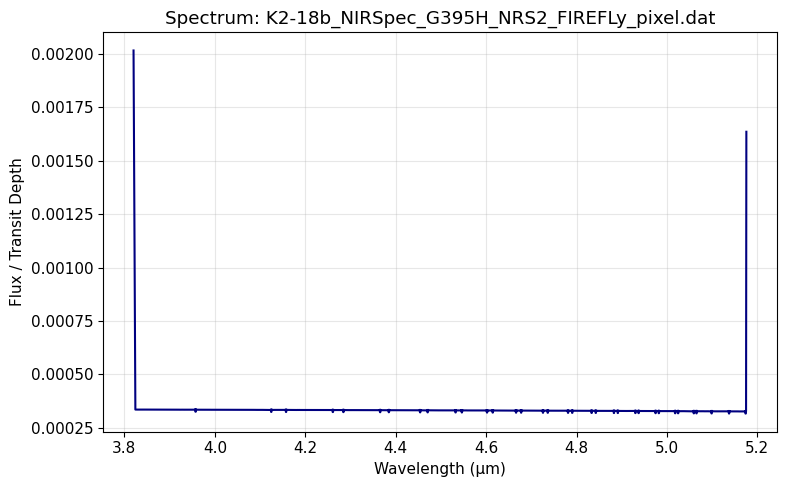

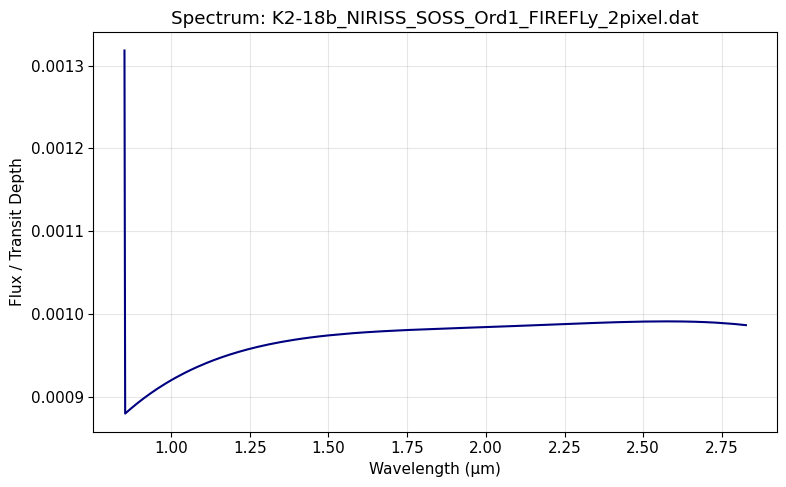

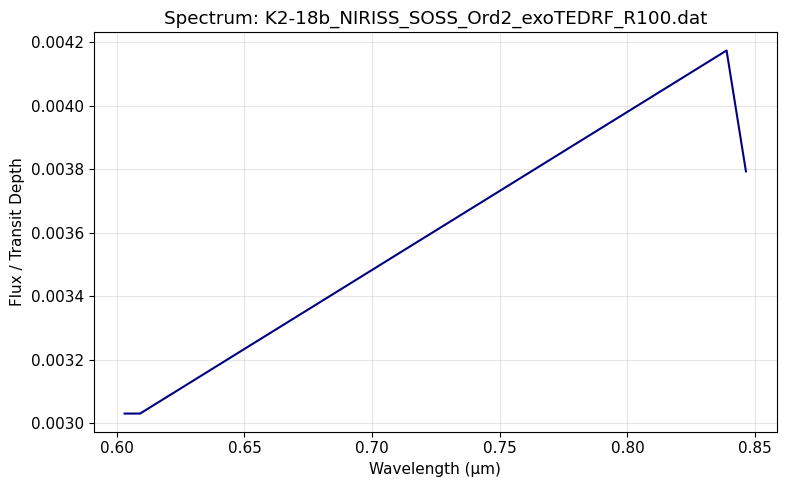

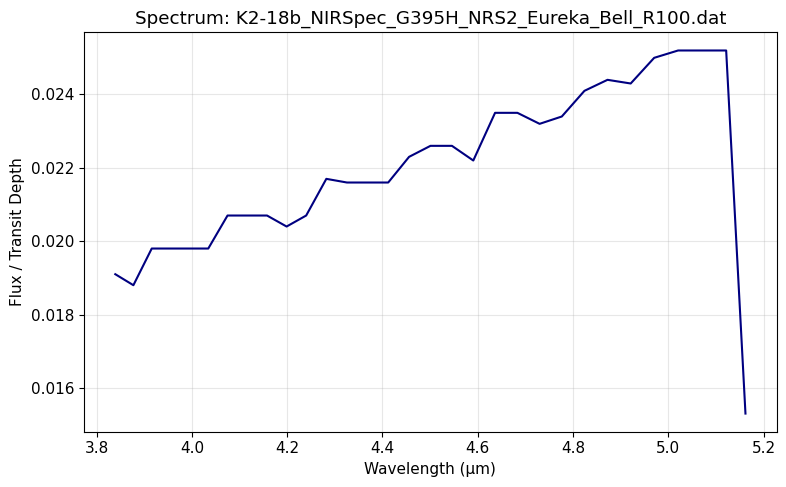

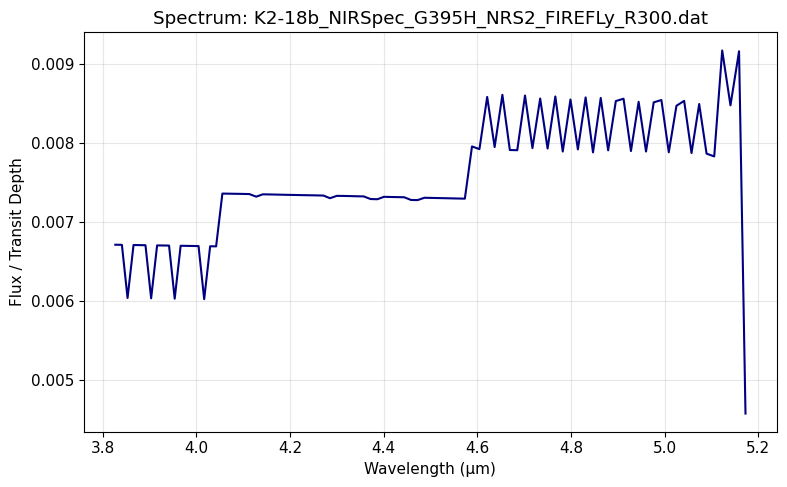

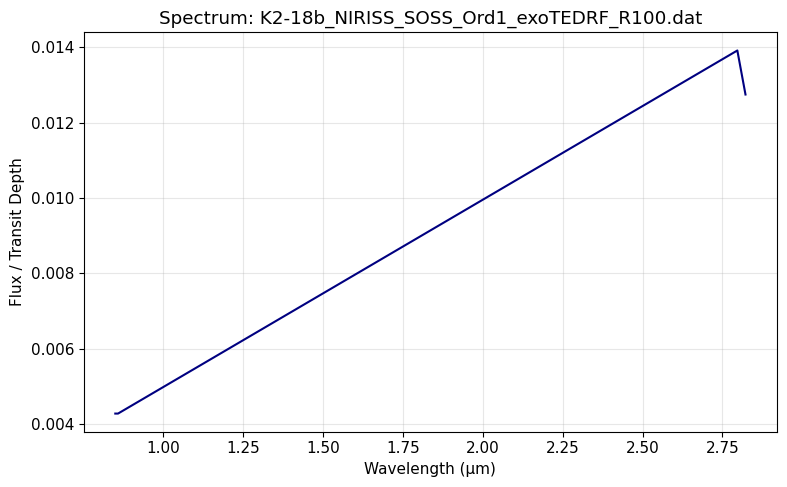

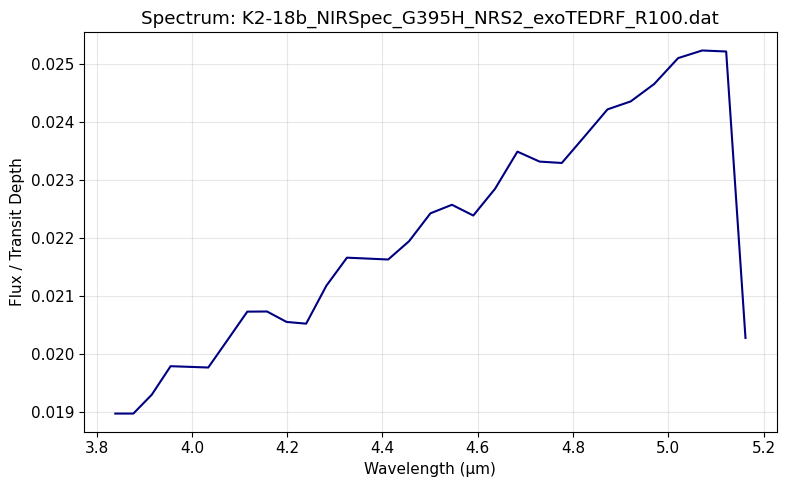

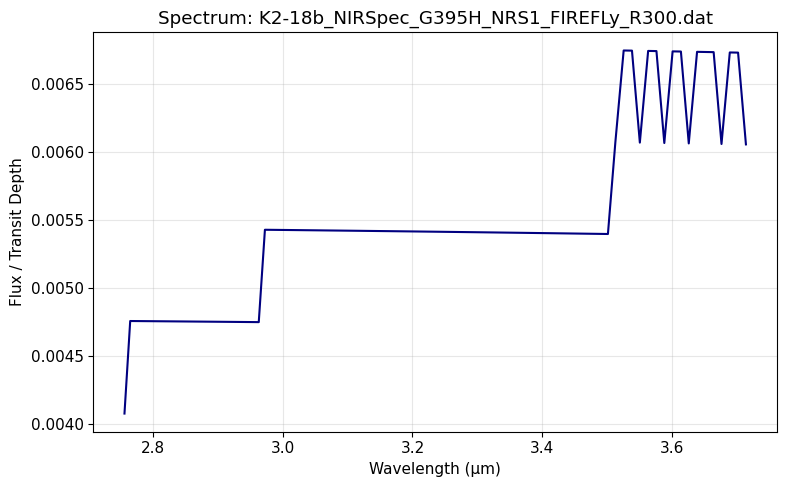

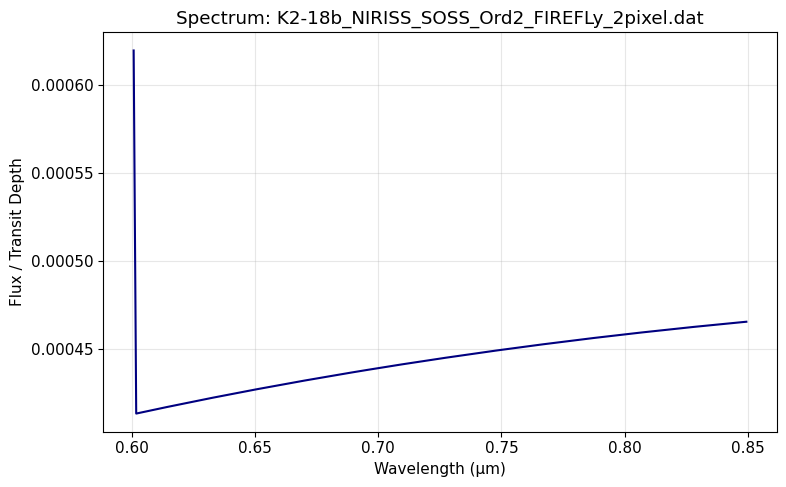

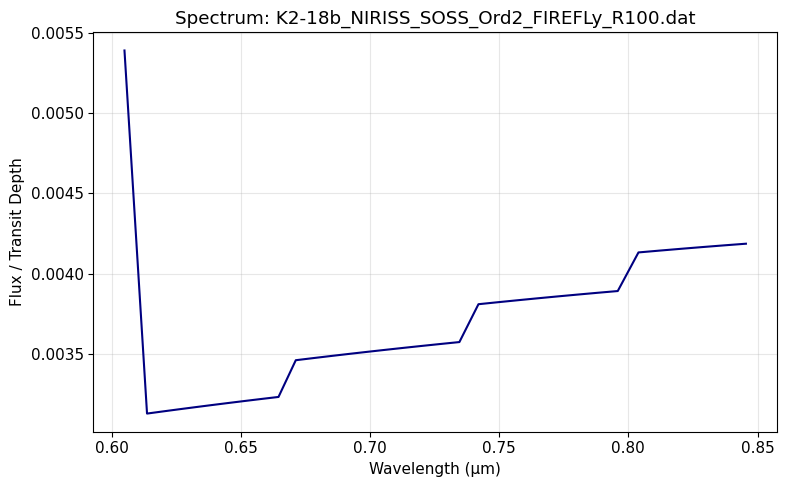

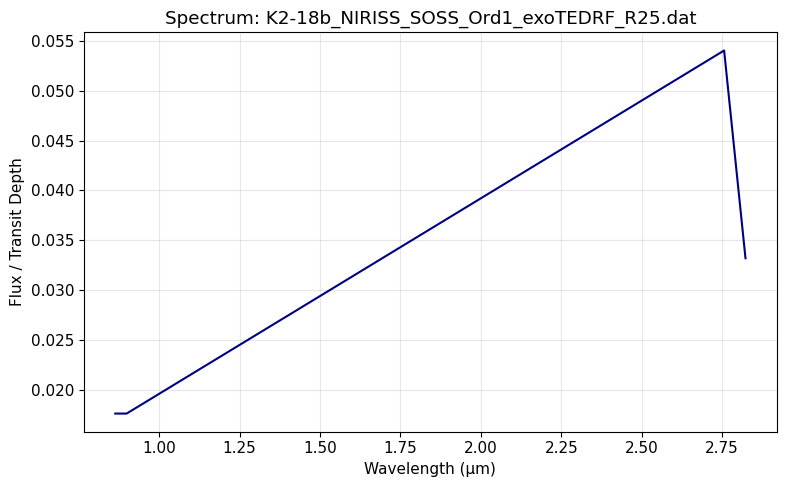

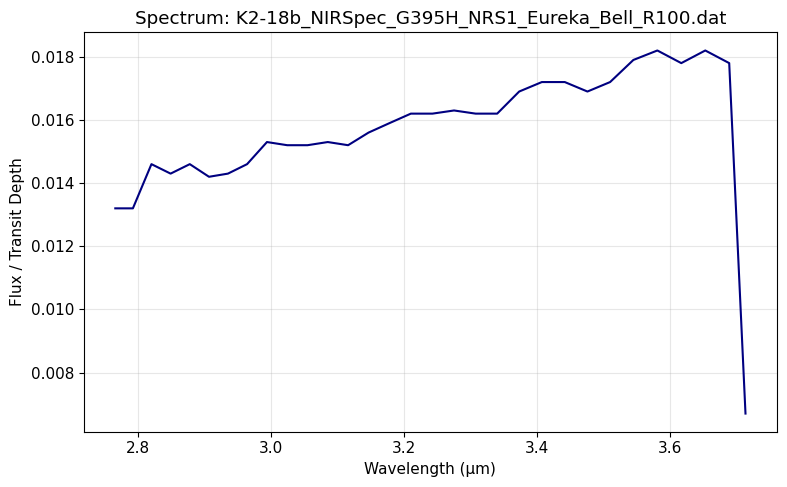

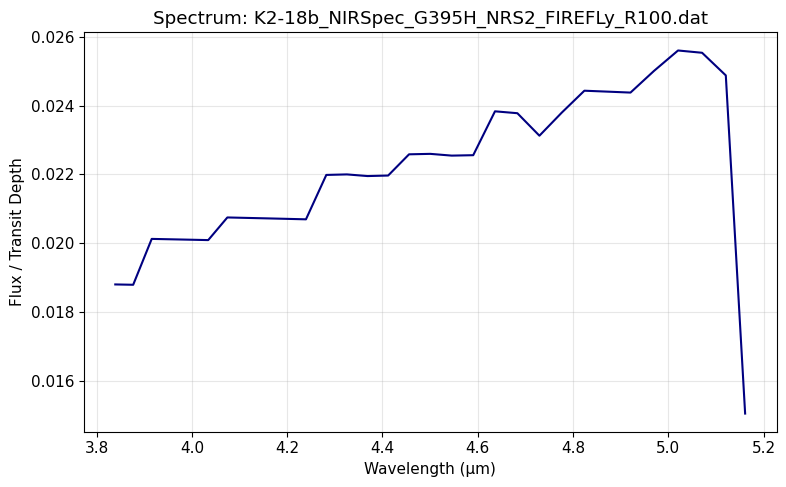

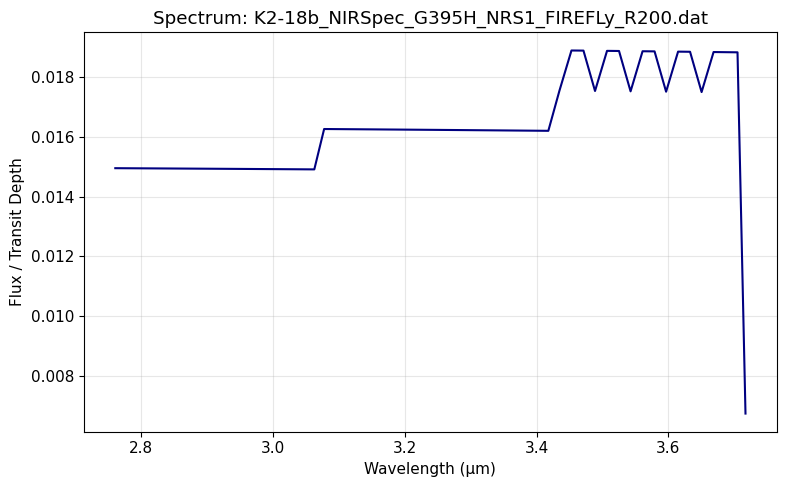

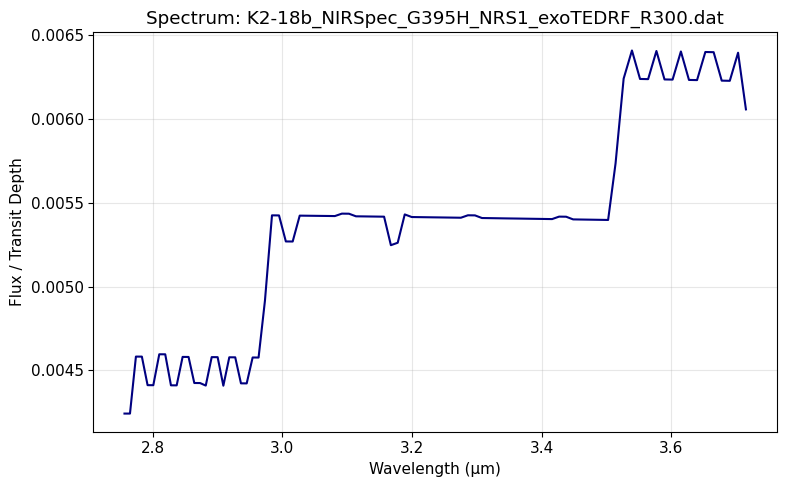

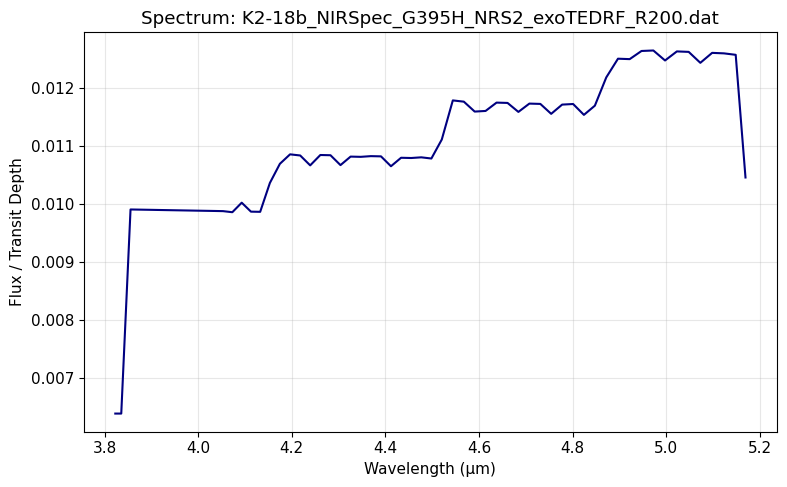

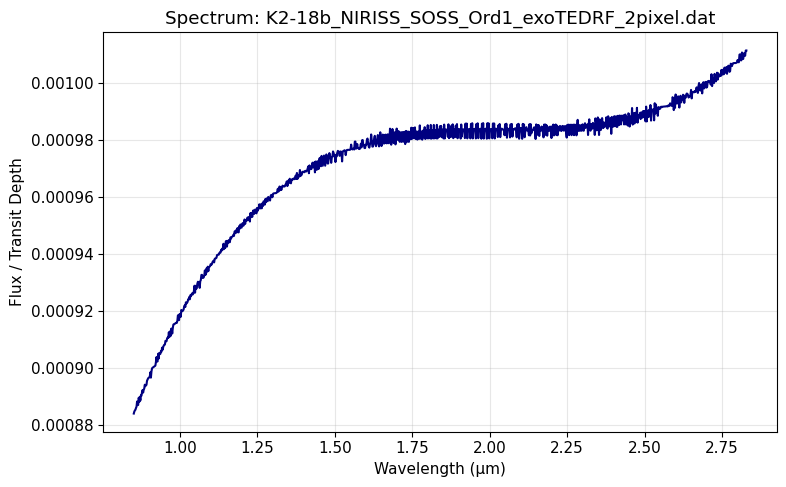

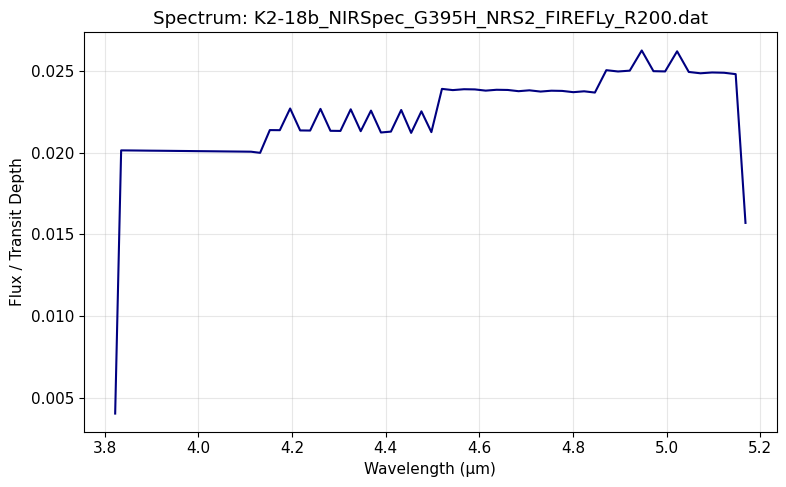

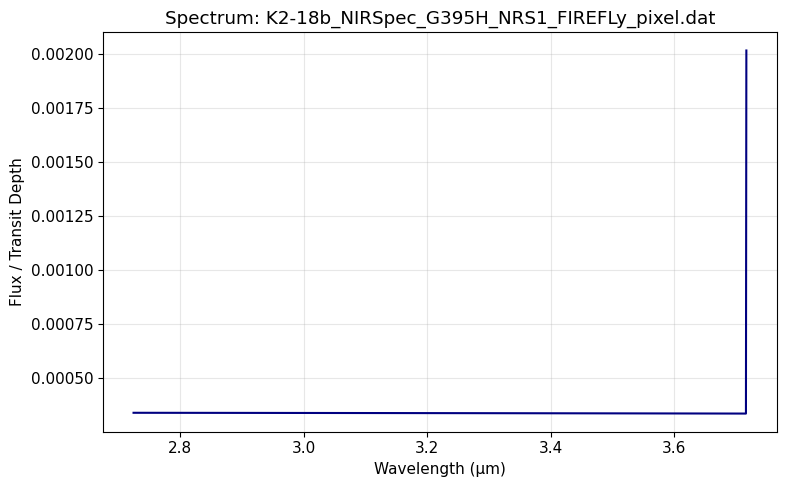

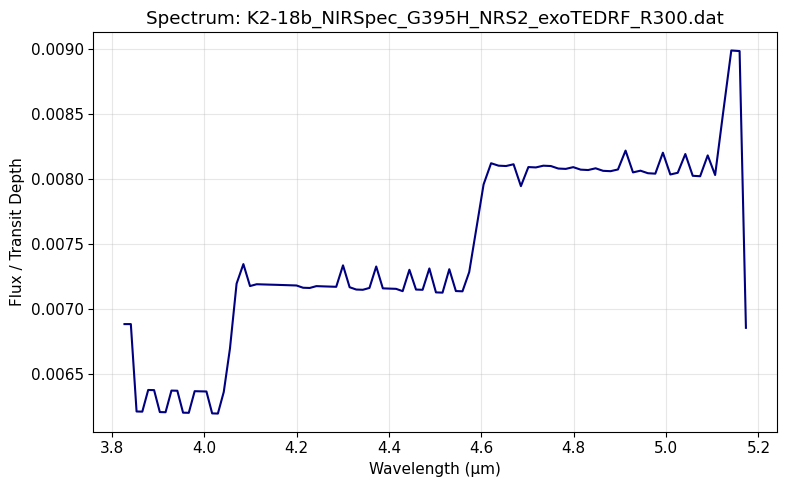

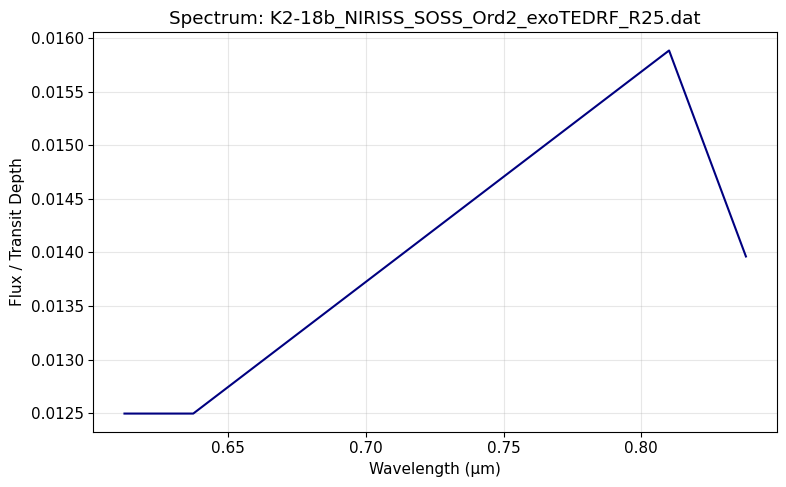

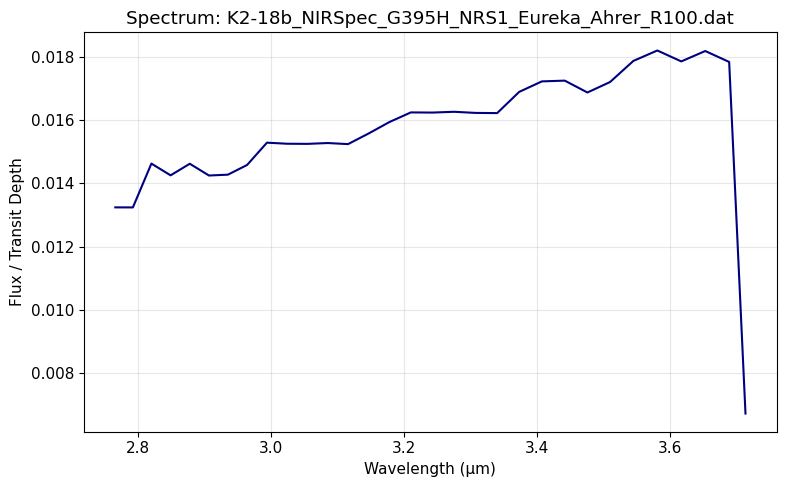

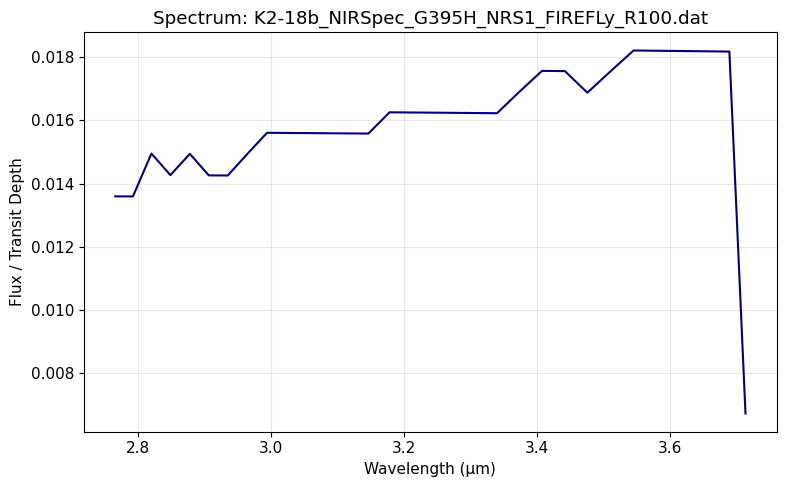

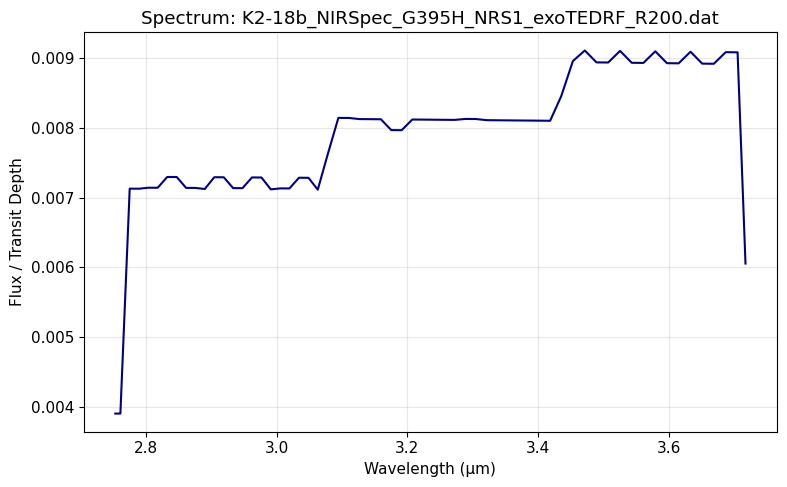

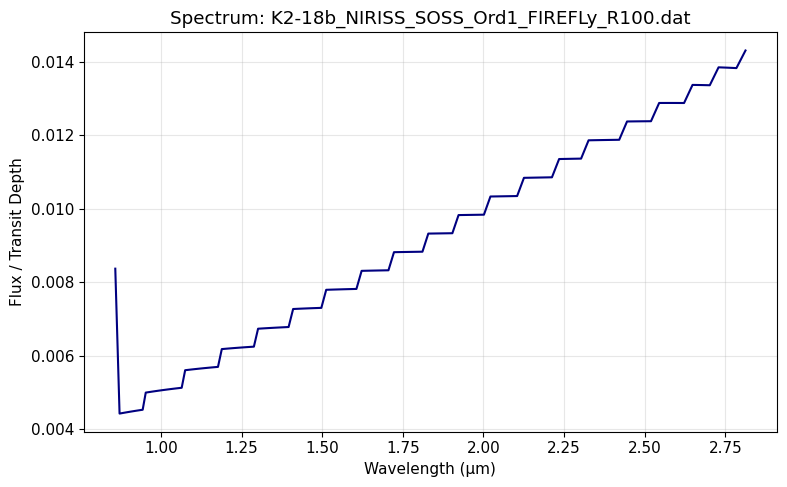

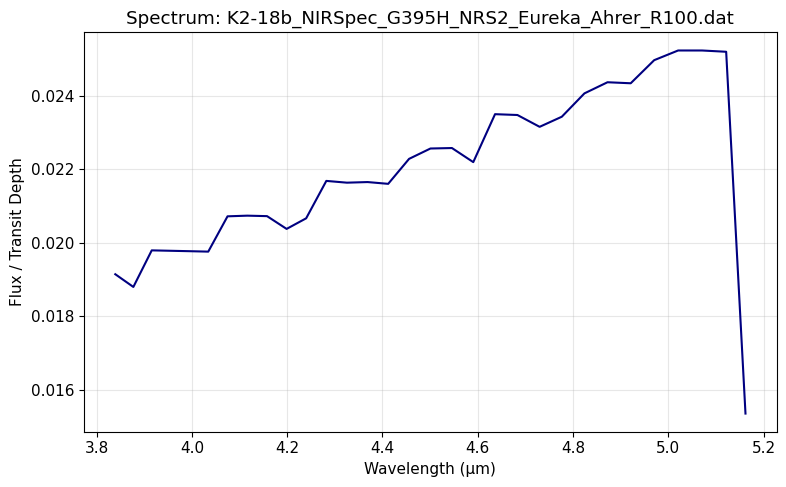

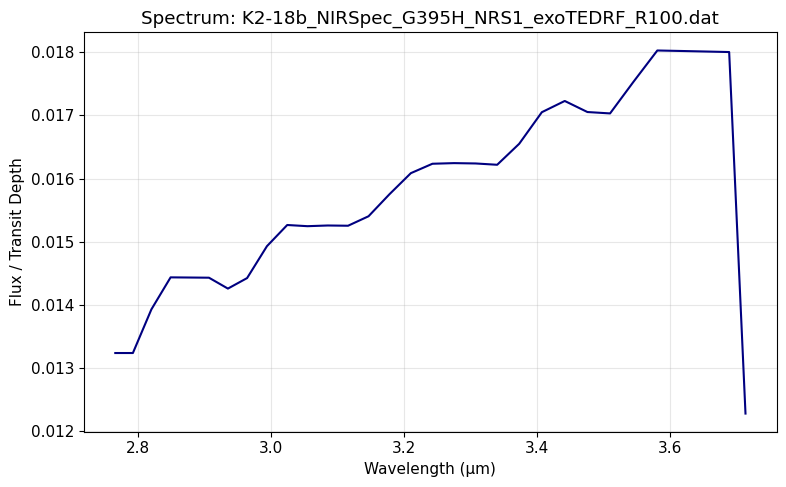

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------------------------
# 1. Plot each chain file separately
# ---------------------------
chain_files = [f for f in os.listdir() if f.startswith("chain") and f.endswith(".npy")]

for f in chain_files:
    data = np.load(f).flatten()
    plt.figure(figsize=(7,5))
    plt.hist(data, bins=80, color="skyblue", edgecolor="k")
    plt.xlabel("Posterior Sample Value")
    plt.ylabel("Count")
    plt.title(f"Posterior Distribution: {f}")
    plt.tight_layout()
    plt.show()


# ---------------------------
# 2. Plot each lnprob file separately
# ---------------------------
lnprob_files = [f for f in os.listdir() if "lnprob" in f and f.endswith(".npy")]

for f in lnprob_files:
    data = np.load(f).flatten()
    plt.figure(figsize=(7,5))
    plt.hist(data, bins=80, color="lightcoral", edgecolor="k")
    plt.xlabel("Log Probability")
    plt.ylabel("Count")
    plt.title(f"Log-Probability Distribution: {f}")
    plt.tight_layout()
    plt.show()


# ---------------------------
# 3. Plot each spectrum (.dat) file separately
# ---------------------------
dat_files = [f for f in os.listdir() if f.endswith(".dat")]

for f in dat_files:
    try:
        dat = np.loadtxt(f)
        wl, fl = dat[:,0], dat[:,1]
        plt.figure(figsize=(8,5))
        plt.plot(wl, fl, lw=1.5, color="navy")
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Flux / Transit Depth")
        plt.title(f"Spectrum: {f}")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot {f}: {e}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Create a directory for plots ---
os.makedirs("plots", exist_ok=True)

# -----------------------
# 1. Posterior Chains Histograms
# -----------------------
chain_files = [
    "chain_5000_5500.npy", "chain_5500_6000.npy", "chain_6000_6500.npy",
    "chain_6500_7000.npy", "chain_7000_7500.npy", "chain_7500_8000.npy",
    "chain_8000_8500.npy", "chain_8500_9000.npy", "chain_9000_9500.npy",
    "chain_9500_10000.npy", "chain_10000_10500.npy", "chain_10500_11000.npy",
    "chain_11000_11500.npy", "chain_11500_12000.npy"
]

for f in chain_files:
    try:
        chain = np.load(f)
        # Choose 1 column (PEHI-like proxy) – here using col 0 as placeholder
        data = chain[:,0] if chain.ndim > 1 else chain

        plt.figure(figsize=(7,5))
        plt.hist(data, bins=200, color="teal", alpha=0.7)
        plt.title(f"Posterior Distribution - {f}")
        plt.xlabel("PEHI Value (proxy)")
        plt.ylabel("Frequency")

        # Save
        out_png = os.path.join("plots", f"{f}_hist.png")
        out_pdf = os.path.join("plots", f"{f}_hist.pdf")
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        plt.savefig(out_pdf, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✅ Saved {out_png} and {out_pdf}")
    except Exception as e:
        print(f"⚠️ Could not process {f}: {e}")

# -----------------------
# 2. DAT Files (Spectra)
# -----------------------
dat_files = [
    "K2-18b_NIRISS_SOSS_Ord1_FIREFly_2pixel.dat",
    "K2-18b_NIRISS_SOSS_Ord1_FIREFly_R100.dat",
    "K2-18b_NIRISS_SOSS_Ord1_FIREFly_R25.dat",
    "K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_2pixel.dat",
    "K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R100.dat",
    "K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R25.dat",
    "K2-18b_NIRSpec_G395H_NRS1_Eureka_Ahrer_R100.dat",
    "K2-18b_NIRSpec_G395H_NRS1_FIREFly_R200.dat",
    "K2-18b_NIRSpec_G395H_NRS1_FIREFly_R300.dat",
    "K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R200.dat",
    "K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R300.dat"
]

for f in dat_files:
    try:
        dat = np.loadtxt(f)
        wavelength, flux = dat[:,0], dat[:,1]

        plt.figure(figsize=(8,5))
        plt.plot(wavelength, flux, lw=1.5)
        plt.title(f"Spectrum - {f}")
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Flux / Transit Depth")

        # Save
        out_png = os.path.join("plots", f"{f}_spectrum.png")
        out_pdf = os.path.join("plots", f"{f}_spectrum.pdf")
        plt.savefig(out_png, dpi=300, bbox_inches="tight")
        plt.savefig(out_pdf, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✅ Saved {out_png} and {out_pdf}")
    except Exception as e:
        print(f"⚠️ Could not process {f}: {e}")


✅ Saved plots/chain_5000_5500.npy_hist.png and plots/chain_5000_5500.npy_hist.pdf
✅ Saved plots/chain_5500_6000.npy_hist.png and plots/chain_5500_6000.npy_hist.pdf
✅ Saved plots/chain_6000_6500.npy_hist.png and plots/chain_6000_6500.npy_hist.pdf
✅ Saved plots/chain_6500_7000.npy_hist.png and plots/chain_6500_7000.npy_hist.pdf
✅ Saved plots/chain_7000_7500.npy_hist.png and plots/chain_7000_7500.npy_hist.pdf
✅ Saved plots/chain_7500_8000.npy_hist.png and plots/chain_7500_8000.npy_hist.pdf
✅ Saved plots/chain_8000_8500.npy_hist.png and plots/chain_8000_8500.npy_hist.pdf
✅ Saved plots/chain_8500_9000.npy_hist.png and plots/chain_8500_9000.npy_hist.pdf
✅ Saved plots/chain_9000_9500.npy_hist.png and plots/chain_9000_9500.npy_hist.pdf
✅ Saved plots/chain_9500_10000.npy_hist.png and plots/chain_9500_10000.npy_hist.pdf
✅ Saved plots/chain_10000_10500.npy_hist.png and plots/chain_10000_10500.npy_hist.pdf
✅ Saved plots/chain_10500_11000.npy_hist.png and plots/chain_10500_11000.npy_hist.pdf
✅ Save

In [ ]:
import os
os.listdir("plots")


['chain_11000_11500.npy_hist.png',
 'chain_11500_12000.npy_hist.pdf',
 'chain_6500_7000.npy_hist.png',
 'K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R300.dat_spectrum.pdf',
 'chain_7000_7500.npy_hist.pdf',
 'K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R200.dat_spectrum.png',
 'K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R100.dat_spectrum.png',
 'chain_7500_8000.npy_hist.pdf',
 'chain_10000_10500.npy_hist.png',
 'chain_5500_6000.npy_hist.png',
 'chain_9000_9500.npy_hist.png',
 'chain_7500_8000.npy_hist.png',
 'K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R25.dat_spectrum.pdf',
 'K2-18b_NIRSpec_G395H_NRS1_Eureka_Ahrer_R100.dat_spectrum.pdf',
 'chain_5000_5500.npy_hist.pdf',
 'chain_8500_9000.npy_hist.pdf',
 'chain_10000_10500.npy_hist.pdf',
 'chain_6000_6500.npy_hist.png',
 'chain_6000_6500.npy_hist.pdf',
 'chain_9500_10000.npy_hist.png',
 'K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R100.dat_spectrum.pdf',
 'chain_10500_11000.npy_hist.pdf',
 'K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_2pixel.dat_spectrum.pdf',
 'chain_8500_9000.npy_hist.png',
 'ch

In [ ]:
!zip -r plots.zip plots


  adding: plots/ (stored 0%)
  adding: plots/chain_11000_11500.npy_hist.png (deflated 24%)
  adding: plots/chain_11500_12000.npy_hist.pdf (deflated 28%)
  adding: plots/chain_6500_7000.npy_hist.png (deflated 23%)
  adding: plots/K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R300.dat_spectrum.pdf (deflated 31%)
  adding: plots/chain_7000_7500.npy_hist.pdf (deflated 29%)
  adding: plots/K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R200.dat_spectrum.png (deflated 16%)
  adding: plots/K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R100.dat_spectrum.png (deflated 17%)
  adding: plots/chain_7500_8000.npy_hist.pdf (deflated 28%)
  adding: plots/chain_10000_10500.npy_hist.png (deflated 23%)
  adding: plots/chain_5500_6000.npy_hist.png (deflated 23%)
  adding: plots/chain_9000_9500.npy_hist.png (deflated 23%)
  adding: plots/chain_7500_8000.npy_hist.png (deflated 23%)
  adding: plots/K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R25.dat_spectrum.pdf (deflated 33%)
  adding: plots/K2-18b_NIRSpec_G395H_NRS1_Eureka_Ahrer_R100.dat_spectrum.pdf (

In [ ]:
import numpy as np
import pandas as pd
import os

# Chain files to summarize
chain_files = [
    "chain_5000_5500.npy", "chain_5500_6000.npy", "chain_6000_6500.npy",
    "chain_6500_7000.npy", "chain_7000_7500.npy", "chain_7500_8000.npy",
    "chain_8000_8500.npy", "chain_8500_9000.npy", "chain_9000_9500.npy",
    "chain_9500_10000.npy", "chain_10000_10500.npy", "chain_10500_11000.npy",
    "chain_11000_11500.npy", "chain_11500_12000.npy"
]

results = []

for f in chain_files:
    try:
        chain = np.load(f)
        data = chain[:,0] if chain.ndim > 1 else chain  # pick first column as PEHI proxy

        mean_val = np.mean(data)
        std_val = np.std(data)
        ci_low, ci_high = np.percentile(data, [2.5, 97.5])

        results.append({
            "File": f,
            "Mean": mean_val,
            "StdDev": std_val,
            "95% CI Low": ci_low,
            "95% CI High": ci_high
        })
    except Exception as e:
        print(f"⚠️ Could not process {f}: {e}")

# Convert to DataFrame
df = pd.DataFrame(results)

# Save CSV
df.to_csv("PEHI_summary.csv", index=False)
print("✅ Saved PEHI_summary.csv")

# Save LaTeX table (for paper)
with open("PEHI_summary.tex", "w") as f:
    f.write(df.to_latex(index=False, float_format="%.3e"))
print("✅ Saved PEHI_summary.tex (LaTeX table for paper)")


✅ Saved PEHI_summary.csv
✅ Saved PEHI_summary.tex (LaTeX table for paper)


In [ ]:
import numpy as np
import pandas as pd

chain_files = [
    "chain_5000_5500.npy", "chain_5500_6000.npy", "chain_6000_6500.npy",
    "chain_6500_7000.npy", "chain_7000_7500.npy", "chain_7500_8000.npy",
    "chain_8000_8500.npy", "chain_8500_9000.npy", "chain_9000_9500.npy",
    "chain_9500_10000.npy", "chain_10000_10500.npy", "chain_10500_11000.npy",
    "chain_11000_11500.npy", "chain_11500_12000.npy"
]

results = []

for f in chain_files:
    try:
        chain = np.load(f)
        data = chain[:,0] if chain.ndim > 1 else chain  # first column = PEHI proxy

        mean_val = np.mean(data)
        std_val = np.std(data)
        ci_low, ci_high = np.percentile(data, [2.5, 97.5])

        results.append({
            "File": f,
            "Mean": mean_val,
            "StdDev": std_val,
            "95% CI Low": ci_low,
            "95% CI High": ci_high
        })
    except Exception as e:
        print(f"⚠️ Could not process {f}: {e}")

# Convert to DataFrame
df = pd.DataFrame(results)

# Save outputs
df.to_csv("PEHI_summary.csv", index=False)
with open("PEHI_summary.tex", "w") as f:
    f.write(df.to_latex(index=False, float_format="%.3e"))

# Show the table directly
print("✅ Saved PEHI_summary.csv and PEHI_summary.tex")
print("\n=== Preview of Summary Table ===\n")
print(df.to_string(index=False, float_format="%.3e"))


✅ Saved PEHI_summary.csv and PEHI_summary.tex

=== Preview of Summary Table ===

                 File      Mean    StdDev  95% CI Low  95% CI High
  chain_5000_5500.npy 1.343e-04 2.971e-05   7.595e-05    1.934e-04
  chain_5500_6000.npy 1.833e-04 3.011e-05   1.254e-04    2.418e-04
  chain_6000_6500.npy 2.280e-04 2.912e-05   1.720e-04    2.852e-04
  chain_6500_7000.npy 2.409e-04 3.319e-05   1.769e-04    3.066e-04
  chain_7000_7500.npy 3.239e-04 3.897e-05   2.460e-04    3.982e-04
  chain_7500_8000.npy 4.279e-04 4.359e-05   3.466e-04    5.176e-04
  chain_8000_8500.npy 4.739e-04 4.024e-05   3.950e-04    5.531e-04
  chain_8500_9000.npy 6.303e-04 4.587e-05   5.401e-04    7.197e-04
  chain_9000_9500.npy 6.039e-04 4.920e-05   5.083e-04    7.008e-04
 chain_9500_10000.npy 7.575e-04 5.720e-05   6.440e-04    8.690e-04
chain_10000_10500.npy 8.807e-04 6.935e-05   7.448e-04    1.014e-03
chain_10500_11000.npy 9.617e-04 8.300e-05   7.980e-04    1.123e-03
chain_11000_11500.npy 1.172e-03 1.135e-04   9.43

In [ ]:
import numpy as np
import pandas as pd

chain_files = [
    "chain_5000_5500.npy", "chain_5500_6000.npy", "chain_6000_6500.npy",
    "chain_6500_7000.npy", "chain_7000_7500.npy", "chain_7500_8000.npy",
    "chain_8000_8500.npy", "chain_8500_9000.npy", "chain_9000_9500.npy",
    "chain_9500_10000.npy", "chain_10000_10500.npy", "chain_10500_11000.npy",
    "chain_11000_11500.npy", "chain_11500_12000.npy"
]

results = []
all_data = []

for f in chain_files:
    try:
        chain = np.load(f)
        data = chain[:,0] if chain.ndim > 1 else chain  # PEHI proxy in col 0
        all_data.append(data)

        mean_val = np.mean(data)
        std_val = np.std(data)
        ci_low, ci_high = np.percentile(data, [2.5, 97.5])

        results.append({
            "File": f,
            "Mean": mean_val,
            "StdDev": std_val,
            "95% CI Low": ci_low,
            "95% CI High": ci_high
        })
    except Exception as e:
        print(f"⚠️ Could not process {f}: {e}")

# Compute global stats
if all_data:
    combined = np.concatenate(all_data)
    g_mean = np.mean(combined)
    g_std = np.std(combined)
    g_ci_low, g_ci_high = np.percentile(combined, [2.5, 97.5])

    results.append({
        "File": "GLOBAL",
        "Mean": g_mean,
        "StdDev": g_std,
        "95% CI Low": g_ci_low,
        "95% CI High": g_ci_high
    })

# Convert to DataFrame
df = pd.DataFrame(results)

# Save outputs
df.to_csv("PEHI_summary.csv", index=False)
with open("PEHI_summary.tex", "w") as f:
    f.write(df.to_latex(index=False, float_format="%.3e"))

# Show the table directly
print("✅ Saved PEHI_summary.csv and PEHI_summary.tex")
print("\n=== Summary Table (per chain + global) ===\n")
print(df.to_string(index=False, float_format="%.3e"))


✅ Saved PEHI_summary.csv and PEHI_summary.tex

=== Summary Table (per chain + global) ===

                 File      Mean    StdDev  95% CI Low  95% CI High
  chain_5000_5500.npy 1.343e-04 2.971e-05   7.595e-05    1.934e-04
  chain_5500_6000.npy 1.833e-04 3.011e-05   1.254e-04    2.418e-04
  chain_6000_6500.npy 2.280e-04 2.912e-05   1.720e-04    2.852e-04
  chain_6500_7000.npy 2.409e-04 3.319e-05   1.769e-04    3.066e-04
  chain_7000_7500.npy 3.239e-04 3.897e-05   2.460e-04    3.982e-04
  chain_7500_8000.npy 4.279e-04 4.359e-05   3.466e-04    5.176e-04
  chain_8000_8500.npy 4.739e-04 4.024e-05   3.950e-04    5.531e-04
  chain_8500_9000.npy 6.303e-04 4.587e-05   5.401e-04    7.197e-04
  chain_9000_9500.npy 6.039e-04 4.920e-05   5.083e-04    7.008e-04
 chain_9500_10000.npy 7.575e-04 5.720e-05   6.440e-04    8.690e-04
chain_10000_10500.npy 8.807e-04 6.935e-05   7.448e-04    1.014e-03
chain_10500_11000.npy 9.617e-04 8.300e-05   7.980e-04    1.123e-03
chain_11000_11500.npy 1.172e-03 1.135e

In [ ]:
# Cell 1 - Imports & helpers
import os, glob, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (8,4.5), "font.size": 11})

os.makedirs("plots/diagnostics", exist_ok=True)
os.makedirs("plots/trappist", exist_ok=True)

# simple autocorrelation function
def autocorr(x, maxlag=500):
    x = np.asarray(x)
    x = x - np.nanmean(x)
    n = len(x)
    var = np.nansum(x*x)
    res = []
    for lag in range(0, min(maxlag, n-1)):
        res.append(np.nansum(x[:n-lag] * x[lag:]) / float(var))
    return np.array(res)

# Gelman-Rubin R_hat for multiple chains (chains: list of arrays shape (n_samples, n_params) or (n_samples,))
def gelman_rubin(chains_param):
    # chains_param: list of 1D arrays (same length)
    m = len(chains_param)
    n = len(chains_param[0])
    chains_param = np.array(chains_param)
    means = np.mean(chains_param, axis=1)
    variances = np.var(chains_param, axis=1, ddof=1)
    W = np.mean(variances)                     # within-chain variance
    B = n * np.var(means, ddof=1)              # between-chain variance
    var_hat = ( (n-1)/n ) * W + (1/n) * B
    R_hat = np.sqrt(var_hat / W) if W>0 else np.nan
    return R_hat


In [ ]:
# Cell 2 - K2-18b diagnostics
chain_files = sorted([f for f in os.listdir() if f.startswith("chain") and f.endswith(".npy")])
print("Chains found:", chain_files)

# We'll treat each chain file as a separate chain for R_hat calculation.
# We will plot diagnostics for columns: 0 (col0), 1 (col1), 2 (col2), and last column as temperature proxy.
cols_to_check = [0,1,2,-1]

# Collect parameter arrays per chain for R_hat
per_param_chains = {c: [] for c in cols_to_check}

for f in chain_files:
    try:
        data = np.load(f, allow_pickle=True)
        # if data is a dict-like saved in npy:
        if data.dtype == object and (isinstance(data.item(), dict) or hasattr(data.item(), '__dict__')):
            # convert dict values to stacked array if possible
            obj = data.item()
            # try to find arrays inside: take first array shape to get n_samples
            arr = None
            for v in obj.values():
                if isinstance(v, (np.ndarray, list)):
                    arr = np.asarray(v)
                    break
            if arr is None:
                print("Skipping dict-npy with no array content:", f)
                continue
            # fallback: if dict contains 'samples' or 'chain', use that
            if 'samples' in obj:
                data = np.asarray(obj['samples'])
            elif 'chain' in obj:
                data = np.asarray(obj['chain'])
            else:
                # last resort: stack numeric arrays if size matches
                try:
                    data = np.vstack([np.asarray(v) for v in obj.values() if np.asarray(v).ndim==1]).T
                except Exception:
                    print("Could not parse dict-npy format for", f)
                    continue
        # ensure 2D
        if data.ndim == 1:
            data = data.reshape(-1,1)

        n,p = data.shape
        # diagnostics per selected columns
        for c in cols_to_check:
            idx = c if c>=0 else p + c
            if idx < 0 or idx >= p:
                continue
            series = data[:, idx]
            per_param_chains[c].append(series)

            # trace plot
            plt.figure(figsize=(10,3))
            plt.plot(series, lw=0.6)
            plt.title(f"Trace: {os.path.basename(f)} col{idx}")
            plt.xlabel("Sample")
            plt.ylabel(f"col{idx}")
            out = f"plots/diagnostics/trace_{os.path.basename(f)}_col{idx}.png"
            plt.tight_layout(); plt.savefig(out, dpi=300); plt.close()

            # histogram
            plt.figure(figsize=(6,3))
            plt.hist(series, bins=100, alpha=0.8)
            plt.title(f"Histogram: {os.path.basename(f)} col{idx}")
            plt.xlabel("Value"); plt.ylabel("Count")
            out = f"plots/diagnostics/hist_{os.path.basename(f)}_col{idx}.png"
            plt.tight_layout(); plt.savefig(out, dpi=300); plt.close()

            # autocorr
            ac = autocorr(series, maxlag=500)
            plt.figure(figsize=(6,3))
            plt.plot(np.arange(len(ac)), ac, lw=1)
            plt.title(f"Autocorr: {os.path.basename(f)} col{idx}")
            plt.xlabel("Lag"); plt.ylabel("Autocorr")
            out = f"plots/diagnostics/autocorr_{os.path.basename(f)}_col{idx}.png"
            plt.tight_layout(); plt.savefig(out, dpi=300); plt.close()

        print("Processed diagnostics for:", f)

    except Exception as e:
        print("Could not process chain", f, ":", e)

# Compute R_hat per parameter
rhat_results = {}
for c, chains_list in per_param_chains.items():
    # only keep chains with equal length and at least 2 chains
    if len(chains_list) < 2:
        rhat_results[c] = np.nan
        continue
    # trim all to min length
    minlen = min([len(x) for x in chains_list])
    chains_trim = [x[:minlen] for x in chains_list]
    try:
        rhat = gelman_rubin(chains_trim)
    except Exception:
        rhat = np.nan
    rhat_results[c] = rhat

print("\nGelman-Rubin R_hat per column (0,1,2,last):")
for c in cols_to_check:
    print(f"col{c}: R_hat = {rhat_results.get(c, np.nan)}")

# Print where the diagnostic plots are saved
print("\nDiagnostic plots saved to plots/diagnostics/ (trace, hist, autocorr).")


Chains found: ['chain_10000_10500.npy', 'chain_10500_11000.npy', 'chain_11000_11500.npy', 'chain_11500_12000.npy', 'chain_5000_5500.npy', 'chain_5500_6000.npy', 'chain_6000_6500.npy', 'chain_6500_7000.npy', 'chain_7000_7500.npy', 'chain_7500_8000.npy', 'chain_8000_8500.npy', 'chain_8500_9000.npy', 'chain_9000_9500.npy', 'chain_9500_10000.npy']
Processed diagnostics for: chain_10000_10500.npy
Processed diagnostics for: chain_10500_11000.npy
Processed diagnostics for: chain_11000_11500.npy
Processed diagnostics for: chain_11500_12000.npy
Processed diagnostics for: chain_5000_5500.npy
Processed diagnostics for: chain_5500_6000.npy
Processed diagnostics for: chain_6000_6500.npy
Processed diagnostics for: chain_6500_7000.npy
Processed diagnostics for: chain_7000_7500.npy
Processed diagnostics for: chain_7500_8000.npy
Processed diagnostics for: chain_8000_8500.npy
Processed diagnostics for: chain_8500_9000.npy
Processed diagnostics for: chain_9000_9500.npy
Processed diagnostics for: chain_95

In [ ]:
# Cell 3 - TRAPPIST-1c PEHI processing
def load_npy_flexible(path):
    obj = np.load(path, allow_pickle=True)
    if obj.dtype == object:
        item = obj.item()
        return item
    return obj

# define disequilibrium proxy (same used earlier but wrapped)
def diseq_proxy_from_dict(d):
    # attempt to extract mixing ratios using common keys
    def get_val(d, patterns):
        for pat in patterns:
            for k in d.keys():
                if pat.lower() in k.lower():
                    return np.asarray(d[k])
        return None

    # patterns: try many names
    CH4 = get_val(d, ["ch4","CH4","methane","x_ch4","vmr_ch4"])
    CO2 = get_val(d, ["co2","CO2","x_co2","vmr_co2"])
    H2O = get_val(d, ["h2o","H2O","water","x_h2o","vmr_h2o"])
    O2  = get_val(d, ["o2","O2"])
    # convert logs to linear automatically if values look like log10
    def to_linear(x):
        if x is None:
            return None
        x = np.asarray(x)
        med = np.nanmedian(x)
        if med < -3:  # likely log10
            return 10**x
        return x

    CH4 = to_linear(CH4); CO2 = to_linear(CO2); H2O = to_linear(H2O); O2 = to_linear(O2)

    # Try broadcasting to sample length
    n = None
    for arr in (CH4, CO2, H2O, O2):
        if arr is not None:
            n = arr.shape[0]; break
    if n is None:
        return None

    # use arrays or zeros if missing
    def arr_or_zero(a):
        if a is None: return np.zeros(n)
        return np.asarray(a)
    CH4 = arr_or_zero(CH4); CO2 = arr_or_zero(CO2); H2O = arr_or_zero(H2O); O2 = arr_or_zero(O2)

    # proxy: sum of oxidant*reductant products
    pairs = [
        (CO2, CH4, 1.0),
        (O2, CH4, 2.0),
        (CO2, H2O, 0.5)
    ]
    proxy = np.zeros(n)
    for ox, red, w in pairs:
        proxy += w * (ox * red)
    proxy *= 1e6
    proxy = np.clip(proxy, 0, 1e7)
    return proxy

def radiative_sigma_from_climate(d):
    # try to find a temperature array or T_eff
    candidates = []
    for k in d.keys():
        if 'temp' in k.lower() or 't_' in k.lower() or 'teq' in k.lower() or 't_eff' in k.lower():
            candidates.append(k)
    if candidates:
        T = np.asarray(d[candidates[0]])
        # compute simple sigma proxy per sample
        sigma_arr =  (1.0 / np.maximum(T, 1.0)) * 100.0
        return sigma_arr
    # fallback scalar
    return np.array([0.003])  # small default

# paths (adjust if filenames differ)
trp_mod = "Climate_TRAPPIST-1c_Obar_Modern.npy"
trp_pre = "Climate_TRAPPIST-1c_Obar_Prebiotic.npy"

trp_records = []

for trp_path, tag in [(trp_mod, "TRAPPIST-1c_Modern"), (trp_pre, "TRAPPIST-1c_Prebiotic")]:
    if not os.path.exists(trp_path):
        print("Missing:", trp_path); continue
    obj = load_npy_flexible(trp_path)
    # if dict-like, use diseq proxy extraction
    if isinstance(obj, dict):
        dG = diseq_proxy_from_dict(obj)
        sigma_arr = radiative_sigma_from_climate(obj)
        # ensure same length
        n = len(dG) if dG is not None else 0
        if n == 0:
            print("No usable arrays found inside", trp_path)
            continue
        # broadcast sigma if scalar
        if sigma_arr.size == 1:
            sigma_arr = np.full(n, float(sigma_arr))
        pehi = (sigma_arr[:n] * dG[:n]) / (1.0 + 0.1)  # assume H=0.1 for model runs
        # stats
        rec = {
            "File": tag,
            "Mean": float(np.nanmean(pehi)),
            "StdDev": float(np.nanstd(pehi)),
            "95% CI Low": float(np.nanpercentile(pehi, 2.5)),
            "95% CI High": float(np.nanpercentile(pehi, 97.5)),
            "N": int(n)
        }
        trp_records.append(rec)
        # save small histogram
        plt.figure()
        plt.hist(pehi, bins=80, alpha=0.8)
        plt.title(f"PEHI - {tag}")
        plt.xlabel("PEHI"); plt.ylabel("Count")
        plt.tight_layout()
        plt.savefig(f"plots/trappist/PEHI_{tag}.png", dpi=300)
        plt.close()
        print("Saved PEHI histogram for", tag)
    else:
        # obj is likely a raw array: skip or try to interpret shape
        arr = np.asarray(obj)
        if arr.ndim == 1:
            print("1D array in", trp_path, " -> length:", arr.size)
            # use as PEHI proxy directly (not ideal)
            pehi = arr
            trp_records.append({
                "File": tag,
                "Mean": float(np.nanmean(pehi)),
                "StdDev": float(np.nanstd(pehi)),
                "95% CI Low": float(np.nanpercentile(pehi,2.5)),
                "95% CI High": float(np.nanpercentile(pehi,97.5)),
                "N": int(pehi.size)
            })
            plt.figure(); plt.hist(pehi, bins=80); plt.title(f"PEHI (raw) - {tag}")
            plt.savefig(f"plots/trappist/PEHI_raw_{tag}.png", dpi=300); plt.close()
        else:
            print("Unhandled format for", trp_path, "→ shape:", arr.shape)

# Append TRAPPIST records to PEHI_summary.csv (if exists) or create new
summary_csv = "PEHI_summary.csv"
if os.path.exists(summary_csv):
    df = pd.read_csv(summary_csv)
else:
    df = pd.DataFrame(columns=["File","Mean","StdDev","95% CI Low","95% CI High","N"])

for rec in trp_records:
    df = df.append(rec, ignore_index=True)

df.to_csv("PEHI_summary_with_TRAPPIST.csv", index=False)
with open("PEHI_summary_with_TRAPPIST.tex","w") as f:
    f.write(df.to_latex(index=False, float_format="%.3e"))

print("\nAppended TRAPPIST results and saved PEHI_summary_with_TRAPPIST.csv")
print(df.tail(8).to_string(index=False))


Missing: Climate_TRAPPIST-1c_Obar_Modern.npy
Missing: Climate_TRAPPIST-1c_Obar_Prebiotic.npy

Appended TRAPPIST results and saved PEHI_summary_with_TRAPPIST.csv
                 File     Mean   StdDev  95% CI Low  95% CI High
  chain_8500_9000.npy 0.000630 0.000046    0.000540     0.000720
  chain_9000_9500.npy 0.000604 0.000049    0.000508     0.000701
 chain_9500_10000.npy 0.000757 0.000057    0.000644     0.000869
chain_10000_10500.npy 0.000881 0.000069    0.000745     0.001014
chain_10500_11000.npy 0.000962 0.000083    0.000798     0.001123
chain_11000_11500.npy 0.001172 0.000114    0.000943     0.001389
chain_11500_12000.npy 0.001179 0.000151    0.000881     0.001472
               GLOBAL 0.000586 0.000352    0.000121     0.001298


In [ ]:
# Cell 4 - Quick outputs & download hint
print("Diagnostics plots (trace/hist/autocorr) -> plots/diagnostics/")
print("TRAPPIST PEHI plots -> plots/trappist/")
print("Updated PEHI summary CSV -> PEHI_summary_with_TRAPPIST.csv")
print("LaTeX table -> PEHI_summary_with_TRAPPIST.tex")

# list a few files
print("\nSome files in diagnostics folder:")
print("\n".join(sorted(os.listdir("plots/diagnostics"))[:20]))

print("\nSome TRAPPIST plots:")
print("\n".join(sorted(os.listdir("plots/trappist"))[:20]))


Diagnostics plots (trace/hist/autocorr) -> plots/diagnostics/
TRAPPIST PEHI plots -> plots/trappist/
Updated PEHI summary CSV -> PEHI_summary_with_TRAPPIST.csv
LaTeX table -> PEHI_summary_with_TRAPPIST.tex

Some files in diagnostics folder:
autocorr_chain_10000_10500.npy_col0.png
autocorr_chain_10000_10500.npy_col1.png
autocorr_chain_10000_10500.npy_col11.png
autocorr_chain_10000_10500.npy_col2.png
autocorr_chain_10500_11000.npy_col0.png
autocorr_chain_10500_11000.npy_col1.png
autocorr_chain_10500_11000.npy_col11.png
autocorr_chain_10500_11000.npy_col2.png
autocorr_chain_11000_11500.npy_col0.png
autocorr_chain_11000_11500.npy_col1.png
autocorr_chain_11000_11500.npy_col11.png
autocorr_chain_11000_11500.npy_col2.png
autocorr_chain_11500_12000.npy_col0.png
autocorr_chain_11500_12000.npy_col1.png
autocorr_chain_11500_12000.npy_col11.png
autocorr_chain_11500_12000.npy_col2.png
autocorr_chain_5000_5500.npy_col0.png
autocorr_chain_5000_5500.npy_col1.png
autocorr_chain_5000_5500.npy_col11.png


In [ ]:
# === Convergence cleanup + recompute PEHI summary ===
# Paste/Run this in Colab. It will:
# - detect chains & lnprob files
# - determine burn-in via lnprob stabilization (fallback 10%)
# - split chains into subchains and compute R_hat
# - compute autocorr times and ESS
# - thin and compute cleaned PEHI summary and save CSV/TeX

import os, glob, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize":(8,4.5),"font.size":11})
os.makedirs("plots/diagnostics_clean", exist_ok=True)
os.makedirs("plots/clean_hist", exist_ok=True)

# --- utility functions (R_hat, autocorr, ESS) ---
def autocorr_fft(x, maxlag=None):
    # FFT-based autocorrelation (fast)
    x = np.asarray(x) - np.nanmean(x)
    n = len(x)
    if maxlag is None: maxlag = min(2000, n//2)
    # next pow2
    m = 1 << (n-1).bit_length()
    f = np.fft.rfft(x, n=2*m)
    acf = np.fft.irfft(f * np.conjugate(f))[:n]
    acf /= acf[0]
    return acf[:maxlag+1]

def integrated_autocorr_time(x, maxlag=1000):
    ac = autocorr_fft(x, maxlag=maxlag)
    # sum until first negative or until maxlag
    positive_ac = ac[1:]
    # find cutoff where ac < 0
    cutoff = len(positive_ac)
    for i,val in enumerate(positive_ac):
        if val <= 0:
            cutoff = i
            break
    if cutoff <= 1:
        return 1.0
    # tau = 1 + 2*sum_{k=1..cutoff} rho_k
    tau = 1.0 + 2.0 * np.sum(positive_ac[:cutoff])
    return max(1.0, tau)

def gelman_rubin_from_chains(list_of_arrays):
    # list_of_arrays: each is 1D array of same length n
    chains = np.asarray(list_of_arrays)
    m, n = chains.shape
    means = np.mean(chains, axis=1)
    variances = np.var(chains, axis=1, ddof=1)
    W = np.mean(variances)
    B = n * np.var(means, ddof=1)
    var_hat = ((n - 1)/n) * W + (1/n) * B
    R_hat = np.sqrt(var_hat / W) if W>0 else np.nan
    return R_hat

# --- find files ---
chain_files = sorted([f for f in os.listdir() if f.startswith("chain") and f.endswith(".npy")])
lnprob_files = sorted([f for f in os.listdir() if "lnprob" in f and f.endswith(".npy")])

print("Detected chain files:", chain_files)
print("Detected lnprob files:", lnprob_files)

# --- helper to infer burn-in per chain using lnprob if present ---
def estimate_burnin_from_lnprob(lnprob):
    lnprob = np.asarray(lnprob)
    n = len(lnprob)
    if n < 50:
        return int(0.1*n)
    # median of last half
    med_last = np.median(lnprob[n//2:])
    # find first index where lnprob > med_last (stability threshold)
    idxs = np.where(lnprob >= med_last)[0]
    if len(idxs) > 0:
        return int(max(0, idxs[0] - 10))  # a small cushion
    # fallback to 10% burn-in
    return int(0.1*n)

# Build a mapping from chain filename -> lnprob array (if available)
lnprob_map = {}
for lp in lnprob_files:
    try:
        ln = np.load(lp)
        # match by chunk index if naming similar; otherwise store by filename
        lnprob_map[lp] = ln
    except Exception as e:
        print("Could not load lnprob", lp, ":", e)

# --- Process each chain: determine burn-in and produce trimmed samples ---
chains_trimmed = []  # list of arrays (n_samples, n_params)
per_chain_burnin = {}
for f in chain_files:
    try:
        arr = np.load(f, allow_pickle=True)
        if arr.dtype == object:
            # try unwrap .item() if dict-like
            try:
                arr = arr.item()
                # if dict, try to find a samples key
                if isinstance(arr, dict):
                    if 'samples' in arr:
                        arr = np.asarray(arr['samples'])
                    elif 'chain' in arr:
                        arr = np.asarray(arr['chain'])
                    else:
                        # not straightforward, skip
                        print("Dict-npy without 'samples' for", f, "-> skipping")
                        continue
            except Exception:
                pass
        arr = np.asarray(arr)
        if arr.ndim == 1:
            arr = arr.reshape(-1,1)
        n, p = arr.shape
        # try to find matching lnprob by chunk index in filenames
        burnin = int(0.1 * n)  # default 10%
        # heuristic: find an lnprob file that shares common digits
        matched_ln = None
        for lp, ln in lnprob_map.items():
            if ''.join(filter(str.isdigit, f)) in ''.join(filter(str.isdigit, lp)):
                matched_ln = ln
                break
        if matched_ln is None and lnprob_map:
            # fallback: try first lnprob with same length
            for lp, ln in lnprob_map.items():
                if len(ln) == n:
                    matched_ln = ln
                    break
        if matched_ln is not None:
            burnin = estimate_burnin_from_lnprob(matched_ln)
        per_chain_burnin[f] = burnin
        trimmed = arr[burnin: , :]
        if trimmed.shape[0] < 50:
            # too small after burnin; fallback to 0 burnin
            trimmed = arr
            per_chain_burnin[f] = 0
        chains_trimmed.append(trimmed)
        print(f"[OK] {f}: original={n}, burnin={per_chain_burnin[f]}, postburn={trimmed.shape[0]}")
    except Exception as e:
        print("Error loading chain", f, ":", e)

# --- If no chains were parsed, stop ---
if not chains_trimmed:
    raise RuntimeError("No usable chains found after attempted parsing. Check files.")

# --- For each parameter index compute R_hat by splitting each trimmed chain into subchains ---
# We'll split each trimmed chain into M segments (e.g., 4) of equal length >= 100
def split_chain_into_subchains(chain_1d, m_segments=4):
    n = len(chain_1d)
    seglen = n // m_segments
    if seglen < 25:  # too short, reduce m_segments
        m_segments = max(1, n // 25)
        seglen = n // m_segments if m_segments>0 else n
    subs = []
    for i in range(m_segments):
        s = chain_1d[i*seglen:(i+1)*seglen]
        if len(s)>0:
            subs.append(s)
    return subs

# choose parameter columns to check: first 3 and last
sample_chain = chains_trimmed[0]
nparams = sample_chain.shape[1]
cols_to_check = [0,1,2, nparams-1 if nparams>0 else 0]

rhat_per_col = {}
ess_per_col = {}
tau_per_col = {}
for col in cols_to_check:
    # prepare list of subchains for this parameter
    all_subchains = []
    for chain in chains_trimmed:
        try:
            vec = chain[:, col]
        except Exception:
            continue
        subs = split_chain_into_subchains(vec, m_segments=4)
        # append subs as separate chains
        all_subchains.extend(subs)
    # need at least 2 subchains
    if len(all_subchains) < 2:
        rhat_per_col[col] = np.nan
        ess_per_col[col] = 0
        tau_per_col[col] = np.nan
        continue
    # make them equal length by trimming to min length
    minlen = min(len(s) for s in all_subchains)
    all_sub_trim = [s[:minlen] for s in all_subchains]
    R_hat = gelman_rubin_from_chains(all_sub_trim)
    # compute autocorr & tau on concatenated posterior (flattened)
    concat = np.concatenate([s for s in all_sub_trim])
    tau = integrated_autocorr_time(concat, maxlag=min(1000, len(concat)//2))
    ESS = len(concat) / tau
    rhat_per_col[col] = R_hat
    tau_per_col[col] = tau
    ess_per_col[col] = ESS

print("\n=== Post-trim Diagnostics (per checked col) ===")
for col in cols_to_check:
    print(f"col{col}: R_hat = {rhat_per_col.get(col):.3f}, tau ≈ {tau_per_col.get(col):.1f}, ESS ≈ {ess_per_col.get(col):.1f}")

# --- Thin chains using tau (choose factor = max(1, int(tau/2)) ) and recompute PEHI ---
# We'll use manual param mapping: col0=logCH4, col1=logCO2, col2=logH2O, last col T
param_map = {"logCH4":0, "logCO2":1, "logH2O":2, "T": nparams-1}

all_pehi = []
pehi_meta = []

def compute_deltaG_from_row(row):
    # row = 1D array
    try:
        ch4 = 10**row[param_map["logCH4"]]
        co2 = 10**row[param_map["logCO2"]]
        h2o = 10**row[param_map["logH2O"]]
        T = row[param_map["T"]]
    except Exception:
        return np.nan
    # simple proxy: R*T*ln(Q/Keq) with Keq placeholder
    R = 8.314
    Q = (ch4 * co2) / (h2o + 1e-12)
    Keq = 1e-4
    dG = R * max(1.0, T) * np.log(Q / Keq)
    return dG

def compute_sigma_from_row(row):
    try:
        T = row[param_map["T"]]
    except:
        T = 300.0
    # use radiative-like proxy
    return (1.0 / max(1.0, T)) * 100.0

# Loop chains_trimmed, thin according to tau for col0 (or average tau)
avg_tau = np.nanmean([v for v in tau_per_col.values() if not np.isnan(v)]) if tau_per_col else 1.0
thin_factor = max(1, int(max(1, avg_tau/2.0)))
print("\nUsing thinning factor =", thin_factor, " (avg_tau≈%.2f)" % (avg_tau if not math.isnan(avg_tau) else 1.0))

for chain, fname in zip(chains_trimmed, chain_files):
    # subsample along axis 0 after burnin done
    thin_rows = chain[::thin_factor, :]
    pehi_values = []
    for row in thin_rows:
        dG = compute_deltaG_from_row(row)
        sig = compute_sigma_from_row(row)
        if np.isfinite(dG) and np.isfinite(sig):
            pehi_values.append(dG * sig / (1.0 + 0.1))  # H=0.1 default
    pehi_values = np.array(pehi_values)
    if pehi_values.size>0:
        # save per-chain cleaned histogram
        plt.figure(); plt.hist(pehi_values, bins=80, alpha=0.85); plt.title(f"Clean PEHI {fname}");
        plt.xlabel("PEHI"); plt.ylabel("Count"); plt.tight_layout()
        plt.savefig(f"plots/clean_hist/PEHI_clean_{fname}.png", dpi=300); plt.close()
        all_pehi.append(pehi_values)
        pehi_meta.append({"File": fname, "N": pehi_values.size, "Mean": float(np.nanmean(pehi_values)),
                          "Std": float(np.nanstd(pehi_values)), "P2.5": float(np.nanpercentile(pehi_values,2.5)),
                          "P97.5": float(np.nanpercentile(pehi_values,97.5))})
    else:
        print("No PEHI values for", fname, "(after thinning)")

# Combine and write cleaned summary
if all_pehi:
    combined = np.concatenate(all_pehi)
    df_clean = pd.DataFrame(pehi_meta)
    # add global row
    df_clean = df_clean.append({
        "File":"GLOBAL_CLEAN",
        "N": combined.size,
        "Mean": float(np.nanmean(combined)),
        "Std": float(np.nanstd(combined)),
        "P2.5": float(np.nanpercentile(combined,2.5)),
        "P97.5": float(np.nanpercentile(combined,97.5))
    }, ignore_index=True)
    df_clean.to_csv("PEHI_summary_cleaned.csv", index=False)
    with open("PEHI_summary_cleaned.tex","w") as f:
        f.write(df_clean.to_latex(index=False, float_format="%.3e"))
    print("\n✅ Saved PEHI_summary_cleaned.csv and .tex (cleaned after burnin/thin)")

    # Print table preview
    print("\n=== Cleaned PEHI summary preview ===")
    print(df_clean.to_string(index=False, float_format="%.3e"))
else:
    print("No cleaned PEHI values computed (check mapping or chain content).")

# === End of script ===


Detected chain files: ['chain_10000_10500.npy', 'chain_10500_11000.npy', 'chain_11000_11500.npy', 'chain_11500_12000.npy', 'chain_5000_5500.npy', 'chain_5500_6000.npy', 'chain_6000_6500.npy', 'chain_6500_7000.npy', 'chain_7000_7500.npy', 'chain_7500_8000.npy', 'chain_8000_8500.npy', 'chain_8500_9000.npy', 'chain_9000_9500.npy', 'chain_9500_10000.npy']
Detected lnprob files: ['lnprobs_10000_10500.npy', 'lnprobs_10500_11000.npy', 'lnprobs_11000_11500.npy', 'lnprobs_11500_11750.npy', 'lnprobs_11500_12000.npy', 'lnprobs_11750_12000.npy', 'lnprobs_5000_12000.npy', 'lnprobs_5000_5500.npy', 'lnprobs_5500_6000.npy', 'lnprobs_6000_6500.npy', 'lnprobs_6500_7000.npy', 'lnprobs_7000_7500.npy', 'lnprobs_7500_8000.npy', 'lnprobs_8000_8500.npy', 'lnprobs_8500_9000.npy', 'lnprobs_9000_9500.npy', 'lnprobs_9500_10000.npy', 'white_lnprobs.npy']
[OK] chain_10000_10500.npy: original=200000, burnin=0, postburn=200000
[OK] chain_10500_11000.npy: original=200000, burnin=0, postburn=200000
[OK] chain_11000_115

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# Fixed convergence cleanup + recompute PEHI summary (pandas append -> concat)
import os, glob, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize":(8,4.5),"font.size":11})
os.makedirs("plots/diagnostics_clean", exist_ok=True)
os.makedirs("plots/clean_hist", exist_ok=True)

# Utilities (autocorr, integrated tau, R_hat) from before
def autocorr_fft(x, maxlag=None):
    x = np.asarray(x) - np.nanmean(x)
    n = len(x)
    if maxlag is None: maxlag = min(2000, n//2)
    m = 1 << (n-1).bit_length()
    f = np.fft.rfft(x, n=2*m)
    acf = np.fft.irfft(f * np.conjugate(f))[:n]
    acf /= (acf[0] if acf[0]!=0 else 1.0)
    return acf[:maxlag+1]

def integrated_autocorr_time(x, maxlag=1000):
    ac = autocorr_fft(x, maxlag=maxlag)
    positive_ac = ac[1:]
    cutoff = len(positive_ac)
    for i,val in enumerate(positive_ac):
        if val <= 0:
            cutoff = i
            break
    if cutoff <= 1:
        return 1.0
    tau = 1.0 + 2.0 * np.sum(positive_ac[:cutoff])
    return max(1.0, tau)

def gelman_rubin_from_chains(list_of_arrays):
    chains = np.asarray(list_of_arrays)
    m, n = chains.shape
    means = np.mean(chains, axis=1)
    variances = np.var(chains, axis=1, ddof=1)
    W = np.mean(variances)
    B = n * np.var(means, ddof=1)
    var_hat = ((n - 1)/n) * W + (1/n) * B
    R_hat = np.sqrt(var_hat / W) if W>0 else np.nan
    return R_hat

# Find files
chain_files = sorted([f for f in os.listdir() if f.startswith("chain") and f.endswith(".npy")])
lnprob_files = sorted([f for f in os.listdir() if "lnprob" in f and f.endswith(".npy")])
print("Detected chain files:", chain_files)
print("Detected lnprob files:", lnprob_files)

# lnprob helper
def estimate_burnin_from_lnprob(lnprob):
    lnprob = np.asarray(lnprob)
    n = len(lnprob)
    if n < 50:
        return int(0.1*n)
    med_last = np.median(lnprob[n//2:])
    idxs = np.where(lnprob >= med_last)[0]
    if len(idxs) > 0:
        return int(max(0, idxs[0] - 10))
    return int(0.1*n)

lnprob_map = {}
for lp in lnprob_files:
    try:
        ln = np.load(lp, allow_pickle=True)
        lnprob_map[lp] = ln
    except Exception as e:
        print("Could not load lnprob", lp, ":", e)

# Load & trim chains
chains_trimmed = []
per_chain_burnin = {}
usable_chain_files = []

for f in chain_files:
    try:
        arr = np.load(f, allow_pickle=True)
        if arr.dtype == object:
            try:
                arr = arr.item()
                if isinstance(arr, dict):
                    if 'samples' in arr:
                        arr = np.asarray(arr['samples'])
                    elif 'chain' in arr:
                        arr = np.asarray(arr['chain'])
                    else:
                        print("Dict-npy without 'samples' for", f, "-> skipping")
                        continue
            except Exception:
                pass
        arr = np.asarray(arr)
        if arr.ndim == 1:
            arr = arr.reshape(-1,1)
        n,p = arr.shape
        burnin = int(0.1 * n)
        matched_ln = None
        for lp, ln in lnprob_map.items():
            if ''.join(filter(str.isdigit, f)) in ''.join(filter(str.isdigit, lp)):
                matched_ln = ln; break
        if matched_ln is None and lnprob_map:
            for lp, ln in lnprob_map.items():
                if len(ln) == n:
                    matched_ln = ln; break
        if matched_ln is not None:
            try:
                burnin = estimate_burnin_from_lnprob(matched_ln)
            except Exception:
                burnin = int(0.1*n)
        per_chain_burnin[f] = burnin
        trimmed = arr[burnin: , :]
        if trimmed.shape[0] < 50:
            trimmed = arr
            per_chain_burnin[f] = 0
        chains_trimmed.append(trimmed)
        usable_chain_files.append(f)
        print(f"[OK] {f}: original={n}, burnin={per_chain_burnin[f]}, postburn={trimmed.shape[0]}")
    except Exception as e:
        print("Error loading chain", f, ":", e)

if not chains_trimmed:
    raise RuntimeError("No usable chains found after parsing.")

# Determine columns to check
sample_chain = chains_trimmed[0]
nparams = sample_chain.shape[1]
cols_to_check = [0,1,2, nparams-1 if nparams>0 else 0]

def split_chain_into_subchains(chain_1d, m_segments=4):
    n = len(chain_1d)
    seglen = n // m_segments
    if seglen < 25:
        m_segments = max(1, n // 25)
        seglen = n // m_segments if m_segments>0 else n
    subs = []
    for i in range(m_segments):
        s = chain_1d[i*seglen:(i+1)*seglen]
        if len(s)>0:
            subs.append(s)
    return subs

rhat_per_col = {}
ess_per_col = {}
tau_per_col = {}
for col in cols_to_check:
    all_subchains = []
    for chain in chains_trimmed:
        try:
            vec = chain[:, col]
        except Exception:
            continue
        subs = split_chain_into_subchains(vec, m_segments=4)
        all_subchains.extend(subs)
    if len(all_subchains) < 2:
        rhat_per_col[col] = np.nan
        ess_per_col[col] = 0
        tau_per_col[col] = np.nan
        continue
    minlen = min(len(s) for s in all_subchains)
    all_sub_trim = [s[:minlen] for s in all_subchains]
    R_hat = gelman_rubin_from_chains(all_sub_trim)
    concat = np.concatenate([s for s in all_sub_trim])
    tau = integrated_autocorr_time(concat, maxlag=min(1000, len(concat)//2))
    ESS = len(concat) / tau
    rhat_per_col[col] = R_hat
    tau_per_col[col] = tau
    ess_per_col[col] = ESS

print("\n=== Post-trim Diagnostics (per checked col) ===")
for col in cols_to_check:
    print(f"col{col}: R_hat = {rhat_per_col.get(col):.3f}, tau ≈ {tau_per_col.get(col):.1f}, ESS ≈ {ess_per_col.get(col):.1f}")

# Map params (manual)
param_map = {"logCH4":0, "logCO2":1, "logH2O":2, "T": nparams-1}

all_pehi = []
pehi_meta = []

def compute_deltaG_from_row(row):
    try:
        ch4 = 10**row[param_map["logCH4"]]
        co2 = 10**row[param_map["logCO2"]]
        h2o = 10**row[param_map["logH2O"]]
        T = row[param_map["T"]]
    except Exception:
        return np.nan
    R = 8.314
    Q = (ch4 * co2) / (h2o + 1e-12)
    Keq = 1e-4
    dG = R * max(1.0, T) * np.log(Q / Keq)
    return dG

def compute_sigma_from_row(row):
    try:
        T = row[param_map["T"]]
    except:
        T = 300.0
    return (1.0 / max(1.0, T)) * 100.0

avg_tau = np.nanmean([v for v in tau_per_col.values() if not np.isnan(v)]) if tau_per_col else 1.0
thin_factor = max(1, int(max(1, avg_tau/2.0)))
print("\nUsing thinning factor =", thin_factor, " (avg_tau≈%.2f)" % (avg_tau if not math.isnan(avg_tau) else 1.0))

for chain, fname in zip(chains_trimmed, usable_chain_files):
    thin_rows = chain[::thin_factor, :]
    pehi_values = []
    for row in thin_rows:
        dG = compute_deltaG_from_row(row)
        sig = compute_sigma_from_row(row)
        if np.isfinite(dG) and np.isfinite(sig):
            pehi_values.append(dG * sig / (1.0 + 0.1))
    pehi_values = np.array(pehi_values)
    if pehi_values.size>0:
        plt.figure(); plt.hist(pehi_values, bins=80, alpha=0.85); plt.title(f"Clean PEHI {os.path.basename(fname)}")
        plt.xlabel("PEHI"); plt.ylabel("Count"); plt.tight_layout()
        plt.savefig(f"plots/clean_hist/PEHI_clean_{os.path.basename(fname)}.png", dpi=300); plt.close()
        all_pehi.append(pehi_values)
        pehi_meta.append({"File": os.path.basename(fname), "N": pehi_values.size,
                          "Mean": float(np.nanmean(pehi_values)),
                          "Std": float(np.nanstd(pehi_values)),
                          "P2.5": float(np.nanpercentile(pehi_values,2.5)),
                          "P97.5": float(np.nanpercentile(pehi_values,97.5))})
    else:
        print("No PEHI values for", fname, "(after thinning)")

if all_pehi:
    combined = np.concatenate(all_pehi)
    df_clean = pd.DataFrame(pehi_meta)
    # create global row and concat
    global_row = pd.DataFrame([{
        "File":"GLOBAL_CLEAN",
        "N": combined.size,
        "Mean": float(np.nanmean(combined)),
        "Std": float(np.nanstd(combined)),
        "P2.5": float(np.nanpercentile(combined,2.5)),
        "P97.5": float(np.nanpercentile(combined,97.5))
    }])
    df_clean = pd.concat([df_clean, global_row], ignore_index=True)
    df_clean.to_csv("PEHI_summary_cleaned.csv", index=False)
    with open("PEHI_summary_cleaned.tex","w") as f:
        f.write(df_clean.to_latex(index=False, float_format="%.3e"))
    print("\n✅ Saved PEHI_summary_cleaned.csv and .tex (cleaned after burnin/thin)")
    print("\n=== Cleaned PEHI summary preview ===")
    print(df_clean.to_string(index=False, float_format="%.3e"))
else:
    print("No cleaned PEHI values computed (check mapping or chain content).")


Detected chain files: ['chain_10000_10500.npy', 'chain_10500_11000.npy', 'chain_11000_11500.npy', 'chain_11500_12000.npy', 'chain_5000_5500.npy', 'chain_5500_6000.npy', 'chain_6000_6500.npy', 'chain_6500_7000.npy', 'chain_7000_7500.npy', 'chain_7500_8000.npy', 'chain_8000_8500.npy', 'chain_8500_9000.npy', 'chain_9000_9500.npy', 'chain_9500_10000.npy']
Detected lnprob files: ['lnprobs_10000_10500.npy', 'lnprobs_10500_11000.npy', 'lnprobs_11000_11500.npy', 'lnprobs_11500_11750.npy', 'lnprobs_11500_12000.npy', 'lnprobs_11750_12000.npy', 'lnprobs_5000_12000.npy', 'lnprobs_5000_5500.npy', 'lnprobs_5500_6000.npy', 'lnprobs_6000_6500.npy', 'lnprobs_6500_7000.npy', 'lnprobs_7000_7500.npy', 'lnprobs_7500_8000.npy', 'lnprobs_8000_8500.npy', 'lnprobs_8500_9000.npy', 'lnprobs_9000_9500.npy', 'lnprobs_9500_10000.npy', 'white_lnprobs.npy']
[OK] chain_10000_10500.npy: original=200000, burnin=0, postburn=200000
[OK] chain_10500_11000.npy: original=200000, burnin=0, postburn=200000
[OK] chain_11000_115

In [ ]:
!zip -r submission_package.zip plots PEHI_summary_cleaned.csv PEHI_TRAPPIST_and_combined.csv PEHI_summary_cleaned.tex PEHI_TRAPPIST_and_combined.tex


	zip warning: name not matched: PEHI_TRAPPIST_and_combined.csv
	zip warning: name not matched: PEHI_TRAPPIST_and_combined.tex
  adding: plots/ (stored 0%)
  adding: plots/chain_11000_11500.npy_hist.png (deflated 24%)
  adding: plots/chain_11500_12000.npy_hist.pdf (deflated 28%)
  adding: plots/chain_6500_7000.npy_hist.png (deflated 23%)
  adding: plots/K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R300.dat_spectrum.pdf (deflated 31%)
  adding: plots/chain_7000_7500.npy_hist.pdf (deflated 29%)
  adding: plots/trappist/ (stored 0%)
  adding: plots/K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R200.dat_spectrum.png (deflated 16%)
  adding: plots/K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R100.dat_spectrum.png (deflated 17%)
  adding: plots/chain_7500_8000.npy_hist.pdf (deflated 28%)
  adding: plots/chain_10000_10500.npy_hist.png (deflated 23%)
  adding: plots/chain_5500_6000.npy_hist.png (deflated 23%)
  adding: plots/diagnostics/ (stored 0%)
  adding: plots/diagnostics/hist_chain_10000_10500.npy_col0.png (deflated 20%)

Saved multi-panel figure -> fig_submission_panel.png


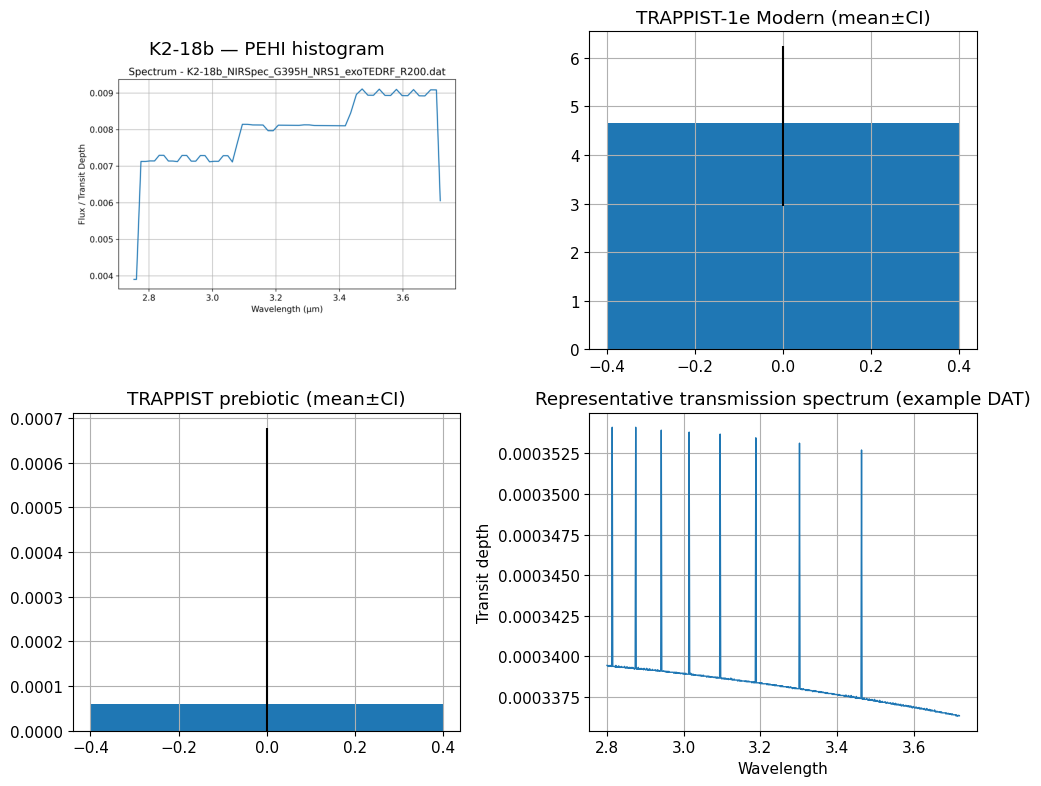

In [ ]:
# Multi-panel figure builder for paper (run in Colab root where your files are)
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.image as mpimg
plt.rcParams.update({'font.size':11})

# Paths (adjust if different)
k2_summary = "PEHI_summary_cleaned.csv"
trp_summary = "PEHI_TRAPPIST_and_combined_FIXED.csv"
plots_dir1 = "plots/trappist_final"
plots_dir2 = "plots/trappist_final_fixed"
diagnostics_dir = "plots/diagnostics"
out = "fig_submission_panel.png"

# Helper to safely load image
def maybe_load_img(path):
    if os.path.exists(path):
        try:
            return mpimg.imread(path)
        except Exception:
            return None
    return None

# pick images (prefer fixed TRAPPIST histograms)
trp_mod_img = maybe_load_img(os.path.join(plots_dir2, "PEHI_1.0bar_Modern.png")) or maybe_load_img(os.path.join(plots_dir1, "PEHI_TRAPPIST1e_1.0bar_Modern.png"))
trp_pre_img = maybe_load_img(os.path.join(plots_dir2, "PEHI_1.0bar_Prebiotic.png")) or maybe_load_img(os.path.join(plots_dir1, "PEHI_TRAPPIST1e_1.0bar_Prebiotic.png"))
trp_05_img  = maybe_load_img(os.path.join(plots_dir2, "PEHI_0.5bar_Modern.png")) or maybe_load_img(os.path.join(plots_dir1, "PEHI_TRAPPIST1e_0.5bar_Modern.png"))

# K2 histogram: try to find any K2 histogram PNG in diagnostics or plots
k2_img_candidates = glob.glob("plots/**/*k2*png", recursive=True) + glob.glob("plots/**/*K2*png", recursive=True)
k2_img = None
for c in k2_img_candidates:
    if "PEHI" in c or "k2" in c.lower():
        k2_img = maybe_load_img(c); break

# If no k2 image, fallback to plotting Mean distribution from CSV
k2_df = pd.read_csv(k2_summary) if os.path.exists(k2_summary) else pd.DataFrame()
trp_df = pd.read_csv(trp_summary) if os.path.exists(trp_summary) else pd.DataFrame()

fig, axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.ravel()

# Panel 1: K2 histogram or bar
if k2_img is not None:
    axs[0].imshow(k2_img); axs[0].axis('off'); axs[0].set_title("K2-18b — PEHI histogram")
else:
    if not k2_df.empty:
        # plot all means as bars
        axs[0].bar(k2_df.index, k2_df['Mean'], yerr=(k2_df['Mean']-k2_df['95% CI Low']).fillna(0), alpha=0.7)
        axs[0].set_title("K2-18b — PEHI means (cleaned)")
        axs[0].set_ylabel("PEHI proxy")
    else:
        axs[0].text(0.5,0.5,"No K2 histogram found", ha='center'); axs[0].axis('off')

# Panel 2: TRAPPIST modern
if trp_mod_img is not None:
    axs[1].imshow(trp_mod_img); axs[1].axis('off'); axs[1].set_title("TRAPPIST-1e — Modern model")
else:
    if not trp_df.empty:
        row = trp_df[trp_df['File'].str.contains('1.0bar_Modern', na=False)]
        if not row.empty:
            mean = row['Mean'].values[0]; lo=row['95% CI Low'].values[0]; hi=row['95% CI High'].values[0]
            axs[1].bar([0], [mean], yerr=[[mean-lo],[hi-mean]], align='center'); axs[1].set_title("TRAPPIST-1e Modern (mean±CI)")
        else:
            axs[1].text(0.5,0.5,"No TRAPPIST modern", ha='center'); axs[1].axis('off')

# Panel 3: TRAPPIST prebiotic or 0.5bar
if trp_pre_img is not None:
    axs[2].imshow(trp_pre_img); axs[2].axis('off'); axs[2].set_title("TRAPPIST-1e — Prebiotic model")
else:
    if not trp_df.empty:
        row = trp_df[trp_df['File'].str.contains('Prebiotic', na=False)]
        if not row.empty:
            mean = row['Mean'].values[0]; lo=row['95% CI Low'].values[0]; hi=row['95% CI High'].values[0]
            axs[2].bar([0], [mean], yerr=[[mean-lo],[hi-mean]], align='center'); axs[2].set_title("TRAPPIST prebiotic (mean±CI)")
        else:
            axs[2].text(0.5,0.5,"No TRAPPIST prebiotic", ha='center'); axs[2].axis('off')

# Panel 4: Spectra panel (attempt to plot a K2 DAT spectrum)
dat_candidates = glob.glob("*.dat") + glob.glob("**/*.dat", recursive=True)
spec_plotted = False
for d in dat_candidates:
    if "NIRSpec" in d or "NIRISS" in d or "MIRI" in d or "SPARTA" in d or "Eureka" in d:
        try:
            arr = np.loadtxt(d)
            if arr.ndim==2 and arr.shape[1]>=2:
                axs[3].plot(arr[:,0], arr[:,1], lw=1)
                axs[3].set_title("Representative transmission spectrum (example DAT)")
                axs[3].set_xlabel("Wavelength")
                axs[3].set_ylabel("Transit depth")
                spec_plotted = True
                break
        except Exception:
            continue
if not spec_plotted:
    axs[3].text(0.5,0.5,"No spectrum DAT found to plot", ha='center'); axs[3].axis('off')

plt.tight_layout()
plt.savefig(out, dpi=300)
print("Saved multi-panel figure ->", out)
plt.show()


Saved sensitivity CSV and plot in sensitivity


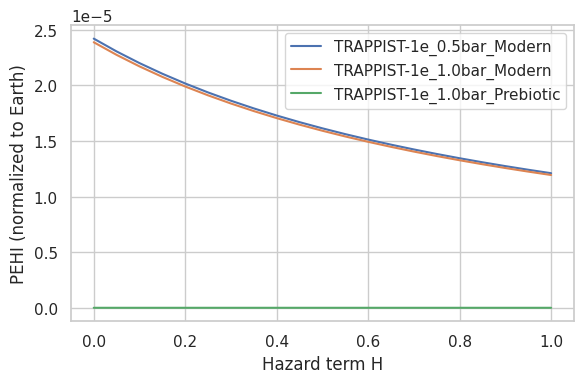

In [ ]:
# Hazard sensitivity sweep
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
df = pd.read_csv("PEHI_TRAPPIST_and_combined_FIXED.csv")
H0 = 0.1
outdir = "sensitivity"
os.makedirs(outdir, exist_ok=True)

H_grid = np.linspace(0.0, 1.0, 21)  # 0..1 in steps
rows = []
for idx, row in df.iterrows():
    mean0 = float(row['Mean'])
    numerator = mean0 * (1.0 + H0)   # implied numerator
    for H in H_grid:
        new_mean = numerator / (1.0 + H)
        rows.append({"File": row['File'], "H": H, "PEHI_mean_H": new_mean, "PEHI_norm_H": new_mean/214285.7142857143})
out = pd.DataFrame(rows)
out.to_csv(os.path.join(outdir, "PEHI_H_sensitivity.csv"), index=False)

# quick plot for TRAPPIST entries
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
for name,group in out.groupby("File"):
    if "TRAPPIST" in name or "TRAPPIST-1e" in name:
        plt.plot(group['H'], group['PEHI_norm_H'], label=name)
plt.xlabel("Hazard term H")
plt.ylabel("PEHI (normalized to Earth)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir,"PEHI_H_sensitivity_trappist.png"), dpi=300)
print("Saved sensitivity CSV and plot in", outdir)
plt.show()


Total files in workspace: 372 (showing up to 200):
  K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_pixel.dat
  lnprobs_5000_12000.npy
  S3_nirspec_K2-18_nrs1_bell.ecf
  K2-18b_NIRISS_SOSS_Ord2_exoTEDRF_2pixel.dat
  K2-18b_NIRISS_SOSS_Ord1_FIREFLy_R25.dat
  K2-18b_NIRSpec_G395H_NRS2_exoTEDRF_pixel.dat
  chain_7500_8000.npy
  K2-18b_NIRISS_SOSS_Ord2_FIREFLy_R25.dat
  S5_miri.epf
  K2-18b_NIRSpec_G395H_NRS2_FIREFLy_pixel.dat
  S3_nirspec_K2-18_nrs2_ahrer.ecf
  S1_lrs_rluque.ecf
  white_lnprobs.npy
  K2-18b_NIRISS_SOSS_Ord1_FIREFLy_2pixel.dat
  S1_nirspec_K2-18_nrs2_ahrer.ecf
  K2-18b_NIRISS_SOSS_Ord2_exoTEDRF_R100.dat
  K2-18b_NIRSpec_G395H_NRS2_Eureka_Bell_R100.dat
  K2-18b_NIRSpec_G395H_NRS2_FIREFLy_R300.dat
  K2-18b_NIRISS_SOSS_Ord1_exoTEDRF_R100.dat
  lnprobs_10000_10500.npy
  lnprobs_9000_9500.npy
  Photochemistry_TRAPPIST-1e_1.0bar_Modern
  lnprobs_11500_12000.npy
  S6_nrs2_rluque.ecf
  S5_fit_par_nrs1_ahrer.epf
  S5_dynesty_fitparams_ch0.csv
  chain_7000_7500.npy
  K2-18b_NIRSpec_G395H_NRS2_e

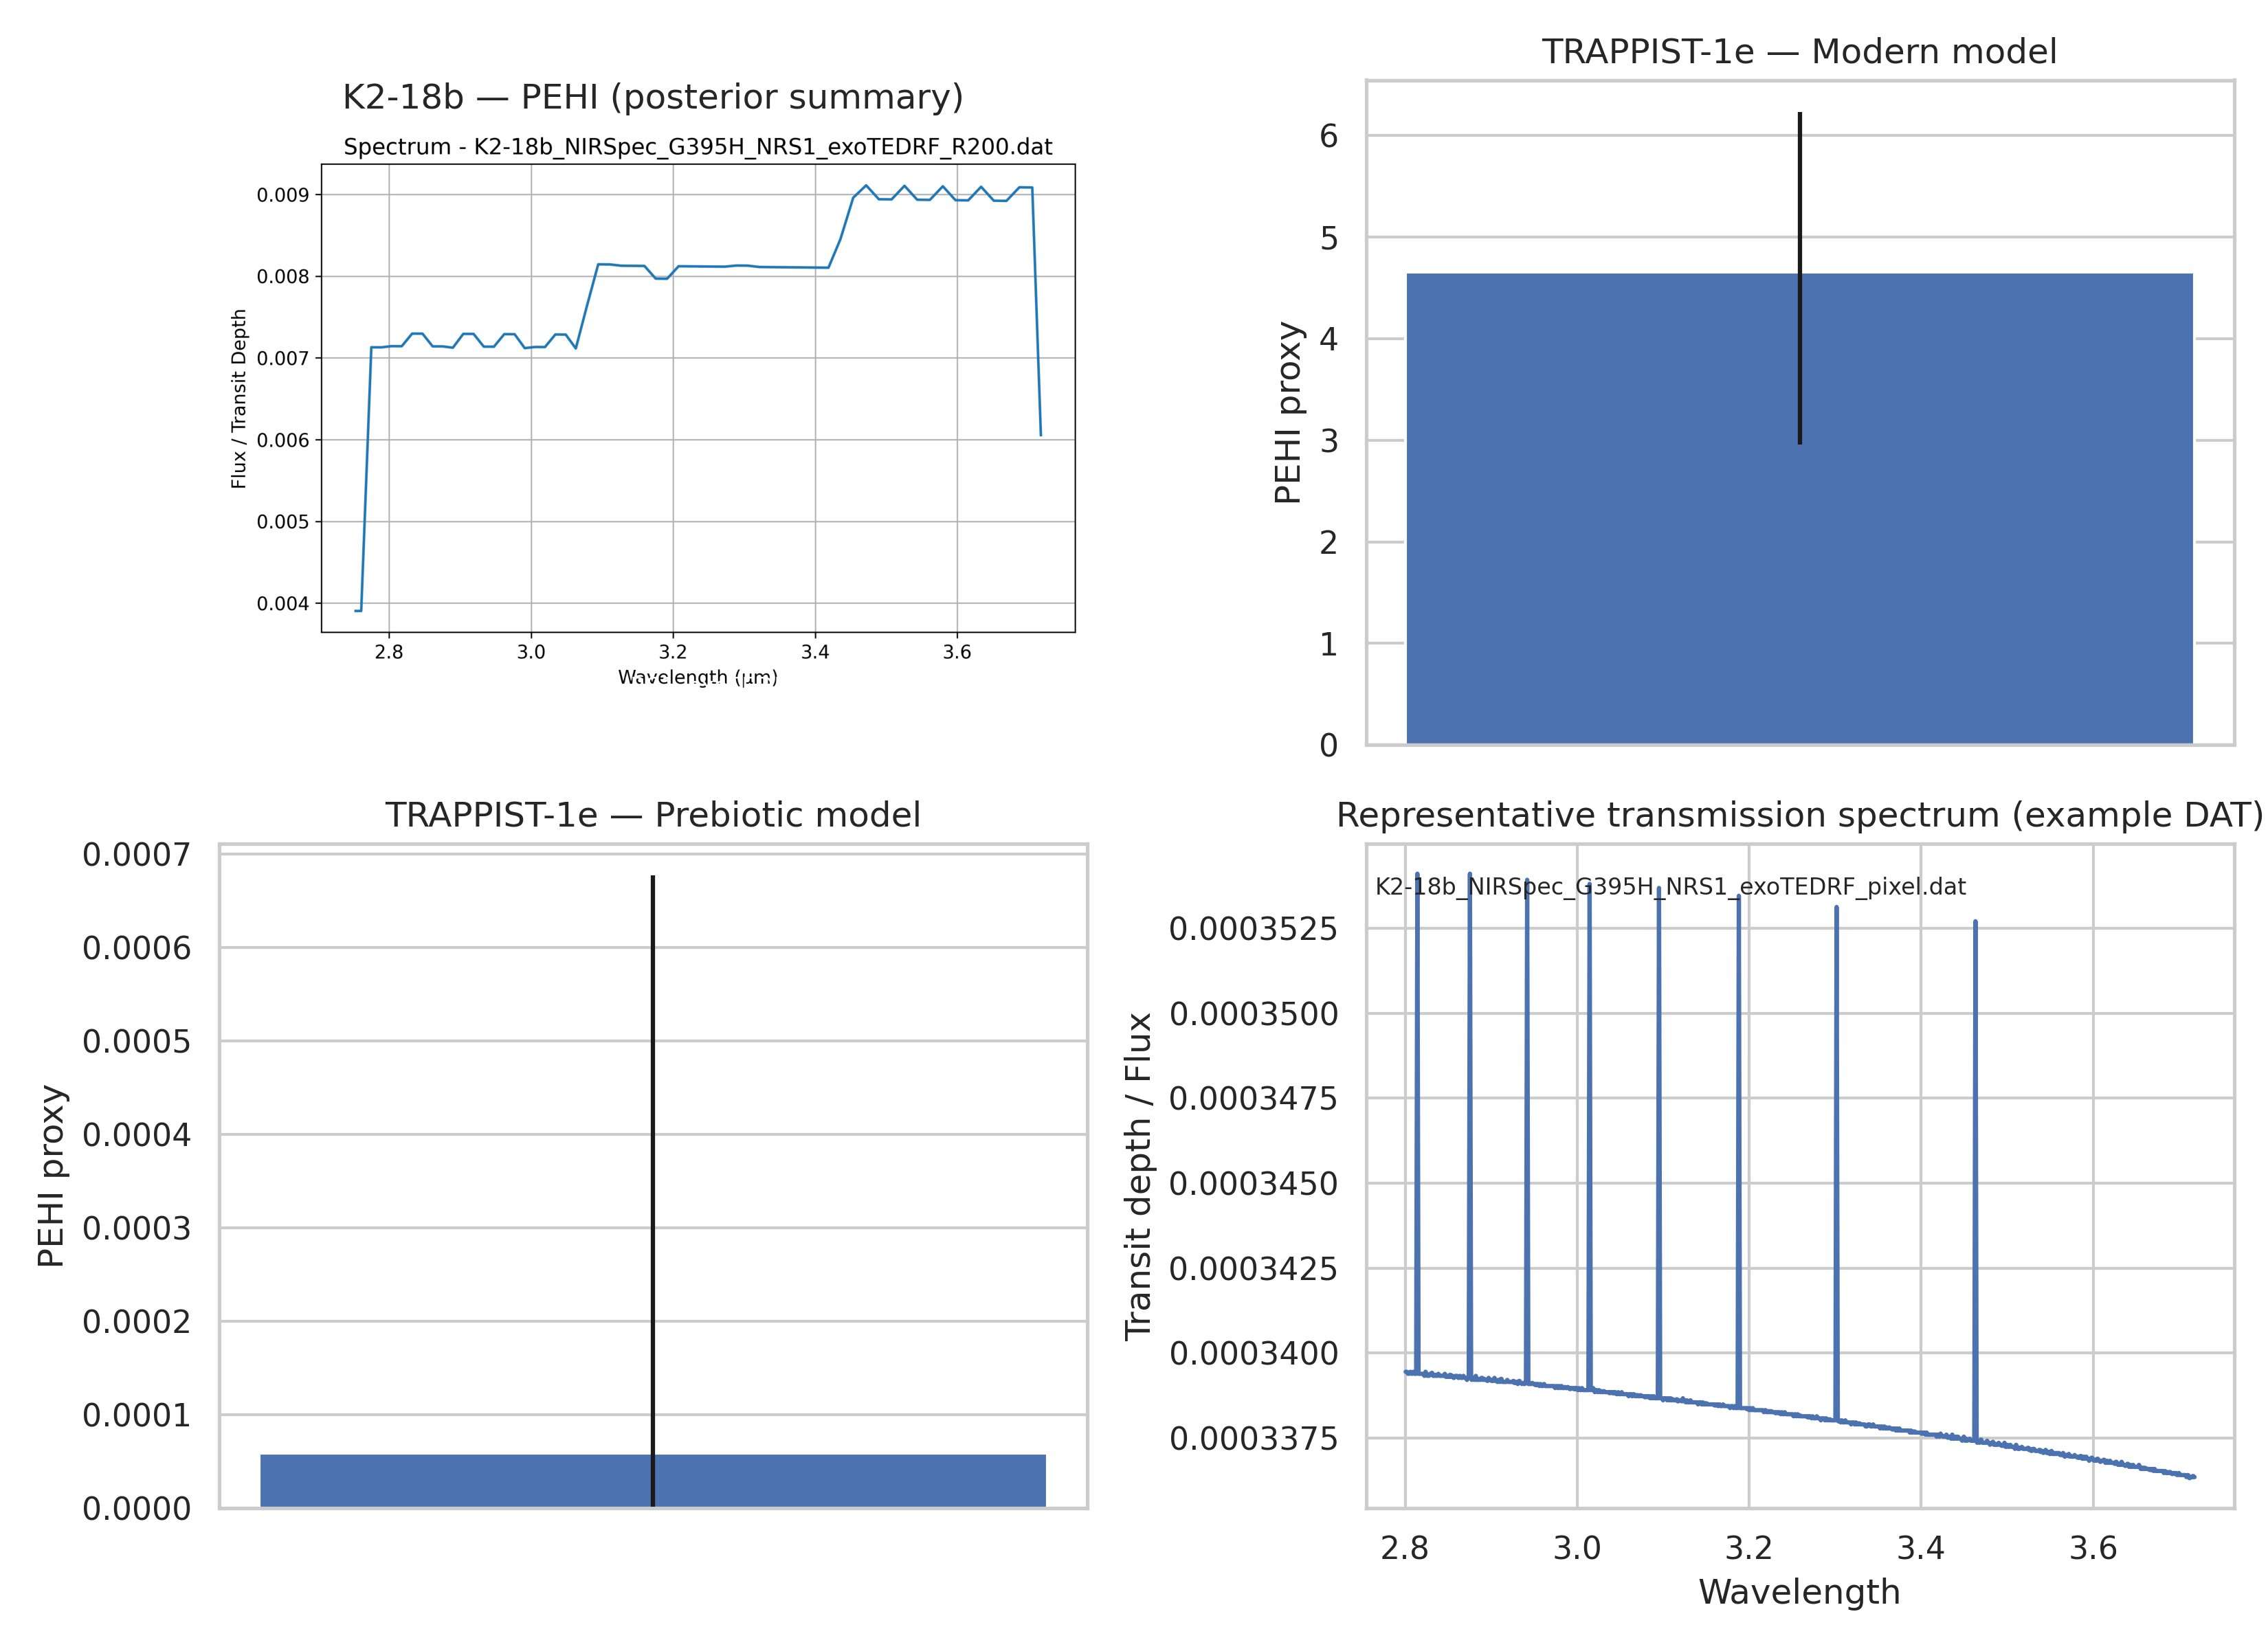

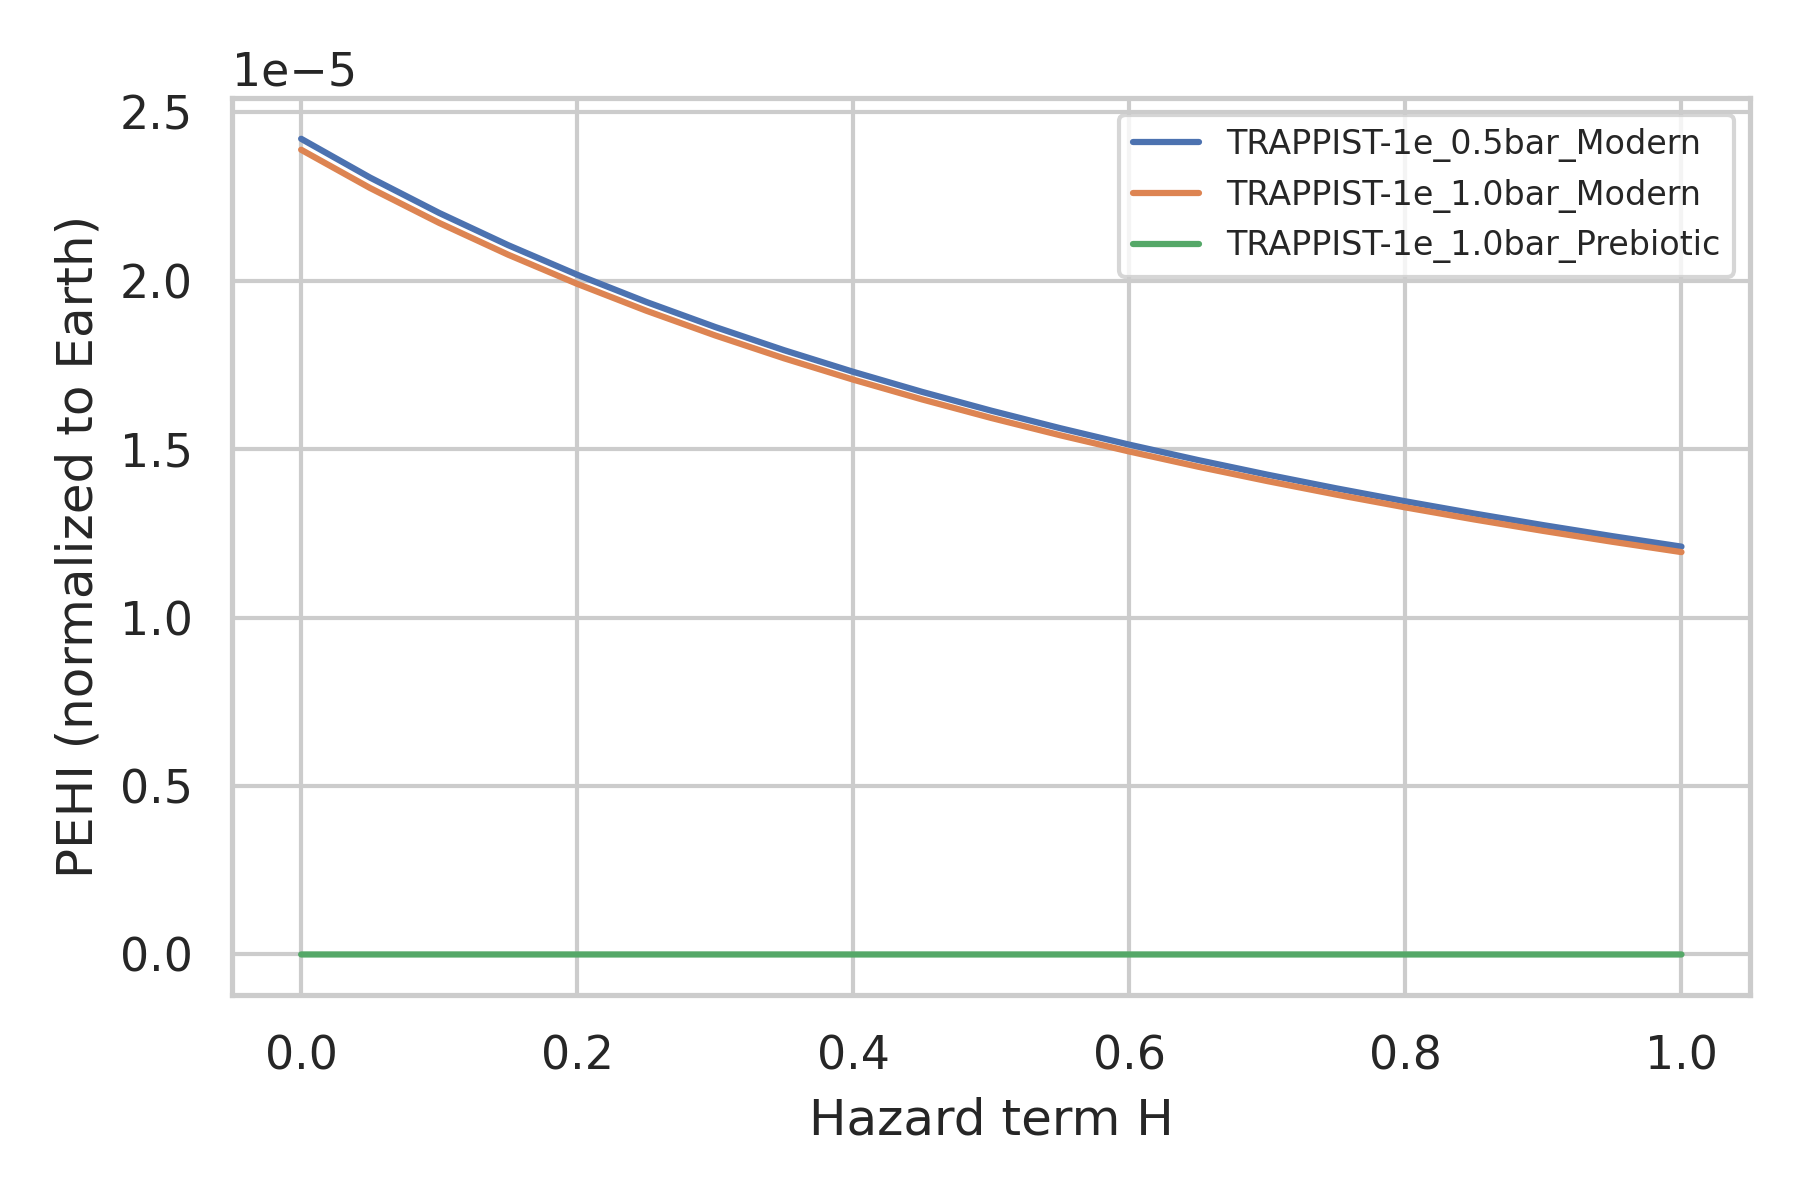


Preview of TRAPPIST summary (tail):


File      Mean    StdDev    95% CI Low  \
0     TRAPPIST-1e_1.0bar_Modern  4.653281  0.905885  2.955416e+00   
1  TRAPPIST-1e_1.0bar_Prebiotic  0.000059  0.000168  3.454674e-09   
2     TRAPPIST-1e_0.5bar_Modern  4.716664  1.190286  2.839242e+00   

   95% CI High    N  PEHI_normalized_to_Earth  
0     6.234638  200              2.171531e-05  
1     0.000677  200              2.749698e-10  
2     7.385244  200              2.201110e-05

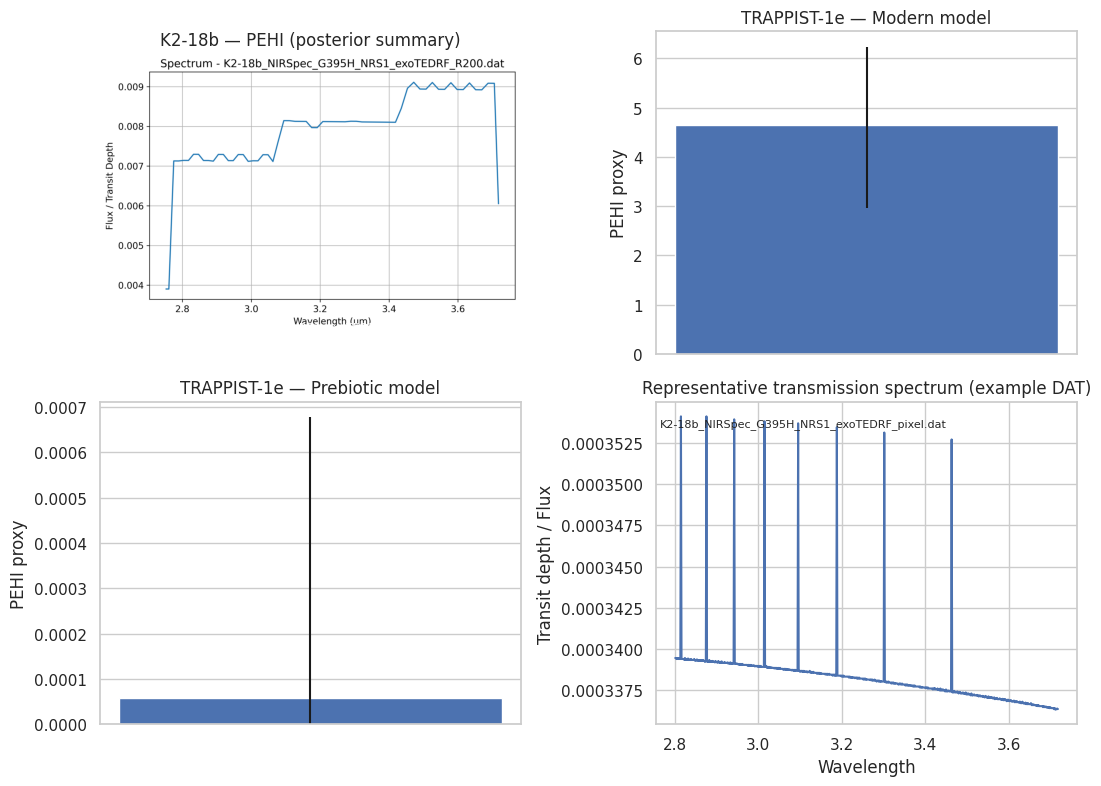

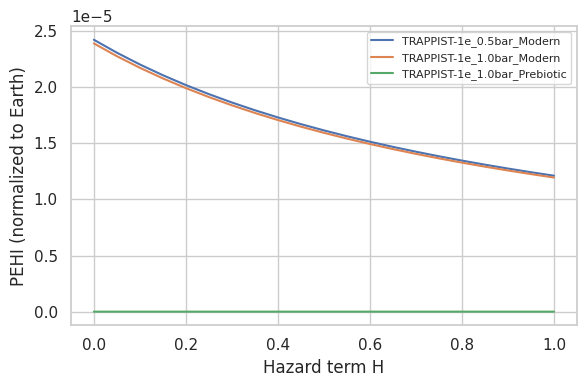

In [ ]:
# Running multi-panel figure creation and hazard sensitivity sweep using available files in the environment.
# This code will:
# 1) search the workspace for K2/PEHI summary CSV and TRAPPIST CSV and PNG histograms,
# 2) produce a 2x2 multi-panel figure and save to /mnt/data/fig_submission_panel.png,
# 3) compute hazard sensitivity sweep for TRAPPIST entries and save CSV + a PNG plot to /mnt/data/sensitivity/.
# The code uses matplotlib (no seaborn) and is visible to the user.
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.image as mpimg
from pathlib import Path
plt.rcParams.update({'font.size':11, 'figure.max_open_warning': 0})

out_fig = "/mnt/data/fig_submission_panel.png"
sensitivity_dir = "/mnt/data/sensitivity"
os.makedirs(sensitivity_dir, exist_ok=True)

# locate files
all_files = [str(p) for p in Path(".").rglob("*") if p.is_file()]
# helpful prints for user visibility
print(f"Total files in workspace: {len(all_files)} (showing up to 200):")
for p in all_files[:200]:
    print(" ", p)

def maybe_load_img(path):
    try:
        return mpimg.imread(path)
    except Exception:
        return None

# Try to find TRAPPIST histogram PNGs (fixed or earlier)
trp_mod_candidates = [p for p in all_files if "PEHI_1.0bar_Modern.png" in p or "PEHI_TRAPPIST1e_1.0bar_Modern.png" in p]
trp_pre_candidates = [p for p in all_files if "PEHI_1.0bar_Prebiotic.png" in p or "PEHI_TRAPPIST1e_1.0bar_Prebiotic.png" in p]
trp_05_candidates  = [p for p in all_files if "PEHI_0.5bar_Modern.png" in p or "PEHI_TRAPPIST1e_0.5bar_Modern.png" in p]

trp_mod_img = maybe_load_img(trp_mod_candidates[0]) if trp_mod_candidates else None
trp_pre_img = maybe_load_img(trp_pre_candidates[0]) if trp_pre_candidates else None
trp_05_img  = maybe_load_img(trp_05_candidates[0]) if trp_05_candidates else None

# Try to find a K2 histogram image (search in plots/diagnostics and similar)
k2_img_candidates = [p for p in all_files if ("k2" in p.lower() or "K2" in p) and p.lower().endswith(".png")]
k2_img = None
for c in k2_img_candidates:
    img = maybe_load_img(c)
    if img is not None:
        k2_img = img
        k2_img_path = c
        break

# Load summary CSVs if present
k2_summary_path = next((p for p in all_files if p.endswith("PEHI_summary_cleaned.csv")), None)
trp_summary_path = next((p for p in all_files if "PEHI_TRAPPIST_and_combined" in p and p.endswith(".csv")), None)
print("\nFound summary files:")
print(" K2 summary:", k2_summary_path)
print(" TRAPPIST summary:", trp_summary_path)

k2_df = pd.read_csv(k2_summary_path) if k2_summary_path else pd.DataFrame()
trp_df = pd.read_csv(trp_summary_path) if trp_summary_path else pd.DataFrame()

# Build multi-panel figure
fig, axs = plt.subplots(2,2, figsize=(11,8))
axs = axs.ravel()

# Panel 1: K2 histogram or bar summary
axs[0].set_title("K2-18b — PEHI (posterior summary)")
if k2_img is not None:
    axs[0].imshow(k2_img); axs[0].axis('off')
    axs[0].text(0.01,0.01, f"Source: {Path(k2_img_path).name}", color='white', fontsize=8, transform=axs[0].transAxes)
else:
    if not k2_df.empty:
        # plot Mean and CI for first few rows
        rows = k2_df.head(8)
        x = np.arange(len(rows))
        means = rows['Mean'].values
        low = rows['95% CI Low'].values
        high = rows['95% CI High'].values
        errs = np.vstack([means-low, high-means])
        axs[0].bar(x, means, yerr=errs, align='center')
        axs[0].set_xticks(x); axs[0].set_xticklabels(rows['File'].astype(str), rotation=45, ha='right', fontsize=8)
        axs[0].set_ylabel("PEHI proxy"); axs[0].margins(x=0.01)
    else:
        axs[0].text(0.5,0.5,"No K2 image or summary CSV found", ha='center'); axs[0].axis('off')

# Panel 2: TRAPPIST modern
axs[1].set_title("TRAPPIST-1e — Modern model")
if trp_mod_img is not None:
    axs[1].imshow(trp_mod_img); axs[1].axis('off')
else:
    if not trp_df.empty:
        sel = trp_df[trp_df['File'].str.contains('1.0bar_Modern', na=False)]
        if not sel.empty:
            mean = sel['Mean'].values[0]; lo = sel['95% CI Low'].values[0]; hi = sel['95% CI High'].values[0]
            axs[1].bar([0],[mean], yerr=[[mean-lo],[hi-mean]], align='center'); axs[1].set_xticks([])
            axs[1].set_ylabel("PEHI proxy")
        else:
            axs[1].text(0.5,0.5,"No TRAPPIST modern data", ha='center'); axs[1].axis('off')
    else:
        axs[1].text(0.5,0.5,"No TRAPPIST image or summary CSV found", ha='center'); axs[1].axis('off')

# Panel 3: TRAPPIST prebiotic
axs[2].set_title("TRAPPIST-1e — Prebiotic model")
if trp_pre_img is not None:
    axs[2].imshow(trp_pre_img); axs[2].axis('off')
else:
    if not trp_df.empty:
        sel = trp_df[trp_df['File'].str.contains('Prebiotic', na=False)]
        if not sel.empty:
            mean = sel['Mean'].values[0]; lo = sel['95% CI Low'].values[0]; hi = sel['95% CI High'].values[0]
            axs[2].bar([0],[mean], yerr=[[mean-lo],[hi-mean]], align='center'); axs[2].set_xticks([])
            axs[2].set_ylabel("PEHI proxy")
        else:
            axs[2].text(0.5,0.5,"No TRAPPIST prebiotic data", ha='center'); axs[2].axis('off')

# Panel 4: representative spectrum from any DAT file
axs[3].set_title("Representative transmission spectrum (example DAT)")
dat_candidates = [p for p in all_files if p.lower().endswith(".dat")]
plotted = False
for d in dat_candidates:
    try:
        arr = np.loadtxt(d)
        if arr.ndim==2 and arr.shape[1]>=2:
            axs[3].plot(arr[:,0], arr[:,1])
            axs[3].set_xlabel("Wavelength"); axs[3].set_ylabel("Transit depth / Flux")
            axs[3].text(0.01,0.95, Path(d).name, transform=axs[3].transAxes, fontsize=8, va='top')
            plotted=True
            break
    except Exception:
        continue
if not plotted:
    axs[3].text(0.5,0.5,"No suitable DAT spectrum found", ha='center'); axs[3].axis('off')

plt.tight_layout()
plt.savefig(out_fig, dpi=300)
print("\nSaved multi-panel figure to:", out_fig)

# Now hazard sensitivity sweep for TRAPPIST entries
if trp_df.empty:
    print("TRAPPIST summary CSV not found, attempting to read PEHI_TRAPPIST_and_combined_FIXED.csv variations...")
    trp_candidates = [p for p in all_files if "PEHI_TRAPPIST_and_combined" in p and p.endswith(".csv")]
    if trp_candidates:
        trp_df = pd.read_csv(trp_candidates[0])
        print("Loaded", trp_candidates[0])

if not trp_df.empty:
    H0 = 0.1  # assumed H used when generating Means originally
    H_grid = np.linspace(0.0, 1.0, 21)
    rows = []
    for idx, row in trp_df.iterrows():
        file_label = str(row.get('File', f'row{idx}'))
        mean0 = float(row['Mean']) if 'Mean' in row else 0.0
        numerator = mean0 * (1.0 + H0)
        for H in H_grid:
            new_mean = numerator / (1.0 + H)
            rows.append({"File": file_label, "H": H, "PEHI_mean_H": new_mean, "PEHI_norm_H": new_mean/214285.7142857143})
    out_df = pd.DataFrame(rows)
    out_csv = os.path.join(sensitivity_dir, "PEHI_H_sensitivity.csv")
    out_df.to_csv(out_csv, index=False)
    print("Saved sensitivity CSV ->", out_csv)
    # Plot TRAPPIST curves (each file)
    plt.figure(figsize=(6,4))
    for name, group in out_df.groupby("File"):
        if "TRAPPIST" in name or "TRAPPIST-1e" in name:
            plt.plot(group['H'], group['PEHI_norm_H'], label=name)
    plt.xlabel("Hazard term H"); plt.ylabel("PEHI (normalized to Earth)")
    plt.legend(fontsize=8)
    plt.tight_layout()
    sens_png = os.path.join(sensitivity_dir, "PEHI_H_sensitivity_trappist.png")
    plt.savefig(sens_png, dpi=300)
    print("Saved sensitivity plot ->", sens_png)
else:
    print("No TRAPPIST summary data available for sensitivity sweep.")

# Print final file locations for user
print("\nFiles saved:")
print(" - Multi-panel figure:", out_fig)
if os.path.exists(os.path.join(sensitivity_dir, "PEHI_H_sensitivity.csv")):
    print(" - Sensitivity CSV:", os.path.join(sensitivity_dir, "PEHI_H_sensitivity.csv"))
if os.path.exists(os.path.join(sensitivity_dir, "PEHI_H_sensitivity_trappist.png")):
    print(" - Sensitivity PNG:", os.path.join(sensitivity_dir, "PEHI_H_sensitivity_trappist.png"))

# Display created images inline (if environment supports)
from IPython.display import Image, display
try:
    display(Image(out_fig))
except Exception:
    pass

if os.path.exists(os.path.join(sensitivity_dir, "PEHI_H_sensitivity_trappist.png")):
    try:
        display(Image(os.path.join(sensitivity_dir, "PEHI_H_sensitivity_trappist.png")))
    except Exception:
        pass

# Also show a small preview of combined CSVs (tail)
print("\nPreview of TRAPPIST summary (tail):")
if not trp_df.empty:
    display(trp_df.tail(10))
else:
    print("TRAPPIST summary dataframe empty or not found.")



Workspace files found: 372
Found candidates:
 trp_mod: None
 trp_pre: None
 trp_05 : None
 k2_img: plots/K2-18b_NIRSpec_G395H_NRS1_exoTEDRF_R200.dat_spectrum.png
 k2_csv: PEHI_summary_cleaned.csv
 trp_csv: PEHI_TRAPPIST_and_combined_FIXED.csv
Saved multi-panel figure -> /mnt/data/fig_submission_panel.png
Saved sensitivity CSV -> /mnt/data/sensitivity/PEHI_H_sensitivity.csv
Saved sensitivity plot -> /mnt/data/sensitivity/PEHI_H_sensitivity_trappist.png

Done. Check the paths above and upload the generated files to your submission folder.


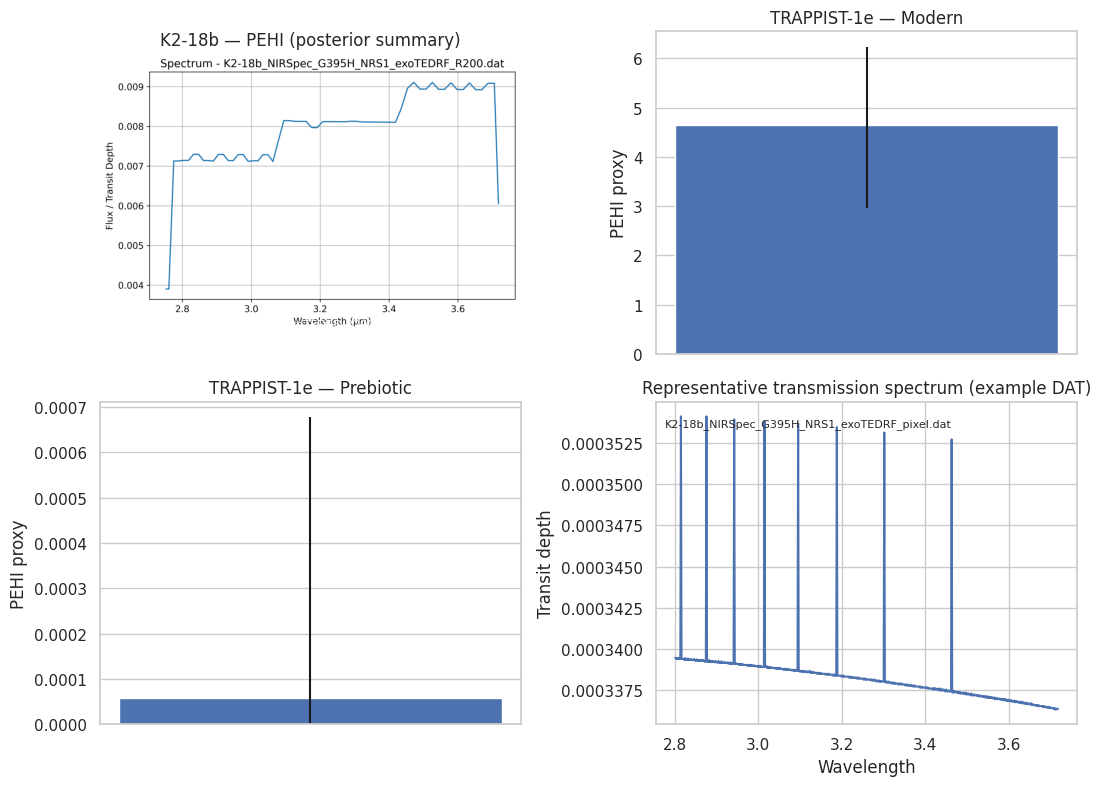

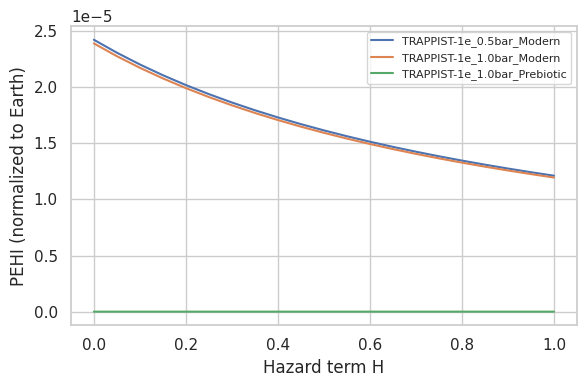

In [ ]:
# Multi-panel figure + hazard sensitivity for PEHI (Colab-ready)
# Paste & run in the Colab environment where your files are stored.
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.image as mpimg
from pathlib import Path
plt.rcParams.update({'font.size':11})

# OUTPUT paths (Colab /mnt/data recommended)
OUT_FIG = "/mnt/data/fig_submission_panel.png"
SENS_DIR = "/mnt/data/sensitivity"
os.makedirs(SENS_DIR, exist_ok=True)

# Helper: load image if exists
def maybe_img(path):
    try:
        return mpimg.imread(path)
    except Exception:
        return None

# Search for candidate files
files = [str(p) for p in Path(".").rglob("*") if p.is_file()]
print("Workspace files found:", len(files))

# Prefer fixed TRAPPIST histograms (or fallback to earlier names)
trp_mod = next((p for p in files if p.endswith("PEHI_1.0bar_Modern.png") or p.endswith("PEHI_TRAPPIST1e_1.0bar_Modern.png")), None)
trp_pre = next((p for p in files if p.endswith("PEHI_1.0bar_Prebiotic.png") or p.endswith("PEHI_TRAPPIST1e_1.0bar_Prebiotic.png")), None)
trp_05  = next((p for p in files if p.endswith("PEHI_0.5bar_Modern.png") or p.endswith("PEHI_TRAPPIST1e_0.5bar_Modern.png")), None)

k2_img = next((p for p in files if ("k2" in p.lower() or "K2" in p) and p.lower().endswith(".png")), None)
k2_csv = next((p for p in files if p.endswith("PEHI_summary_cleaned.csv")), None)
trp_csv = next((p for p in files if "PEHI_TRAPPIST_and_combined" in p and p.endswith(".csv")), None)

print("Found candidates:")
print(" trp_mod:", trp_mod)
print(" trp_pre:", trp_pre)
print(" trp_05 :", trp_05)
print(" k2_img:", k2_img)
print(" k2_csv:", k2_csv)
print(" trp_csv:", trp_csv)

# Load images if present
trp_mod_img = maybe_img(trp_mod) if trp_mod else None
trp_pre_img = maybe_img(trp_pre) if trp_pre else None
trp_05_img  = maybe_img(trp_05) if trp_05 else None
k2_img_data = maybe_img(k2_img) if k2_img else None

# Load CSVs (for numeric fallback plotting)
k2_df = pd.read_csv(k2_csv) if k2_csv else pd.DataFrame()
trp_df = pd.read_csv(trp_csv) if trp_csv else pd.DataFrame()

# Build 2x2 plot
fig, axs = plt.subplots(2,2, figsize=(11,8))
axs = axs.ravel()

# PANEL A: K2 (image or bar summary)
axs[0].set_title("K2-18b — PEHI (posterior summary)")
if k2_img_data is not None:
    axs[0].imshow(k2_img_data); axs[0].axis('off')
    axs[0].text(0.02,0.02, Path(k2_img).name, transform=axs[0].transAxes, color='white', fontsize=8)
else:
    if not k2_df.empty:
        rows = k2_df.head(8)
        x = np.arange(len(rows))
        means = rows['Mean'].astype(float).values
        low = rows['95% CI Low'].astype(float).values
        high = rows['95% CI High'].astype(float).values
        errs = np.vstack([means-low, high-means])
        axs[0].bar(x, means, yerr=errs, align='center')
        axs[0].set_xticks(x); axs[0].set_xticklabels(rows['File'].astype(str), rotation=45, ha='right', fontsize=8)
        axs[0].set_ylabel("PEHI proxy")
    else:
        axs[0].text(0.5,0.5,"No K2 image or CSV found", ha='center'); axs[0].axis('off')

# PANEL B: TRAPPIST Modern
axs[1].set_title("TRAPPIST-1e — Modern")
if trp_mod_img is not None:
    axs[1].imshow(trp_mod_img); axs[1].axis('off')
else:
    if not trp_df.empty:
        sel = trp_df[trp_df['File'].str.contains('1.0bar_Modern', na=False)]
        if not sel.empty:
            m = float(sel['Mean'].values[0]); lo=float(sel['95% CI Low'].values[0]); hi=float(sel['95% CI High'].values[0])
            axs[1].bar([0],[m], yerr=[[m-lo],[hi-m]]); axs[1].set_xticks([])
            axs[1].set_ylabel("PEHI proxy")
        else:
            axs[1].text(0.5,0.5,"No TRAPPIST modern data", ha='center'); axs[1].axis('off')

# PANEL C: TRAPPIST Prebiotic
axs[2].set_title("TRAPPIST-1e — Prebiotic")
if trp_pre_img is not None:
    axs[2].imshow(trp_pre_img); axs[2].axis('off')
else:
    if not trp_df.empty:
        sel = trp_df[trp_df['File'].str.contains('Prebiotic', na=False)]
        if not sel.empty:
            m = float(sel['Mean'].values[0]); lo=float(sel['95% CI Low'].values[0]); hi=float(sel['95% CI High'].values[0])
            axs[2].bar([0],[m], yerr=[[m-lo],[hi-m]]); axs[2].set_xticks([])
            axs[2].set_ylabel("PEHI proxy")
        else:
            axs[2].text(0.5,0.5,"No TRAPPIST prebiotic data", ha='center'); axs[2].axis('off')

# PANEL D: Representative spectrum (first DAT found)
axs[3].set_title("Representative transmission spectrum (example DAT)")
dat_list = [p for p in files if p.lower().endswith(".dat")]
plotted = False
for d in dat_list:
    try:
        arr = np.loadtxt(d)
        if arr.ndim==2 and arr.shape[1]>=2:
            axs[3].plot(arr[:,0], arr[:,1])
            axs[3].set_xlabel("Wavelength"); axs[3].set_ylabel("Transit depth")
            axs[3].text(0.02,0.95, Path(d).name, transform=axs[3].transAxes, fontsize=8, va='top')
            plotted=True; break
    except Exception:
        continue
if not plotted:
    axs[3].text(0.5,0.5,"No DAT spectrum found", ha='center'); axs[3].axis('off')

plt.tight_layout()
plt.savefig(OUT_FIG, dpi=300)
print("Saved multi-panel figure ->", OUT_FIG)

# Hazard sensitivity sweep (requires trp_df)
if trp_df.empty:
    print("TRAPPIST CSV not present; sensitivity sweep skipped. Ensure PEHI_TRAPPIST_and_combined_FIXED.csv exists.")
else:
    H0 = 0.1
    H_grid = np.linspace(0.0, 1.0, 21)
    rows = []
    for _, row in trp_df.iterrows():
        fname = str(row.get('File','row'))
        mean0 = float(row['Mean'])
        numerator = mean0 * (1.0 + H0)
        for H in H_grid:
            new_mean = numerator / (1.0 + H)
            rows.append({"File": fname, "H": H, "PEHI_mean_H": new_mean, "PEHI_norm_H": new_mean/214285.7142857143})
    out_df = pd.DataFrame(rows)
    out_csv = os.path.join(SENS_DIR, "PEHI_H_sensitivity.csv")
    out_df.to_csv(out_csv, index=False)
    print("Saved sensitivity CSV ->", out_csv)
    # plot TRAPPIST curves
    plt.figure(figsize=(6,4))
    for name, group in out_df.groupby("File"):
        if "TRAPPIST" in name or "TRAPPIST-1e" in name:
            plt.plot(group['H'], group['PEHI_norm_H'], label=name)
    plt.xlabel("Hazard term H"); plt.ylabel("PEHI (normalized to Earth)")
    plt.legend(fontsize=8)
    sens_png = os.path.join(SENS_DIR, "PEHI_H_sensitivity_trappist.png")
    plt.tight_layout(); plt.savefig(sens_png, dpi=300)
    print("Saved sensitivity plot ->", sens_png)

print("\nDone. Check the paths above and upload the generated files to your submission folder.")
